In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.799691
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.778703


[3]	valid_0's rmse: 0.758452


[4]	valid_0's rmse: 0.739809


[5]	valid_0's rmse: 0.722721


[6]	valid_0's rmse: 0.706956


[7]	valid_0's rmse: 0.691718


[8]	valid_0's rmse: 0.677659


[9]	valid_0's rmse: 0.664989


[10]	valid_0's rmse: 0.652846


[11]	valid_0's rmse: 0.641784


[12]	valid_0's rmse: 0.631795


[13]	valid_0's rmse: 0.622438


[14]	valid_0's rmse: 0.613991


[15]	valid_0's rmse: 0.606106


[16]	valid_0's rmse: 0.598813


[17]	valid_0's rmse: 0.59208


[18]	valid_0's rmse: 0.585605


[19]	valid_0's rmse: 0.57972


[20]	valid_0's rmse: 0.574368


[21]	valid_0's rmse: 0.569333


[22]	valid_0's rmse: 0.56483


[23]	valid_0's rmse: 0.560632


[24]	valid_0's rmse: 0.556827


[25]	valid_0's rmse: 0.553377


[26]	valid_0's rmse: 0.550225


[27]	valid_0's rmse: 0.547349


[28]	valid_0's rmse: 0.544633


[29]	valid_0's rmse: 0.542075


[30]	valid_0's rmse: 0.539621


[31]	valid_0's rmse: 0.537438


[32]	valid_0's rmse: 0.535509


[33]	valid_0's rmse: 0.533674


[34]	valid_0's rmse: 0.531944


[35]	valid_0's rmse: 0.530469


[36]	valid_0's rmse: 0.529079


[37]	valid_0's rmse: 0.527719


[38]	valid_0's rmse: 0.52647


[39]	valid_0's rmse: 0.525282


[40]	valid_0's rmse: 0.52421


[41]	valid_0's rmse: 0.52321


[42]	valid_0's rmse: 0.522343


[43]	valid_0's rmse: 0.521537


[44]	valid_0's rmse: 0.520754


[45]	valid_0's rmse: 0.519956


[46]	valid_0's rmse: 0.519322


[47]	valid_0's rmse: 0.518698


[48]	valid_0's rmse: 0.518125
[49]	valid_0's rmse: 0.517548


[50]	valid_0's rmse: 0.517016


[51]	valid_0's rmse: 0.516492


[52]	valid_0's rmse: 0.515995
[53]	valid_0's rmse: 0.51562


[54]	valid_0's rmse: 0.515211
[55]	valid_0's rmse: 0.51481


[56]	valid_0's rmse: 0.514431
[57]	valid_0's rmse: 0.514132


[58]	valid_0's rmse: 0.513813
[59]	valid_0's rmse: 0.513559


[60]	valid_0's rmse: 0.513276


[61]	valid_0's rmse: 0.512939
[62]	valid_0's rmse: 0.512637


[63]	valid_0's rmse: 0.51238
[64]	valid_0's rmse: 0.512166


[65]	valid_0's rmse: 0.511921
[66]	valid_0's rmse: 0.511733


[67]	valid_0's rmse: 0.511558
[68]	valid_0's rmse: 0.5114


[69]	valid_0's rmse: 0.511143
[70]	valid_0's rmse: 0.510999


[71]	valid_0's rmse: 0.510815
[72]	valid_0's rmse: 0.510667


[73]	valid_0's rmse: 0.51044


[74]	valid_0's rmse: 0.510303
[75]	valid_0's rmse: 0.510115


[76]	valid_0's rmse: 0.509987
[77]	valid_0's rmse: 0.509855


[78]	valid_0's rmse: 0.509762
[79]	valid_0's rmse: 0.509613


[80]	valid_0's rmse: 0.509492
[81]	valid_0's rmse: 0.509414


[82]	valid_0's rmse: 0.509273
[83]	valid_0's rmse: 0.509179


[84]	valid_0's rmse: 0.509082
[85]	valid_0's rmse: 0.509032


[86]	valid_0's rmse: 0.508885
[87]	valid_0's rmse: 0.50883


[88]	valid_0's rmse: 0.508716
[89]	valid_0's rmse: 0.508615


[90]	valid_0's rmse: 0.508528
[91]	valid_0's rmse: 0.50845


[92]	valid_0's rmse: 0.508364
[93]	valid_0's rmse: 0.508231


[94]	valid_0's rmse: 0.50817
[95]	valid_0's rmse: 0.507977


[96]	valid_0's rmse: 0.507846
[97]	valid_0's rmse: 0.507776


[98]	valid_0's rmse: 0.50761
[99]	valid_0's rmse: 0.507544


[100]	valid_0's rmse: 0.5075
[101]	valid_0's rmse: 0.507363


[102]	valid_0's rmse: 0.507261
[103]	valid_0's rmse: 0.507158


[104]	valid_0's rmse: 0.507025
[105]	valid_0's rmse: 0.506949


[106]	valid_0's rmse: 0.506909
[107]	valid_0's rmse: 0.50688


[108]	valid_0's rmse: 0.506846
[109]	valid_0's rmse: 0.506784


[110]	valid_0's rmse: 0.506669
[111]	valid_0's rmse: 0.506577


[112]	valid_0's rmse: 0.50651
[113]	valid_0's rmse: 0.506446


[114]	valid_0's rmse: 0.506391
[115]	valid_0's rmse: 0.50633


[116]	valid_0's rmse: 0.506275
[117]	valid_0's rmse: 0.506196


[118]	valid_0's rmse: 0.506128
[119]	valid_0's rmse: 0.506122


[120]	valid_0's rmse: 0.506054
[121]	valid_0's rmse: 0.505996


[122]	valid_0's rmse: 0.50595
[123]	valid_0's rmse: 0.505926


[124]	valid_0's rmse: 0.505893
[125]	valid_0's rmse: 0.505904


[126]	valid_0's rmse: 0.505849
[127]	valid_0's rmse: 0.505849


[128]	valid_0's rmse: 0.505812
[129]	valid_0's rmse: 0.50577


[130]	valid_0's rmse: 0.505673
[131]	valid_0's rmse: 0.505656


[132]	valid_0's rmse: 0.50565
[133]	valid_0's rmse: 0.505615


[134]	valid_0's rmse: 0.505573
[135]	valid_0's rmse: 0.505563


[136]	valid_0's rmse: 0.505551
[137]	valid_0's rmse: 0.50555


[138]	valid_0's rmse: 0.505498
[139]	valid_0's rmse: 0.505447


[140]	valid_0's rmse: 0.505432
[141]	valid_0's rmse: 0.505398


[142]	valid_0's rmse: 0.505334
[143]	valid_0's rmse: 0.505331


[144]	valid_0's rmse: 0.505283
[145]	valid_0's rmse: 0.505253


[146]	valid_0's rmse: 0.505212
[147]	valid_0's rmse: 0.50521


[148]	valid_0's rmse: 0.505179
[149]	valid_0's rmse: 0.505154


[150]	valid_0's rmse: 0.505153
[151]	valid_0's rmse: 0.50511


[152]	valid_0's rmse: 0.505075
[153]	valid_0's rmse: 0.505044


[154]	valid_0's rmse: 0.505016
[155]	valid_0's rmse: 0.504989


[156]	valid_0's rmse: 0.504977
[157]	valid_0's rmse: 0.504993


[158]	valid_0's rmse: 0.504977
[159]	valid_0's rmse: 0.50493


[160]	valid_0's rmse: 0.504898
[161]	valid_0's rmse: 0.504887


[162]	valid_0's rmse: 0.504859
[163]	valid_0's rmse: 0.504816


[164]	valid_0's rmse: 0.504827
[165]	valid_0's rmse: 0.504797


[166]	valid_0's rmse: 0.504776
[167]	valid_0's rmse: 0.504739


[168]	valid_0's rmse: 0.504724
[169]	valid_0's rmse: 0.504708


[170]	valid_0's rmse: 0.504606
[171]	valid_0's rmse: 0.504578


[172]	valid_0's rmse: 0.504576
[173]	valid_0's rmse: 0.50455


[174]	valid_0's rmse: 0.504542
[175]	valid_0's rmse: 0.504507


[176]	valid_0's rmse: 0.504509
[177]	valid_0's rmse: 0.50451


[178]	valid_0's rmse: 0.504504
[179]	valid_0's rmse: 0.504472


[180]	valid_0's rmse: 0.504439
[181]	valid_0's rmse: 0.504437


[182]	valid_0's rmse: 0.504426
[183]	valid_0's rmse: 0.504422


[184]	valid_0's rmse: 0.504384
[185]	valid_0's rmse: 0.504404


[186]	valid_0's rmse: 0.504385
[187]	valid_0's rmse: 0.50437


[188]	valid_0's rmse: 0.50435
[189]	valid_0's rmse: 0.504329


[190]	valid_0's rmse: 0.504267
[191]	valid_0's rmse: 0.504251


[192]	valid_0's rmse: 0.504205
[193]	valid_0's rmse: 0.504181


[194]	valid_0's rmse: 0.504182
[195]	valid_0's rmse: 0.504179


[196]	valid_0's rmse: 0.504125
[197]	valid_0's rmse: 0.50409


[198]	valid_0's rmse: 0.504011
[199]	valid_0's rmse: 0.503976


[200]	valid_0's rmse: 0.503971
[201]	valid_0's rmse: 0.503945


[202]	valid_0's rmse: 0.503939
[203]	valid_0's rmse: 0.503922


[204]	valid_0's rmse: 0.503895
[205]	valid_0's rmse: 0.503875


[206]	valid_0's rmse: 0.503889
[207]	valid_0's rmse: 0.503871


[208]	valid_0's rmse: 0.50388
[209]	valid_0's rmse: 0.503888


[210]	valid_0's rmse: 0.503893
[211]	valid_0's rmse: 0.503871


[212]	valid_0's rmse: 0.503866
[213]	valid_0's rmse: 0.503836


[214]	valid_0's rmse: 0.503836
[215]	valid_0's rmse: 0.503828


[216]	valid_0's rmse: 0.50383
[217]	valid_0's rmse: 0.503813


[218]	valid_0's rmse: 0.503776
[219]	valid_0's rmse: 0.503775


[220]	valid_0's rmse: 0.503774
[221]	valid_0's rmse: 0.503758


[222]	valid_0's rmse: 0.503745
[223]	valid_0's rmse: 0.503711


[224]	valid_0's rmse: 0.503718
[225]	valid_0's rmse: 0.50368


[226]	valid_0's rmse: 0.503641
[227]	valid_0's rmse: 0.503679


[228]	valid_0's rmse: 0.503676
[229]	valid_0's rmse: 0.503674


[230]	valid_0's rmse: 0.503645
[231]	valid_0's rmse: 0.503639


[232]	valid_0's rmse: 0.503607
[233]	valid_0's rmse: 0.503609
[234]	valid_0's rmse: 0.503627


[235]	valid_0's rmse: 0.503618
[236]	valid_0's rmse: 0.503612


[237]	valid_0's rmse: 0.503625
[238]	valid_0's rmse: 0.503608


[239]	valid_0's rmse: 0.503617
[240]	valid_0's rmse: 0.503602


[241]	valid_0's rmse: 0.503581
[242]	valid_0's rmse: 0.503596


[243]	valid_0's rmse: 0.503577
[244]	valid_0's rmse: 0.503566


[245]	valid_0's rmse: 0.503565
[246]	valid_0's rmse: 0.503568


[247]	valid_0's rmse: 0.503552
[248]	valid_0's rmse: 0.503551


[249]	valid_0's rmse: 0.503556
[250]	valid_0's rmse: 0.503541


[251]	valid_0's rmse: 0.503537
[252]	valid_0's rmse: 0.503544


[253]	valid_0's rmse: 0.503519
[254]	valid_0's rmse: 0.50349


[255]	valid_0's rmse: 0.503487
[256]	valid_0's rmse: 0.503479


[257]	valid_0's rmse: 0.503463
[258]	valid_0's rmse: 0.503457


[259]	valid_0's rmse: 0.503465
[260]	valid_0's rmse: 0.503452


[261]	valid_0's rmse: 0.503463
[262]	valid_0's rmse: 0.503443


[263]	valid_0's rmse: 0.50344
[264]	valid_0's rmse: 0.503423


[265]	valid_0's rmse: 0.503456
[266]	valid_0's rmse: 0.503453


[267]	valid_0's rmse: 0.503464
[268]	valid_0's rmse: 0.50345


[269]	valid_0's rmse: 0.503443
[270]	valid_0's rmse: 0.503415


[271]	valid_0's rmse: 0.503419
[272]	valid_0's rmse: 0.503443


[273]	valid_0's rmse: 0.503436
[274]	valid_0's rmse: 0.503419


[275]	valid_0's rmse: 0.503408
[276]	valid_0's rmse: 0.503415


[277]	valid_0's rmse: 0.503411
[278]	valid_0's rmse: 0.503407


[279]	valid_0's rmse: 0.503403
[280]	valid_0's rmse: 0.503411


[281]	valid_0's rmse: 0.503404
[282]	valid_0's rmse: 0.503404


[283]	valid_0's rmse: 0.503401
[284]	valid_0's rmse: 0.503391


[285]	valid_0's rmse: 0.503365
[286]	valid_0's rmse: 0.503352


[287]	valid_0's rmse: 0.503347
[288]	valid_0's rmse: 0.503349


[289]	valid_0's rmse: 0.503348
[290]	valid_0's rmse: 0.503342


[291]	valid_0's rmse: 0.503355
[292]	valid_0's rmse: 0.503329


[293]	valid_0's rmse: 0.503326
[294]	valid_0's rmse: 0.503324


[295]	valid_0's rmse: 0.503311
[296]	valid_0's rmse: 0.50331


[297]	valid_0's rmse: 0.503301
[298]	valid_0's rmse: 0.503289


[299]	valid_0's rmse: 0.503287
[300]	valid_0's rmse: 0.503278


[301]	valid_0's rmse: 0.503276
[302]	valid_0's rmse: 0.503299


[303]	valid_0's rmse: 0.503304
[304]	valid_0's rmse: 0.503297


[305]	valid_0's rmse: 0.503296
[306]	valid_0's rmse: 0.50329


[307]	valid_0's rmse: 0.503272
[308]	valid_0's rmse: 0.50324


[309]	valid_0's rmse: 0.503235
[310]	valid_0's rmse: 0.503257


[311]	valid_0's rmse: 0.503267
[312]	valid_0's rmse: 0.503282


[313]	valid_0's rmse: 0.503287
[314]	valid_0's rmse: 0.503275


[315]	valid_0's rmse: 0.503291
[316]	valid_0's rmse: 0.503298


[317]	valid_0's rmse: 0.503288
[318]	valid_0's rmse: 0.503258


[319]	valid_0's rmse: 0.50325
[320]	valid_0's rmse: 0.503244


[321]	valid_0's rmse: 0.503245
[322]	valid_0's rmse: 0.503243


[323]	valid_0's rmse: 0.503244
[324]	valid_0's rmse: 0.503249


[325]	valid_0's rmse: 0.503222
[326]	valid_0's rmse: 0.503232


[327]	valid_0's rmse: 0.503272
[328]	valid_0's rmse: 0.503294
[329]	valid_0's rmse: 0.503289


[330]	valid_0's rmse: 0.503291
[331]	valid_0's rmse: 0.503302


[332]	valid_0's rmse: 0.503283
[333]	valid_0's rmse: 0.503272


[334]	valid_0's rmse: 0.503287
[335]	valid_0's rmse: 0.503288


[336]	valid_0's rmse: 0.503275
[337]	valid_0's rmse: 0.503277


[338]	valid_0's rmse: 0.503282
[339]	valid_0's rmse: 0.503276


[340]	valid_0's rmse: 0.50328
[341]	valid_0's rmse: 0.503278


[342]	valid_0's rmse: 0.503281
[343]	valid_0's rmse: 0.503282


[344]	valid_0's rmse: 0.503292
[345]	valid_0's rmse: 0.503297


[346]	valid_0's rmse: 0.5033
[347]	valid_0's rmse: 0.503281


[348]	valid_0's rmse: 0.503281
[349]	valid_0's rmse: 0.503266


[350]	valid_0's rmse: 0.50326
[351]	valid_0's rmse: 0.50327


[352]	valid_0's rmse: 0.503267
[353]	valid_0's rmse: 0.503284
[354]	valid_0's rmse: 0.503287


[355]	valid_0's rmse: 0.503283
[356]	valid_0's rmse: 0.503273


[357]	valid_0's rmse: 0.50328
[358]	valid_0's rmse: 0.503271


[359]	valid_0's rmse: 0.50325
[360]	valid_0's rmse: 0.503255


[361]	valid_0's rmse: 0.503272
[362]	valid_0's rmse: 0.503268


[363]	valid_0's rmse: 0.503273
[364]	valid_0's rmse: 0.503294
[365]	valid_0's rmse: 0.503314


[366]	valid_0's rmse: 0.503295
[367]	valid_0's rmse: 0.503315


[368]	valid_0's rmse: 0.503303
[369]	valid_0's rmse: 0.503318


[370]	valid_0's rmse: 0.503312
[371]	valid_0's rmse: 0.503319


[372]	valid_0's rmse: 0.50333
[373]	valid_0's rmse: 0.503324
[374]	valid_0's rmse: 0.503327


[375]	valid_0's rmse: 0.503304
Early stopping, best iteration is:
[325]	valid_0's rmse: 0.503222


0.18900603554 0.253232829847
[0.25323282984730811]
-1 mean score 0.253232829847


0.177503172374


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903171  0.025939  0.190158    7  2017-04-16
472     2.507290  2.550150 -0.042860  0.181563    1  2017-04-17
473     2.661330  2.649498  0.011831  0.201329    2  2017-04-18
474     2.754815  2.728849  0.025966  0.174381    3  2017-04-19
475     2.713762  2.704713  0.009048  0.198817    4  2017-04-20
476     2.999000  2.990131  0.008869  0.133135    5  2017-04-21
477     3.075529  3.091408 -0.015878  0.163138    6  2017-04-22

0.177503172374


pred         y     error    error2  day        date
dayidx                                                         
471     2.903171  2.929110  0.025939  0.190158    7  2017-04-16
472     2.550150  2.507290 -0.042860  0.181563    1  2017-04-17
473     2.649498  2.661330  0.011831  0.201329    2  2017-04-18
474     2.728849  2.754815  0.025966  0.174381    3  2017-04-19
475     2.704713  2.713762  0.009048  0.198817    4  2017-04-20
476     2.990131  2.999000  0.008869  0.133135    5  2017-04-21
477     3.091408  3.075529 -0.015878  0.163138    6  2017-04-22

(829, 242)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.79057
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769123


[3]	valid_0's rmse: 0.749264


[4]	valid_0's rmse: 0.73068


[5]	valid_0's rmse: 0.71371


[6]	valid_0's rmse: 0.698096


[7]	valid_0's rmse: 0.683557


[8]	valid_0's rmse: 0.669918


[9]	valid_0's rmse: 0.657189


[10]	valid_0's rmse: 0.645368


[11]	valid_0's rmse: 0.634749


[12]	valid_0's rmse: 0.624759


[13]	valid_0's rmse: 0.615371


[14]	valid_0's rmse: 0.606839


[15]	valid_0's rmse: 0.599206


[16]	valid_0's rmse: 0.591987


[17]	valid_0's rmse: 0.585265
[18]	valid_0's rmse: 0.578953


[19]	valid_0's rmse: 0.573285
[20]	valid_0's rmse: 0.568118


[21]	valid_0's rmse: 0.563313


[22]	valid_0's rmse: 0.559017


[23]	valid_0's rmse: 0.555004


[24]	valid_0's rmse: 0.551424
[25]	valid_0's rmse: 0.548093

[26]	valid_0's rmse: 0.545081
[27]	valid_0's rmse: 0.542274


[28]	valid_0's rmse: 0.539646
[29]	valid_0's rmse: 0.537112


[30]	valid_0's rmse: 0.534803


[31]	valid_0's rmse: 0.532679
[32]	valid_0's rmse: 0.530768


[33]	valid_0's rmse: 0.529015
[34]	valid_0's rmse: 0.527408


[35]	valid_0's rmse: 0.525905


[36]	valid_0's rmse: 0.524616
[37]	valid_0's rmse: 0.523322


[38]	valid_0's rmse: 0.522134
[39]	valid_0's rmse: 0.521058


[40]	valid_0's rmse: 0.520046
[41]	valid_0's rmse: 0.519069


[42]	valid_0's rmse: 0.518264
[43]	valid_0's rmse: 0.517418


[44]	valid_0's rmse: 0.516628
[45]	valid_0's rmse: 0.515967


[46]	valid_0's rmse: 0.515407
[47]	valid_0's rmse: 0.514853


[48]	valid_0's rmse: 0.514292
[49]	valid_0's rmse: 0.513799


[50]	valid_0's rmse: 0.513205
[51]	valid_0's rmse: 0.512694


[52]	valid_0's rmse: 0.512238
[53]	valid_0's rmse: 0.51191


[54]	valid_0's rmse: 0.511531
[55]	valid_0's rmse: 0.511142


[56]	valid_0's rmse: 0.51083
[57]	valid_0's rmse: 0.510546


[58]	valid_0's rmse: 0.510267
[59]	valid_0's rmse: 0.509998


[60]	valid_0's rmse: 0.509694
[61]	valid_0's rmse: 0.509451


[62]	valid_0's rmse: 0.509281
[63]	valid_0's rmse: 0.509081


[64]	valid_0's rmse: 0.50876
[65]	valid_0's rmse: 0.508461


[66]	valid_0's rmse: 0.508157
[67]	valid_0's rmse: 0.507918


[68]	valid_0's rmse: 0.507671
[69]	valid_0's rmse: 0.507497


[70]	valid_0's rmse: 0.507321
[71]	valid_0's rmse: 0.507134


[72]	valid_0's rmse: 0.506859
[73]	valid_0's rmse: 0.506649


[74]	valid_0's rmse: 0.506428
[75]	valid_0's rmse: 0.50626


[76]	valid_0's rmse: 0.506077
[77]	valid_0's rmse: 0.505842


[78]	valid_0's rmse: 0.505697
[79]	valid_0's rmse: 0.50553


[80]	valid_0's rmse: 0.505375
[81]	valid_0's rmse: 0.505237


[82]	valid_0's rmse: 0.505043
[83]	valid_0's rmse: 0.504881


[84]	valid_0's rmse: 0.504806
[85]	valid_0's rmse: 0.504695


[86]	valid_0's rmse: 0.504539
[87]	valid_0's rmse: 0.504476


[88]	valid_0's rmse: 0.504405
[89]	valid_0's rmse: 0.504204


[90]	valid_0's rmse: 0.504136
[91]	valid_0's rmse: 0.50393


[92]	valid_0's rmse: 0.503845
[93]	valid_0's rmse: 0.503784


[94]	valid_0's rmse: 0.503688
[95]	valid_0's rmse: 0.503604


[96]	valid_0's rmse: 0.503456
[97]	valid_0's rmse: 0.503316


[98]	valid_0's rmse: 0.503216
[99]	valid_0's rmse: 0.503051


[100]	valid_0's rmse: 0.502955
[101]	valid_0's rmse: 0.502853


[102]	valid_0's rmse: 0.502749
[103]	valid_0's rmse: 0.502639


[104]	valid_0's rmse: 0.502534
[105]	valid_0's rmse: 0.502469


[106]	valid_0's rmse: 0.502399
[107]	valid_0's rmse: 0.50231


[108]	valid_0's rmse: 0.502243
[109]	valid_0's rmse: 0.502192


[110]	valid_0's rmse: 0.502168
[111]	valid_0's rmse: 0.502065


[112]	valid_0's rmse: 0.501978
[113]	valid_0's rmse: 0.501958


[114]	valid_0's rmse: 0.501878
[115]	valid_0's rmse: 0.501776


[116]	valid_0's rmse: 0.501733
[117]	valid_0's rmse: 0.501717


[118]	valid_0's rmse: 0.501708
[119]	valid_0's rmse: 0.501692


[120]	valid_0's rmse: 0.501653
[121]	valid_0's rmse: 0.501651


[122]	valid_0's rmse: 0.501613
[123]	valid_0's rmse: 0.501562


[124]	valid_0's rmse: 0.501483
[125]	valid_0's rmse: 0.501476


[126]	valid_0's rmse: 0.501422
[127]	valid_0's rmse: 0.501395


[128]	valid_0's rmse: 0.501332
[129]	valid_0's rmse: 0.501258


[130]	valid_0's rmse: 0.50126
[131]	valid_0's rmse: 0.501153


[132]	valid_0's rmse: 0.501089
[133]	valid_0's rmse: 0.501055


[134]	valid_0's rmse: 0.501007
[135]	valid_0's rmse: 0.500978


[136]	valid_0's rmse: 0.50096
[137]	valid_0's rmse: 0.500951
[138]	valid_0's rmse: 0.500953


[139]	valid_0's rmse: 0.500927
[140]	valid_0's rmse: 0.500907


[141]	valid_0's rmse: 0.50083
[142]	valid_0's rmse: 0.500765


[143]	valid_0's rmse: 0.500751
[144]	valid_0's rmse: 0.500669


[145]	valid_0's rmse: 0.500692
[146]	valid_0's rmse: 0.500635


[147]	valid_0's rmse: 0.500622
[148]	valid_0's rmse: 0.500632


[149]	valid_0's rmse: 0.500618
[150]	valid_0's rmse: 0.500608


[151]	valid_0's rmse: 0.500599
[152]	valid_0's rmse: 0.500553


[153]	valid_0's rmse: 0.500513
[154]	valid_0's rmse: 0.50048


[155]	valid_0's rmse: 0.500474
[156]	valid_0's rmse: 0.500443


[157]	valid_0's rmse: 0.500427
[158]	valid_0's rmse: 0.50045


[159]	valid_0's rmse: 0.500456
[160]	valid_0's rmse: 0.500446


[161]	valid_0's rmse: 0.500383
[162]	valid_0's rmse: 0.500349


[163]	valid_0's rmse: 0.50033
[164]	valid_0's rmse: 0.500337


[165]	valid_0's rmse: 0.500339
[166]	valid_0's rmse: 0.500314


[167]	valid_0's rmse: 0.500275
[168]	valid_0's rmse: 0.500264


[169]	valid_0's rmse: 0.500245
[170]	valid_0's rmse: 0.500242


[171]	valid_0's rmse: 0.500193
[172]	valid_0's rmse: 0.500158


[173]	valid_0's rmse: 0.50015
[174]	valid_0's rmse: 0.500115


[175]	valid_0's rmse: 0.500109
[176]	valid_0's rmse: 0.500103


[177]	valid_0's rmse: 0.500109
[178]	valid_0's rmse: 0.500091


[179]	valid_0's rmse: 0.500042
[180]	valid_0's rmse: 0.500006


[181]	valid_0's rmse: 0.500014
[182]	valid_0's rmse: 0.499997


[183]	valid_0's rmse: 0.499972
[184]	valid_0's rmse: 0.499942


[185]	valid_0's rmse: 0.499957
[186]	valid_0's rmse: 0.49997


[187]	valid_0's rmse: 0.499968
[188]	valid_0's rmse: 0.499931


[189]	valid_0's rmse: 0.499907
[190]	valid_0's rmse: 0.49991


[191]	valid_0's rmse: 0.499884
[192]	valid_0's rmse: 0.499896


[193]	valid_0's rmse: 0.499865
[194]	valid_0's rmse: 0.499868


[195]	valid_0's rmse: 0.499885
[196]	valid_0's rmse: 0.499851


[197]	valid_0's rmse: 0.499853
[198]	valid_0's rmse: 0.499813


[199]	valid_0's rmse: 0.499783
[200]	valid_0's rmse: 0.499807


[201]	valid_0's rmse: 0.499797
[202]	valid_0's rmse: 0.49978
[203]	valid_0's rmse: 0.499759


[204]	valid_0's rmse: 0.499743
[205]	valid_0's rmse: 0.499751
[206]	valid_0's rmse: 0.499748


[207]	valid_0's rmse: 0.499729
[208]	valid_0's rmse: 0.4997


[209]	valid_0's rmse: 0.49968
[210]	valid_0's rmse: 0.499677


[211]	valid_0's rmse: 0.49968
[212]	valid_0's rmse: 0.49966


[213]	valid_0's rmse: 0.499633
[214]	valid_0's rmse: 0.499591


[215]	valid_0's rmse: 0.499565
[216]	valid_0's rmse: 0.499549


[217]	valid_0's rmse: 0.499553
[218]	valid_0's rmse: 0.499519


[219]	valid_0's rmse: 0.49952
[220]	valid_0's rmse: 0.499504


[221]	valid_0's rmse: 0.499494
[222]	valid_0's rmse: 0.499496


[223]	valid_0's rmse: 0.499451
[224]	valid_0's rmse: 0.499461


[225]	valid_0's rmse: 0.499451
[226]	valid_0's rmse: 0.499433


[227]	valid_0's rmse: 0.499427
[228]	valid_0's rmse: 0.499401


[229]	valid_0's rmse: 0.499403
[230]	valid_0's rmse: 0.499397


[231]	valid_0's rmse: 0.499378
[232]	valid_0's rmse: 0.499364


[233]	valid_0's rmse: 0.49936
[234]	valid_0's rmse: 0.499328


[235]	valid_0's rmse: 0.499323
[236]	valid_0's rmse: 0.499319


[237]	valid_0's rmse: 0.499333
[238]	valid_0's rmse: 0.499326


[239]	valid_0's rmse: 0.499307
[240]	valid_0's rmse: 0.499296


[241]	valid_0's rmse: 0.499278
[242]	valid_0's rmse: 0.499248


[243]	valid_0's rmse: 0.49925
[244]	valid_0's rmse: 0.499237


[245]	valid_0's rmse: 0.499221
[246]	valid_0's rmse: 0.499201


[247]	valid_0's rmse: 0.499191
[248]	valid_0's rmse: 0.499187


[249]	valid_0's rmse: 0.499182
[250]	valid_0's rmse: 0.499197


[251]	valid_0's rmse: 0.499197
[252]	valid_0's rmse: 0.499192


[253]	valid_0's rmse: 0.499213
[254]	valid_0's rmse: 0.499215


[255]	valid_0's rmse: 0.4992
[256]	valid_0's rmse: 0.499215


[257]	valid_0's rmse: 0.499206
[258]	valid_0's rmse: 0.499205


[259]	valid_0's rmse: 0.499207
[260]	valid_0's rmse: 0.499188


[261]	valid_0's rmse: 0.49916
[262]	valid_0's rmse: 0.499138


[263]	valid_0's rmse: 0.499121
[264]	valid_0's rmse: 0.499113


[265]	valid_0's rmse: 0.499093
[266]	valid_0's rmse: 0.499067


[267]	valid_0's rmse: 0.499061
[268]	valid_0's rmse: 0.49908
[269]	valid_0's rmse: 0.499092


[270]	valid_0's rmse: 0.499065
[271]	valid_0's rmse: 0.499056


[272]	valid_0's rmse: 0.499084
[273]	valid_0's rmse: 0.499068


[274]	valid_0's rmse: 0.499087
[275]	valid_0's rmse: 0.499074


[276]	valid_0's rmse: 0.499102
[277]	valid_0's rmse: 0.499094


[278]	valid_0's rmse: 0.499069
[279]	valid_0's rmse: 0.499059
[280]	valid_0's rmse: 0.499049


[281]	valid_0's rmse: 0.49904
[282]	valid_0's rmse: 0.498983
[283]	valid_0's rmse: 0.498989


[284]	valid_0's rmse: 0.498996
[285]	valid_0's rmse: 0.498984


[286]	valid_0's rmse: 0.499003
[287]	valid_0's rmse: 0.49902


[288]	valid_0's rmse: 0.499032
[289]	valid_0's rmse: 0.499032


[290]	valid_0's rmse: 0.499029
[291]	valid_0's rmse: 0.499017


[292]	valid_0's rmse: 0.498988
[293]	valid_0's rmse: 0.498987


[294]	valid_0's rmse: 0.49898
[295]	valid_0's rmse: 0.498995


[296]	valid_0's rmse: 0.498999
[297]	valid_0's rmse: 0.499015
[298]	valid_0's rmse: 0.499012


[299]	valid_0's rmse: 0.498993
[300]	valid_0's rmse: 0.498999


[301]	valid_0's rmse: 0.499003
[302]	valid_0's rmse: 0.499002


[303]	valid_0's rmse: 0.498984
[304]	valid_0's rmse: 0.498986
[305]	valid_0's rmse: 0.498991


[306]	valid_0's rmse: 0.498967
[307]	valid_0's rmse: 0.498963


[308]	valid_0's rmse: 0.498979
[309]	valid_0's rmse: 0.498954


[310]	valid_0's rmse: 0.498952
[311]	valid_0's rmse: 0.498956


[312]	valid_0's rmse: 0.498951
[313]	valid_0's rmse: 0.498952
[314]	valid_0's rmse: 0.498946


[315]	valid_0's rmse: 0.49895
[316]	valid_0's rmse: 0.498951


[317]	valid_0's rmse: 0.498949
[318]	valid_0's rmse: 0.498948


[319]	valid_0's rmse: 0.498935
[320]	valid_0's rmse: 0.498963


[321]	valid_0's rmse: 0.498964
[322]	valid_0's rmse: 0.49895


[323]	valid_0's rmse: 0.498947
[324]	valid_0's rmse: 0.498911


[325]	valid_0's rmse: 0.498892
[326]	valid_0's rmse: 0.498913


[327]	valid_0's rmse: 0.498898
[328]	valid_0's rmse: 0.498895


[329]	valid_0's rmse: 0.498887
[330]	valid_0's rmse: 0.498889


[331]	valid_0's rmse: 0.498871
[332]	valid_0's rmse: 0.498888


[333]	valid_0's rmse: 0.498883
[334]	valid_0's rmse: 0.498858
[335]	valid_0's rmse: 0.498866


[336]	valid_0's rmse: 0.498854
[337]	valid_0's rmse: 0.498853
[338]	valid_0's rmse: 0.498857


[339]	valid_0's rmse: 0.498869
[340]	valid_0's rmse: 0.498877


[341]	valid_0's rmse: 0.498871
[342]	valid_0's rmse: 0.498844
[343]	valid_0's rmse: 0.498866


[344]	valid_0's rmse: 0.498853
[345]	valid_0's rmse: 0.498859


[346]	valid_0's rmse: 0.498851
[347]	valid_0's rmse: 0.498837
[348]	valid_0's rmse: 0.498817


[349]	valid_0's rmse: 0.498807
[350]	valid_0's rmse: 0.498818


[351]	valid_0's rmse: 0.498828
[352]	valid_0's rmse: 0.498822
[353]	valid_0's rmse: 0.498815


[354]	valid_0's rmse: 0.498823
[355]	valid_0's rmse: 0.498835


[356]	valid_0's rmse: 0.498842
[357]	valid_0's rmse: 0.498841


[358]	valid_0's rmse: 0.498869
[359]	valid_0's rmse: 0.49885


[360]	valid_0's rmse: 0.498857
[361]	valid_0's rmse: 0.498868


[362]	valid_0's rmse: 0.49884
[363]	valid_0's rmse: 0.498819
[364]	valid_0's rmse: 0.498822


[365]	valid_0's rmse: 0.498845
[366]	valid_0's rmse: 0.498818
[367]	valid_0's rmse: 0.498829


[368]	valid_0's rmse: 0.498798
[369]	valid_0's rmse: 0.498766
[370]	valid_0's rmse: 0.498745


[371]	valid_0's rmse: 0.498751
[372]	valid_0's rmse: 0.498753
[373]	valid_0's rmse: 0.498777


[374]	valid_0's rmse: 0.498776
[375]	valid_0's rmse: 0.498763


[376]	valid_0's rmse: 0.498779
[377]	valid_0's rmse: 0.498776


[378]	valid_0's rmse: 0.498765
[379]	valid_0's rmse: 0.498772


[380]	valid_0's rmse: 0.498778
[381]	valid_0's rmse: 0.498776


[382]	valid_0's rmse: 0.498757
[383]	valid_0's rmse: 0.498737
[384]	valid_0's rmse: 0.498745


[385]	valid_0's rmse: 0.498721
[386]	valid_0's rmse: 0.498717
[387]	valid_0's rmse: 0.498709


[388]	valid_0's rmse: 0.498707
[389]	valid_0's rmse: 0.498694
[390]	valid_0's rmse: 0.498711


[391]	valid_0's rmse: 0.498702
[392]	valid_0's rmse: 0.498705


[393]	valid_0's rmse: 0.498697
[394]	valid_0's rmse: 0.498685
[395]	valid_0's rmse: 0.498684


[396]	valid_0's rmse: 0.498704
[397]	valid_0's rmse: 0.498713
[398]	valid_0's rmse: 0.498712


[399]	valid_0's rmse: 0.498726
[400]	valid_0's rmse: 0.498721


[401]	valid_0's rmse: 0.498715
[402]	valid_0's rmse: 0.498719
[403]	valid_0's rmse: 0.498717


[404]	valid_0's rmse: 0.498723
[405]	valid_0's rmse: 0.498725


[406]	valid_0's rmse: 0.498742
[407]	valid_0's rmse: 0.498738


[408]	valid_0's rmse: 0.498713
[409]	valid_0's rmse: 0.498706


[410]	valid_0's rmse: 0.498709
[411]	valid_0's rmse: 0.498705


[412]	valid_0's rmse: 0.498717
[413]	valid_0's rmse: 0.498712


[414]	valid_0's rmse: 0.498722
[415]	valid_0's rmse: 0.498723


[416]	valid_0's rmse: 0.498727
[417]	valid_0's rmse: 0.498726
[418]	valid_0's rmse: 0.498733


[419]	valid_0's rmse: 0.498742
[420]	valid_0's rmse: 0.498744


[421]	valid_0's rmse: 0.498741
[422]	valid_0's rmse: 0.498716


[423]	valid_0's rmse: 0.498731
[424]	valid_0's rmse: 0.498733


[425]	valid_0's rmse: 0.498725
[426]	valid_0's rmse: 0.498704
[427]	valid_0's rmse: 0.498705


[428]	valid_0's rmse: 0.498706
[429]	valid_0's rmse: 0.498703


[430]	valid_0's rmse: 0.498702
[431]	valid_0's rmse: 0.498696


[432]	valid_0's rmse: 0.498685
[433]	valid_0's rmse: 0.498675


[434]	valid_0's rmse: 0.49868
[435]	valid_0's rmse: 0.498675


[436]	valid_0's rmse: 0.498631
[437]	valid_0's rmse: 0.498598


[438]	valid_0's rmse: 0.498574
[439]	valid_0's rmse: 0.498564


[440]	valid_0's rmse: 0.49857
[441]	valid_0's rmse: 0.49854
[442]	valid_0's rmse: 0.49853


[443]	valid_0's rmse: 0.498521
[444]	valid_0's rmse: 0.498524
[445]	valid_0's rmse: 0.498521


[446]	valid_0's rmse: 0.498516
[447]	valid_0's rmse: 0.498518
[448]	valid_0's rmse: 0.498514


[449]	valid_0's rmse: 0.498521
[450]	valid_0's rmse: 0.498511


[451]	valid_0's rmse: 0.498505
[452]	valid_0's rmse: 0.498497


[453]	valid_0's rmse: 0.498506
[454]	valid_0's rmse: 0.498523


[455]	valid_0's rmse: 0.498542
[456]	valid_0's rmse: 0.498539


[457]	valid_0's rmse: 0.49854
[458]	valid_0's rmse: 0.498555


[459]	valid_0's rmse: 0.498567
[460]	valid_0's rmse: 0.498577


[461]	valid_0's rmse: 0.498599
[462]	valid_0's rmse: 0.498601
[463]	valid_0's rmse: 0.4986


[464]	valid_0's rmse: 0.498627
[465]	valid_0's rmse: 0.498612


[466]	valid_0's rmse: 0.498591
[467]	valid_0's rmse: 0.498598
[468]	valid_0's rmse: 0.498615


[469]	valid_0's rmse: 0.498615
[470]	valid_0's rmse: 0.498618


[471]	valid_0's rmse: 0.498627
[472]	valid_0's rmse: 0.498628
[473]	valid_0's rmse: 0.498625


[474]	valid_0's rmse: 0.498632
[475]	valid_0's rmse: 0.49862


[476]	valid_0's rmse: 0.498641
[477]	valid_0's rmse: 0.498614
[478]	valid_0's rmse: 0.498623


[479]	valid_0's rmse: 0.498621
[480]	valid_0's rmse: 0.498627


[481]	valid_0's rmse: 0.498628
[482]	valid_0's rmse: 0.49863
[483]	valid_0's rmse: 0.498635


[484]	valid_0's rmse: 0.498634
[485]	valid_0's rmse: 0.498638
[486]	valid_0's rmse: 0.498645


[487]	valid_0's rmse: 0.498652
[488]	valid_0's rmse: 0.498639
[489]	valid_0's rmse: 0.498646


[490]	valid_0's rmse: 0.498658
[491]	valid_0's rmse: 0.498663
[492]	valid_0's rmse: 0.498658


[493]	valid_0's rmse: 0.498646
[494]	valid_0's rmse: 0.498665
[495]	valid_0's rmse: 0.498653


[496]	valid_0's rmse: 0.498663
[497]	valid_0's rmse: 0.498662
[498]	valid_0's rmse: 0.498668


[499]	valid_0's rmse: 0.498681
[500]	valid_0's rmse: 0.498689
[501]	valid_0's rmse: 0.49868


[502]	valid_0's rmse: 0.498678
Early stopping, best iteration is:
[452]	valid_0's rmse: 0.498497


0.161020759438 0.248499614048
[0.2484996140478081]
-1 mean score 0.248499614048
0.169993675972


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895528  0.033582  0.175789    7  2017-04-16
472     2.507290  2.542973 -0.035682  0.184918    1  2017-04-17
473     2.661330  2.650693  0.010637  0.197570    2  2017-04-18
474     2.754815  2.725796  0.029019  0.166118    3  2017-04-19
475     2.713762  2.694739  0.019022  0.187146    4  2017-04-20
476     2.999000  2.994972  0.004028  0.125872    5  2017-04-21
477     3.075529  3.090883 -0.015354  0.152543    6  2017-04-22

0.169993675972


pred         y     error    error2  day        date
dayidx                                                         
471     2.895528  2.929110  0.033582  0.175789    7  2017-04-16
472     2.542973  2.507290 -0.035682  0.184918    1  2017-04-17
473     2.650693  2.661330  0.010637  0.197570    2  2017-04-18
474     2.725796  2.754815  0.029019  0.166118    3  2017-04-19
475     2.694739  2.713762  0.019022  0.187146    4  2017-04-20
476     2.994972  2.999000  0.004028  0.125872    5  2017-04-21
477     3.090883  3.075529 -0.015354  0.152543    6  2017-04-22

(829, 242)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.797942
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.77648


[3]	valid_0's rmse: 0.756729


[4]	valid_0's rmse: 0.738432


[5]	valid_0's rmse: 0.721408


[6]	valid_0's rmse: 0.705259


[7]	valid_0's rmse: 0.690607


[8]	valid_0's rmse: 0.676686


[9]	valid_0's rmse: 0.6639


[10]	valid_0's rmse: 0.652173


[11]	valid_0's rmse: 0.641117


[12]	valid_0's rmse: 0.631021


[13]	valid_0's rmse: 0.621562


[14]	valid_0's rmse: 0.613061


[15]	valid_0's rmse: 0.605118


[16]	valid_0's rmse: 0.597882


[17]	valid_0's rmse: 0.591043
[18]	valid_0's rmse: 0.584711


[19]	valid_0's rmse: 0.579128


[20]	valid_0's rmse: 0.574096


[21]	valid_0's rmse: 0.569214


[22]	valid_0's rmse: 0.56492
[23]	valid_0's rmse: 0.560768


[24]	valid_0's rmse: 0.556999


[25]	valid_0's rmse: 0.553631


[26]	valid_0's rmse: 0.550594
[27]	valid_0's rmse: 0.547699


[28]	valid_0's rmse: 0.544943
[29]	valid_0's rmse: 0.542437


[30]	valid_0's rmse: 0.540134


[31]	valid_0's rmse: 0.538034
[32]	valid_0's rmse: 0.536168


[33]	valid_0's rmse: 0.534364
[34]	valid_0's rmse: 0.532739


[35]	valid_0's rmse: 0.531243
[36]	valid_0's rmse: 0.529963


[37]	valid_0's rmse: 0.528609
[38]	valid_0's rmse: 0.527339


[39]	valid_0's rmse: 0.526208
[40]	valid_0's rmse: 0.525089


[41]	valid_0's rmse: 0.524096
[42]	valid_0's rmse: 0.523314


[43]	valid_0's rmse: 0.522438
[44]	valid_0's rmse: 0.521664


[45]	valid_0's rmse: 0.52099
[46]	valid_0's rmse: 0.520401


[47]	valid_0's rmse: 0.519828
[48]	valid_0's rmse: 0.519276


[49]	valid_0's rmse: 0.518769
[50]	valid_0's rmse: 0.518215


[51]	valid_0's rmse: 0.517716
[52]	valid_0's rmse: 0.517327


[53]	valid_0's rmse: 0.516907
[54]	valid_0's rmse: 0.516526


[55]	valid_0's rmse: 0.516099
[56]	valid_0's rmse: 0.515756


[57]	valid_0's rmse: 0.515455
[58]	valid_0's rmse: 0.515199


[59]	valid_0's rmse: 0.514985
[60]	valid_0's rmse: 0.514728


[61]	valid_0's rmse: 0.514419
[62]	valid_0's rmse: 0.514139


[63]	valid_0's rmse: 0.513873
[64]	valid_0's rmse: 0.513707


[65]	valid_0's rmse: 0.513461
[66]	valid_0's rmse: 0.51319


[67]	valid_0's rmse: 0.513044
[68]	valid_0's rmse: 0.512841


[69]	valid_0's rmse: 0.512708
[70]	valid_0's rmse: 0.51253


[71]	valid_0's rmse: 0.512313
[72]	valid_0's rmse: 0.51213


[73]	valid_0's rmse: 0.511871
[74]	valid_0's rmse: 0.511672


[75]	valid_0's rmse: 0.511502
[76]	valid_0's rmse: 0.511284


[77]	valid_0's rmse: 0.511178
[78]	valid_0's rmse: 0.511052


[79]	valid_0's rmse: 0.510883
[80]	valid_0's rmse: 0.510732


[81]	valid_0's rmse: 0.51066
[82]	valid_0's rmse: 0.510477


[83]	valid_0's rmse: 0.510357
[84]	valid_0's rmse: 0.510266


[85]	valid_0's rmse: 0.510183
[86]	valid_0's rmse: 0.509996


[87]	valid_0's rmse: 0.509802
[88]	valid_0's rmse: 0.509657


[89]	valid_0's rmse: 0.509536
[90]	valid_0's rmse: 0.509403


[91]	valid_0's rmse: 0.509258
[92]	valid_0's rmse: 0.509147


[93]	valid_0's rmse: 0.509099
[94]	valid_0's rmse: 0.508981


[95]	valid_0's rmse: 0.508868
[96]	valid_0's rmse: 0.508839


[97]	valid_0's rmse: 0.508769
[98]	valid_0's rmse: 0.508661


[99]	valid_0's rmse: 0.508634
[100]	valid_0's rmse: 0.508552


[101]	valid_0's rmse: 0.508464
[102]	valid_0's rmse: 0.508394


[103]	valid_0's rmse: 0.508298
[104]	valid_0's rmse: 0.508142


[105]	valid_0's rmse: 0.508085
[106]	valid_0's rmse: 0.508024


[107]	valid_0's rmse: 0.507953
[108]	valid_0's rmse: 0.507894


[109]	valid_0's rmse: 0.507804
[110]	valid_0's rmse: 0.507724


[111]	valid_0's rmse: 0.507683
[112]	valid_0's rmse: 0.50758


[113]	valid_0's rmse: 0.507563
[114]	valid_0's rmse: 0.507471


[115]	valid_0's rmse: 0.507411
[116]	valid_0's rmse: 0.507342


[117]	valid_0's rmse: 0.507309
[118]	valid_0's rmse: 0.507292


[119]	valid_0's rmse: 0.507227
[120]	valid_0's rmse: 0.507209


[121]	valid_0's rmse: 0.50716
[122]	valid_0's rmse: 0.507093


[123]	valid_0's rmse: 0.506974
[124]	valid_0's rmse: 0.506842


[125]	valid_0's rmse: 0.506815
[126]	valid_0's rmse: 0.506798


[127]	valid_0's rmse: 0.506761
[128]	valid_0's rmse: 0.506711


[129]	valid_0's rmse: 0.506631
[130]	valid_0's rmse: 0.506612


[131]	valid_0's rmse: 0.506582
[132]	valid_0's rmse: 0.506517


[133]	valid_0's rmse: 0.506508
[134]	valid_0's rmse: 0.506499


[135]	valid_0's rmse: 0.506504
[136]	valid_0's rmse: 0.506478


[137]	valid_0's rmse: 0.506419
[138]	valid_0's rmse: 0.506361


[139]	valid_0's rmse: 0.506332
[140]	valid_0's rmse: 0.506281


[141]	valid_0's rmse: 0.506261
[142]	valid_0's rmse: 0.506225


[143]	valid_0's rmse: 0.506209
[144]	valid_0's rmse: 0.506226


[145]	valid_0's rmse: 0.506212
[146]	valid_0's rmse: 0.506127


[147]	valid_0's rmse: 0.506016
[148]	valid_0's rmse: 0.505991


[149]	valid_0's rmse: 0.505876
[150]	valid_0's rmse: 0.505859


[151]	valid_0's rmse: 0.505816
[152]	valid_0's rmse: 0.505787


[153]	valid_0's rmse: 0.505751
[154]	valid_0's rmse: 0.505716


[155]	valid_0's rmse: 0.505671
[156]	valid_0's rmse: 0.505689
[157]	valid_0's rmse: 0.505682


[158]	valid_0's rmse: 0.505678
[159]	valid_0's rmse: 0.505649


[160]	valid_0's rmse: 0.505606
[161]	valid_0's rmse: 0.505542


[162]	valid_0's rmse: 0.505484
[163]	valid_0's rmse: 0.505465


[164]	valid_0's rmse: 0.505401
[165]	valid_0's rmse: 0.505386


[166]	valid_0's rmse: 0.505386
[167]	valid_0's rmse: 0.505408


[168]	valid_0's rmse: 0.505413
[169]	valid_0's rmse: 0.505391


[170]	valid_0's rmse: 0.505384
[171]	valid_0's rmse: 0.505326


[172]	valid_0's rmse: 0.505306
[173]	valid_0's rmse: 0.505277


[174]	valid_0's rmse: 0.505224
[175]	valid_0's rmse: 0.505203


[176]	valid_0's rmse: 0.505225
[177]	valid_0's rmse: 0.505229


[178]	valid_0's rmse: 0.50522
[179]	valid_0's rmse: 0.505172


[180]	valid_0's rmse: 0.505151
[181]	valid_0's rmse: 0.505145


[182]	valid_0's rmse: 0.505125
[183]	valid_0's rmse: 0.505081


[184]	valid_0's rmse: 0.505087
[185]	valid_0's rmse: 0.505099


[186]	valid_0's rmse: 0.505062
[187]	valid_0's rmse: 0.505077


[188]	valid_0's rmse: 0.505047
[189]	valid_0's rmse: 0.504997


[190]	valid_0's rmse: 0.50498
[191]	valid_0's rmse: 0.504951


[192]	valid_0's rmse: 0.50494
[193]	valid_0's rmse: 0.504914


[194]	valid_0's rmse: 0.50492
[195]	valid_0's rmse: 0.504897


[196]	valid_0's rmse: 0.504927
[197]	valid_0's rmse: 0.504899


[198]	valid_0's rmse: 0.50487
[199]	valid_0's rmse: 0.504857


[200]	valid_0's rmse: 0.504861
[201]	valid_0's rmse: 0.504861


[202]	valid_0's rmse: 0.504875
[203]	valid_0's rmse: 0.504868


[204]	valid_0's rmse: 0.504875
[205]	valid_0's rmse: 0.504821


[206]	valid_0's rmse: 0.50484
[207]	valid_0's rmse: 0.504834


[208]	valid_0's rmse: 0.504823
[209]	valid_0's rmse: 0.504821


[210]	valid_0's rmse: 0.504826
[211]	valid_0's rmse: 0.504831


[212]	valid_0's rmse: 0.504809
[213]	valid_0's rmse: 0.504807


[214]	valid_0's rmse: 0.504827
[215]	valid_0's rmse: 0.504803


[216]	valid_0's rmse: 0.504796
[217]	valid_0's rmse: 0.504781


[218]	valid_0's rmse: 0.504715
[219]	valid_0's rmse: 0.504664


[220]	valid_0's rmse: 0.504671
[221]	valid_0's rmse: 0.504669


[222]	valid_0's rmse: 0.504675
[223]	valid_0's rmse: 0.50467
[224]	valid_0's rmse: 0.504658


[225]	valid_0's rmse: 0.504666
[226]	valid_0's rmse: 0.504661


[227]	valid_0's rmse: 0.504657
[228]	valid_0's rmse: 0.504642


[229]	valid_0's rmse: 0.504643
[230]	valid_0's rmse: 0.504656


[231]	valid_0's rmse: 0.504629
[232]	valid_0's rmse: 0.504649


[233]	valid_0's rmse: 0.504658
[234]	valid_0's rmse: 0.504668
[235]	valid_0's rmse: 0.504654


[236]	valid_0's rmse: 0.504647
[237]	valid_0's rmse: 0.504641


[238]	valid_0's rmse: 0.504613
[239]	valid_0's rmse: 0.50461


[240]	valid_0's rmse: 0.504616
[241]	valid_0's rmse: 0.5046


[242]	valid_0's rmse: 0.504614
[243]	valid_0's rmse: 0.504632


[244]	valid_0's rmse: 0.504628
[245]	valid_0's rmse: 0.504614


[246]	valid_0's rmse: 0.50463
[247]	valid_0's rmse: 0.504637


[248]	valid_0's rmse: 0.504658
[249]	valid_0's rmse: 0.504614


[250]	valid_0's rmse: 0.504604
[251]	valid_0's rmse: 0.504565


[252]	valid_0's rmse: 0.504554
[253]	valid_0's rmse: 0.504537


[254]	valid_0's rmse: 0.504547
[255]	valid_0's rmse: 0.504534


[256]	valid_0's rmse: 0.504564
[257]	valid_0's rmse: 0.504551
[258]	valid_0's rmse: 0.504543


[259]	valid_0's rmse: 0.504543
[260]	valid_0's rmse: 0.504542


[261]	valid_0's rmse: 0.504525
[262]	valid_0's rmse: 0.50451


[263]	valid_0's rmse: 0.504496
[264]	valid_0's rmse: 0.504487
[265]	valid_0's rmse: 0.504494


[266]	valid_0's rmse: 0.504499
[267]	valid_0's rmse: 0.504506
[268]	valid_0's rmse: 0.504514


[269]	valid_0's rmse: 0.504521
[270]	valid_0's rmse: 0.504502


[271]	valid_0's rmse: 0.504514
[272]	valid_0's rmse: 0.504486


[273]	valid_0's rmse: 0.504506
[274]	valid_0's rmse: 0.504522


[275]	valid_0's rmse: 0.504504
[276]	valid_0's rmse: 0.504521


[277]	valid_0's rmse: 0.504517
[278]	valid_0's rmse: 0.50453


[279]	valid_0's rmse: 0.504532
[280]	valid_0's rmse: 0.504542


[281]	valid_0's rmse: 0.504544
[282]	valid_0's rmse: 0.504526


[283]	valid_0's rmse: 0.504508
[284]	valid_0's rmse: 0.504504


[285]	valid_0's rmse: 0.50449
[286]	valid_0's rmse: 0.504479


[287]	valid_0's rmse: 0.504481
[288]	valid_0's rmse: 0.504477
[289]	valid_0's rmse: 0.504491


[290]	valid_0's rmse: 0.504493
[291]	valid_0's rmse: 0.504455


[292]	valid_0's rmse: 0.504448
[293]	valid_0's rmse: 0.504447


[294]	valid_0's rmse: 0.50444
[295]	valid_0's rmse: 0.50443


[296]	valid_0's rmse: 0.504427
[297]	valid_0's rmse: 0.50442


[298]	valid_0's rmse: 0.50442
[299]	valid_0's rmse: 0.504423
[300]	valid_0's rmse: 0.504422


[301]	valid_0's rmse: 0.504427
[302]	valid_0's rmse: 0.504436


[303]	valid_0's rmse: 0.504412
[304]	valid_0's rmse: 0.504414


[305]	valid_0's rmse: 0.504417
[306]	valid_0's rmse: 0.50442
[307]	valid_0's rmse: 0.504433


[308]	valid_0's rmse: 0.504407
[309]	valid_0's rmse: 0.504405


[310]	valid_0's rmse: 0.504422
[311]	valid_0's rmse: 0.504407


[312]	valid_0's rmse: 0.504396
[313]	valid_0's rmse: 0.504405


[314]	valid_0's rmse: 0.504413
[315]	valid_0's rmse: 0.504416


[316]	valid_0's rmse: 0.504417
[317]	valid_0's rmse: 0.504397
[318]	valid_0's rmse: 0.504407


[319]	valid_0's rmse: 0.504408
[320]	valid_0's rmse: 0.504413
[321]	valid_0's rmse: 0.504426


[322]	valid_0's rmse: 0.504435
[323]	valid_0's rmse: 0.504411
[324]	valid_0's rmse: 0.504398


[325]	valid_0's rmse: 0.504401
[326]	valid_0's rmse: 0.504419
[327]	valid_0's rmse: 0.504436


[328]	valid_0's rmse: 0.504438
[329]	valid_0's rmse: 0.504455
[330]	valid_0's rmse: 0.504441


[331]	valid_0's rmse: 0.504443
[332]	valid_0's rmse: 0.504439
[333]	valid_0's rmse: 0.504439


[334]	valid_0's rmse: 0.504426
[335]	valid_0's rmse: 0.504414


[336]	valid_0's rmse: 0.504414
[337]	valid_0's rmse: 0.504411
[338]	valid_0's rmse: 0.504454


[339]	valid_0's rmse: 0.504436
[340]	valid_0's rmse: 0.504427


[341]	valid_0's rmse: 0.504429
[342]	valid_0's rmse: 0.50443
[343]	valid_0's rmse: 0.504423


[344]	valid_0's rmse: 0.504422
[345]	valid_0's rmse: 0.504421


[346]	valid_0's rmse: 0.50442
[347]	valid_0's rmse: 0.504442
[348]	valid_0's rmse: 0.504445


[349]	valid_0's rmse: 0.504439
[350]	valid_0's rmse: 0.504443
[351]	valid_0's rmse: 0.504409


[352]	valid_0's rmse: 0.504405
[353]	valid_0's rmse: 0.504434


[354]	valid_0's rmse: 0.50442
[355]	valid_0's rmse: 0.504405


[356]	valid_0's rmse: 0.504419
[357]	valid_0's rmse: 0.504426


[358]	valid_0's rmse: 0.504418
[359]	valid_0's rmse: 0.504406


[360]	valid_0's rmse: 0.504427
[361]	valid_0's rmse: 0.504435


[362]	valid_0's rmse: 0.504444
Early stopping, best iteration is:
[312]	valid_0's rmse: 0.504396


0.182924357683 0.254415016076
[0.25441501607604122]
-1 mean score 0.254415016076
0.186224015336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885400  0.043709  0.197205    7  2017-04-16
472     2.507290  2.539284 -0.031994  0.187222    1  2017-04-17
473     2.661330  2.649948  0.011382  0.215146    2  2017-04-18
474     2.754815  2.746260  0.008555  0.190163    3  2017-04-19
475     2.713762  2.703128  0.010634  0.209569    4  2017-04-20
476     2.999000  2.987017  0.011983  0.141831    5  2017-04-21
477     3.075529  3.091619 -0.016090  0.162432    6  2017-04-22

0.186224015336


pred         y     error    error2  day        date
dayidx                                                         
471     2.885400  2.929110  0.043709  0.197205    7  2017-04-16
472     2.539284  2.507290 -0.031994  0.187222    1  2017-04-17
473     2.649948  2.661330  0.011382  0.215146    2  2017-04-18
474     2.746260  2.754815  0.008555  0.190163    3  2017-04-19
475     2.703128  2.713762  0.010634  0.209569    4  2017-04-20
476     2.987017  2.999000  0.011983  0.141831    5  2017-04-21
477     3.091619  3.075529 -0.016090  0.162432    6  2017-04-22

(829, 242)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)


(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.799804
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.778546


[3]	valid_0's rmse: 0.758217


[4]	valid_0's rmse: 0.739697


[5]	valid_0's rmse: 0.722569


[6]	valid_0's rmse: 0.706551


[7]	valid_0's rmse: 0.691851


[8]	valid_0's rmse: 0.678222


[9]	valid_0's rmse: 0.665329


[10]	valid_0's rmse: 0.653279


[11]	valid_0's rmse: 0.642476


[12]	valid_0's rmse: 0.632544


[13]	valid_0's rmse: 0.623349


[14]	valid_0's rmse: 0.614865


[15]	valid_0's rmse: 0.606743


[16]	valid_0's rmse: 0.599501
[17]	valid_0's rmse: 0.5927


[18]	valid_0's rmse: 0.586275
[19]	valid_0's rmse: 0.580333


[20]	valid_0's rmse: 0.575022


[21]	valid_0's rmse: 0.570239


[22]	valid_0's rmse: 0.565928
[23]	valid_0's rmse: 0.561931


[24]	valid_0's rmse: 0.558125
[25]	valid_0's rmse: 0.554634


[26]	valid_0's rmse: 0.551533
[27]	valid_0's rmse: 0.548613


[28]	valid_0's rmse: 0.545854
[29]	valid_0's rmse: 0.5433


[30]	valid_0's rmse: 0.540852
[31]	valid_0's rmse: 0.538753


[32]	valid_0's rmse: 0.536808
[33]	valid_0's rmse: 0.534911


[34]	valid_0's rmse: 0.533276
[35]	valid_0's rmse: 0.531846


[36]	valid_0's rmse: 0.530561
[37]	valid_0's rmse: 0.529214


[38]	valid_0's rmse: 0.527934
[39]	valid_0's rmse: 0.526803


[40]	valid_0's rmse: 0.525706
[41]	valid_0's rmse: 0.524767


[42]	valid_0's rmse: 0.523949
[43]	valid_0's rmse: 0.523133


[44]	valid_0's rmse: 0.522381
[45]	valid_0's rmse: 0.521655


[46]	valid_0's rmse: 0.521064
[47]	valid_0's rmse: 0.520506


[48]	valid_0's rmse: 0.519959
[49]	valid_0's rmse: 0.519464


[50]	valid_0's rmse: 0.518866
[51]	valid_0's rmse: 0.518291


[52]	valid_0's rmse: 0.517834
[53]	valid_0's rmse: 0.517442


[54]	valid_0's rmse: 0.517026
[55]	valid_0's rmse: 0.516695


[56]	valid_0's rmse: 0.516279
[57]	valid_0's rmse: 0.515921


[58]	valid_0's rmse: 0.515664
[59]	valid_0's rmse: 0.515432


[60]	valid_0's rmse: 0.515125
[61]	valid_0's rmse: 0.514851


[62]	valid_0's rmse: 0.514612
[63]	valid_0's rmse: 0.514329


[64]	valid_0's rmse: 0.514009
[65]	valid_0's rmse: 0.513757


[66]	valid_0's rmse: 0.513576
[67]	valid_0's rmse: 0.513367


[68]	valid_0's rmse: 0.513101
[69]	valid_0's rmse: 0.512931


[70]	valid_0's rmse: 0.512797
[71]	valid_0's rmse: 0.512517


[72]	valid_0's rmse: 0.512325
[73]	valid_0's rmse: 0.5122


[74]	valid_0's rmse: 0.511995
[75]	valid_0's rmse: 0.511731


[76]	valid_0's rmse: 0.511634
[77]	valid_0's rmse: 0.511483


[78]	valid_0's rmse: 0.511385
[79]	valid_0's rmse: 0.511181


[80]	valid_0's rmse: 0.510983
[81]	valid_0's rmse: 0.510894


[82]	valid_0's rmse: 0.510726
[83]	valid_0's rmse: 0.510523


[84]	valid_0's rmse: 0.510394
[85]	valid_0's rmse: 0.51028


[86]	valid_0's rmse: 0.510179
[87]	valid_0's rmse: 0.510041


[88]	valid_0's rmse: 0.509924
[89]	valid_0's rmse: 0.509818


[90]	valid_0's rmse: 0.509666
[91]	valid_0's rmse: 0.50949


[92]	valid_0's rmse: 0.509333
[93]	valid_0's rmse: 0.509193


[94]	valid_0's rmse: 0.509138
[95]	valid_0's rmse: 0.509071


[96]	valid_0's rmse: 0.508973
[97]	valid_0's rmse: 0.508896


[98]	valid_0's rmse: 0.508703
[99]	valid_0's rmse: 0.508632


[100]	valid_0's rmse: 0.508485
[101]	valid_0's rmse: 0.508243


[102]	valid_0's rmse: 0.508189
[103]	valid_0's rmse: 0.508078


[104]	valid_0's rmse: 0.507893
[105]	valid_0's rmse: 0.50784


[106]	valid_0's rmse: 0.507654
[107]	valid_0's rmse: 0.507617


[108]	valid_0's rmse: 0.507498
[109]	valid_0's rmse: 0.50749


[110]	valid_0's rmse: 0.507492
[111]	valid_0's rmse: 0.507445


[112]	valid_0's rmse: 0.507422
[113]	valid_0's rmse: 0.507406


[114]	valid_0's rmse: 0.507333
[115]	valid_0's rmse: 0.507223


[116]	valid_0's rmse: 0.507203
[117]	valid_0's rmse: 0.507191
[118]	valid_0's rmse: 0.507164


[119]	valid_0's rmse: 0.507115
[120]	valid_0's rmse: 0.507042


[121]	valid_0's rmse: 0.507064
[122]	valid_0's rmse: 0.507073


[123]	valid_0's rmse: 0.506989
[124]	valid_0's rmse: 0.50691


[125]	valid_0's rmse: 0.50689
[126]	valid_0's rmse: 0.506885


[127]	valid_0's rmse: 0.506853
[128]	valid_0's rmse: 0.506844


[129]	valid_0's rmse: 0.506784
[130]	valid_0's rmse: 0.506791


[131]	valid_0's rmse: 0.506785
[132]	valid_0's rmse: 0.506747


[133]	valid_0's rmse: 0.50671
[134]	valid_0's rmse: 0.506617


[135]	valid_0's rmse: 0.506566
[136]	valid_0's rmse: 0.506464


[137]	valid_0's rmse: 0.506416
[138]	valid_0's rmse: 0.506388


[139]	valid_0's rmse: 0.506347
[140]	valid_0's rmse: 0.50632


[141]	valid_0's rmse: 0.506226
[142]	valid_0's rmse: 0.506195


[143]	valid_0's rmse: 0.506193
[144]	valid_0's rmse: 0.506115


[145]	valid_0's rmse: 0.506086
[146]	valid_0's rmse: 0.506096


[147]	valid_0's rmse: 0.506047
[148]	valid_0's rmse: 0.505976


[149]	valid_0's rmse: 0.505934
[150]	valid_0's rmse: 0.505922


[151]	valid_0's rmse: 0.505918
[152]	valid_0's rmse: 0.505903


[153]	valid_0's rmse: 0.505882
[154]	valid_0's rmse: 0.505882


[155]	valid_0's rmse: 0.505873
[156]	valid_0's rmse: 0.505864


[157]	valid_0's rmse: 0.505858
[158]	valid_0's rmse: 0.505847
[159]	valid_0's rmse: 0.505859


[160]	valid_0's rmse: 0.505862
[161]	valid_0's rmse: 0.505832


[162]	valid_0's rmse: 0.505783
[163]	valid_0's rmse: 0.505788


[164]	valid_0's rmse: 0.505791
[165]	valid_0's rmse: 0.505791


[166]	valid_0's rmse: 0.50581
[167]	valid_0's rmse: 0.505803


[168]	valid_0's rmse: 0.50578
[169]	valid_0's rmse: 0.50574


[170]	valid_0's rmse: 0.505696
[171]	valid_0's rmse: 0.505669


[172]	valid_0's rmse: 0.505669
[173]	valid_0's rmse: 0.50568


[174]	valid_0's rmse: 0.50565
[175]	valid_0's rmse: 0.505634


[176]	valid_0's rmse: 0.505617
[177]	valid_0's rmse: 0.505595


[178]	valid_0's rmse: 0.505611
[179]	valid_0's rmse: 0.505595
[180]	valid_0's rmse: 0.505578


[181]	valid_0's rmse: 0.505522
[182]	valid_0's rmse: 0.505534


[183]	valid_0's rmse: 0.505476
[184]	valid_0's rmse: 0.505461


[185]	valid_0's rmse: 0.505451
[186]	valid_0's rmse: 0.505469


[187]	valid_0's rmse: 0.50544
[188]	valid_0's rmse: 0.505431


[189]	valid_0's rmse: 0.505426
[190]	valid_0's rmse: 0.505417


[191]	valid_0's rmse: 0.505391
[192]	valid_0's rmse: 0.505382


[193]	valid_0's rmse: 0.505372
[194]	valid_0's rmse: 0.505346


[195]	valid_0's rmse: 0.505318
[196]	valid_0's rmse: 0.505335


[197]	valid_0's rmse: 0.505319
[198]	valid_0's rmse: 0.505278


[199]	valid_0's rmse: 0.505289
[200]	valid_0's rmse: 0.505274


[201]	valid_0's rmse: 0.505288
[202]	valid_0's rmse: 0.505305


[203]	valid_0's rmse: 0.50535
[204]	valid_0's rmse: 0.505347


[205]	valid_0's rmse: 0.505344
[206]	valid_0's rmse: 0.505349


[207]	valid_0's rmse: 0.505297
[208]	valid_0's rmse: 0.5053


[209]	valid_0's rmse: 0.505295
[210]	valid_0's rmse: 0.505274


[211]	valid_0's rmse: 0.505301
[212]	valid_0's rmse: 0.505273


[213]	valid_0's rmse: 0.505274
[214]	valid_0's rmse: 0.505277
[215]	valid_0's rmse: 0.50525


[216]	valid_0's rmse: 0.505252
[217]	valid_0's rmse: 0.505264
[218]	valid_0's rmse: 0.505244


[219]	valid_0's rmse: 0.505205
[220]	valid_0's rmse: 0.505172


[221]	valid_0's rmse: 0.505152
[222]	valid_0's rmse: 0.505136


[223]	valid_0's rmse: 0.505118
[224]	valid_0's rmse: 0.505117


[225]	valid_0's rmse: 0.505113
[226]	valid_0's rmse: 0.505142


[227]	valid_0's rmse: 0.505144
[228]	valid_0's rmse: 0.505134
[229]	valid_0's rmse: 0.505139


[230]	valid_0's rmse: 0.505108
[231]	valid_0's rmse: 0.505095


[232]	valid_0's rmse: 0.505085
[233]	valid_0's rmse: 0.505086


[234]	valid_0's rmse: 0.505092
[235]	valid_0's rmse: 0.505094


[236]	valid_0's rmse: 0.505075
[237]	valid_0's rmse: 0.505089


[238]	valid_0's rmse: 0.50509
[239]	valid_0's rmse: 0.505095
[240]	valid_0's rmse: 0.505109


[241]	valid_0's rmse: 0.505103
[242]	valid_0's rmse: 0.505046


[243]	valid_0's rmse: 0.505039
[244]	valid_0's rmse: 0.505039


[245]	valid_0's rmse: 0.505032
[246]	valid_0's rmse: 0.505003


[247]	valid_0's rmse: 0.504974
[248]	valid_0's rmse: 0.504966
[249]	valid_0's rmse: 0.50494


[250]	valid_0's rmse: 0.50493
[251]	valid_0's rmse: 0.504952


[252]	valid_0's rmse: 0.50497
[253]	valid_0's rmse: 0.504974


[254]	valid_0's rmse: 0.504965
[255]	valid_0's rmse: 0.504961


[256]	valid_0's rmse: 0.504954
[257]	valid_0's rmse: 0.504936


[258]	valid_0's rmse: 0.504925
[259]	valid_0's rmse: 0.50488


[260]	valid_0's rmse: 0.504879
[261]	valid_0's rmse: 0.504868


[262]	valid_0's rmse: 0.504866
[263]	valid_0's rmse: 0.504845
[264]	valid_0's rmse: 0.504851


[265]	valid_0's rmse: 0.504822
[266]	valid_0's rmse: 0.504857


[267]	valid_0's rmse: 0.504853
[268]	valid_0's rmse: 0.504884
[269]	valid_0's rmse: 0.504867


[270]	valid_0's rmse: 0.504858
[271]	valid_0's rmse: 0.504886


[272]	valid_0's rmse: 0.504872
[273]	valid_0's rmse: 0.50481


[274]	valid_0's rmse: 0.504773
[275]	valid_0's rmse: 0.504777


[276]	valid_0's rmse: 0.504801
[277]	valid_0's rmse: 0.504801


[278]	valid_0's rmse: 0.504803
[279]	valid_0's rmse: 0.504793


[280]	valid_0's rmse: 0.504783
[281]	valid_0's rmse: 0.504797


[282]	valid_0's rmse: 0.504806
[283]	valid_0's rmse: 0.504795


[284]	valid_0's rmse: 0.504773
[285]	valid_0's rmse: 0.504764


[286]	valid_0's rmse: 0.504775
[287]	valid_0's rmse: 0.50479


[288]	valid_0's rmse: 0.504792
[289]	valid_0's rmse: 0.504799


[290]	valid_0's rmse: 0.504825


[291]	valid_0's rmse: 0.504802
[292]	valid_0's rmse: 0.504793


[293]	valid_0's rmse: 0.504805
[294]	valid_0's rmse: 0.504801
[295]	valid_0's rmse: 0.504799


[296]	valid_0's rmse: 0.504793
[297]	valid_0's rmse: 0.504793


[298]	valid_0's rmse: 0.504779
[299]	valid_0's rmse: 0.504778
[300]	valid_0's rmse: 0.504778


[301]	valid_0's rmse: 0.504747
[302]	valid_0's rmse: 0.504737


[303]	valid_0's rmse: 0.504742
[304]	valid_0's rmse: 0.504726


[305]	valid_0's rmse: 0.504716
[306]	valid_0's rmse: 0.504741


[307]	valid_0's rmse: 0.504763
[308]	valid_0's rmse: 0.50476


[309]	valid_0's rmse: 0.504765
[310]	valid_0's rmse: 0.504772


[311]	valid_0's rmse: 0.504784
[312]	valid_0's rmse: 0.504782


[313]	valid_0's rmse: 0.504793
[314]	valid_0's rmse: 0.504777


[315]	valid_0's rmse: 0.504748
[316]	valid_0's rmse: 0.504746


[317]	valid_0's rmse: 0.504733
[318]	valid_0's rmse: 0.504731
[319]	valid_0's rmse: 0.50471


[320]	valid_0's rmse: 0.504722
[321]	valid_0's rmse: 0.504715


[322]	valid_0's rmse: 0.504718
[323]	valid_0's rmse: 0.50472
[324]	valid_0's rmse: 0.504703


[325]	valid_0's rmse: 0.504698
[326]	valid_0's rmse: 0.504698


[327]	valid_0's rmse: 0.504692
[328]	valid_0's rmse: 0.5047
[329]	valid_0's rmse: 0.504696


[330]	valid_0's rmse: 0.504667
[331]	valid_0's rmse: 0.504682
[332]	valid_0's rmse: 0.504677


[333]	valid_0's rmse: 0.504674
[334]	valid_0's rmse: 0.504672


[335]	valid_0's rmse: 0.504662
[336]	valid_0's rmse: 0.504659


[337]	valid_0's rmse: 0.504667
[338]	valid_0's rmse: 0.504661
[339]	valid_0's rmse: 0.504678


[340]	valid_0's rmse: 0.504685
[341]	valid_0's rmse: 0.504675
[342]	valid_0's rmse: 0.504669


[343]	valid_0's rmse: 0.504657
[344]	valid_0's rmse: 0.504652
[345]	valid_0's rmse: 0.504664


[346]	valid_0's rmse: 0.504651
[347]	valid_0's rmse: 0.504669


[348]	valid_0's rmse: 0.504681
[349]	valid_0's rmse: 0.50469
[350]	valid_0's rmse: 0.504659


[351]	valid_0's rmse: 0.504681
[352]	valid_0's rmse: 0.504692
[353]	valid_0's rmse: 0.504692


[354]	valid_0's rmse: 0.504706
[355]	valid_0's rmse: 0.504695


[356]	valid_0's rmse: 0.504692
[357]	valid_0's rmse: 0.504676


[358]	valid_0's rmse: 0.504667
[359]	valid_0's rmse: 0.504663


[360]	valid_0's rmse: 0.504662
[361]	valid_0's rmse: 0.50465
[362]	valid_0's rmse: 0.504649


[363]	valid_0's rmse: 0.504643
[364]	valid_0's rmse: 0.504633
[365]	valid_0's rmse: 0.504644


[366]	valid_0's rmse: 0.50465
[367]	valid_0's rmse: 0.504654


[368]	valid_0's rmse: 0.504671
[369]	valid_0's rmse: 0.504673


[370]	valid_0's rmse: 0.504666
[371]	valid_0's rmse: 0.504663
[372]	valid_0's rmse: 0.504663


[373]	valid_0's rmse: 0.504669
[374]	valid_0's rmse: 0.504663
[375]	valid_0's rmse: 0.50467


[376]	valid_0's rmse: 0.504682
[377]	valid_0's rmse: 0.50469
[378]	valid_0's rmse: 0.504698


[379]	valid_0's rmse: 0.504682
[380]	valid_0's rmse: 0.504691
[381]	valid_0's rmse: 0.504693


[382]	valid_0's rmse: 0.504696
[383]	valid_0's rmse: 0.504694
[384]	valid_0's rmse: 0.504686


[385]	valid_0's rmse: 0.504703
[386]	valid_0's rmse: 0.504692


[387]	valid_0's rmse: 0.504702
[388]	valid_0's rmse: 0.504731


[389]	valid_0's rmse: 0.504737
[390]	valid_0's rmse: 0.50473


[391]	valid_0's rmse: 0.504753
[392]	valid_0's rmse: 0.504772
[393]	valid_0's rmse: 0.504771


[394]	valid_0's rmse: 0.504771
[395]	valid_0's rmse: 0.504759
[396]	valid_0's rmse: 0.50476


[397]	valid_0's rmse: 0.504769
[398]	valid_0's rmse: 0.50478


[399]	valid_0's rmse: 0.504781
[400]	valid_0's rmse: 0.504772


[401]	valid_0's rmse: 0.504758
[402]	valid_0's rmse: 0.504771
[403]	valid_0's rmse: 0.504774


[404]	valid_0's rmse: 0.504737
[405]	valid_0's rmse: 0.504758
[406]	valid_0's rmse: 0.504746


[407]	valid_0's rmse: 0.50475
[408]	valid_0's rmse: 0.504773
[409]	valid_0's rmse: 0.504771


[410]	valid_0's rmse: 0.504782
[411]	valid_0's rmse: 0.504785


[412]	valid_0's rmse: 0.504791
[413]	valid_0's rmse: 0.50479


[414]	valid_0's rmse: 0.504767
Early stopping, best iteration is:
[364]	valid_0's rmse: 0.504633


0.175235241373 0.254654615966
[0.25465461596584443]
-1 mean score 0.254654615966
0.178769335332


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876981  0.052129  0.198359    7  2017-04-16
472     2.507290  2.541991 -0.034701  0.179834    1  2017-04-17
473     2.661330  2.642057  0.019273  0.197514    2  2017-04-18
474     2.754815  2.731793  0.023022  0.180633    3  2017-04-19
475     2.713762  2.712283  0.001479  0.202792    4  2017-04-20
476     2.999000  2.978233  0.020767  0.138550    5  2017-04-21
477     3.075529  3.077028 -0.001499  0.153703    6  2017-04-22

0.178769335332


pred         y     error    error2  day        date
dayidx                                                         
471     2.876981  2.929110  0.052129  0.198359    7  2017-04-16
472     2.541991  2.507290 -0.034701  0.179834    1  2017-04-17
473     2.642057  2.661330  0.019273  0.197514    2  2017-04-18
474     2.731793  2.754815  0.023022  0.180633    3  2017-04-19
475     2.712283  2.713762  0.001479  0.202792    4  2017-04-20
476     2.978233  2.999000  0.020767  0.138550    5  2017-04-21
477     3.077028  3.075529 -0.001499  0.153703    6  2017-04-22

(829, 242)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.794205
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.773209
[3]	valid_0's rmse: 0.753532


[4]	valid_0's rmse: 0.735023


[5]	valid_0's rmse: 0.718091


[6]	valid_0's rmse: 0.702238
[7]	valid_0's rmse: 0.687632


[8]	valid_0's rmse: 0.67401


[9]	valid_0's rmse: 0.661211


[10]	valid_0's rmse: 0.649603


[11]	valid_0's rmse: 0.638841


[12]	valid_0's rmse: 0.629053
[13]	valid_0's rmse: 0.61968


[14]	valid_0's rmse: 0.611224
[15]	valid_0's rmse: 0.603267


[16]	valid_0's rmse: 0.595962
[17]	valid_0's rmse: 0.589419


[18]	valid_0's rmse: 0.583214
[19]	valid_0's rmse: 0.577517


[20]	valid_0's rmse: 0.572446


[21]	valid_0's rmse: 0.567845
[22]	valid_0's rmse: 0.563627


[23]	valid_0's rmse: 0.559622
[24]	valid_0's rmse: 0.556034


[25]	valid_0's rmse: 0.552682
[26]	valid_0's rmse: 0.549577


[27]	valid_0's rmse: 0.5467
[28]	valid_0's rmse: 0.544017


[29]	valid_0's rmse: 0.541491
[30]	valid_0's rmse: 0.539216


[31]	valid_0's rmse: 0.537103
[32]	valid_0's rmse: 0.535212


[33]	valid_0's rmse: 0.533418
[34]	valid_0's rmse: 0.531804


[35]	valid_0's rmse: 0.530396
[36]	valid_0's rmse: 0.529107


[37]	valid_0's rmse: 0.527899
[38]	valid_0's rmse: 0.526753


[39]	valid_0's rmse: 0.525747
[40]	valid_0's rmse: 0.524752


[41]	valid_0's rmse: 0.52386
[42]	valid_0's rmse: 0.523102


[43]	valid_0's rmse: 0.522373
[44]	valid_0's rmse: 0.521693


[45]	valid_0's rmse: 0.521052
[46]	valid_0's rmse: 0.520487


[47]	valid_0's rmse: 0.51995
[48]	valid_0's rmse: 0.519446


[49]	valid_0's rmse: 0.518982
[50]	valid_0's rmse: 0.518482


[51]	valid_0's rmse: 0.517959
[52]	valid_0's rmse: 0.517566


[53]	valid_0's rmse: 0.517171
[54]	valid_0's rmse: 0.516803


[55]	valid_0's rmse: 0.516443
[56]	valid_0's rmse: 0.516125


[57]	valid_0's rmse: 0.515852
[58]	valid_0's rmse: 0.515659


[59]	valid_0's rmse: 0.515437
[60]	valid_0's rmse: 0.515054


[61]	valid_0's rmse: 0.514799
[62]	valid_0's rmse: 0.514488


[63]	valid_0's rmse: 0.514189
[64]	valid_0's rmse: 0.513924


[65]	valid_0's rmse: 0.513684
[66]	valid_0's rmse: 0.513498


[67]	valid_0's rmse: 0.513319
[68]	valid_0's rmse: 0.51312


[69]	valid_0's rmse: 0.512918
[70]	valid_0's rmse: 0.512716


[71]	valid_0's rmse: 0.512457
[72]	valid_0's rmse: 0.512267


[73]	valid_0's rmse: 0.512061
[74]	valid_0's rmse: 0.511938


[75]	valid_0's rmse: 0.511775
[76]	valid_0's rmse: 0.511559


[77]	valid_0's rmse: 0.511383
[78]	valid_0's rmse: 0.511288


[79]	valid_0's rmse: 0.511181
[80]	valid_0's rmse: 0.51104


[81]	valid_0's rmse: 0.510871
[82]	valid_0's rmse: 0.51069


[83]	valid_0's rmse: 0.510537
[84]	valid_0's rmse: 0.510388


[85]	valid_0's rmse: 0.51028
[86]	valid_0's rmse: 0.510142


[87]	valid_0's rmse: 0.510076
[88]	valid_0's rmse: 0.509941


[89]	valid_0's rmse: 0.509853
[90]	valid_0's rmse: 0.509668


[91]	valid_0's rmse: 0.509505
[92]	valid_0's rmse: 0.509431


[93]	valid_0's rmse: 0.509293
[94]	valid_0's rmse: 0.509144


[95]	valid_0's rmse: 0.509062
[96]	valid_0's rmse: 0.509028


[97]	valid_0's rmse: 0.508884
[98]	valid_0's rmse: 0.508709


[99]	valid_0's rmse: 0.508652
[100]	valid_0's rmse: 0.508564


[101]	valid_0's rmse: 0.508511
[102]	valid_0's rmse: 0.50845


[103]	valid_0's rmse: 0.508404
[104]	valid_0's rmse: 0.508336


[105]	valid_0's rmse: 0.50825
[106]	valid_0's rmse: 0.5081


[107]	valid_0's rmse: 0.508019
[108]	valid_0's rmse: 0.507979


[109]	valid_0's rmse: 0.507927
[110]	valid_0's rmse: 0.507904


[111]	valid_0's rmse: 0.50783
[112]	valid_0's rmse: 0.507802


[113]	valid_0's rmse: 0.507741
[114]	valid_0's rmse: 0.507711


[115]	valid_0's rmse: 0.50764
[116]	valid_0's rmse: 0.507528


[117]	valid_0's rmse: 0.50743
[118]	valid_0's rmse: 0.507373


[119]	valid_0's rmse: 0.507335
[120]	valid_0's rmse: 0.507281


[121]	valid_0's rmse: 0.50722
[122]	valid_0's rmse: 0.507194


[123]	valid_0's rmse: 0.507051
[124]	valid_0's rmse: 0.50702


[125]	valid_0's rmse: 0.506963
[126]	valid_0's rmse: 0.506917


[127]	valid_0's rmse: 0.50689
[128]	valid_0's rmse: 0.506904


[129]	valid_0's rmse: 0.506857
[130]	valid_0's rmse: 0.506822


[131]	valid_0's rmse: 0.506785
[132]	valid_0's rmse: 0.506726


[133]	valid_0's rmse: 0.506682
[134]	valid_0's rmse: 0.506625


[135]	valid_0's rmse: 0.506606
[136]	valid_0's rmse: 0.506616


[137]	valid_0's rmse: 0.506515
[138]	valid_0's rmse: 0.506493
[139]	valid_0's rmse: 0.506514


[140]	valid_0's rmse: 0.506497
[141]	valid_0's rmse: 0.506537


[142]	valid_0's rmse: 0.506561
[143]	valid_0's rmse: 0.506525
[144]	valid_0's rmse: 0.506526


[145]	valid_0's rmse: 0.50653


[146]	valid_0's rmse: 0.506495


[147]	valid_0's rmse: 0.50646
[148]	valid_0's rmse: 0.506427


[149]	valid_0's rmse: 0.506391
[150]	valid_0's rmse: 0.506396


[151]	valid_0's rmse: 0.50638
[152]	valid_0's rmse: 0.506386


[153]	valid_0's rmse: 0.506374
[154]	valid_0's rmse: 0.506343


[155]	valid_0's rmse: 0.506231
[156]	valid_0's rmse: 0.506193


[157]	valid_0's rmse: 0.506174
[158]	valid_0's rmse: 0.506114


[159]	valid_0's rmse: 0.506131
[160]	valid_0's rmse: 0.506109


[161]	valid_0's rmse: 0.506111
[162]	valid_0's rmse: 0.506106


[163]	valid_0's rmse: 0.506125
[164]	valid_0's rmse: 0.506119


[165]	valid_0's rmse: 0.506064
[166]	valid_0's rmse: 0.506053


[167]	valid_0's rmse: 0.506074
[168]	valid_0's rmse: 0.506086
[169]	valid_0's rmse: 0.506071


[170]	valid_0's rmse: 0.50603
[171]	valid_0's rmse: 0.50602


[172]	valid_0's rmse: 0.505982
[173]	valid_0's rmse: 0.505982


[174]	valid_0's rmse: 0.50596
[175]	valid_0's rmse: 0.505945


[176]	valid_0's rmse: 0.505845
[177]	valid_0's rmse: 0.505819


[178]	valid_0's rmse: 0.505826
[179]	valid_0's rmse: 0.505772


[180]	valid_0's rmse: 0.505785
[181]	valid_0's rmse: 0.505753


[182]	valid_0's rmse: 0.505731
[183]	valid_0's rmse: 0.50573


[184]	valid_0's rmse: 0.505681
[185]	valid_0's rmse: 0.5057


[186]	valid_0's rmse: 0.505689
[187]	valid_0's rmse: 0.505697


[188]	valid_0's rmse: 0.50568
[189]	valid_0's rmse: 0.505697


[190]	valid_0's rmse: 0.50567
[191]	valid_0's rmse: 0.505602


[192]	valid_0's rmse: 0.505558
[193]	valid_0's rmse: 0.50553


[194]	valid_0's rmse: 0.505533
[195]	valid_0's rmse: 0.505539


[196]	valid_0's rmse: 0.505498
[197]	valid_0's rmse: 0.505425


[198]	valid_0's rmse: 0.505392
[199]	valid_0's rmse: 0.505376


[200]	valid_0's rmse: 0.505316
[201]	valid_0's rmse: 0.505297


[202]	valid_0's rmse: 0.505283
[203]	valid_0's rmse: 0.505278
[204]	valid_0's rmse: 0.505299


[205]	valid_0's rmse: 0.505323
[206]	valid_0's rmse: 0.505347


[207]	valid_0's rmse: 0.505311
[208]	valid_0's rmse: 0.5053
[209]	valid_0's rmse: 0.5053


[210]	valid_0's rmse: 0.505315
[211]	valid_0's rmse: 0.505317
[212]	valid_0's rmse: 0.505319


[213]	valid_0's rmse: 0.505317
[214]	valid_0's rmse: 0.505313
[215]	valid_0's rmse: 0.505306


[216]	valid_0's rmse: 0.505278
[217]	valid_0's rmse: 0.505287
[218]	valid_0's rmse: 0.505285


[219]	valid_0's rmse: 0.505287
[220]	valid_0's rmse: 0.505264


[221]	valid_0's rmse: 0.505243
[222]	valid_0's rmse: 0.505237
[223]	valid_0's rmse: 0.505236


[224]	valid_0's rmse: 0.505257
[225]	valid_0's rmse: 0.50523
[226]	valid_0's rmse: 0.505244


[227]	valid_0's rmse: 0.505257
[228]	valid_0's rmse: 0.505238
[229]	valid_0's rmse: 0.505227


[230]	valid_0's rmse: 0.505243
[231]	valid_0's rmse: 0.50523


[232]	valid_0's rmse: 0.50525
[233]	valid_0's rmse: 0.505232


[234]	valid_0's rmse: 0.505227
[235]	valid_0's rmse: 0.505228
[236]	valid_0's rmse: 0.505198


[237]	valid_0's rmse: 0.505213
[238]	valid_0's rmse: 0.505221
[239]	valid_0's rmse: 0.505211


[240]	valid_0's rmse: 0.505222
[241]	valid_0's rmse: 0.505201


[242]	valid_0's rmse: 0.505198
[243]	valid_0's rmse: 0.505192
[244]	valid_0's rmse: 0.505201


[245]	valid_0's rmse: 0.505188
[246]	valid_0's rmse: 0.505198
[247]	valid_0's rmse: 0.505226


[248]	valid_0's rmse: 0.505252
[249]	valid_0's rmse: 0.505267
[250]	valid_0's rmse: 0.505266


[251]	valid_0's rmse: 0.505294
[252]	valid_0's rmse: 0.505272
[253]	valid_0's rmse: 0.505261


[254]	valid_0's rmse: 0.505273
[255]	valid_0's rmse: 0.505268
[256]	valid_0's rmse: 0.50527


[257]	valid_0's rmse: 0.505261
[258]	valid_0's rmse: 0.505254
[259]	valid_0's rmse: 0.505265


[260]	valid_0's rmse: 0.505276
[261]	valid_0's rmse: 0.505277
[262]	valid_0's rmse: 0.505257


[263]	valid_0's rmse: 0.505263
[264]	valid_0's rmse: 0.50525
[265]	valid_0's rmse: 0.505242


[266]	valid_0's rmse: 0.505243
[267]	valid_0's rmse: 0.505243
[268]	valid_0's rmse: 0.505253


[269]	valid_0's rmse: 0.505278
[270]	valid_0's rmse: 0.505288
[271]	valid_0's rmse: 0.505287


[272]	valid_0's rmse: 0.505306
[273]	valid_0's rmse: 0.505285
[274]	valid_0's rmse: 0.505285


[275]	valid_0's rmse: 0.505234
[276]	valid_0's rmse: 0.505207
[277]	valid_0's rmse: 0.505192


[278]	valid_0's rmse: 0.505187
[279]	valid_0's rmse: 0.505178
[280]	valid_0's rmse: 0.505198


[281]	valid_0's rmse: 0.505222
[282]	valid_0's rmse: 0.505207
[283]	valid_0's rmse: 0.505218


[284]	valid_0's rmse: 0.505231
[285]	valid_0's rmse: 0.505237
[286]	valid_0's rmse: 0.505252


[287]	valid_0's rmse: 0.505253
[288]	valid_0's rmse: 0.505243
[289]	valid_0's rmse: 0.505244


[290]	valid_0's rmse: 0.505223
[291]	valid_0's rmse: 0.505242


[292]	valid_0's rmse: 0.505262
[293]	valid_0's rmse: 0.505285
[294]	valid_0's rmse: 0.505282


[295]	valid_0's rmse: 0.505277
[296]	valid_0's rmse: 0.505265


[297]	valid_0's rmse: 0.50526
[298]	valid_0's rmse: 0.505266


[299]	valid_0's rmse: 0.505253
[300]	valid_0's rmse: 0.505264
[301]	valid_0's rmse: 0.505244


[302]	valid_0's rmse: 0.505258
[303]	valid_0's rmse: 0.505268
[304]	valid_0's rmse: 0.505277


[305]	valid_0's rmse: 0.505288
[306]	valid_0's rmse: 0.505279


[307]	valid_0's rmse: 0.505257
[308]	valid_0's rmse: 0.505222
[309]	valid_0's rmse: 0.505231


[310]	valid_0's rmse: 0.505233
[311]	valid_0's rmse: 0.505254
[312]	valid_0's rmse: 0.505271


[313]	valid_0's rmse: 0.505263
[314]	valid_0's rmse: 0.505264
[315]	valid_0's rmse: 0.505247


[316]	valid_0's rmse: 0.505236
[317]	valid_0's rmse: 0.505219
[318]	valid_0's rmse: 0.505213


[319]	valid_0's rmse: 0.505217
[320]	valid_0's rmse: 0.505214
[321]	valid_0's rmse: 0.505224


[322]	valid_0's rmse: 0.505221
[323]	valid_0's rmse: 0.505222
[324]	valid_0's rmse: 0.505221


[325]	valid_0's rmse: 0.505227
[326]	valid_0's rmse: 0.505225


[327]	valid_0's rmse: 0.505231
[328]	valid_0's rmse: 0.50522
[329]	valid_0's rmse: 0.505232
Early stopping, best iteration is:
[279]	valid_0's rmse: 0.505178


0.190150975125 0.255204712441
[0.25520471244096748]
-1 mean score 0.255204712441
0.191204075812


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896666  0.032444  0.201167    7  2017-04-16
472     2.507290  2.547543 -0.040253  0.200596    1  2017-04-17
473     2.661330  2.629079  0.032251  0.215183    2  2017-04-18
474     2.754815  2.726969  0.027845  0.188906    3  2017-04-19
475     2.713762  2.724626 -0.010864  0.219145    4  2017-04-20
476     2.999000  2.981532  0.017467  0.148784    5  2017-04-21
477     3.075529  3.076521 -0.000992  0.164647    6  2017-04-22

0.191204075812


pred         y     error    error2  day        date
dayidx                                                         
471     2.896666  2.929110  0.032444  0.201167    7  2017-04-16
472     2.547543  2.507290 -0.040253  0.200596    1  2017-04-17
473     2.629079  2.661330  0.032251  0.215183    2  2017-04-18
474     2.726969  2.754815  0.027845  0.188906    3  2017-04-19
475     2.724626  2.713762 -0.010864  0.219145    4  2017-04-20
476     2.981532  2.999000  0.017467  0.148784    5  2017-04-21
477     3.076521  3.075529 -0.000992  0.164647    6  2017-04-22

(829, 242)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.792105
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.770968


[3]	valid_0's rmse: 0.751443


[4]	valid_0's rmse: 0.733393


[5]	valid_0's rmse: 0.716618


[6]	valid_0's rmse: 0.700766


[7]	valid_0's rmse: 0.686002


[8]	valid_0's rmse: 0.672806
[9]	valid_0's rmse: 0.660293


[10]	valid_0's rmse: 0.648898


[11]	valid_0's rmse: 0.638088


[12]	valid_0's rmse: 0.628141


[13]	valid_0's rmse: 0.618913


[14]	valid_0's rmse: 0.610543


[15]	valid_0's rmse: 0.602974


[16]	valid_0's rmse: 0.595872


[17]	valid_0's rmse: 0.589397


[18]	valid_0's rmse: 0.583332
[19]	valid_0's rmse: 0.577773


[20]	valid_0's rmse: 0.572762


[21]	valid_0's rmse: 0.568012
[22]	valid_0's rmse: 0.563779


[23]	valid_0's rmse: 0.55991
[24]	valid_0's rmse: 0.556248


[25]	valid_0's rmse: 0.553024
[26]	valid_0's rmse: 0.550181


[27]	valid_0's rmse: 0.547498


[28]	valid_0's rmse: 0.544851


[29]	valid_0's rmse: 0.542436
[30]	valid_0's rmse: 0.540264


[31]	valid_0's rmse: 0.538207
[32]	valid_0's rmse: 0.536461


[33]	valid_0's rmse: 0.534677
[34]	valid_0's rmse: 0.533104


[35]	valid_0's rmse: 0.531662
[36]	valid_0's rmse: 0.530424


[37]	valid_0's rmse: 0.529213
[38]	valid_0's rmse: 0.528126


[39]	valid_0's rmse: 0.527072
[40]	valid_0's rmse: 0.526125


[41]	valid_0's rmse: 0.525195
[42]	valid_0's rmse: 0.524412


[43]	valid_0's rmse: 0.523645
[44]	valid_0's rmse: 0.522886


[45]	valid_0's rmse: 0.522138
[46]	valid_0's rmse: 0.521545


[47]	valid_0's rmse: 0.521042
[48]	valid_0's rmse: 0.520491


[49]	valid_0's rmse: 0.519933
[50]	valid_0's rmse: 0.519435


[51]	valid_0's rmse: 0.518992


[52]	valid_0's rmse: 0.518588


[53]	valid_0's rmse: 0.518184
[54]	valid_0's rmse: 0.517814


[55]	valid_0's rmse: 0.51744
[56]	valid_0's rmse: 0.51711


[57]	valid_0's rmse: 0.516765
[58]	valid_0's rmse: 0.516529


[59]	valid_0's rmse: 0.51629
[60]	valid_0's rmse: 0.51609


[61]	valid_0's rmse: 0.515858
[62]	valid_0's rmse: 0.515598


[63]	valid_0's rmse: 0.515381
[64]	valid_0's rmse: 0.515181


[65]	valid_0's rmse: 0.514938
[66]	valid_0's rmse: 0.514726


[67]	valid_0's rmse: 0.514542
[68]	valid_0's rmse: 0.514317


[69]	valid_0's rmse: 0.51415
[70]	valid_0's rmse: 0.513985


[71]	valid_0's rmse: 0.513766


[72]	valid_0's rmse: 0.513539
[73]	valid_0's rmse: 0.513371


[74]	valid_0's rmse: 0.513225
[75]	valid_0's rmse: 0.513064


[76]	valid_0's rmse: 0.512864
[77]	valid_0's rmse: 0.512676


[78]	valid_0's rmse: 0.512546


[79]	valid_0's rmse: 0.512424
[80]	valid_0's rmse: 0.512249


[81]	valid_0's rmse: 0.512117
[82]	valid_0's rmse: 0.511944


[83]	valid_0's rmse: 0.511692
[84]	valid_0's rmse: 0.51157


[85]	valid_0's rmse: 0.511466
[86]	valid_0's rmse: 0.511308


[87]	valid_0's rmse: 0.511265
[88]	valid_0's rmse: 0.511144


[89]	valid_0's rmse: 0.51104
[90]	valid_0's rmse: 0.510966


[91]	valid_0's rmse: 0.510865
[92]	valid_0's rmse: 0.510628


[93]	valid_0's rmse: 0.510476
[94]	valid_0's rmse: 0.510408


[95]	valid_0's rmse: 0.510321
[96]	valid_0's rmse: 0.510264


[97]	valid_0's rmse: 0.510157
[98]	valid_0's rmse: 0.509988


[99]	valid_0's rmse: 0.509951
[100]	valid_0's rmse: 0.509927


[101]	valid_0's rmse: 0.509837
[102]	valid_0's rmse: 0.509655


[103]	valid_0's rmse: 0.509522
[104]	valid_0's rmse: 0.509318


[105]	valid_0's rmse: 0.509239
[106]	valid_0's rmse: 0.509096


[107]	valid_0's rmse: 0.50905
[108]	valid_0's rmse: 0.50901


[109]	valid_0's rmse: 0.50892
[110]	valid_0's rmse: 0.508757


[111]	valid_0's rmse: 0.508657
[112]	valid_0's rmse: 0.508571


[113]	valid_0's rmse: 0.508463
[114]	valid_0's rmse: 0.50841


[115]	valid_0's rmse: 0.508391
[116]	valid_0's rmse: 0.508286


[117]	valid_0's rmse: 0.508204
[118]	valid_0's rmse: 0.508155


[119]	valid_0's rmse: 0.508075
[120]	valid_0's rmse: 0.507959


[121]	valid_0's rmse: 0.507861
[122]	valid_0's rmse: 0.507865


[123]	valid_0's rmse: 0.507763
[124]	valid_0's rmse: 0.507708


[125]	valid_0's rmse: 0.50769
[126]	valid_0's rmse: 0.507643


[127]	valid_0's rmse: 0.5076
[128]	valid_0's rmse: 0.507583


[129]	valid_0's rmse: 0.507546
[130]	valid_0's rmse: 0.50753


[131]	valid_0's rmse: 0.507472
[132]	valid_0's rmse: 0.507402


[133]	valid_0's rmse: 0.507373
[134]	valid_0's rmse: 0.507369


[135]	valid_0's rmse: 0.507314
[136]	valid_0's rmse: 0.507279


[137]	valid_0's rmse: 0.507207
[138]	valid_0's rmse: 0.507159


[139]	valid_0's rmse: 0.507104
[140]	valid_0's rmse: 0.507035


[141]	valid_0's rmse: 0.507007
[142]	valid_0's rmse: 0.507008


[143]	valid_0's rmse: 0.506991
[144]	valid_0's rmse: 0.50693


[145]	valid_0's rmse: 0.50692
[146]	valid_0's rmse: 0.506909


[147]	valid_0's rmse: 0.506895
[148]	valid_0's rmse: 0.506908


[149]	valid_0's rmse: 0.50687
[150]	valid_0's rmse: 0.506859


[151]	valid_0's rmse: 0.506836
[152]	valid_0's rmse: 0.506814


[153]	valid_0's rmse: 0.506802
[154]	valid_0's rmse: 0.506773


[155]	valid_0's rmse: 0.506777
[156]	valid_0's rmse: 0.50678


[157]	valid_0's rmse: 0.506773
[158]	valid_0's rmse: 0.506749


[159]	valid_0's rmse: 0.50674
[160]	valid_0's rmse: 0.506737


[161]	valid_0's rmse: 0.506721
[162]	valid_0's rmse: 0.506753


[163]	valid_0's rmse: 0.506744
[164]	valid_0's rmse: 0.506713


[165]	valid_0's rmse: 0.506708
[166]	valid_0's rmse: 0.506708


[167]	valid_0's rmse: 0.506698
[168]	valid_0's rmse: 0.506673


[169]	valid_0's rmse: 0.506659
[170]	valid_0's rmse: 0.506677


[171]	valid_0's rmse: 0.506664
[172]	valid_0's rmse: 0.506635


[173]	valid_0's rmse: 0.506613
[174]	valid_0's rmse: 0.506587


[175]	valid_0's rmse: 0.50655
[176]	valid_0's rmse: 0.506554


[177]	valid_0's rmse: 0.506568
[178]	valid_0's rmse: 0.506593


[179]	valid_0's rmse: 0.506593
[180]	valid_0's rmse: 0.506593


[181]	valid_0's rmse: 0.506572
[182]	valid_0's rmse: 0.506541


[183]	valid_0's rmse: 0.506537
[184]	valid_0's rmse: 0.506489


[185]	valid_0's rmse: 0.506493
[186]	valid_0's rmse: 0.506458


[187]	valid_0's rmse: 0.506409
[188]	valid_0's rmse: 0.506413


[189]	valid_0's rmse: 0.506424
[190]	valid_0's rmse: 0.506352


[191]	valid_0's rmse: 0.506363
[192]	valid_0's rmse: 0.506347


[193]	valid_0's rmse: 0.506343
[194]	valid_0's rmse: 0.506364


[195]	valid_0's rmse: 0.506367
[196]	valid_0's rmse: 0.506299


[197]	valid_0's rmse: 0.506266
[198]	valid_0's rmse: 0.506247


[199]	valid_0's rmse: 0.50623
[200]	valid_0's rmse: 0.506255


[201]	valid_0's rmse: 0.506228
[202]	valid_0's rmse: 0.506205


[203]	valid_0's rmse: 0.50619
[204]	valid_0's rmse: 0.506157


[205]	valid_0's rmse: 0.506145
[206]	valid_0's rmse: 0.506104


[207]	valid_0's rmse: 0.506077
[208]	valid_0's rmse: 0.506055


[209]	valid_0's rmse: 0.506035
[210]	valid_0's rmse: 0.506029


[211]	valid_0's rmse: 0.506003
[212]	valid_0's rmse: 0.506006


[213]	valid_0's rmse: 0.505999
[214]	valid_0's rmse: 0.505975


[215]	valid_0's rmse: 0.505973
[216]	valid_0's rmse: 0.505961


[217]	valid_0's rmse: 0.505957
[218]	valid_0's rmse: 0.505958


[219]	valid_0's rmse: 0.505965
[220]	valid_0's rmse: 0.505965


[221]	valid_0's rmse: 0.505964
[222]	valid_0's rmse: 0.505981


[223]	valid_0's rmse: 0.505985
[224]	valid_0's rmse: 0.505988


[225]	valid_0's rmse: 0.50599
[226]	valid_0's rmse: 0.50598


[227]	valid_0's rmse: 0.505983
[228]	valid_0's rmse: 0.506013


[229]	valid_0's rmse: 0.505999
[230]	valid_0's rmse: 0.506


[231]	valid_0's rmse: 0.506015
[232]	valid_0's rmse: 0.506002


[233]	valid_0's rmse: 0.505984
[234]	valid_0's rmse: 0.50601


[235]	valid_0's rmse: 0.50601
[236]	valid_0's rmse: 0.506


[237]	valid_0's rmse: 0.506001
[238]	valid_0's rmse: 0.505982


[239]	valid_0's rmse: 0.505995
[240]	valid_0's rmse: 0.505981


[241]	valid_0's rmse: 0.505969
[242]	valid_0's rmse: 0.505991


[243]	valid_0's rmse: 0.505988
[244]	valid_0's rmse: 0.505958


[245]	valid_0's rmse: 0.505944
[246]	valid_0's rmse: 0.505945


[247]	valid_0's rmse: 0.505919
[248]	valid_0's rmse: 0.505904


[249]	valid_0's rmse: 0.505881
[250]	valid_0's rmse: 0.505881


[251]	valid_0's rmse: 0.505865
[252]	valid_0's rmse: 0.505879


[253]	valid_0's rmse: 0.505863
[254]	valid_0's rmse: 0.505874


[255]	valid_0's rmse: 0.505887
[256]	valid_0's rmse: 0.505889


[257]	valid_0's rmse: 0.505867
[258]	valid_0's rmse: 0.505872


[259]	valid_0's rmse: 0.505873
[260]	valid_0's rmse: 0.505868


[261]	valid_0's rmse: 0.505891
[262]	valid_0's rmse: 0.505905
[263]	valid_0's rmse: 0.505899


[264]	valid_0's rmse: 0.505895
[265]	valid_0's rmse: 0.505837


[266]	valid_0's rmse: 0.505833
[267]	valid_0's rmse: 0.505812


[268]	valid_0's rmse: 0.5058
[269]	valid_0's rmse: 0.505806


[270]	valid_0's rmse: 0.505817
[271]	valid_0's rmse: 0.505829


[272]	valid_0's rmse: 0.505837
[273]	valid_0's rmse: 0.505825


[274]	valid_0's rmse: 0.505795
[275]	valid_0's rmse: 0.505776


[276]	valid_0's rmse: 0.505772
[277]	valid_0's rmse: 0.505771


[278]	valid_0's rmse: 0.505752
[279]	valid_0's rmse: 0.50574


[280]	valid_0's rmse: 0.505751
[281]	valid_0's rmse: 0.505757


[282]	valid_0's rmse: 0.505743
[283]	valid_0's rmse: 0.505728


[284]	valid_0's rmse: 0.505706
[285]	valid_0's rmse: 0.505697


[286]	valid_0's rmse: 0.505704
[287]	valid_0's rmse: 0.50568


[288]	valid_0's rmse: 0.505681
[289]	valid_0's rmse: 0.505652


[290]	valid_0's rmse: 0.505654
[291]	valid_0's rmse: 0.505666


[292]	valid_0's rmse: 0.505679
[293]	valid_0's rmse: 0.505689


[294]	valid_0's rmse: 0.505693
[295]	valid_0's rmse: 0.505637


[296]	valid_0's rmse: 0.505647
[297]	valid_0's rmse: 0.505657
[298]	valid_0's rmse: 0.505674


[299]	valid_0's rmse: 0.505654
[300]	valid_0's rmse: 0.505674


[301]	valid_0's rmse: 0.50565
[302]	valid_0's rmse: 0.505655


[303]	valid_0's rmse: 0.505661
[304]	valid_0's rmse: 0.505636


[305]	valid_0's rmse: 0.505624
[306]	valid_0's rmse: 0.505631


[307]	valid_0's rmse: 0.505622
[308]	valid_0's rmse: 0.505626


[309]	valid_0's rmse: 0.505615
[310]	valid_0's rmse: 0.505632


[311]	valid_0's rmse: 0.505625
[312]	valid_0's rmse: 0.505614


[313]	valid_0's rmse: 0.505589
[314]	valid_0's rmse: 0.505592


[315]	valid_0's rmse: 0.505566
[316]	valid_0's rmse: 0.505562


[317]	valid_0's rmse: 0.505555
[318]	valid_0's rmse: 0.505548


[319]	valid_0's rmse: 0.505536
[320]	valid_0's rmse: 0.505536


[321]	valid_0's rmse: 0.505542
[322]	valid_0's rmse: 0.505567


[323]	valid_0's rmse: 0.505585
[324]	valid_0's rmse: 0.505588


[325]	valid_0's rmse: 0.505615
[326]	valid_0's rmse: 0.505607


[327]	valid_0's rmse: 0.505618
[328]	valid_0's rmse: 0.50559
[329]	valid_0's rmse: 0.505597


[330]	valid_0's rmse: 0.505623
[331]	valid_0's rmse: 0.505624


[332]	valid_0's rmse: 0.505612
[333]	valid_0's rmse: 0.505617


[334]	valid_0's rmse: 0.505625
[335]	valid_0's rmse: 0.505613


[336]	valid_0's rmse: 0.505612
[337]	valid_0's rmse: 0.505617


[338]	valid_0's rmse: 0.505629
[339]	valid_0's rmse: 0.505619


[340]	valid_0's rmse: 0.505621
[341]	valid_0's rmse: 0.505616


[342]	valid_0's rmse: 0.505635
[343]	valid_0's rmse: 0.505633


[344]	valid_0's rmse: 0.505636
[345]	valid_0's rmse: 0.505617


[346]	valid_0's rmse: 0.505616
[347]	valid_0's rmse: 0.50559


[348]	valid_0's rmse: 0.505585
[349]	valid_0's rmse: 0.505586


[350]	valid_0's rmse: 0.505594
[351]	valid_0's rmse: 0.505589


[352]	valid_0's rmse: 0.505598
[353]	valid_0's rmse: 0.505599


[354]	valid_0's rmse: 0.505605
[355]	valid_0's rmse: 0.505625


[356]	valid_0's rmse: 0.505642
[357]	valid_0's rmse: 0.505646


[358]	valid_0's rmse: 0.505642
[359]	valid_0's rmse: 0.505641


[360]	valid_0's rmse: 0.505644
[361]	valid_0's rmse: 0.505651


[362]	valid_0's rmse: 0.505641
[363]	valid_0's rmse: 0.505643


[364]	valid_0's rmse: 0.505647
[365]	valid_0's rmse: 0.50565


[366]	valid_0's rmse: 0.505644
[367]	valid_0's rmse: 0.505646


[368]	valid_0's rmse: 0.505625
[369]	valid_0's rmse: 0.505601


[370]	valid_0's rmse: 0.505571
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.505536


0.184948524421 0.255566726189
[0.2555667261891903]
-1 mean score 0.255566726189
0.188436857746


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894685  0.034425  0.210174    7  2017-04-16
472     2.507290  2.556118 -0.048828  0.190188    1  2017-04-17
473     2.661330  2.630524  0.030806  0.214182    2  2017-04-18
474     2.754815  2.726428  0.028387  0.183801    3  2017-04-19
475     2.713762  2.712563  0.001198  0.206326    4  2017-04-20
476     2.999000  2.969810  0.029189  0.146007    5  2017-04-21
477     3.075529  3.086540 -0.011010  0.168381    6  2017-04-22

0.188436857746


pred         y     error    error2  day        date
dayidx                                                         
471     2.894685  2.929110  0.034425  0.210174    7  2017-04-16
472     2.556118  2.507290 -0.048828  0.190188    1  2017-04-17
473     2.630524  2.661330  0.030806  0.214182    2  2017-04-18
474     2.726428  2.754815  0.028387  0.183801    3  2017-04-19
475     2.712563  2.713762  0.001198  0.206326    4  2017-04-20
476     2.969810  2.999000  0.029189  0.146007    5  2017-04-21
477     3.086540  3.075529 -0.011010  0.168381    6  2017-04-22

(829, 242)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.789701
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.768765


[3]	valid_0's rmse: 0.74923


[4]	valid_0's rmse: 0.73094


[5]	valid_0's rmse: 0.714107


[6]	valid_0's rmse: 0.698567


[7]	valid_0's rmse: 0.683918


[8]	valid_0's rmse: 0.670369


[9]	valid_0's rmse: 0.657783


[10]	valid_0's rmse: 0.646272


[11]	valid_0's rmse: 0.63563


[12]	valid_0's rmse: 0.625797


[13]	valid_0's rmse: 0.616736


[14]	valid_0's rmse: 0.608305


[15]	valid_0's rmse: 0.600682


[16]	valid_0's rmse: 0.593702


[17]	valid_0's rmse: 0.587239


[18]	valid_0's rmse: 0.581236


[19]	valid_0's rmse: 0.57563


[20]	valid_0's rmse: 0.570574


[21]	valid_0's rmse: 0.565888


[22]	valid_0's rmse: 0.561687


[23]	valid_0's rmse: 0.557726


[24]	valid_0's rmse: 0.554195


[25]	valid_0's rmse: 0.550992


[26]	valid_0's rmse: 0.54801


[27]	valid_0's rmse: 0.545281


[28]	valid_0's rmse: 0.542743


[29]	valid_0's rmse: 0.540362


[30]	valid_0's rmse: 0.538158


[31]	valid_0's rmse: 0.536087


[32]	valid_0's rmse: 0.534249


[33]	valid_0's rmse: 0.532507


[34]	valid_0's rmse: 0.530971


[35]	valid_0's rmse: 0.529584


[36]	valid_0's rmse: 0.528287


[37]	valid_0's rmse: 0.527062


[38]	valid_0's rmse: 0.52588


[39]	valid_0's rmse: 0.524807


[40]	valid_0's rmse: 0.523828


[41]	valid_0's rmse: 0.52304


[42]	valid_0's rmse: 0.522248


[43]	valid_0's rmse: 0.521486


[44]	valid_0's rmse: 0.520775


[45]	valid_0's rmse: 0.520114


[46]	valid_0's rmse: 0.519567


[47]	valid_0's rmse: 0.519079
[48]	valid_0's rmse: 0.518502


[49]	valid_0's rmse: 0.518018
[50]	valid_0's rmse: 0.517544


[51]	valid_0's rmse: 0.517161
[52]	valid_0's rmse: 0.516714


[53]	valid_0's rmse: 0.516325


[54]	valid_0's rmse: 0.51595
[55]	valid_0's rmse: 0.515611


[56]	valid_0's rmse: 0.515258
[57]	valid_0's rmse: 0.51491


[58]	valid_0's rmse: 0.51462
[59]	valid_0's rmse: 0.514319


[60]	valid_0's rmse: 0.513986
[61]	valid_0's rmse: 0.513708


[62]	valid_0's rmse: 0.513461
[63]	valid_0's rmse: 0.513168


[64]	valid_0's rmse: 0.512866
[65]	valid_0's rmse: 0.512566


[66]	valid_0's rmse: 0.512307
[67]	valid_0's rmse: 0.512122


[68]	valid_0's rmse: 0.511915
[69]	valid_0's rmse: 0.511722


[70]	valid_0's rmse: 0.511537


[71]	valid_0's rmse: 0.511297
[72]	valid_0's rmse: 0.511137


[73]	valid_0's rmse: 0.51095


[74]	valid_0's rmse: 0.510717


[75]	valid_0's rmse: 0.510465
[76]	valid_0's rmse: 0.510326


[77]	valid_0's rmse: 0.510088
[78]	valid_0's rmse: 0.509886


[79]	valid_0's rmse: 0.509777
[80]	valid_0's rmse: 0.509635


[81]	valid_0's rmse: 0.509479
[82]	valid_0's rmse: 0.509297


[83]	valid_0's rmse: 0.50918
[84]	valid_0's rmse: 0.509083


[85]	valid_0's rmse: 0.508947
[86]	valid_0's rmse: 0.508801


[87]	valid_0's rmse: 0.508625
[88]	valid_0's rmse: 0.508466


[89]	valid_0's rmse: 0.508311
[90]	valid_0's rmse: 0.508229


[91]	valid_0's rmse: 0.507966
[92]	valid_0's rmse: 0.507881


[93]	valid_0's rmse: 0.50776
[94]	valid_0's rmse: 0.507609


[95]	valid_0's rmse: 0.50747
[96]	valid_0's rmse: 0.507433


[97]	valid_0's rmse: 0.507391
[98]	valid_0's rmse: 0.507273


[99]	valid_0's rmse: 0.507172
[100]	valid_0's rmse: 0.507117


[101]	valid_0's rmse: 0.507045
[102]	valid_0's rmse: 0.507005


[103]	valid_0's rmse: 0.506965
[104]	valid_0's rmse: 0.506917


[105]	valid_0's rmse: 0.506854


[106]	valid_0's rmse: 0.506625
[107]	valid_0's rmse: 0.506547


[108]	valid_0's rmse: 0.50647
[109]	valid_0's rmse: 0.506413


[110]	valid_0's rmse: 0.506325


[111]	valid_0's rmse: 0.506266
[112]	valid_0's rmse: 0.506221


[113]	valid_0's rmse: 0.50614
[114]	valid_0's rmse: 0.506139


[115]	valid_0's rmse: 0.506064
[116]	valid_0's rmse: 0.50601


[117]	valid_0's rmse: 0.505867
[118]	valid_0's rmse: 0.505797


[119]	valid_0's rmse: 0.505737
[120]	valid_0's rmse: 0.505682


[121]	valid_0's rmse: 0.505582
[122]	valid_0's rmse: 0.505528


[123]	valid_0's rmse: 0.505417
[124]	valid_0's rmse: 0.505295


[125]	valid_0's rmse: 0.505244
[126]	valid_0's rmse: 0.505201


[127]	valid_0's rmse: 0.505197
[128]	valid_0's rmse: 0.505173


[129]	valid_0's rmse: 0.50516
[130]	valid_0's rmse: 0.505078


[131]	valid_0's rmse: 0.505072
[132]	valid_0's rmse: 0.505025


[133]	valid_0's rmse: 0.504975
[134]	valid_0's rmse: 0.504845


[135]	valid_0's rmse: 0.504827
[136]	valid_0's rmse: 0.504784


[137]	valid_0's rmse: 0.504723
[138]	valid_0's rmse: 0.504658


[139]	valid_0's rmse: 0.504621
[140]	valid_0's rmse: 0.504556


[141]	valid_0's rmse: 0.504588
[142]	valid_0's rmse: 0.50455


[143]	valid_0's rmse: 0.50455
[144]	valid_0's rmse: 0.504519


[145]	valid_0's rmse: 0.504497
[146]	valid_0's rmse: 0.504495


[147]	valid_0's rmse: 0.504474
[148]	valid_0's rmse: 0.504487


[149]	valid_0's rmse: 0.504493
[150]	valid_0's rmse: 0.504433


[151]	valid_0's rmse: 0.504406
[152]	valid_0's rmse: 0.50438


[153]	valid_0's rmse: 0.504366
[154]	valid_0's rmse: 0.504327


[155]	valid_0's rmse: 0.504304
[156]	valid_0's rmse: 0.504309


[157]	valid_0's rmse: 0.504288
[158]	valid_0's rmse: 0.504274
[159]	valid_0's rmse: 0.504288


[160]	valid_0's rmse: 0.50427
[161]	valid_0's rmse: 0.504254


[162]	valid_0's rmse: 0.504225
[163]	valid_0's rmse: 0.504211


[164]	valid_0's rmse: 0.504199
[165]	valid_0's rmse: 0.504169


[166]	valid_0's rmse: 0.504165
[167]	valid_0's rmse: 0.504178
[168]	valid_0's rmse: 0.504182


[169]	valid_0's rmse: 0.504189
[170]	valid_0's rmse: 0.504161


[171]	valid_0's rmse: 0.504149
[172]	valid_0's rmse: 0.504145


[173]	valid_0's rmse: 0.504124
[174]	valid_0's rmse: 0.504089


[175]	valid_0's rmse: 0.504105
[176]	valid_0's rmse: 0.504097


[177]	valid_0's rmse: 0.504084
[178]	valid_0's rmse: 0.504079


[179]	valid_0's rmse: 0.50409
[180]	valid_0's rmse: 0.504072


[181]	valid_0's rmse: 0.50406
[182]	valid_0's rmse: 0.504074


[183]	valid_0's rmse: 0.504064
[184]	valid_0's rmse: 0.504077


[185]	valid_0's rmse: 0.504083
[186]	valid_0's rmse: 0.504091


[187]	valid_0's rmse: 0.504079
[188]	valid_0's rmse: 0.504052


[189]	valid_0's rmse: 0.504043
[190]	valid_0's rmse: 0.504069


[191]	valid_0's rmse: 0.504032
[192]	valid_0's rmse: 0.504024
[193]	valid_0's rmse: 0.504037


[194]	valid_0's rmse: 0.504011
[195]	valid_0's rmse: 0.504033


[196]	valid_0's rmse: 0.503952
[197]	valid_0's rmse: 0.503899


[198]	valid_0's rmse: 0.503853
[199]	valid_0's rmse: 0.50385


[200]	valid_0's rmse: 0.503823
[201]	valid_0's rmse: 0.503834


[202]	valid_0's rmse: 0.503841
[203]	valid_0's rmse: 0.503818


[204]	valid_0's rmse: 0.50383
[205]	valid_0's rmse: 0.503807


[206]	valid_0's rmse: 0.50376
[207]	valid_0's rmse: 0.503781
[208]	valid_0's rmse: 0.503737


[209]	valid_0's rmse: 0.503692
[210]	valid_0's rmse: 0.503673


[211]	valid_0's rmse: 0.503685
[212]	valid_0's rmse: 0.503675


[213]	valid_0's rmse: 0.503664
[214]	valid_0's rmse: 0.503688
[215]	valid_0's rmse: 0.503703


[216]	valid_0's rmse: 0.50367
[217]	valid_0's rmse: 0.503665


[218]	valid_0's rmse: 0.503627
[219]	valid_0's rmse: 0.503617
[220]	valid_0's rmse: 0.503603


[221]	valid_0's rmse: 0.5036
[222]	valid_0's rmse: 0.50361
[223]	valid_0's rmse: 0.503603


[224]	valid_0's rmse: 0.503584
[225]	valid_0's rmse: 0.503592


[226]	valid_0's rmse: 0.503577
[227]	valid_0's rmse: 0.50357


[228]	valid_0's rmse: 0.503542
[229]	valid_0's rmse: 0.503553
[230]	valid_0's rmse: 0.503514


[231]	valid_0's rmse: 0.503467
[232]	valid_0's rmse: 0.503484


[233]	valid_0's rmse: 0.5035
[234]	valid_0's rmse: 0.503547


[235]	valid_0's rmse: 0.50357
[236]	valid_0's rmse: 0.503579


[237]	valid_0's rmse: 0.503583
[238]	valid_0's rmse: 0.503588
[239]	valid_0's rmse: 0.503578


[240]	valid_0's rmse: 0.503575
[241]	valid_0's rmse: 0.503573


[242]	valid_0's rmse: 0.503565
[243]	valid_0's rmse: 0.503574
[244]	valid_0's rmse: 0.503591


[245]	valid_0's rmse: 0.503627
[246]	valid_0's rmse: 0.50362


[247]	valid_0's rmse: 0.503614
[248]	valid_0's rmse: 0.503617


[249]	valid_0's rmse: 0.503598
[250]	valid_0's rmse: 0.503591


[251]	valid_0's rmse: 0.50358
[252]	valid_0's rmse: 0.503575


[253]	valid_0's rmse: 0.503569
[254]	valid_0's rmse: 0.503572


[255]	valid_0's rmse: 0.503574
[256]	valid_0's rmse: 0.503549
[257]	valid_0's rmse: 0.503527


[258]	valid_0's rmse: 0.503509
[259]	valid_0's rmse: 0.503499
[260]	valid_0's rmse: 0.503493


[261]	valid_0's rmse: 0.503473
[262]	valid_0's rmse: 0.503494
[263]	valid_0's rmse: 0.503497


[264]	valid_0's rmse: 0.503501
[265]	valid_0's rmse: 0.503503


[266]	valid_0's rmse: 0.503513
[267]	valid_0's rmse: 0.503502


[268]	valid_0's rmse: 0.503473
[269]	valid_0's rmse: 0.503479
[270]	valid_0's rmse: 0.503486


[271]	valid_0's rmse: 0.503481
[272]	valid_0's rmse: 0.503483


[273]	valid_0's rmse: 0.503444
[274]	valid_0's rmse: 0.503436


[275]	valid_0's rmse: 0.503431
[276]	valid_0's rmse: 0.503465


[277]	valid_0's rmse: 0.503461
[278]	valid_0's rmse: 0.503435


[279]	valid_0's rmse: 0.503432
[280]	valid_0's rmse: 0.503424


[281]	valid_0's rmse: 0.503414
[282]	valid_0's rmse: 0.503367


[283]	valid_0's rmse: 0.503337
[284]	valid_0's rmse: 0.503337
[285]	valid_0's rmse: 0.503332


[286]	valid_0's rmse: 0.503324
[287]	valid_0's rmse: 0.503322


[288]	valid_0's rmse: 0.50331
[289]	valid_0's rmse: 0.503314


[290]	valid_0's rmse: 0.503289
[291]	valid_0's rmse: 0.503283
[292]	valid_0's rmse: 0.503299


[293]	valid_0's rmse: 0.503281
[294]	valid_0's rmse: 0.503287
[295]	valid_0's rmse: 0.503293


[296]	valid_0's rmse: 0.503314
[297]	valid_0's rmse: 0.5033
[298]	valid_0's rmse: 0.50329


[299]	valid_0's rmse: 0.503298
[300]	valid_0's rmse: 0.503327
[301]	valid_0's rmse: 0.50334


[302]	valid_0's rmse: 0.503317
[303]	valid_0's rmse: 0.503298
[304]	valid_0's rmse: 0.503281


[305]	valid_0's rmse: 0.503264
[306]	valid_0's rmse: 0.503236


[307]	valid_0's rmse: 0.503247
[308]	valid_0's rmse: 0.503226


[309]	valid_0's rmse: 0.503204
[310]	valid_0's rmse: 0.503217


[311]	valid_0's rmse: 0.503236
[312]	valid_0's rmse: 0.503224


[313]	valid_0's rmse: 0.503248
[314]	valid_0's rmse: 0.503234


[315]	valid_0's rmse: 0.503243
[316]	valid_0's rmse: 0.503224


[317]	valid_0's rmse: 0.503237
[318]	valid_0's rmse: 0.503227


[319]	valid_0's rmse: 0.503223
[320]	valid_0's rmse: 0.50321


[321]	valid_0's rmse: 0.503213
[322]	valid_0's rmse: 0.503204
[323]	valid_0's rmse: 0.503199


[324]	valid_0's rmse: 0.503208
[325]	valid_0's rmse: 0.50321


[326]	valid_0's rmse: 0.503192
[327]	valid_0's rmse: 0.503201


[328]	valid_0's rmse: 0.503203
[329]	valid_0's rmse: 0.503196


[330]	valid_0's rmse: 0.503211
[331]	valid_0's rmse: 0.503221
[332]	valid_0's rmse: 0.503229


[333]	valid_0's rmse: 0.503226
[334]	valid_0's rmse: 0.503234
[335]	valid_0's rmse: 0.503237


[336]	valid_0's rmse: 0.503236
[337]	valid_0's rmse: 0.503234
[338]	valid_0's rmse: 0.503233


[339]	valid_0's rmse: 0.503203
[340]	valid_0's rmse: 0.503183


[341]	valid_0's rmse: 0.503204
[342]	valid_0's rmse: 0.503207


[343]	valid_0's rmse: 0.503215
[344]	valid_0's rmse: 0.503218
[345]	valid_0's rmse: 0.503212


[346]	valid_0's rmse: 0.503194
[347]	valid_0's rmse: 0.503187


[348]	valid_0's rmse: 0.50318
[349]	valid_0's rmse: 0.503176
[350]	valid_0's rmse: 0.503176


[351]	valid_0's rmse: 0.503139
[352]	valid_0's rmse: 0.50313
[353]	valid_0's rmse: 0.503133


[354]	valid_0's rmse: 0.503108
[355]	valid_0's rmse: 0.503126
[356]	valid_0's rmse: 0.503099


[357]	valid_0's rmse: 0.503101
[358]	valid_0's rmse: 0.503094


[359]	valid_0's rmse: 0.503069
[360]	valid_0's rmse: 0.503057


[361]	valid_0's rmse: 0.503053
[362]	valid_0's rmse: 0.503036


[363]	valid_0's rmse: 0.503004
[364]	valid_0's rmse: 0.502994
[365]	valid_0's rmse: 0.503006


[366]	valid_0's rmse: 0.503007
[367]	valid_0's rmse: 0.503029
[368]	valid_0's rmse: 0.503045


[369]	valid_0's rmse: 0.50304
[370]	valid_0's rmse: 0.503049


[371]	valid_0's rmse: 0.503051
[372]	valid_0's rmse: 0.503061
[373]	valid_0's rmse: 0.503049


[374]	valid_0's rmse: 0.503067
[375]	valid_0's rmse: 0.503076


[376]	valid_0's rmse: 0.503078
[377]	valid_0's rmse: 0.503091
[378]	valid_0's rmse: 0.503112


[379]	valid_0's rmse: 0.503105
[380]	valid_0's rmse: 0.503124
[381]	valid_0's rmse: 0.503136


[382]	valid_0's rmse: 0.503153
[383]	valid_0's rmse: 0.503161
[384]	valid_0's rmse: 0.50317


[385]	valid_0's rmse: 0.503166
[386]	valid_0's rmse: 0.503167
[387]	valid_0's rmse: 0.503173


[388]	valid_0's rmse: 0.503201
[389]	valid_0's rmse: 0.503202
[390]	valid_0's rmse: 0.503219


[391]	valid_0's rmse: 0.503233
[392]	valid_0's rmse: 0.503245
[393]	valid_0's rmse: 0.503262


[394]	valid_0's rmse: 0.503246
[395]	valid_0's rmse: 0.503255


[396]	valid_0's rmse: 0.503245
[397]	valid_0's rmse: 0.503243
[398]	valid_0's rmse: 0.503238


[399]	valid_0's rmse: 0.503248
[400]	valid_0's rmse: 0.503219


[401]	valid_0's rmse: 0.503191
[402]	valid_0's rmse: 0.503194


[403]	valid_0's rmse: 0.5032
[404]	valid_0's rmse: 0.503207
[405]	valid_0's rmse: 0.503208


[406]	valid_0's rmse: 0.503207
[407]	valid_0's rmse: 0.503213


[408]	valid_0's rmse: 0.503212
[409]	valid_0's rmse: 0.503198
[410]	valid_0's rmse: 0.503191


[411]	valid_0's rmse: 0.503186
[412]	valid_0's rmse: 0.503184


[413]	valid_0's rmse: 0.503191
[414]	valid_0's rmse: 0.503178
Early stopping, best iteration is:
[364]	valid_0's rmse: 0.502994


0.176106948191 0.253003433916
[0.25300343391633112]
-1 mean score 0.253003433916
0.185465367328


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906581  0.022528  0.204294    7  2017-04-16
472     2.507290  2.561106 -0.053815  0.187428    1  2017-04-17
473     2.661330  2.627619  0.033711  0.219935    2  2017-04-18
474     2.754815  2.733564  0.021251  0.179573    3  2017-04-19
475     2.713762  2.707652  0.006110  0.194700    4  2017-04-20
476     2.999000  2.980831  0.018169  0.135177    5  2017-04-21
477     3.075529  3.115819 -0.040290  0.177150    6  2017-04-22

0.185465367328


pred         y     error    error2  day        date
dayidx                                                         
471     2.906581  2.929110  0.022528  0.204294    7  2017-04-16
472     2.561106  2.507290 -0.053815  0.187428    1  2017-04-17
473     2.627619  2.661330  0.033711  0.219935    2  2017-04-18
474     2.733564  2.754815  0.021251  0.179573    3  2017-04-19
475     2.707652  2.713762  0.006110  0.194700    4  2017-04-20
476     2.980831  2.999000  0.018169  0.135177    5  2017-04-21
477     3.115819  3.075529 -0.040290  0.177150    6  2017-04-22

(829, 242)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.785679
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.765456


[3]	valid_0's rmse: 0.746076


[4]	valid_0's rmse: 0.728244


[5]	valid_0's rmse: 0.711739


[6]	valid_0's rmse: 0.696646


[7]	valid_0's rmse: 0.682278


[8]	valid_0's rmse: 0.668896


[9]	valid_0's rmse: 0.656877


[10]	valid_0's rmse: 0.645373


[11]	valid_0's rmse: 0.634799


[12]	valid_0's rmse: 0.625138


[13]	valid_0's rmse: 0.616197


[14]	valid_0's rmse: 0.608119


[15]	valid_0's rmse: 0.600595


[16]	valid_0's rmse: 0.593712


[17]	valid_0's rmse: 0.587303


[18]	valid_0's rmse: 0.581322


[19]	valid_0's rmse: 0.57576


[20]	valid_0's rmse: 0.570678


[21]	valid_0's rmse: 0.566019


[22]	valid_0's rmse: 0.561771


[23]	valid_0's rmse: 0.557753


[24]	valid_0's rmse: 0.554203


[25]	valid_0's rmse: 0.550943


[26]	valid_0's rmse: 0.547986


[27]	valid_0's rmse: 0.545238


[28]	valid_0's rmse: 0.542717


[29]	valid_0's rmse: 0.540325


[30]	valid_0's rmse: 0.538076


[31]	valid_0's rmse: 0.53602
[32]	valid_0's rmse: 0.534179


[33]	valid_0's rmse: 0.53239


[34]	valid_0's rmse: 0.530873
[35]	valid_0's rmse: 0.529468


[36]	valid_0's rmse: 0.5282
[37]	valid_0's rmse: 0.526913


[38]	valid_0's rmse: 0.525762
[39]	valid_0's rmse: 0.524609


[40]	valid_0's rmse: 0.523527


[41]	valid_0's rmse: 0.52259
[42]	valid_0's rmse: 0.521789


[43]	valid_0's rmse: 0.520932
[44]	valid_0's rmse: 0.520138


[45]	valid_0's rmse: 0.519405
[46]	valid_0's rmse: 0.518749


[47]	valid_0's rmse: 0.518186
[48]	valid_0's rmse: 0.517617


[49]	valid_0's rmse: 0.517132
[50]	valid_0's rmse: 0.516682


[51]	valid_0's rmse: 0.51619
[52]	valid_0's rmse: 0.515719


[53]	valid_0's rmse: 0.515363
[54]	valid_0's rmse: 0.515031


[55]	valid_0's rmse: 0.51462
[56]	valid_0's rmse: 0.514221


[57]	valid_0's rmse: 0.51385
[58]	valid_0's rmse: 0.513569


[59]	valid_0's rmse: 0.513336
[60]	valid_0's rmse: 0.513082


[61]	valid_0's rmse: 0.51271
[62]	valid_0's rmse: 0.512496


[63]	valid_0's rmse: 0.512298
[64]	valid_0's rmse: 0.512006


[65]	valid_0's rmse: 0.511824
[66]	valid_0's rmse: 0.511537


[67]	valid_0's rmse: 0.51126
[68]	valid_0's rmse: 0.511062


[69]	valid_0's rmse: 0.510904
[70]	valid_0's rmse: 0.510597


[71]	valid_0's rmse: 0.51036
[72]	valid_0's rmse: 0.51019


[73]	valid_0's rmse: 0.50998
[74]	valid_0's rmse: 0.509802


[75]	valid_0's rmse: 0.50961
[76]	valid_0's rmse: 0.509445


[77]	valid_0's rmse: 0.509272
[78]	valid_0's rmse: 0.509077


[79]	valid_0's rmse: 0.508913
[80]	valid_0's rmse: 0.508735


[81]	valid_0's rmse: 0.508589
[82]	valid_0's rmse: 0.50847


[83]	valid_0's rmse: 0.508244
[84]	valid_0's rmse: 0.508104


[85]	valid_0's rmse: 0.50798
[86]	valid_0's rmse: 0.507911


[87]	valid_0's rmse: 0.507701
[88]	valid_0's rmse: 0.507514


[89]	valid_0's rmse: 0.507356
[90]	valid_0's rmse: 0.507224


[91]	valid_0's rmse: 0.507094
[92]	valid_0's rmse: 0.506988


[93]	valid_0's rmse: 0.506906
[94]	valid_0's rmse: 0.506829


[95]	valid_0's rmse: 0.506699


[96]	valid_0's rmse: 0.506512
[97]	valid_0's rmse: 0.506438


[98]	valid_0's rmse: 0.506283
[99]	valid_0's rmse: 0.506209


[100]	valid_0's rmse: 0.50604
[101]	valid_0's rmse: 0.506017


[102]	valid_0's rmse: 0.505874
[103]	valid_0's rmse: 0.505775


[104]	valid_0's rmse: 0.505702
[105]	valid_0's rmse: 0.505657


[106]	valid_0's rmse: 0.505527
[107]	valid_0's rmse: 0.505472


[108]	valid_0's rmse: 0.505436
[109]	valid_0's rmse: 0.505396


[110]	valid_0's rmse: 0.505311
[111]	valid_0's rmse: 0.505215


[112]	valid_0's rmse: 0.505211
[113]	valid_0's rmse: 0.505167


[114]	valid_0's rmse: 0.50512
[115]	valid_0's rmse: 0.505013


[116]	valid_0's rmse: 0.504987
[117]	valid_0's rmse: 0.504958


[118]	valid_0's rmse: 0.50483
[119]	valid_0's rmse: 0.504743


[120]	valid_0's rmse: 0.504735
[121]	valid_0's rmse: 0.504658


[122]	valid_0's rmse: 0.504613
[123]	valid_0's rmse: 0.50457


[124]	valid_0's rmse: 0.504545
[125]	valid_0's rmse: 0.504543


[126]	valid_0's rmse: 0.504492
[127]	valid_0's rmse: 0.504392


[128]	valid_0's rmse: 0.504382
[129]	valid_0's rmse: 0.504352


[130]	valid_0's rmse: 0.504302
[131]	valid_0's rmse: 0.50424


[132]	valid_0's rmse: 0.504176
[133]	valid_0's rmse: 0.50408


[134]	valid_0's rmse: 0.504028
[135]	valid_0's rmse: 0.50403


[136]	valid_0's rmse: 0.50404
[137]	valid_0's rmse: 0.504008


[138]	valid_0's rmse: 0.504009
[139]	valid_0's rmse: 0.503974


[140]	valid_0's rmse: 0.503939
[141]	valid_0's rmse: 0.503921


[142]	valid_0's rmse: 0.503872
[143]	valid_0's rmse: 0.503873


[144]	valid_0's rmse: 0.503797
[145]	valid_0's rmse: 0.503787


[146]	valid_0's rmse: 0.5037
[147]	valid_0's rmse: 0.503679


[148]	valid_0's rmse: 0.503657
[149]	valid_0's rmse: 0.503627


[150]	valid_0's rmse: 0.503564
[151]	valid_0's rmse: 0.503562


[152]	valid_0's rmse: 0.503551
[153]	valid_0's rmse: 0.503534


[154]	valid_0's rmse: 0.503537
[155]	valid_0's rmse: 0.503518


[156]	valid_0's rmse: 0.503526
[157]	valid_0's rmse: 0.503499


[158]	valid_0's rmse: 0.503506
[159]	valid_0's rmse: 0.5035


[160]	valid_0's rmse: 0.503526
[161]	valid_0's rmse: 0.503456


[162]	valid_0's rmse: 0.503474
[163]	valid_0's rmse: 0.503437


[164]	valid_0's rmse: 0.503423
[165]	valid_0's rmse: 0.503338


[166]	valid_0's rmse: 0.503235
[167]	valid_0's rmse: 0.503228


[168]	valid_0's rmse: 0.5032
[169]	valid_0's rmse: 0.503182


[170]	valid_0's rmse: 0.503195
[171]	valid_0's rmse: 0.503162


[172]	valid_0's rmse: 0.503159
[173]	valid_0's rmse: 0.503189


[174]	valid_0's rmse: 0.5032
[175]	valid_0's rmse: 0.503181


[176]	valid_0's rmse: 0.503182
[177]	valid_0's rmse: 0.503121


[178]	valid_0's rmse: 0.503113
[179]	valid_0's rmse: 0.503119


[180]	valid_0's rmse: 0.503106
[181]	valid_0's rmse: 0.503084


[182]	valid_0's rmse: 0.503043
[183]	valid_0's rmse: 0.503043


[184]	valid_0's rmse: 0.503015
[185]	valid_0's rmse: 0.503008


[186]	valid_0's rmse: 0.503011
[187]	valid_0's rmse: 0.503058


[188]	valid_0's rmse: 0.503025
[189]	valid_0's rmse: 0.503013


[190]	valid_0's rmse: 0.503021
[191]	valid_0's rmse: 0.503016


[192]	valid_0's rmse: 0.503009
[193]	valid_0's rmse: 0.502995


[194]	valid_0's rmse: 0.502996
[195]	valid_0's rmse: 0.503011


[196]	valid_0's rmse: 0.503027
[197]	valid_0's rmse: 0.502992


[198]	valid_0's rmse: 0.502947
[199]	valid_0's rmse: 0.502928


[200]	valid_0's rmse: 0.502932
[201]	valid_0's rmse: 0.502898


[202]	valid_0's rmse: 0.502917
[203]	valid_0's rmse: 0.502936
[204]	valid_0's rmse: 0.502929


[205]	valid_0's rmse: 0.502915
[206]	valid_0's rmse: 0.502897


[207]	valid_0's rmse: 0.502869
[208]	valid_0's rmse: 0.502861


[209]	valid_0's rmse: 0.502786
[210]	valid_0's rmse: 0.502768


[211]	valid_0's rmse: 0.502744
[212]	valid_0's rmse: 0.502726


[213]	valid_0's rmse: 0.50273
[214]	valid_0's rmse: 0.502731


[215]	valid_0's rmse: 0.502734
[216]	valid_0's rmse: 0.502746


[217]	valid_0's rmse: 0.502749
[218]	valid_0's rmse: 0.502742
[219]	valid_0's rmse: 0.502762


[220]	valid_0's rmse: 0.502729
[221]	valid_0's rmse: 0.502722


[222]	valid_0's rmse: 0.502721
[223]	valid_0's rmse: 0.502721


[224]	valid_0's rmse: 0.502713
[225]	valid_0's rmse: 0.5027


[226]	valid_0's rmse: 0.502687
[227]	valid_0's rmse: 0.502678


[228]	valid_0's rmse: 0.502662
[229]	valid_0's rmse: 0.50264


[230]	valid_0's rmse: 0.502617
[231]	valid_0's rmse: 0.502637
[232]	valid_0's rmse: 0.502624


[233]	valid_0's rmse: 0.502633
[234]	valid_0's rmse: 0.502586
[235]	valid_0's rmse: 0.502578


[236]	valid_0's rmse: 0.502594
[237]	valid_0's rmse: 0.502581


[238]	valid_0's rmse: 0.502576
[239]	valid_0's rmse: 0.502583


[240]	valid_0's rmse: 0.502583
[241]	valid_0's rmse: 0.50259


[242]	valid_0's rmse: 0.502596
[243]	valid_0's rmse: 0.502609
[244]	valid_0's rmse: 0.502596


[245]	valid_0's rmse: 0.502596
[246]	valid_0's rmse: 0.502605


[247]	valid_0's rmse: 0.502604
[248]	valid_0's rmse: 0.502597


[249]	valid_0's rmse: 0.50259
[250]	valid_0's rmse: 0.502574


[251]	valid_0's rmse: 0.50258
[252]	valid_0's rmse: 0.502593


[253]	valid_0's rmse: 0.502575
[254]	valid_0's rmse: 0.502562
[255]	valid_0's rmse: 0.502559


[256]	valid_0's rmse: 0.502548


[257]	valid_0's rmse: 0.50255
[258]	valid_0's rmse: 0.502593


[259]	valid_0's rmse: 0.502612
[260]	valid_0's rmse: 0.502603


[261]	valid_0's rmse: 0.502604
[262]	valid_0's rmse: 0.502631
[263]	valid_0's rmse: 0.502643


[264]	valid_0's rmse: 0.502645
[265]	valid_0's rmse: 0.502648


[266]	valid_0's rmse: 0.502647
[267]	valid_0's rmse: 0.502634
[268]	valid_0's rmse: 0.502608


[269]	valid_0's rmse: 0.502621
[270]	valid_0's rmse: 0.502621


[271]	valid_0's rmse: 0.50259
[272]	valid_0's rmse: 0.502594


[273]	valid_0's rmse: 0.502588
[274]	valid_0's rmse: 0.502622


[275]	valid_0's rmse: 0.502596
[276]	valid_0's rmse: 0.502574


[277]	valid_0's rmse: 0.502566
[278]	valid_0's rmse: 0.50259
[279]	valid_0's rmse: 0.502613


[280]	valid_0's rmse: 0.502614
[281]	valid_0's rmse: 0.502631


[282]	valid_0's rmse: 0.502635
[283]	valid_0's rmse: 0.502635
[284]	valid_0's rmse: 0.502633


[285]	valid_0's rmse: 0.502622
[286]	valid_0's rmse: 0.50263


[287]	valid_0's rmse: 0.502597
[288]	valid_0's rmse: 0.502605


[289]	valid_0's rmse: 0.502595
[290]	valid_0's rmse: 0.502597
[291]	valid_0's rmse: 0.502604


[292]	valid_0's rmse: 0.50258
[293]	valid_0's rmse: 0.502588
[294]	valid_0's rmse: 0.502596


[295]	valid_0's rmse: 0.502582
[296]	valid_0's rmse: 0.502577


[297]	valid_0's rmse: 0.502586
[298]	valid_0's rmse: 0.502572


[299]	valid_0's rmse: 0.50259
[300]	valid_0's rmse: 0.502561


[301]	valid_0's rmse: 0.502559
[302]	valid_0's rmse: 0.502575


[303]	valid_0's rmse: 0.502564
[304]	valid_0's rmse: 0.502582


[305]	valid_0's rmse: 0.50258
[306]	valid_0's rmse: 0.502575
Early stopping, best iteration is:
[256]	valid_0's rmse: 0.502548


0.194543011921 0.252554483114
[0.25255448311425294]
-1 mean score 0.252554483114
0.202190472617


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932087 -0.002977  0.228161    7  2017-04-16
472     2.507290  2.575279 -0.067989  0.211302    1  2017-04-17
473     2.661330  2.651818  0.009512  0.232272    2  2017-04-18
474     2.754815  2.731948  0.022867  0.200024    3  2017-04-19
475     2.713762  2.712521  0.001241  0.216697    4  2017-04-20
476     2.999000  2.955514  0.043486  0.151358    5  2017-04-21
477     3.075529  3.083907 -0.008377  0.175519    6  2017-04-22

0.202190472617


pred         y     error    error2  day        date
dayidx                                                         
471     2.932087  2.929110 -0.002977  0.228161    7  2017-04-16
472     2.575279  2.507290 -0.067989  0.211302    1  2017-04-17
473     2.651818  2.661330  0.009512  0.232272    2  2017-04-18
474     2.731948  2.754815  0.022867  0.200024    3  2017-04-19
475     2.712521  2.713762  0.001241  0.216697    4  2017-04-20
476     2.955514  2.999000  0.043486  0.151358    5  2017-04-21
477     3.083907  3.075529 -0.008377  0.175519    6  2017-04-22

(829, 242)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.792142
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.77122
[3]	valid_0's rmse: 0.751807


[4]	valid_0's rmse: 0.733825
[5]	valid_0's rmse: 0.717142


[6]	valid_0's rmse: 0.702001
[7]	valid_0's rmse: 0.687802


[8]	valid_0's rmse: 0.674577
[9]	valid_0's rmse: 0.662296


[10]	valid_0's rmse: 0.650773


[11]	valid_0's rmse: 0.640448
[12]	valid_0's rmse: 0.630802


[13]	valid_0's rmse: 0.621771
[14]	valid_0's rmse: 0.613462


[15]	valid_0's rmse: 0.60592


[16]	valid_0's rmse: 0.598982
[17]	valid_0's rmse: 0.592568


[18]	valid_0's rmse: 0.586447
[19]	valid_0's rmse: 0.580859


[20]	valid_0's rmse: 0.575766


[21]	valid_0's rmse: 0.571166
[22]	valid_0's rmse: 0.56707


[23]	valid_0's rmse: 0.563093
[24]	valid_0's rmse: 0.559593


[25]	valid_0's rmse: 0.556312
[26]	valid_0's rmse: 0.55334


[27]	valid_0's rmse: 0.55058
[28]	valid_0's rmse: 0.548003


[29]	valid_0's rmse: 0.545604
[30]	valid_0's rmse: 0.54333


[31]	valid_0's rmse: 0.541258
[32]	valid_0's rmse: 0.539439


[33]	valid_0's rmse: 0.537604
[34]	valid_0's rmse: 0.536086


[35]	valid_0's rmse: 0.534626
[36]	valid_0's rmse: 0.533367


[37]	valid_0's rmse: 0.532142
[38]	valid_0's rmse: 0.53099


[39]	valid_0's rmse: 0.529914
[40]	valid_0's rmse: 0.528938


[41]	valid_0's rmse: 0.528006
[42]	valid_0's rmse: 0.52717


[43]	valid_0's rmse: 0.526401
[44]	valid_0's rmse: 0.525601


[45]	valid_0's rmse: 0.524762
[46]	valid_0's rmse: 0.524079


[47]	valid_0's rmse: 0.523578
[48]	valid_0's rmse: 0.522971


[49]	valid_0's rmse: 0.52252
[50]	valid_0's rmse: 0.52201


[51]	valid_0's rmse: 0.521454
[52]	valid_0's rmse: 0.521027


[53]	valid_0's rmse: 0.520589
[54]	valid_0's rmse: 0.520143


[55]	valid_0's rmse: 0.519842
[56]	valid_0's rmse: 0.519484


[57]	valid_0's rmse: 0.519193
[58]	valid_0's rmse: 0.518845


[59]	valid_0's rmse: 0.51856
[60]	valid_0's rmse: 0.518285


[61]	valid_0's rmse: 0.517963
[62]	valid_0's rmse: 0.517611


[63]	valid_0's rmse: 0.517425
[64]	valid_0's rmse: 0.517165


[65]	valid_0's rmse: 0.516845
[66]	valid_0's rmse: 0.516518


[67]	valid_0's rmse: 0.516208
[68]	valid_0's rmse: 0.515923


[69]	valid_0's rmse: 0.515672
[70]	valid_0's rmse: 0.515495


[71]	valid_0's rmse: 0.515184
[72]	valid_0's rmse: 0.514983


[73]	valid_0's rmse: 0.51474
[74]	valid_0's rmse: 0.514586


[75]	valid_0's rmse: 0.514463
[76]	valid_0's rmse: 0.514302


[77]	valid_0's rmse: 0.514146
[78]	valid_0's rmse: 0.513922


[79]	valid_0's rmse: 0.51378
[80]	valid_0's rmse: 0.513722


[81]	valid_0's rmse: 0.513603
[82]	valid_0's rmse: 0.513443


[83]	valid_0's rmse: 0.513377
[84]	valid_0's rmse: 0.513347


[85]	valid_0's rmse: 0.513239
[86]	valid_0's rmse: 0.51309


[87]	valid_0's rmse: 0.512936
[88]	valid_0's rmse: 0.512763


[89]	valid_0's rmse: 0.512651
[90]	valid_0's rmse: 0.51249


[91]	valid_0's rmse: 0.512305
[92]	valid_0's rmse: 0.512069


[93]	valid_0's rmse: 0.511939
[94]	valid_0's rmse: 0.511885


[95]	valid_0's rmse: 0.511849
[96]	valid_0's rmse: 0.511723


[97]	valid_0's rmse: 0.511575
[98]	valid_0's rmse: 0.511448


[99]	valid_0's rmse: 0.511356
[100]	valid_0's rmse: 0.511258


[101]	valid_0's rmse: 0.511204
[102]	valid_0's rmse: 0.511193


[103]	valid_0's rmse: 0.511021
[104]	valid_0's rmse: 0.510964


[105]	valid_0's rmse: 0.510897
[106]	valid_0's rmse: 0.510703


[107]	valid_0's rmse: 0.510662
[108]	valid_0's rmse: 0.510612


[109]	valid_0's rmse: 0.51053
[110]	valid_0's rmse: 0.510404


[111]	valid_0's rmse: 0.510234
[112]	valid_0's rmse: 0.510229


[113]	valid_0's rmse: 0.510181
[114]	valid_0's rmse: 0.510131


[115]	valid_0's rmse: 0.51
[116]	valid_0's rmse: 0.50995


[117]	valid_0's rmse: 0.509908
[118]	valid_0's rmse: 0.509865


[119]	valid_0's rmse: 0.509785
[120]	valid_0's rmse: 0.509704


[121]	valid_0's rmse: 0.509668
[122]	valid_0's rmse: 0.509631


[123]	valid_0's rmse: 0.509628
[124]	valid_0's rmse: 0.509575


[125]	valid_0's rmse: 0.50953
[126]	valid_0's rmse: 0.509494


[127]	valid_0's rmse: 0.509419
[128]	valid_0's rmse: 0.509405


[129]	valid_0's rmse: 0.509387
[130]	valid_0's rmse: 0.509314


[131]	valid_0's rmse: 0.509266
[132]	valid_0's rmse: 0.509239


[133]	valid_0's rmse: 0.509206
[134]	valid_0's rmse: 0.509177


[135]	valid_0's rmse: 0.509091
[136]	valid_0's rmse: 0.509033


[137]	valid_0's rmse: 0.508954
[138]	valid_0's rmse: 0.508918


[139]	valid_0's rmse: 0.508906
[140]	valid_0's rmse: 0.508916


[141]	valid_0's rmse: 0.508912
[142]	valid_0's rmse: 0.508881


[143]	valid_0's rmse: 0.508866
[144]	valid_0's rmse: 0.508848
[145]	valid_0's rmse: 0.508829


[146]	valid_0's rmse: 0.508776
[147]	valid_0's rmse: 0.508707


[148]	valid_0's rmse: 0.508687
[149]	valid_0's rmse: 0.50869


[150]	valid_0's rmse: 0.508678
[151]	valid_0's rmse: 0.508611


[152]	valid_0's rmse: 0.508614
[153]	valid_0's rmse: 0.508645
[154]	valid_0's rmse: 0.508692


[155]	valid_0's rmse: 0.508637
[156]	valid_0's rmse: 0.508624


[157]	valid_0's rmse: 0.508649
[158]	valid_0's rmse: 0.508661


[159]	valid_0's rmse: 0.508634
[160]	valid_0's rmse: 0.508615


[161]	valid_0's rmse: 0.508584
[162]	valid_0's rmse: 0.508587


[163]	valid_0's rmse: 0.508568
[164]	valid_0's rmse: 0.508552


[165]	valid_0's rmse: 0.508546
[166]	valid_0's rmse: 0.508553


[167]	valid_0's rmse: 0.50852
[168]	valid_0's rmse: 0.508502


[169]	valid_0's rmse: 0.50849
[170]	valid_0's rmse: 0.508499


[171]	valid_0's rmse: 0.508522
[172]	valid_0's rmse: 0.508514


[173]	valid_0's rmse: 0.50851
[174]	valid_0's rmse: 0.508464
[175]	valid_0's rmse: 0.508466


[176]	valid_0's rmse: 0.508504
[177]	valid_0's rmse: 0.508529


[178]	valid_0's rmse: 0.508543
[179]	valid_0's rmse: 0.508509


[180]	valid_0's rmse: 0.508487
[181]	valid_0's rmse: 0.508391


[182]	valid_0's rmse: 0.508388
[183]	valid_0's rmse: 0.508423
[184]	valid_0's rmse: 0.508409


[185]	valid_0's rmse: 0.508403
[186]	valid_0's rmse: 0.508374


[187]	valid_0's rmse: 0.508396
[188]	valid_0's rmse: 0.508363


[189]	valid_0's rmse: 0.508348
[190]	valid_0's rmse: 0.508328


[191]	valid_0's rmse: 0.50829
[192]	valid_0's rmse: 0.508282


[193]	valid_0's rmse: 0.508262
[194]	valid_0's rmse: 0.50827


[195]	valid_0's rmse: 0.50824
[196]	valid_0's rmse: 0.508244


[197]	valid_0's rmse: 0.508236
[198]	valid_0's rmse: 0.508208
[199]	valid_0's rmse: 0.508204


[200]	valid_0's rmse: 0.508192
[201]	valid_0's rmse: 0.508147


[202]	valid_0's rmse: 0.508157
[203]	valid_0's rmse: 0.508153


[204]	valid_0's rmse: 0.508146
[205]	valid_0's rmse: 0.508122


[206]	valid_0's rmse: 0.50811
[207]	valid_0's rmse: 0.508094


[208]	valid_0's rmse: 0.508091
[209]	valid_0's rmse: 0.508066


[210]	valid_0's rmse: 0.508036
[211]	valid_0's rmse: 0.508053


[212]	valid_0's rmse: 0.508053
[213]	valid_0's rmse: 0.508063
[214]	valid_0's rmse: 0.508083


[215]	valid_0's rmse: 0.508082
[216]	valid_0's rmse: 0.508086


[217]	valid_0's rmse: 0.50811
[218]	valid_0's rmse: 0.508089


[219]	valid_0's rmse: 0.508109
[220]	valid_0's rmse: 0.508116


[221]	valid_0's rmse: 0.508114
[222]	valid_0's rmse: 0.508097


[223]	valid_0's rmse: 0.508102
[224]	valid_0's rmse: 0.508113
[225]	valid_0's rmse: 0.508121


[226]	valid_0's rmse: 0.508157
[227]	valid_0's rmse: 0.508143
[228]	valid_0's rmse: 0.508145


[229]	valid_0's rmse: 0.508154
[230]	valid_0's rmse: 0.508145
[231]	valid_0's rmse: 0.508142


[232]	valid_0's rmse: 0.508131
[233]	valid_0's rmse: 0.508116


[234]	valid_0's rmse: 0.508118
[235]	valid_0's rmse: 0.508108
[236]	valid_0's rmse: 0.508111


[237]	valid_0's rmse: 0.508109
[238]	valid_0's rmse: 0.508136
[239]	valid_0's rmse: 0.508151


[240]	valid_0's rmse: 0.508167
[241]	valid_0's rmse: 0.508164
[242]	valid_0's rmse: 0.508156


[243]	valid_0's rmse: 0.508135
[244]	valid_0's rmse: 0.508143


[245]	valid_0's rmse: 0.508154
[246]	valid_0's rmse: 0.508135


[247]	valid_0's rmse: 0.508148
[248]	valid_0's rmse: 0.508149


[249]	valid_0's rmse: 0.508156
[250]	valid_0's rmse: 0.508132
[251]	valid_0's rmse: 0.508129


[252]	valid_0's rmse: 0.508129
[253]	valid_0's rmse: 0.508113
[254]	valid_0's rmse: 0.508119


[255]	valid_0's rmse: 0.508118
[256]	valid_0's rmse: 0.508081


[257]	valid_0's rmse: 0.508084
[258]	valid_0's rmse: 0.508054
[259]	valid_0's rmse: 0.508059


[260]	valid_0's rmse: 0.508055
Early stopping, best iteration is:
[210]	valid_0's rmse: 0.508036


0.206334399787 0.258100226282
[0.25810022628194174]
-1 mean score 0.258100226282
0.208783360811


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921205  0.007905  0.227574    7  2017-04-16
472     2.507290  2.566288 -0.058997  0.226547    1  2017-04-17
473     2.661330  2.665310 -0.003981  0.248596    2  2017-04-18
474     2.754815  2.729530  0.025285  0.205914    3  2017-04-19
475     2.713762  2.722922 -0.009160  0.223715    4  2017-04-20
476     2.999000  2.955682  0.043318  0.156434    5  2017-04-21
477     3.075529  3.087702 -0.012172  0.172704    6  2017-04-22

0.208783360811


pred         y     error    error2  day        date
dayidx                                                         
471     2.921205  2.929110  0.007905  0.227574    7  2017-04-16
472     2.566288  2.507290 -0.058997  0.226547    1  2017-04-17
473     2.665310  2.661330 -0.003981  0.248596    2  2017-04-18
474     2.729530  2.754815  0.025285  0.205914    3  2017-04-19
475     2.722922  2.713762 -0.009160  0.223715    4  2017-04-20
476     2.955682  2.999000  0.043318  0.156434    5  2017-04-21
477     3.087702  3.075529 -0.012172  0.172704    6  2017-04-22

(829, 242)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.798873
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.777855


[3]	valid_0's rmse: 0.75854


[4]	valid_0's rmse: 0.740505


[5]	valid_0's rmse: 0.723826


[6]	valid_0's rmse: 0.708026


[7]	valid_0's rmse: 0.693788
[8]	valid_0's rmse: 0.680208

[9]	valid_0's rmse: 0.667908
[10]	valid_0's rmse: 0.656502


[11]	valid_0's rmse: 0.645681


[12]	valid_0's rmse: 0.63576
[13]	valid_0's rmse: 0.626545


[14]	valid_0's rmse: 0.618284


[15]	valid_0's rmse: 0.610577


[16]	valid_0's rmse: 0.603626
[17]	valid_0's rmse: 0.596993


[18]	valid_0's rmse: 0.590868
[19]	valid_0's rmse: 0.585471


[20]	valid_0's rmse: 0.580633


[21]	valid_0's rmse: 0.575978
[22]	valid_0's rmse: 0.571813


[23]	valid_0's rmse: 0.567807
[24]	valid_0's rmse: 0.564127


[25]	valid_0's rmse: 0.560806


[26]	valid_0's rmse: 0.557821
[27]	valid_0's rmse: 0.554986


[28]	valid_0's rmse: 0.552347
[29]	valid_0's rmse: 0.549876


[30]	valid_0's rmse: 0.547587
[31]	valid_0's rmse: 0.545526


[32]	valid_0's rmse: 0.543683
[33]	valid_0's rmse: 0.541956


[34]	valid_0's rmse: 0.540364
[35]	valid_0's rmse: 0.538906


[36]	valid_0's rmse: 0.537599
[37]	valid_0's rmse: 0.536278


[38]	valid_0's rmse: 0.535014
[39]	valid_0's rmse: 0.533869


[40]	valid_0's rmse: 0.532797
[41]	valid_0's rmse: 0.531885


[42]	valid_0's rmse: 0.530985
[43]	valid_0's rmse: 0.530167


[44]	valid_0's rmse: 0.529415
[45]	valid_0's rmse: 0.52865


[46]	valid_0's rmse: 0.528073
[47]	valid_0's rmse: 0.527569


[48]	valid_0's rmse: 0.526991
[49]	valid_0's rmse: 0.52653


[50]	valid_0's rmse: 0.525957
[51]	valid_0's rmse: 0.525409


[52]	valid_0's rmse: 0.524929
[53]	valid_0's rmse: 0.524533


[54]	valid_0's rmse: 0.524139
[55]	valid_0's rmse: 0.523756


[56]	valid_0's rmse: 0.523413
[57]	valid_0's rmse: 0.523028


[58]	valid_0's rmse: 0.52271
[59]	valid_0's rmse: 0.522401


[60]	valid_0's rmse: 0.522127
[61]	valid_0's rmse: 0.521893


[62]	valid_0's rmse: 0.521591
[63]	valid_0's rmse: 0.521282


[64]	valid_0's rmse: 0.521065
[65]	valid_0's rmse: 0.520852


[66]	valid_0's rmse: 0.520611
[67]	valid_0's rmse: 0.5204


[68]	valid_0's rmse: 0.520229
[69]	valid_0's rmse: 0.519984


[70]	valid_0's rmse: 0.519806
[71]	valid_0's rmse: 0.519488


[72]	valid_0's rmse: 0.519328
[73]	valid_0's rmse: 0.519156


[74]	valid_0's rmse: 0.518859
[75]	valid_0's rmse: 0.518562


[76]	valid_0's rmse: 0.518339
[77]	valid_0's rmse: 0.518082


[78]	valid_0's rmse: 0.517913
[79]	valid_0's rmse: 0.51773


[80]	valid_0's rmse: 0.51746
[81]	valid_0's rmse: 0.517407


[82]	valid_0's rmse: 0.517269
[83]	valid_0's rmse: 0.517167


[84]	valid_0's rmse: 0.517081
[85]	valid_0's rmse: 0.51703


[86]	valid_0's rmse: 0.516837
[87]	valid_0's rmse: 0.516746


[88]	valid_0's rmse: 0.516573
[89]	valid_0's rmse: 0.516432


[90]	valid_0's rmse: 0.516347
[91]	valid_0's rmse: 0.516149


[92]	valid_0's rmse: 0.516027
[93]	valid_0's rmse: 0.515966


[94]	valid_0's rmse: 0.515888
[95]	valid_0's rmse: 0.515737


[96]	valid_0's rmse: 0.515507
[97]	valid_0's rmse: 0.515334


[98]	valid_0's rmse: 0.515183
[99]	valid_0's rmse: 0.515009


[100]	valid_0's rmse: 0.51493
[101]	valid_0's rmse: 0.514817


[102]	valid_0's rmse: 0.514764
[103]	valid_0's rmse: 0.514624


[104]	valid_0's rmse: 0.5145
[105]	valid_0's rmse: 0.514447


[106]	valid_0's rmse: 0.514298
[107]	valid_0's rmse: 0.514147


[108]	valid_0's rmse: 0.514093
[109]	valid_0's rmse: 0.514067


[110]	valid_0's rmse: 0.513965
[111]	valid_0's rmse: 0.513889


[112]	valid_0's rmse: 0.513802
[113]	valid_0's rmse: 0.513722


[114]	valid_0's rmse: 0.513686
[115]	valid_0's rmse: 0.513639


[116]	valid_0's rmse: 0.513566
[117]	valid_0's rmse: 0.51354


[118]	valid_0's rmse: 0.513416
[119]	valid_0's rmse: 0.513404


[120]	valid_0's rmse: 0.513401
[121]	valid_0's rmse: 0.513376


[122]	valid_0's rmse: 0.51336
[123]	valid_0's rmse: 0.513209


[124]	valid_0's rmse: 0.513181
[125]	valid_0's rmse: 0.513114


[126]	valid_0's rmse: 0.51307
[127]	valid_0's rmse: 0.512971


[128]	valid_0's rmse: 0.512916
[129]	valid_0's rmse: 0.512928


[130]	valid_0's rmse: 0.512933
[131]	valid_0's rmse: 0.51293


[132]	valid_0's rmse: 0.51295
[133]	valid_0's rmse: 0.512928


[134]	valid_0's rmse: 0.512938
[135]	valid_0's rmse: 0.512908


[136]	valid_0's rmse: 0.512888
[137]	valid_0's rmse: 0.512852


[138]	valid_0's rmse: 0.512843
[139]	valid_0's rmse: 0.512803


[140]	valid_0's rmse: 0.512774
[141]	valid_0's rmse: 0.512789


[142]	valid_0's rmse: 0.512757
[143]	valid_0's rmse: 0.512727


[144]	valid_0's rmse: 0.512693
[145]	valid_0's rmse: 0.512653


[146]	valid_0's rmse: 0.512632
[147]	valid_0's rmse: 0.512643


[148]	valid_0's rmse: 0.512586
[149]	valid_0's rmse: 0.512561


[150]	valid_0's rmse: 0.512568
[151]	valid_0's rmse: 0.512547


[152]	valid_0's rmse: 0.512545
[153]	valid_0's rmse: 0.512541


[154]	valid_0's rmse: 0.512507
[155]	valid_0's rmse: 0.512508


[156]	valid_0's rmse: 0.512461
[157]	valid_0's rmse: 0.512441


[158]	valid_0's rmse: 0.51235
[159]	valid_0's rmse: 0.512306


[160]	valid_0's rmse: 0.512268
[161]	valid_0's rmse: 0.512247


[162]	valid_0's rmse: 0.512262
[163]	valid_0's rmse: 0.512278
[164]	valid_0's rmse: 0.512295


[165]	valid_0's rmse: 0.512302
[166]	valid_0's rmse: 0.512195


[167]	valid_0's rmse: 0.512203
[168]	valid_0's rmse: 0.512198


[169]	valid_0's rmse: 0.512126
[170]	valid_0's rmse: 0.512112


[171]	valid_0's rmse: 0.512086
[172]	valid_0's rmse: 0.512083


[173]	valid_0's rmse: 0.512068
[174]	valid_0's rmse: 0.512025


[175]	valid_0's rmse: 0.512028
[176]	valid_0's rmse: 0.512017


[177]	valid_0's rmse: 0.512016
[178]	valid_0's rmse: 0.51202


[179]	valid_0's rmse: 0.51203
[180]	valid_0's rmse: 0.512048


[181]	valid_0's rmse: 0.51202
[182]	valid_0's rmse: 0.512027


[183]	valid_0's rmse: 0.511992
[184]	valid_0's rmse: 0.511974
[185]	valid_0's rmse: 0.511973


[186]	valid_0's rmse: 0.511956
[187]	valid_0's rmse: 0.511946


[188]	valid_0's rmse: 0.511932
[189]	valid_0's rmse: 0.511901


[190]	valid_0's rmse: 0.51191
[191]	valid_0's rmse: 0.511882


[192]	valid_0's rmse: 0.511872
[193]	valid_0's rmse: 0.511844


[194]	valid_0's rmse: 0.511841
[195]	valid_0's rmse: 0.511859


[196]	valid_0's rmse: 0.511845
[197]	valid_0's rmse: 0.511836


[198]	valid_0's rmse: 0.511847
[199]	valid_0's rmse: 0.511874
[200]	valid_0's rmse: 0.511877


[201]	valid_0's rmse: 0.511857
[202]	valid_0's rmse: 0.511799


[203]	valid_0's rmse: 0.51178
[204]	valid_0's rmse: 0.511751


[205]	valid_0's rmse: 0.511727
[206]	valid_0's rmse: 0.511722


[207]	valid_0's rmse: 0.51169
[208]	valid_0's rmse: 0.511673


[209]	valid_0's rmse: 0.511688
[210]	valid_0's rmse: 0.511643


[211]	valid_0's rmse: 0.511671
[212]	valid_0's rmse: 0.511668
[213]	valid_0's rmse: 0.511685


[214]	valid_0's rmse: 0.511684
[215]	valid_0's rmse: 0.511683


[216]	valid_0's rmse: 0.511685
[217]	valid_0's rmse: 0.51171
[218]	valid_0's rmse: 0.511712


[219]	valid_0's rmse: 0.511703
[220]	valid_0's rmse: 0.511697


[221]	valid_0's rmse: 0.511681
[222]	valid_0's rmse: 0.511619


[223]	valid_0's rmse: 0.511595
[224]	valid_0's rmse: 0.511595


[225]	valid_0's rmse: 0.511579
[226]	valid_0's rmse: 0.511573


[227]	valid_0's rmse: 0.511588
[228]	valid_0's rmse: 0.511541


[229]	valid_0's rmse: 0.511539
[230]	valid_0's rmse: 0.511556


[231]	valid_0's rmse: 0.511534
[232]	valid_0's rmse: 0.511536


[233]	valid_0's rmse: 0.511538
[234]	valid_0's rmse: 0.511547


[235]	valid_0's rmse: 0.511577
[236]	valid_0's rmse: 0.511571


[237]	valid_0's rmse: 0.511566
[238]	valid_0's rmse: 0.511548
[239]	valid_0's rmse: 0.511563


[240]	valid_0's rmse: 0.511572
[241]	valid_0's rmse: 0.511567


[242]	valid_0's rmse: 0.511542
[243]	valid_0's rmse: 0.511525
[244]	valid_0's rmse: 0.511509


[245]	valid_0's rmse: 0.511532
[246]	valid_0's rmse: 0.511486


[247]	valid_0's rmse: 0.511481
[248]	valid_0's rmse: 0.511487
[249]	valid_0's rmse: 0.511497


[250]	valid_0's rmse: 0.511474
[251]	valid_0's rmse: 0.511472


[252]	valid_0's rmse: 0.51149
[253]	valid_0's rmse: 0.511481


[254]	valid_0's rmse: 0.511481
[255]	valid_0's rmse: 0.511461


[256]	valid_0's rmse: 0.511444
[257]	valid_0's rmse: 0.511454


[258]	valid_0's rmse: 0.511456
[259]	valid_0's rmse: 0.511463
[260]	valid_0's rmse: 0.51144


[261]	valid_0's rmse: 0.511432
[262]	valid_0's rmse: 0.511449
[263]	valid_0's rmse: 0.511413


[264]	valid_0's rmse: 0.511414
[265]	valid_0's rmse: 0.511414


[266]	valid_0's rmse: 0.511416
[267]	valid_0's rmse: 0.511413
[268]	valid_0's rmse: 0.511419


[269]	valid_0's rmse: 0.511408
[270]	valid_0's rmse: 0.511398


[271]	valid_0's rmse: 0.511405
[272]	valid_0's rmse: 0.51142


[273]	valid_0's rmse: 0.511408
[274]	valid_0's rmse: 0.511411


[275]	valid_0's rmse: 0.511413
[276]	valid_0's rmse: 0.511418


[277]	valid_0's rmse: 0.511419
[278]	valid_0's rmse: 0.511423


[279]	valid_0's rmse: 0.511413
[280]	valid_0's rmse: 0.511393


[281]	valid_0's rmse: 0.511383
[282]	valid_0's rmse: 0.511396
[283]	valid_0's rmse: 0.511397


[284]	valid_0's rmse: 0.511413
[285]	valid_0's rmse: 0.511389


[286]	valid_0's rmse: 0.511396
[287]	valid_0's rmse: 0.511396
[288]	valid_0's rmse: 0.511384


[289]	valid_0's rmse: 0.51139
[290]	valid_0's rmse: 0.511415
[291]	valid_0's rmse: 0.511412


[292]	valid_0's rmse: 0.511407
[293]	valid_0's rmse: 0.511413


[294]	valid_0's rmse: 0.511443
[295]	valid_0's rmse: 0.511427


[296]	valid_0's rmse: 0.511418
[297]	valid_0's rmse: 0.511413


[298]	valid_0's rmse: 0.511391
[299]	valid_0's rmse: 0.511368
[300]	valid_0's rmse: 0.511382


[301]	valid_0's rmse: 0.511364
[302]	valid_0's rmse: 0.511371
[303]	valid_0's rmse: 0.511405


[304]	valid_0's rmse: 0.511412
[305]	valid_0's rmse: 0.511426
[306]	valid_0's rmse: 0.511408


[307]	valid_0's rmse: 0.511412
[308]	valid_0's rmse: 0.511402
[309]	valid_0's rmse: 0.511398


[310]	valid_0's rmse: 0.511398
[311]	valid_0's rmse: 0.511401


[312]	valid_0's rmse: 0.511395
[313]	valid_0's rmse: 0.511405


[314]	valid_0's rmse: 0.511433
[315]	valid_0's rmse: 0.511399
[316]	valid_0's rmse: 0.5114


[317]	valid_0's rmse: 0.5114
[318]	valid_0's rmse: 0.511416
[319]	valid_0's rmse: 0.511391


[320]	valid_0's rmse: 0.511381
[321]	valid_0's rmse: 0.511397


[322]	valid_0's rmse: 0.511415
[323]	valid_0's rmse: 0.511398


[324]	valid_0's rmse: 0.511401
[325]	valid_0's rmse: 0.511389
[326]	valid_0's rmse: 0.511393


[327]	valid_0's rmse: 0.511402
[328]	valid_0's rmse: 0.511403
[329]	valid_0's rmse: 0.511421


[330]	valid_0's rmse: 0.511454
[331]	valid_0's rmse: 0.511469
[332]	valid_0's rmse: 0.511465


[333]	valid_0's rmse: 0.511449
[334]	valid_0's rmse: 0.51144
[335]	valid_0's rmse: 0.511442


[336]	valid_0's rmse: 0.511468
[337]	valid_0's rmse: 0.511486
[338]	valid_0's rmse: 0.511466


[339]	valid_0's rmse: 0.511479
[340]	valid_0's rmse: 0.51148


[341]	valid_0's rmse: 0.511477
[342]	valid_0's rmse: 0.511459


[343]	valid_0's rmse: 0.511441
[344]	valid_0's rmse: 0.511429


[345]	valid_0's rmse: 0.511349
[346]	valid_0's rmse: 0.511344
[347]	valid_0's rmse: 0.511356


[348]	valid_0's rmse: 0.511333
[349]	valid_0's rmse: 0.511329


[350]	valid_0's rmse: 0.51131
[351]	valid_0's rmse: 0.511304


[352]	valid_0's rmse: 0.511294
[353]	valid_0's rmse: 0.511285
[354]	valid_0's rmse: 0.511275


[355]	valid_0's rmse: 0.51127
[356]	valid_0's rmse: 0.511236
[357]	valid_0's rmse: 0.511246


[358]	valid_0's rmse: 0.511259
[359]	valid_0's rmse: 0.511281
[360]	valid_0's rmse: 0.511273


[361]	valid_0's rmse: 0.511286
[362]	valid_0's rmse: 0.511296
[363]	valid_0's rmse: 0.511297


[364]	valid_0's rmse: 0.511305
[365]	valid_0's rmse: 0.511319


[366]	valid_0's rmse: 0.511311
[367]	valid_0's rmse: 0.51133


[368]	valid_0's rmse: 0.511334
[369]	valid_0's rmse: 0.511327
[370]	valid_0's rmse: 0.511323


[371]	valid_0's rmse: 0.511332
[372]	valid_0's rmse: 0.511326
[373]	valid_0's rmse: 0.511329


[374]	valid_0's rmse: 0.511312
[375]	valid_0's rmse: 0.511321


[376]	valid_0's rmse: 0.511321
[377]	valid_0's rmse: 0.511335


[378]	valid_0's rmse: 0.51133
[379]	valid_0's rmse: 0.511336


[380]	valid_0's rmse: 0.511331
[381]	valid_0's rmse: 0.511333


[382]	valid_0's rmse: 0.511301
[383]	valid_0's rmse: 0.511276


[384]	valid_0's rmse: 0.511296
[385]	valid_0's rmse: 0.511287
[386]	valid_0's rmse: 0.5113


[387]	valid_0's rmse: 0.51129
[388]	valid_0's rmse: 0.511281
[389]	valid_0's rmse: 0.51128


[390]	valid_0's rmse: 0.511301
[391]	valid_0's rmse: 0.511291
[392]	valid_0's rmse: 0.511285


[393]	valid_0's rmse: 0.511264
[394]	valid_0's rmse: 0.511259
[395]	valid_0's rmse: 0.511249


[396]	valid_0's rmse: 0.511251
[397]	valid_0's rmse: 0.511225
[398]	valid_0's rmse: 0.511236


[399]	valid_0's rmse: 0.511229
[400]	valid_0's rmse: 0.511229
[401]	valid_0's rmse: 0.511241


[402]	valid_0's rmse: 0.511243
[403]	valid_0's rmse: 0.511248


[404]	valid_0's rmse: 0.511241
[405]	valid_0's rmse: 0.511242
[406]	valid_0's rmse: 0.511229


[407]	valid_0's rmse: 0.511217
[408]	valid_0's rmse: 0.511232
[409]	valid_0's rmse: 0.51123


[410]	valid_0's rmse: 0.511236
[411]	valid_0's rmse: 0.511241


[412]	valid_0's rmse: 0.511242
[413]	valid_0's rmse: 0.511244


[414]	valid_0's rmse: 0.511231
[415]	valid_0's rmse: 0.51123


[416]	valid_0's rmse: 0.51122
[417]	valid_0's rmse: 0.511226
[418]	valid_0's rmse: 0.511215


[419]	valid_0's rmse: 0.511224
[420]	valid_0's rmse: 0.511217


[421]	valid_0's rmse: 0.511211
[422]	valid_0's rmse: 0.511222


[423]	valid_0's rmse: 0.5112
[424]	valid_0's rmse: 0.511184


[425]	valid_0's rmse: 0.51118
[426]	valid_0's rmse: 0.511181
[427]	valid_0's rmse: 0.511213


[428]	valid_0's rmse: 0.5112
[429]	valid_0's rmse: 0.511197
[430]	valid_0's rmse: 0.511206


[431]	valid_0's rmse: 0.511219
[432]	valid_0's rmse: 0.511213
[433]	valid_0's rmse: 0.511225


[434]	valid_0's rmse: 0.511236
[435]	valid_0's rmse: 0.511247
[436]	valid_0's rmse: 0.511257


[437]	valid_0's rmse: 0.511305
[438]	valid_0's rmse: 0.511302
[439]	valid_0's rmse: 0.511308


[440]	valid_0's rmse: 0.511318
[441]	valid_0's rmse: 0.511317


[442]	valid_0's rmse: 0.511333
[443]	valid_0's rmse: 0.511331
[444]	valid_0's rmse: 0.511317


[445]	valid_0's rmse: 0.511332
[446]	valid_0's rmse: 0.511319


[447]	valid_0's rmse: 0.511323
[448]	valid_0's rmse: 0.511329
[449]	valid_0's rmse: 0.511349


[450]	valid_0's rmse: 0.511361
[451]	valid_0's rmse: 0.511352


[452]	valid_0's rmse: 0.511338
[453]	valid_0's rmse: 0.511338
[454]	valid_0's rmse: 0.511343


[455]	valid_0's rmse: 0.511327
[456]	valid_0's rmse: 0.511327
[457]	valid_0's rmse: 0.511317


[458]	valid_0's rmse: 0.511354
[459]	valid_0's rmse: 0.511341
[460]	valid_0's rmse: 0.511334


[461]	valid_0's rmse: 0.511344
[462]	valid_0's rmse: 0.511349
[463]	valid_0's rmse: 0.511377


[464]	valid_0's rmse: 0.51138
[465]	valid_0's rmse: 0.511383
[466]	valid_0's rmse: 0.51139


[467]	valid_0's rmse: 0.511415
[468]	valid_0's rmse: 0.511411


[469]	valid_0's rmse: 0.511422
[470]	valid_0's rmse: 0.511432


[471]	valid_0's rmse: 0.511443
[472]	valid_0's rmse: 0.511453
[473]	valid_0's rmse: 0.511481


[474]	valid_0's rmse: 0.511484
[475]	valid_0's rmse: 0.511474
Early stopping, best iteration is:
[425]	valid_0's rmse: 0.51118


0.17057056204 0.261304580093
[0.261304580093213]
-1 mean score 0.261304580093
0.185508296648


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921868  0.007242  0.197440    7  2017-04-16
472     2.507290  2.554831 -0.047540  0.186999    1  2017-04-17
473     2.661330  2.661020  0.000310  0.222265    2  2017-04-18
474     2.754815  2.737812  0.017003  0.192326    3  2017-04-19
475     2.713762  2.721103 -0.007342  0.201752    4  2017-04-20
476     2.999000  2.962626  0.036374  0.138447    5  2017-04-21
477     3.075529  3.092542 -0.017013  0.159329    6  2017-04-22

0.185508296648


pred         y     error    error2  day        date
dayidx                                                         
471     2.921868  2.929110  0.007242  0.197440    7  2017-04-16
472     2.554831  2.507290 -0.047540  0.186999    1  2017-04-17
473     2.661020  2.661330  0.000310  0.222265    2  2017-04-18
474     2.737812  2.754815  0.017003  0.192326    3  2017-04-19
475     2.721103  2.713762 -0.007342  0.201752    4  2017-04-20
476     2.962626  2.999000  0.036374  0.138447    5  2017-04-21
477     3.092542  3.075529 -0.017013  0.159329    6  2017-04-22

(829, 242)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.800008
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.779141


[3]	valid_0's rmse: 0.759304


[4]	valid_0's rmse: 0.741167


[5]	valid_0's rmse: 0.724484


[6]	valid_0's rmse: 0.709


[7]	valid_0's rmse: 0.69478


[8]	valid_0's rmse: 0.681673
[9]	valid_0's rmse: 0.669242


[10]	valid_0's rmse: 0.657539


[11]	valid_0's rmse: 0.64694


[12]	valid_0's rmse: 0.637219


[13]	valid_0's rmse: 0.628256


[14]	valid_0's rmse: 0.619881
[15]	valid_0's rmse: 0.612002


[16]	valid_0's rmse: 0.604892
[17]	valid_0's rmse: 0.598242


[18]	valid_0's rmse: 0.592005
[19]	valid_0's rmse: 0.586227


[20]	valid_0's rmse: 0.581114


[21]	valid_0's rmse: 0.576496
[22]	valid_0's rmse: 0.572293


[23]	valid_0's rmse: 0.568174
[24]	valid_0's rmse: 0.564496


[25]	valid_0's rmse: 0.561099


[26]	valid_0's rmse: 0.558082
[27]	valid_0's rmse: 0.555311


[28]	valid_0's rmse: 0.552587
[29]	valid_0's rmse: 0.55019


[30]	valid_0's rmse: 0.547894
[31]	valid_0's rmse: 0.545834


[32]	valid_0's rmse: 0.543962
[33]	valid_0's rmse: 0.542168


[34]	valid_0's rmse: 0.540585
[35]	valid_0's rmse: 0.53911


[36]	valid_0's rmse: 0.5378
[37]	valid_0's rmse: 0.536427


[38]	valid_0's rmse: 0.535217
[39]	valid_0's rmse: 0.534026


[40]	valid_0's rmse: 0.532984
[41]	valid_0's rmse: 0.532006


[42]	valid_0's rmse: 0.53111
[43]	valid_0's rmse: 0.530292


[44]	valid_0's rmse: 0.529519
[45]	valid_0's rmse: 0.528762


[46]	valid_0's rmse: 0.528147
[47]	valid_0's rmse: 0.527501


[48]	valid_0's rmse: 0.526925
[49]	valid_0's rmse: 0.526361


[50]	valid_0's rmse: 0.525878
[51]	valid_0's rmse: 0.525381


[52]	valid_0's rmse: 0.524921
[53]	valid_0's rmse: 0.524486


[54]	valid_0's rmse: 0.524093
[55]	valid_0's rmse: 0.523681


[56]	valid_0's rmse: 0.523269
[57]	valid_0's rmse: 0.522913


[58]	valid_0's rmse: 0.522626
[59]	valid_0's rmse: 0.522228


[60]	valid_0's rmse: 0.521936
[61]	valid_0's rmse: 0.521668


[62]	valid_0's rmse: 0.521363
[63]	valid_0's rmse: 0.521081


[64]	valid_0's rmse: 0.520742
[65]	valid_0's rmse: 0.520428


[66]	valid_0's rmse: 0.520188
[67]	valid_0's rmse: 0.519973


[68]	valid_0's rmse: 0.519748
[69]	valid_0's rmse: 0.519553


[70]	valid_0's rmse: 0.519424
[71]	valid_0's rmse: 0.519266


[72]	valid_0's rmse: 0.519049
[73]	valid_0's rmse: 0.518885


[74]	valid_0's rmse: 0.518629
[75]	valid_0's rmse: 0.518417


[76]	valid_0's rmse: 0.518287
[77]	valid_0's rmse: 0.518066


[78]	valid_0's rmse: 0.517857
[79]	valid_0's rmse: 0.51761


[80]	valid_0's rmse: 0.517411
[81]	valid_0's rmse: 0.517319


[82]	valid_0's rmse: 0.517161
[83]	valid_0's rmse: 0.51703


[84]	valid_0's rmse: 0.516934
[85]	valid_0's rmse: 0.516834


[86]	valid_0's rmse: 0.516735
[87]	valid_0's rmse: 0.516606


[88]	valid_0's rmse: 0.516548
[89]	valid_0's rmse: 0.516442


[90]	valid_0's rmse: 0.516299
[91]	valid_0's rmse: 0.516211


[92]	valid_0's rmse: 0.516141
[93]	valid_0's rmse: 0.515996


[94]	valid_0's rmse: 0.515857
[95]	valid_0's rmse: 0.515831


[96]	valid_0's rmse: 0.515768
[97]	valid_0's rmse: 0.515608


[98]	valid_0's rmse: 0.515419
[99]	valid_0's rmse: 0.515354


[100]	valid_0's rmse: 0.51521
[101]	valid_0's rmse: 0.515147


[102]	valid_0's rmse: 0.51509
[103]	valid_0's rmse: 0.514908


[104]	valid_0's rmse: 0.514792
[105]	valid_0's rmse: 0.514723


[106]	valid_0's rmse: 0.514597
[107]	valid_0's rmse: 0.514507


[108]	valid_0's rmse: 0.514499
[109]	valid_0's rmse: 0.514468


[110]	valid_0's rmse: 0.514433
[111]	valid_0's rmse: 0.514316


[112]	valid_0's rmse: 0.514234
[113]	valid_0's rmse: 0.51416


[114]	valid_0's rmse: 0.514099
[115]	valid_0's rmse: 0.514036


[116]	valid_0's rmse: 0.513905
[117]	valid_0's rmse: 0.513847


[118]	valid_0's rmse: 0.51375
[119]	valid_0's rmse: 0.513723


[120]	valid_0's rmse: 0.513691
[121]	valid_0's rmse: 0.51362


[122]	valid_0's rmse: 0.513596
[123]	valid_0's rmse: 0.51344


[124]	valid_0's rmse: 0.513379
[125]	valid_0's rmse: 0.513334


[126]	valid_0's rmse: 0.513288
[127]	valid_0's rmse: 0.513274


[128]	valid_0's rmse: 0.51325
[129]	valid_0's rmse: 0.513211


[130]	valid_0's rmse: 0.513177
[131]	valid_0's rmse: 0.513079


[132]	valid_0's rmse: 0.513022
[133]	valid_0's rmse: 0.512974


[134]	valid_0's rmse: 0.512907
[135]	valid_0's rmse: 0.512874


[136]	valid_0's rmse: 0.512818
[137]	valid_0's rmse: 0.512833


[138]	valid_0's rmse: 0.512812
[139]	valid_0's rmse: 0.51281


[140]	valid_0's rmse: 0.512778
[141]	valid_0's rmse: 0.512786


[142]	valid_0's rmse: 0.512785
[143]	valid_0's rmse: 0.512805


[144]	valid_0's rmse: 0.512753
[145]	valid_0's rmse: 0.512721


[146]	valid_0's rmse: 0.512733
[147]	valid_0's rmse: 0.512734


[148]	valid_0's rmse: 0.512738
[149]	valid_0's rmse: 0.512701


[150]	valid_0's rmse: 0.512693
[151]	valid_0's rmse: 0.512675


[152]	valid_0's rmse: 0.512632
[153]	valid_0's rmse: 0.512611


[154]	valid_0's rmse: 0.512616
[155]	valid_0's rmse: 0.512531


[156]	valid_0's rmse: 0.512538
[157]	valid_0's rmse: 0.512552


[158]	valid_0's rmse: 0.512536
[159]	valid_0's rmse: 0.512532


[160]	valid_0's rmse: 0.512526
[161]	valid_0's rmse: 0.512511


[162]	valid_0's rmse: 0.512466
[163]	valid_0's rmse: 0.512456


[164]	valid_0's rmse: 0.512424
[165]	valid_0's rmse: 0.512423


[166]	valid_0's rmse: 0.512415
[167]	valid_0's rmse: 0.512406


[168]	valid_0's rmse: 0.512391
[169]	valid_0's rmse: 0.512396
[170]	valid_0's rmse: 0.512385


[171]	valid_0's rmse: 0.512388
[172]	valid_0's rmse: 0.512368
[173]	valid_0's rmse: 0.512347


[174]	valid_0's rmse: 0.512344
[175]	valid_0's rmse: 0.512365


[176]	valid_0's rmse: 0.512359
[177]	valid_0's rmse: 0.51236


[178]	valid_0's rmse: 0.512363
[179]	valid_0's rmse: 0.512368


[180]	valid_0's rmse: 0.512353
[181]	valid_0's rmse: 0.512303
[182]	valid_0's rmse: 0.512304


[183]	valid_0's rmse: 0.512292
[184]	valid_0's rmse: 0.512318
[185]	valid_0's rmse: 0.512308


[186]	valid_0's rmse: 0.512315
[187]	valid_0's rmse: 0.512308


[188]	valid_0's rmse: 0.512276
[189]	valid_0's rmse: 0.512285


[190]	valid_0's rmse: 0.512297
[191]	valid_0's rmse: 0.51229


[192]	valid_0's rmse: 0.512254
[193]	valid_0's rmse: 0.512226


[194]	valid_0's rmse: 0.512205
[195]	valid_0's rmse: 0.512139


[196]	valid_0's rmse: 0.512135
[197]	valid_0's rmse: 0.51214
[198]	valid_0's rmse: 0.512137


[199]	valid_0's rmse: 0.512105
[200]	valid_0's rmse: 0.512079


[201]	valid_0's rmse: 0.512069
[202]	valid_0's rmse: 0.512056


[203]	valid_0's rmse: 0.512071
[204]	valid_0's rmse: 0.512071
[205]	valid_0's rmse: 0.512061


[206]	valid_0's rmse: 0.512039
[207]	valid_0's rmse: 0.511981


[208]	valid_0's rmse: 0.512006
[209]	valid_0's rmse: 0.511998


[210]	valid_0's rmse: 0.511997
[211]	valid_0's rmse: 0.511965


[212]	valid_0's rmse: 0.512009
[213]	valid_0's rmse: 0.512002


[214]	valid_0's rmse: 0.512003
[215]	valid_0's rmse: 0.51198


[216]	valid_0's rmse: 0.511977
[217]	valid_0's rmse: 0.511957


[218]	valid_0's rmse: 0.511931
[219]	valid_0's rmse: 0.511954


[220]	valid_0's rmse: 0.511938
[221]	valid_0's rmse: 0.511928


[222]	valid_0's rmse: 0.511942
[223]	valid_0's rmse: 0.51193


[224]	valid_0's rmse: 0.511928
[225]	valid_0's rmse: 0.511942


[226]	valid_0's rmse: 0.511947
[227]	valid_0's rmse: 0.511968
[228]	valid_0's rmse: 0.511975


[229]	valid_0's rmse: 0.512015
[230]	valid_0's rmse: 0.511996


[231]	valid_0's rmse: 0.511978
[232]	valid_0's rmse: 0.512002


[233]	valid_0's rmse: 0.511981
[234]	valid_0's rmse: 0.511983


[235]	valid_0's rmse: 0.511985
[236]	valid_0's rmse: 0.511989


[237]	valid_0's rmse: 0.511979
[238]	valid_0's rmse: 0.511966


[239]	valid_0's rmse: 0.511943
[240]	valid_0's rmse: 0.511952


[241]	valid_0's rmse: 0.511892
[242]	valid_0's rmse: 0.51185
[243]	valid_0's rmse: 0.511858


[244]	valid_0's rmse: 0.511855
[245]	valid_0's rmse: 0.511848


[246]	valid_0's rmse: 0.511838
[247]	valid_0's rmse: 0.511866


[248]	valid_0's rmse: 0.511883
[249]	valid_0's rmse: 0.511885


[250]	valid_0's rmse: 0.511884
[251]	valid_0's rmse: 0.511878


[252]	valid_0's rmse: 0.511874
[253]	valid_0's rmse: 0.51188


[254]	valid_0's rmse: 0.511888
[255]	valid_0's rmse: 0.511901


[256]	valid_0's rmse: 0.511888
[257]	valid_0's rmse: 0.511896
[258]	valid_0's rmse: 0.511872


[259]	valid_0's rmse: 0.511914
[260]	valid_0's rmse: 0.511888


[261]	valid_0's rmse: 0.511884
[262]	valid_0's rmse: 0.511884


[263]	valid_0's rmse: 0.511883
[264]	valid_0's rmse: 0.511893
[265]	valid_0's rmse: 0.511906


[266]	valid_0's rmse: 0.511906
[267]	valid_0's rmse: 0.511891
[268]	valid_0's rmse: 0.511892


[269]	valid_0's rmse: 0.511886
[270]	valid_0's rmse: 0.511909


[271]	valid_0's rmse: 0.511942
[272]	valid_0's rmse: 0.511945


[273]	valid_0's rmse: 0.511957
[274]	valid_0's rmse: 0.511967
[275]	valid_0's rmse: 0.511944


[276]	valid_0's rmse: 0.511969
[277]	valid_0's rmse: 0.511968


[278]	valid_0's rmse: 0.511965
[279]	valid_0's rmse: 0.511964
[280]	valid_0's rmse: 0.511972


[281]	valid_0's rmse: 0.51198
[282]	valid_0's rmse: 0.511958
[283]	valid_0's rmse: 0.511938


[284]	valid_0's rmse: 0.511929
[285]	valid_0's rmse: 0.511911


[286]	valid_0's rmse: 0.511903
[287]	valid_0's rmse: 0.511903


[288]	valid_0's rmse: 0.51191
[289]	valid_0's rmse: 0.511899


[290]	valid_0's rmse: 0.511913
[291]	valid_0's rmse: 0.511938
[292]	valid_0's rmse: 0.511912


[293]	valid_0's rmse: 0.51193
[294]	valid_0's rmse: 0.511929
[295]	valid_0's rmse: 0.511947


[296]	valid_0's rmse: 0.511947
Early stopping, best iteration is:
[246]	valid_0's rmse: 0.511838


0.201669760007 0.261978283422
[0.26197828342180118]
-1 mean score 0.261978283422
0.202311142164


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900721  0.028389  0.225167    7  2017-04-16
472     2.507290  2.566497 -0.059207  0.205436    1  2017-04-17
473     2.661330  2.654723  0.006607  0.233337    2  2017-04-18
474     2.754815  2.731076  0.023739  0.207993    3  2017-04-19
475     2.713762  2.739182 -0.025421  0.224405    4  2017-04-20
476     2.999000  2.964330  0.034670  0.151684    5  2017-04-21
477     3.075529  3.087327 -0.011797  0.168156    6  2017-04-22

0.202311142164


pred         y     error    error2  day        date
dayidx                                                         
471     2.900721  2.929110  0.028389  0.225167    7  2017-04-16
472     2.566497  2.507290 -0.059207  0.205436    1  2017-04-17
473     2.654723  2.661330  0.006607  0.233337    2  2017-04-18
474     2.731076  2.754815  0.023739  0.207993    3  2017-04-19
475     2.739182  2.713762 -0.025421  0.224405    4  2017-04-20
476     2.964330  2.999000  0.034670  0.151684    5  2017-04-21
477     3.087327  3.075529 -0.011797  0.168156    6  2017-04-22

(829, 242)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.795511
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.774947


[3]	valid_0's rmse: 0.755826


[4]	valid_0's rmse: 0.737784


[5]	valid_0's rmse: 0.721356


[6]	valid_0's rmse: 0.705939


[7]	valid_0's rmse: 0.691796


[8]	valid_0's rmse: 0.678567
[9]	valid_0's rmse: 0.666293


[10]	valid_0's rmse: 0.655018


[11]	valid_0's rmse: 0.644588


[12]	valid_0's rmse: 0.635065
[13]	valid_0's rmse: 0.626031


[14]	valid_0's rmse: 0.617746
[15]	valid_0's rmse: 0.610081

[16]	valid_0's rmse: 0.602979
[17]	valid_0's rmse: 0.596815


[18]	valid_0's rmse: 0.590791
[19]	valid_0's rmse: 0.585204


[20]	valid_0's rmse: 0.5803


[21]	valid_0's rmse: 0.575815
[22]	valid_0's rmse: 0.571627


[23]	valid_0's rmse: 0.567776
[24]	valid_0's rmse: 0.564266


[25]	valid_0's rmse: 0.561028


[26]	valid_0's rmse: 0.558049
[27]	valid_0's rmse: 0.555329


[28]	valid_0's rmse: 0.552793
[29]	valid_0's rmse: 0.550407


[30]	valid_0's rmse: 0.548255
[31]	valid_0's rmse: 0.546193


[32]	valid_0's rmse: 0.544351
[33]	valid_0's rmse: 0.542669


[34]	valid_0's rmse: 0.541166
[35]	valid_0's rmse: 0.539787


[36]	valid_0's rmse: 0.53851
[37]	valid_0's rmse: 0.537248


[38]	valid_0's rmse: 0.53608
[39]	valid_0's rmse: 0.535021


[40]	valid_0's rmse: 0.534045
[41]	valid_0's rmse: 0.533095


[42]	valid_0's rmse: 0.532332
[43]	valid_0's rmse: 0.531567


[44]	valid_0's rmse: 0.530806
[45]	valid_0's rmse: 0.530156


[46]	valid_0's rmse: 0.529564
[47]	valid_0's rmse: 0.529004


[48]	valid_0's rmse: 0.528441
[49]	valid_0's rmse: 0.527911


[50]	valid_0's rmse: 0.52741
[51]	valid_0's rmse: 0.52686


[52]	valid_0's rmse: 0.526434
[53]	valid_0's rmse: 0.526048


[54]	valid_0's rmse: 0.525648
[55]	valid_0's rmse: 0.525286


[56]	valid_0's rmse: 0.524934
[57]	valid_0's rmse: 0.524579


[58]	valid_0's rmse: 0.524345
[59]	valid_0's rmse: 0.52401


[60]	valid_0's rmse: 0.523686
[61]	valid_0's rmse: 0.523448


[62]	valid_0's rmse: 0.523196
[63]	valid_0's rmse: 0.522973


[64]	valid_0's rmse: 0.522793
[65]	valid_0's rmse: 0.52245


[66]	valid_0's rmse: 0.522199
[67]	valid_0's rmse: 0.521952


[68]	valid_0's rmse: 0.521703
[69]	valid_0's rmse: 0.521454


[70]	valid_0's rmse: 0.521207
[71]	valid_0's rmse: 0.520963


[72]	valid_0's rmse: 0.520765
[73]	valid_0's rmse: 0.520534


[74]	valid_0's rmse: 0.520271
[75]	valid_0's rmse: 0.520074


[76]	valid_0's rmse: 0.519873
[77]	valid_0's rmse: 0.519621


[78]	valid_0's rmse: 0.519431
[79]	valid_0's rmse: 0.519271


[80]	valid_0's rmse: 0.519089
[81]	valid_0's rmse: 0.518902


[82]	valid_0's rmse: 0.518895
[83]	valid_0's rmse: 0.518747


[84]	valid_0's rmse: 0.518661
[85]	valid_0's rmse: 0.518586


[86]	valid_0's rmse: 0.518396
[87]	valid_0's rmse: 0.518208


[88]	valid_0's rmse: 0.518003
[89]	valid_0's rmse: 0.517858


[90]	valid_0's rmse: 0.51766
[91]	valid_0's rmse: 0.517526


[92]	valid_0's rmse: 0.517379
[93]	valid_0's rmse: 0.517119


[94]	valid_0's rmse: 0.517029
[95]	valid_0's rmse: 0.516903


[96]	valid_0's rmse: 0.516863
[97]	valid_0's rmse: 0.516706


[98]	valid_0's rmse: 0.51654
[99]	valid_0's rmse: 0.516443


[100]	valid_0's rmse: 0.516299
[101]	valid_0's rmse: 0.516252


[102]	valid_0's rmse: 0.516083
[103]	valid_0's rmse: 0.515956


[104]	valid_0's rmse: 0.515758
[105]	valid_0's rmse: 0.515705


[106]	valid_0's rmse: 0.515683
[107]	valid_0's rmse: 0.515659


[108]	valid_0's rmse: 0.515578
[109]	valid_0's rmse: 0.515487


[110]	valid_0's rmse: 0.515441
[111]	valid_0's rmse: 0.515383


[112]	valid_0's rmse: 0.515265
[113]	valid_0's rmse: 0.515268


[114]	valid_0's rmse: 0.515269
[115]	valid_0's rmse: 0.5152


[116]	valid_0's rmse: 0.51509
[117]	valid_0's rmse: 0.515012


[118]	valid_0's rmse: 0.514917
[119]	valid_0's rmse: 0.514894


[120]	valid_0's rmse: 0.514814
[121]	valid_0's rmse: 0.514768


[122]	valid_0's rmse: 0.514716
[123]	valid_0's rmse: 0.514684


[124]	valid_0's rmse: 0.514655
[125]	valid_0's rmse: 0.514647


[126]	valid_0's rmse: 0.514654
[127]	valid_0's rmse: 0.514665


[128]	valid_0's rmse: 0.514633
[129]	valid_0's rmse: 0.514628


[130]	valid_0's rmse: 0.51461
[131]	valid_0's rmse: 0.51457


[132]	valid_0's rmse: 0.514527
[133]	valid_0's rmse: 0.514503


[134]	valid_0's rmse: 0.514476
[135]	valid_0's rmse: 0.514499


[136]	valid_0's rmse: 0.514499
[137]	valid_0's rmse: 0.514493


[138]	valid_0's rmse: 0.514517
[139]	valid_0's rmse: 0.514479


[140]	valid_0's rmse: 0.514449
[141]	valid_0's rmse: 0.514383


[142]	valid_0's rmse: 0.514367
[143]	valid_0's rmse: 0.514347


[144]	valid_0's rmse: 0.514321
[145]	valid_0's rmse: 0.514319


[146]	valid_0's rmse: 0.514271
[147]	valid_0's rmse: 0.514269


[148]	valid_0's rmse: 0.514262
[149]	valid_0's rmse: 0.51419


[150]	valid_0's rmse: 0.51417
[151]	valid_0's rmse: 0.514204


[152]	valid_0's rmse: 0.514183
[153]	valid_0's rmse: 0.514159


[154]	valid_0's rmse: 0.514155
[155]	valid_0's rmse: 0.514131


[156]	valid_0's rmse: 0.514139
[157]	valid_0's rmse: 0.514146


[158]	valid_0's rmse: 0.514169
[159]	valid_0's rmse: 0.514133


[160]	valid_0's rmse: 0.514158
[161]	valid_0's rmse: 0.51417


[162]	valid_0's rmse: 0.514119
[163]	valid_0's rmse: 0.514108


[164]	valid_0's rmse: 0.514084
[165]	valid_0's rmse: 0.514008


[166]	valid_0's rmse: 0.513985
[167]	valid_0's rmse: 0.51398


[168]	valid_0's rmse: 0.514006
[169]	valid_0's rmse: 0.514044


[170]	valid_0's rmse: 0.514015
[171]	valid_0's rmse: 0.513963


[172]	valid_0's rmse: 0.513962
[173]	valid_0's rmse: 0.513967


[174]	valid_0's rmse: 0.513916
[175]	valid_0's rmse: 0.513909


[176]	valid_0's rmse: 0.513864
[177]	valid_0's rmse: 0.513837


[178]	valid_0's rmse: 0.513832
[179]	valid_0's rmse: 0.513817


[180]	valid_0's rmse: 0.513802
[181]	valid_0's rmse: 0.513811


[182]	valid_0's rmse: 0.513818
[183]	valid_0's rmse: 0.513793


[184]	valid_0's rmse: 0.513789
[185]	valid_0's rmse: 0.513768


[186]	valid_0's rmse: 0.513742
[187]	valid_0's rmse: 0.513737


[188]	valid_0's rmse: 0.513726
[189]	valid_0's rmse: 0.513703


[190]	valid_0's rmse: 0.513701
[191]	valid_0's rmse: 0.51367


[192]	valid_0's rmse: 0.513647
[193]	valid_0's rmse: 0.513603


[194]	valid_0's rmse: 0.513623
[195]	valid_0's rmse: 0.513606


[196]	valid_0's rmse: 0.513607
[197]	valid_0's rmse: 0.513597


[198]	valid_0's rmse: 0.513596
[199]	valid_0's rmse: 0.513607


[200]	valid_0's rmse: 0.513569
[201]	valid_0's rmse: 0.513545


[202]	valid_0's rmse: 0.513545
[203]	valid_0's rmse: 0.51352
[204]	valid_0's rmse: 0.513498


[205]	valid_0's rmse: 0.513497
[206]	valid_0's rmse: 0.513511


[207]	valid_0's rmse: 0.513521
[208]	valid_0's rmse: 0.51351


[209]	valid_0's rmse: 0.513508
[210]	valid_0's rmse: 0.513494


[211]	valid_0's rmse: 0.513467
[212]	valid_0's rmse: 0.513468


[213]	valid_0's rmse: 0.513454
[214]	valid_0's rmse: 0.513449


[215]	valid_0's rmse: 0.513419
[216]	valid_0's rmse: 0.513411
[217]	valid_0's rmse: 0.513386


[218]	valid_0's rmse: 0.513381
[219]	valid_0's rmse: 0.513366
[220]	valid_0's rmse: 0.513345


[221]	valid_0's rmse: 0.513351
[222]	valid_0's rmse: 0.513336


[223]	valid_0's rmse: 0.513339
[224]	valid_0's rmse: 0.513331
[225]	valid_0's rmse: 0.513326


[226]	valid_0's rmse: 0.513304
[227]	valid_0's rmse: 0.513288


[228]	valid_0's rmse: 0.513258
[229]	valid_0's rmse: 0.513235
[230]	valid_0's rmse: 0.51323


[231]	valid_0's rmse: 0.51325
[232]	valid_0's rmse: 0.513246


[233]	valid_0's rmse: 0.513258
[234]	valid_0's rmse: 0.513294


[235]	valid_0's rmse: 0.513289
[236]	valid_0's rmse: 0.513308


[237]	valid_0's rmse: 0.513298
[238]	valid_0's rmse: 0.513294
[239]	valid_0's rmse: 0.51328


[240]	valid_0's rmse: 0.513272
[241]	valid_0's rmse: 0.513241


[242]	valid_0's rmse: 0.513222
[243]	valid_0's rmse: 0.513183


[244]	valid_0's rmse: 0.513183
[245]	valid_0's rmse: 0.513178


[246]	valid_0's rmse: 0.51314
[247]	valid_0's rmse: 0.513135


[248]	valid_0's rmse: 0.513116
[249]	valid_0's rmse: 0.513117


[250]	valid_0's rmse: 0.513073
[251]	valid_0's rmse: 0.513071


[252]	valid_0's rmse: 0.513052
[253]	valid_0's rmse: 0.51304


[254]	valid_0's rmse: 0.513055
[255]	valid_0's rmse: 0.513038


[256]	valid_0's rmse: 0.513055
[257]	valid_0's rmse: 0.51308
[258]	valid_0's rmse: 0.513046


[259]	valid_0's rmse: 0.513004
[260]	valid_0's rmse: 0.512996


[261]	valid_0's rmse: 0.512977
[262]	valid_0's rmse: 0.512977


[263]	valid_0's rmse: 0.512961
[264]	valid_0's rmse: 0.512955
[265]	valid_0's rmse: 0.512968


[266]	valid_0's rmse: 0.512964
[267]	valid_0's rmse: 0.512961


[268]	valid_0's rmse: 0.51296
[269]	valid_0's rmse: 0.512954
[270]	valid_0's rmse: 0.512946


[271]	valid_0's rmse: 0.512938
[272]	valid_0's rmse: 0.512969


[273]	valid_0's rmse: 0.512979
[274]	valid_0's rmse: 0.512989


[275]	valid_0's rmse: 0.512975
[276]	valid_0's rmse: 0.512993
[277]	valid_0's rmse: 0.512996


[278]	valid_0's rmse: 0.51302
[279]	valid_0's rmse: 0.512991
[280]	valid_0's rmse: 0.512999


[281]	valid_0's rmse: 0.513014
[282]	valid_0's rmse: 0.513008


[283]	valid_0's rmse: 0.513021
[284]	valid_0's rmse: 0.513029
[285]	valid_0's rmse: 0.513024


[286]	valid_0's rmse: 0.51304
[287]	valid_0's rmse: 0.51303


[288]	valid_0's rmse: 0.513036
[289]	valid_0's rmse: 0.513025


[290]	valid_0's rmse: 0.513018
[291]	valid_0's rmse: 0.513042


[292]	valid_0's rmse: 0.513059
[293]	valid_0's rmse: 0.51307
[294]	valid_0's rmse: 0.513067


[295]	valid_0's rmse: 0.513065
[296]	valid_0's rmse: 0.513068
[297]	valid_0's rmse: 0.513083


[298]	valid_0's rmse: 0.513096
[299]	valid_0's rmse: 0.513104
[300]	valid_0's rmse: 0.513083


[301]	valid_0's rmse: 0.513103
[302]	valid_0's rmse: 0.513117
[303]	valid_0's rmse: 0.513124


[304]	valid_0's rmse: 0.513128
[305]	valid_0's rmse: 0.513112


[306]	valid_0's rmse: 0.513091
[307]	valid_0's rmse: 0.513084
[308]	valid_0's rmse: 0.513094


[309]	valid_0's rmse: 0.513089
[310]	valid_0's rmse: 0.513101
[311]	valid_0's rmse: 0.513098


[312]	valid_0's rmse: 0.513094
[313]	valid_0's rmse: 0.51309


[314]	valid_0's rmse: 0.513086
[315]	valid_0's rmse: 0.513077


[316]	valid_0's rmse: 0.513098
[317]	valid_0's rmse: 0.513122


[318]	valid_0's rmse: 0.51314
[319]	valid_0's rmse: 0.513146


[320]	valid_0's rmse: 0.513174
[321]	valid_0's rmse: 0.51318
Early stopping, best iteration is:
[271]	valid_0's rmse: 0.512938


0.196805018101 0.263105489195
[0.26310548919488336]
-1 mean score 0.263105489195
0.199286747112


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892978  0.036132  0.220230    7  2017-04-16
472     2.507290  2.569786 -0.062496  0.205313    1  2017-04-17
473     2.661330  2.657550  0.003780  0.225062    2  2017-04-18
474     2.754815  2.741743  0.013072  0.200038    3  2017-04-19
475     2.713762  2.734657 -0.020895  0.221045    4  2017-04-20
476     2.999000  2.966171  0.032829  0.155902    5  2017-04-21
477     3.075529  3.083595 -0.008065  0.167416    6  2017-04-22

0.199286747112


pred         y     error    error2  day        date
dayidx                                                         
471     2.892978  2.929110  0.036132  0.220230    7  2017-04-16
472     2.569786  2.507290 -0.062496  0.205313    1  2017-04-17
473     2.657550  2.661330  0.003780  0.225062    2  2017-04-18
474     2.741743  2.754815  0.013072  0.200038    3  2017-04-19
475     2.734657  2.713762 -0.020895  0.221045    4  2017-04-20
476     2.966171  2.999000  0.032829  0.155902    5  2017-04-21
477     3.083595  3.075529 -0.008065  0.167416    6  2017-04-22

(829, 242)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.794559
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.773847


[3]	valid_0's rmse: 0.754833
[4]	valid_0's rmse: 0.737188


[5]	valid_0's rmse: 0.720932


[6]	valid_0's rmse: 0.705438


[7]	valid_0's rmse: 0.691104


[8]	valid_0's rmse: 0.678289
[9]	valid_0's rmse: 0.666175


[10]	valid_0's rmse: 0.655113


[11]	valid_0's rmse: 0.644479
[12]	valid_0's rmse: 0.634736


[13]	valid_0's rmse: 0.625709


[14]	valid_0's rmse: 0.617509
[15]	valid_0's rmse: 0.610087


[16]	valid_0's rmse: 0.603229
[17]	valid_0's rmse: 0.596885


[18]	valid_0's rmse: 0.591071
[19]	valid_0's rmse: 0.585712


[20]	valid_0's rmse: 0.580881


[21]	valid_0's rmse: 0.576283
[22]	valid_0's rmse: 0.572051


[23]	valid_0's rmse: 0.568317
[24]	valid_0's rmse: 0.564698


[25]	valid_0's rmse: 0.561452
[26]	valid_0's rmse: 0.558522


[27]	valid_0's rmse: 0.555814
[28]	valid_0's rmse: 0.55324


[29]	valid_0's rmse: 0.550855
[30]	valid_0's rmse: 0.54875


[31]	valid_0's rmse: 0.546665
[32]	valid_0's rmse: 0.544872


[33]	valid_0's rmse: 0.543078
[34]	valid_0's rmse: 0.541487


[35]	valid_0's rmse: 0.540055
[36]	valid_0's rmse: 0.538828


[37]	valid_0's rmse: 0.53753
[38]	valid_0's rmse: 0.53642


[39]	valid_0's rmse: 0.535426
[40]	valid_0's rmse: 0.534468


[41]	valid_0's rmse: 0.533523
[42]	valid_0's rmse: 0.532728


[43]	valid_0's rmse: 0.532035
[44]	valid_0's rmse: 0.531264


[45]	valid_0's rmse: 0.530572
[46]	valid_0's rmse: 0.529967


[47]	valid_0's rmse: 0.529337
[48]	valid_0's rmse: 0.528705


[49]	valid_0's rmse: 0.528167
[50]	valid_0's rmse: 0.52768


[51]	valid_0's rmse: 0.527222
[52]	valid_0's rmse: 0.526813


[53]	valid_0's rmse: 0.526331
[54]	valid_0's rmse: 0.525945


[55]	valid_0's rmse: 0.525548
[56]	valid_0's rmse: 0.525214


[57]	valid_0's rmse: 0.524851
[58]	valid_0's rmse: 0.524562


[59]	valid_0's rmse: 0.524242
[60]	valid_0's rmse: 0.52392


[61]	valid_0's rmse: 0.523623
[62]	valid_0's rmse: 0.523345


[63]	valid_0's rmse: 0.523089
[64]	valid_0's rmse: 0.522822


[65]	valid_0's rmse: 0.522568
[66]	valid_0's rmse: 0.522339


[67]	valid_0's rmse: 0.522127
[68]	valid_0's rmse: 0.521982


[69]	valid_0's rmse: 0.521785
[70]	valid_0's rmse: 0.521657


[71]	valid_0's rmse: 0.521462
[72]	valid_0's rmse: 0.521305


[73]	valid_0's rmse: 0.52113
[74]	valid_0's rmse: 0.520868


[75]	valid_0's rmse: 0.520688
[76]	valid_0's rmse: 0.520533


[77]	valid_0's rmse: 0.520245
[78]	valid_0's rmse: 0.520112


[79]	valid_0's rmse: 0.519944
[80]	valid_0's rmse: 0.519705


[81]	valid_0's rmse: 0.519563
[82]	valid_0's rmse: 0.519322


[83]	valid_0's rmse: 0.519092
[84]	valid_0's rmse: 0.518858


[85]	valid_0's rmse: 0.518724
[86]	valid_0's rmse: 0.518615


[87]	valid_0's rmse: 0.518469
[88]	valid_0's rmse: 0.518278


[89]	valid_0's rmse: 0.518163
[90]	valid_0's rmse: 0.51802


[91]	valid_0's rmse: 0.517821
[92]	valid_0's rmse: 0.517676


[93]	valid_0's rmse: 0.517564
[94]	valid_0's rmse: 0.517452


[95]	valid_0's rmse: 0.517418
[96]	valid_0's rmse: 0.517222


[97]	valid_0's rmse: 0.517111
[98]	valid_0's rmse: 0.516931


[99]	valid_0's rmse: 0.516823
[100]	valid_0's rmse: 0.516803


[101]	valid_0's rmse: 0.516729
[102]	valid_0's rmse: 0.51657


[103]	valid_0's rmse: 0.516384
[104]	valid_0's rmse: 0.516258


[105]	valid_0's rmse: 0.516237
[106]	valid_0's rmse: 0.516118


[107]	valid_0's rmse: 0.516022
[108]	valid_0's rmse: 0.515945


[109]	valid_0's rmse: 0.515932
[110]	valid_0's rmse: 0.515816


[111]	valid_0's rmse: 0.515708
[112]	valid_0's rmse: 0.515651


[113]	valid_0's rmse: 0.515596
[114]	valid_0's rmse: 0.515541


[115]	valid_0's rmse: 0.515493
[116]	valid_0's rmse: 0.515434


[117]	valid_0's rmse: 0.515432
[118]	valid_0's rmse: 0.515372


[119]	valid_0's rmse: 0.515313
[120]	valid_0's rmse: 0.51523


[121]	valid_0's rmse: 0.515206
[122]	valid_0's rmse: 0.515125


[123]	valid_0's rmse: 0.515071
[124]	valid_0's rmse: 0.515011


[125]	valid_0's rmse: 0.514911
[126]	valid_0's rmse: 0.514897


[127]	valid_0's rmse: 0.514866
[128]	valid_0's rmse: 0.514831


[129]	valid_0's rmse: 0.514777
[130]	valid_0's rmse: 0.514778


[131]	valid_0's rmse: 0.514701
[132]	valid_0's rmse: 0.51467


[133]	valid_0's rmse: 0.514634
[134]	valid_0's rmse: 0.514591


[135]	valid_0's rmse: 0.514556
[136]	valid_0's rmse: 0.514567


[137]	valid_0's rmse: 0.514528
[138]	valid_0's rmse: 0.514523


[139]	valid_0's rmse: 0.514505
[140]	valid_0's rmse: 0.51444


[141]	valid_0's rmse: 0.51443
[142]	valid_0's rmse: 0.514421


[143]	valid_0's rmse: 0.514433
[144]	valid_0's rmse: 0.51436


[145]	valid_0's rmse: 0.514379
[146]	valid_0's rmse: 0.514343


[147]	valid_0's rmse: 0.514351
[148]	valid_0's rmse: 0.514355


[149]	valid_0's rmse: 0.514295
[150]	valid_0's rmse: 0.514282


[151]	valid_0's rmse: 0.514231
[152]	valid_0's rmse: 0.514174


[153]	valid_0's rmse: 0.51413
[154]	valid_0's rmse: 0.514118


[155]	valid_0's rmse: 0.514082
[156]	valid_0's rmse: 0.514048


[157]	valid_0's rmse: 0.514062
[158]	valid_0's rmse: 0.514021


[159]	valid_0's rmse: 0.513981
[160]	valid_0's rmse: 0.513965


[161]	valid_0's rmse: 0.513978
[162]	valid_0's rmse: 0.513951


[163]	valid_0's rmse: 0.513922
[164]	valid_0's rmse: 0.513863


[165]	valid_0's rmse: 0.513817
[166]	valid_0's rmse: 0.513784


[167]	valid_0's rmse: 0.513787
[168]	valid_0's rmse: 0.51377


[169]	valid_0's rmse: 0.513665
[170]	valid_0's rmse: 0.513636


[171]	valid_0's rmse: 0.513628
[172]	valid_0's rmse: 0.513643


[173]	valid_0's rmse: 0.513618
[174]	valid_0's rmse: 0.51364


[175]	valid_0's rmse: 0.513645
[176]	valid_0's rmse: 0.513638


[177]	valid_0's rmse: 0.513655
[178]	valid_0's rmse: 0.513653


[179]	valid_0's rmse: 0.513683
[180]	valid_0's rmse: 0.513668


[181]	valid_0's rmse: 0.513659
[182]	valid_0's rmse: 0.513641


[183]	valid_0's rmse: 0.513629
[184]	valid_0's rmse: 0.513634
[185]	valid_0's rmse: 0.513615


[186]	valid_0's rmse: 0.513583
[187]	valid_0's rmse: 0.513599


[188]	valid_0's rmse: 0.513604
[189]	valid_0's rmse: 0.513602
[190]	valid_0's rmse: 0.513575


[191]	valid_0's rmse: 0.513549
[192]	valid_0's rmse: 0.513506


[193]	valid_0's rmse: 0.513431
[194]	valid_0's rmse: 0.513416


[195]	valid_0's rmse: 0.5134
[196]	valid_0's rmse: 0.513398


[197]	valid_0's rmse: 0.51338
[198]	valid_0's rmse: 0.513382


[199]	valid_0's rmse: 0.513374
[200]	valid_0's rmse: 0.513369


[201]	valid_0's rmse: 0.513343
[202]	valid_0's rmse: 0.513323
[203]	valid_0's rmse: 0.513326


[204]	valid_0's rmse: 0.513315
[205]	valid_0's rmse: 0.513324


[206]	valid_0's rmse: 0.513318
[207]	valid_0's rmse: 0.513333


[208]	valid_0's rmse: 0.513326
[209]	valid_0's rmse: 0.513334
[210]	valid_0's rmse: 0.513354


[211]	valid_0's rmse: 0.513385
[212]	valid_0's rmse: 0.513376
[213]	valid_0's rmse: 0.513387


[214]	valid_0's rmse: 0.513356
[215]	valid_0's rmse: 0.513359


[216]	valid_0's rmse: 0.51335
[217]	valid_0's rmse: 0.513354


[218]	valid_0's rmse: 0.513343
[219]	valid_0's rmse: 0.513348
[220]	valid_0's rmse: 0.513359


[221]	valid_0's rmse: 0.513358
[222]	valid_0's rmse: 0.513367
[223]	valid_0's rmse: 0.513379


[224]	valid_0's rmse: 0.513408
[225]	valid_0's rmse: 0.513401


[226]	valid_0's rmse: 0.513398
[227]	valid_0's rmse: 0.513388


[228]	valid_0's rmse: 0.513362
[229]	valid_0's rmse: 0.513379
[230]	valid_0's rmse: 0.513388


[231]	valid_0's rmse: 0.513369
[232]	valid_0's rmse: 0.513336


[233]	valid_0's rmse: 0.513322
[234]	valid_0's rmse: 0.513326


[235]	valid_0's rmse: 0.513335
[236]	valid_0's rmse: 0.513348


[237]	valid_0's rmse: 0.513343
[238]	valid_0's rmse: 0.513331
[239]	valid_0's rmse: 0.513321


[240]	valid_0's rmse: 0.513334
[241]	valid_0's rmse: 0.513337


[242]	valid_0's rmse: 0.513335
[243]	valid_0's rmse: 0.513324


[244]	valid_0's rmse: 0.513283
[245]	valid_0's rmse: 0.513291


[246]	valid_0's rmse: 0.513277
[247]	valid_0's rmse: 0.513286
[248]	valid_0's rmse: 0.513289


[249]	valid_0's rmse: 0.51331
[250]	valid_0's rmse: 0.513333


[251]	valid_0's rmse: 0.513331
[252]	valid_0's rmse: 0.513362
[253]	valid_0's rmse: 0.513366


[254]	valid_0's rmse: 0.513331
[255]	valid_0's rmse: 0.513291


[256]	valid_0's rmse: 0.513279
[257]	valid_0's rmse: 0.513259
[258]	valid_0's rmse: 0.513254


[259]	valid_0's rmse: 0.513254
[260]	valid_0's rmse: 0.51327


[261]	valid_0's rmse: 0.513238
[262]	valid_0's rmse: 0.513235
[263]	valid_0's rmse: 0.513237


[264]	valid_0's rmse: 0.513216
[265]	valid_0's rmse: 0.513228


[266]	valid_0's rmse: 0.513242
[267]	valid_0's rmse: 0.513236
[268]	valid_0's rmse: 0.513261


[269]	valid_0's rmse: 0.513275
[270]	valid_0's rmse: 0.513299
[271]	valid_0's rmse: 0.513286


[272]	valid_0's rmse: 0.513309
[273]	valid_0's rmse: 0.513326


[274]	valid_0's rmse: 0.513326
[275]	valid_0's rmse: 0.513339


[276]	valid_0's rmse: 0.513361
[277]	valid_0's rmse: 0.513362
[278]	valid_0's rmse: 0.513359


[279]	valid_0's rmse: 0.513344
[280]	valid_0's rmse: 0.513353


[281]	valid_0's rmse: 0.513342
[282]	valid_0's rmse: 0.513334
[283]	valid_0's rmse: 0.513321


[284]	valid_0's rmse: 0.513332
[285]	valid_0's rmse: 0.51335


[286]	valid_0's rmse: 0.513357
[287]	valid_0's rmse: 0.513359
[288]	valid_0's rmse: 0.513366


[289]	valid_0's rmse: 0.513326
[290]	valid_0's rmse: 0.513344


[291]	valid_0's rmse: 0.513361
[292]	valid_0's rmse: 0.513378
[293]	valid_0's rmse: 0.51341


[294]	valid_0's rmse: 0.513408
[295]	valid_0's rmse: 0.513406


[296]	valid_0's rmse: 0.513391
[297]	valid_0's rmse: 0.513388
[298]	valid_0's rmse: 0.513376


[299]	valid_0's rmse: 0.513345
[300]	valid_0's rmse: 0.51334


[301]	valid_0's rmse: 0.513366
[302]	valid_0's rmse: 0.513341


[303]	valid_0's rmse: 0.513339
[304]	valid_0's rmse: 0.513351
[305]	valid_0's rmse: 0.513381


[306]	valid_0's rmse: 0.513336
[307]	valid_0's rmse: 0.513324


[308]	valid_0's rmse: 0.513336
[309]	valid_0's rmse: 0.513345
[310]	valid_0's rmse: 0.513333


[311]	valid_0's rmse: 0.513322
[312]	valid_0's rmse: 0.513322


[313]	valid_0's rmse: 0.513321
[314]	valid_0's rmse: 0.513308
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.513216


0.199046014609 0.263390880123
[0.26339088012294792]
-1 mean score 0.263390880123
0.201339822851


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901700  0.027410  0.218014    7  2017-04-16
472     2.507290  2.553048 -0.045757  0.203792    1  2017-04-17
473     2.661330  2.657694  0.003636  0.239511    2  2017-04-18
474     2.754815  2.743643  0.011171  0.198558    3  2017-04-19
475     2.713762  2.742453 -0.028691  0.218822    4  2017-04-20
476     2.999000  2.967808  0.031192  0.152919    5  2017-04-21
477     3.075529  3.081014 -0.005485  0.177763    6  2017-04-22

0.201339822851


pred         y     error    error2  day        date
dayidx                                                         
471     2.901700  2.929110  0.027410  0.218014    7  2017-04-16
472     2.553048  2.507290 -0.045757  0.203792    1  2017-04-17
473     2.657694  2.661330  0.003636  0.239511    2  2017-04-18
474     2.743643  2.754815  0.011171  0.198558    3  2017-04-19
475     2.742453  2.713762 -0.028691  0.218822    4  2017-04-20
476     2.967808  2.999000  0.031192  0.152919    5  2017-04-21
477     3.081014  3.075529 -0.005485  0.177763    6  2017-04-22

(829, 242)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790343
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.769782


[3]	valid_0's rmse: 0.750754


[4]	valid_0's rmse: 0.73284


[5]	valid_0's rmse: 0.716428


[6]	valid_0's rmse: 0.701223


[7]	valid_0's rmse: 0.686973


[8]	valid_0's rmse: 0.67378
[9]	valid_0's rmse: 0.661579


[10]	valid_0's rmse: 0.650389


[11]	valid_0's rmse: 0.640068


[12]	valid_0's rmse: 0.630595


[13]	valid_0's rmse: 0.621826


[14]	valid_0's rmse: 0.61375


[15]	valid_0's rmse: 0.606376


[16]	valid_0's rmse: 0.599596
[17]	valid_0's rmse: 0.59336


[18]	valid_0's rmse: 0.587596
[19]	valid_0's rmse: 0.582206


[20]	valid_0's rmse: 0.577337


[21]	valid_0's rmse: 0.572864
[22]	valid_0's rmse: 0.568734


[23]	valid_0's rmse: 0.564905
[24]	valid_0's rmse: 0.56145


[25]	valid_0's rmse: 0.558379


[26]	valid_0's rmse: 0.555486
[27]	valid_0's rmse: 0.552788


[28]	valid_0's rmse: 0.550314
[29]	valid_0's rmse: 0.547971


[30]	valid_0's rmse: 0.545848
[31]	valid_0's rmse: 0.54395


[32]	valid_0's rmse: 0.542123
[33]	valid_0's rmse: 0.540462


[34]	valid_0's rmse: 0.538964
[35]	valid_0's rmse: 0.537579


[36]	valid_0's rmse: 0.53633
[37]	valid_0's rmse: 0.535078


[38]	valid_0's rmse: 0.533957
[39]	valid_0's rmse: 0.532971


[40]	valid_0's rmse: 0.53206
[41]	valid_0's rmse: 0.531185


[42]	valid_0's rmse: 0.530466
[43]	valid_0's rmse: 0.529673


[44]	valid_0's rmse: 0.528955
[45]	valid_0's rmse: 0.528241


[46]	valid_0's rmse: 0.527632
[47]	valid_0's rmse: 0.527031


[48]	valid_0's rmse: 0.526471
[49]	valid_0's rmse: 0.525997


[50]	valid_0's rmse: 0.525523
[51]	valid_0's rmse: 0.525048


[52]	valid_0's rmse: 0.524649
[53]	valid_0's rmse: 0.524202


[54]	valid_0's rmse: 0.523812
[55]	valid_0's rmse: 0.523446


[56]	valid_0's rmse: 0.523114
[57]	valid_0's rmse: 0.522824


[58]	valid_0's rmse: 0.52251
[59]	valid_0's rmse: 0.522306


[60]	valid_0's rmse: 0.522052
[61]	valid_0's rmse: 0.521732


[62]	valid_0's rmse: 0.52148
[63]	valid_0's rmse: 0.52121


[64]	valid_0's rmse: 0.520977
[65]	valid_0's rmse: 0.520731


[66]	valid_0's rmse: 0.520464
[67]	valid_0's rmse: 0.520169


[68]	valid_0's rmse: 0.52002
[69]	valid_0's rmse: 0.51977


[70]	valid_0's rmse: 0.519546
[71]	valid_0's rmse: 0.519354


[72]	valid_0's rmse: 0.519218
[73]	valid_0's rmse: 0.519046


[74]	valid_0's rmse: 0.518794
[75]	valid_0's rmse: 0.518537


[76]	valid_0's rmse: 0.518383
[77]	valid_0's rmse: 0.518234


[78]	valid_0's rmse: 0.518109
[79]	valid_0's rmse: 0.517981


[80]	valid_0's rmse: 0.517833
[81]	valid_0's rmse: 0.517712


[82]	valid_0's rmse: 0.517514
[83]	valid_0's rmse: 0.517415


[84]	valid_0's rmse: 0.517321
[85]	valid_0's rmse: 0.517135


[86]	valid_0's rmse: 0.516988
[87]	valid_0's rmse: 0.516877


[88]	valid_0's rmse: 0.516752
[89]	valid_0's rmse: 0.51665


[90]	valid_0's rmse: 0.51645
[91]	valid_0's rmse: 0.51619


[92]	valid_0's rmse: 0.515985
[93]	valid_0's rmse: 0.515771


[94]	valid_0's rmse: 0.515718
[95]	valid_0's rmse: 0.515532


[96]	valid_0's rmse: 0.515478
[97]	valid_0's rmse: 0.515445


[98]	valid_0's rmse: 0.515331
[99]	valid_0's rmse: 0.515146


[100]	valid_0's rmse: 0.515107
[101]	valid_0's rmse: 0.515073


[102]	valid_0's rmse: 0.51491
[103]	valid_0's rmse: 0.514825


[104]	valid_0's rmse: 0.514674
[105]	valid_0's rmse: 0.514608


[106]	valid_0's rmse: 0.514543
[107]	valid_0's rmse: 0.514368


[108]	valid_0's rmse: 0.514283
[109]	valid_0's rmse: 0.514204


[110]	valid_0's rmse: 0.514139
[111]	valid_0's rmse: 0.513988


[112]	valid_0's rmse: 0.513995
[113]	valid_0's rmse: 0.513957


[114]	valid_0's rmse: 0.513845
[115]	valid_0's rmse: 0.513792


[116]	valid_0's rmse: 0.513753
[117]	valid_0's rmse: 0.513727


[118]	valid_0's rmse: 0.513696
[119]	valid_0's rmse: 0.513592


[120]	valid_0's rmse: 0.513535
[121]	valid_0's rmse: 0.513547


[122]	valid_0's rmse: 0.513488
[123]	valid_0's rmse: 0.513419


[124]	valid_0's rmse: 0.513332
[125]	valid_0's rmse: 0.513281


[126]	valid_0's rmse: 0.513263
[127]	valid_0's rmse: 0.513269


[128]	valid_0's rmse: 0.513246
[129]	valid_0's rmse: 0.513203


[130]	valid_0's rmse: 0.513168
[131]	valid_0's rmse: 0.513085


[132]	valid_0's rmse: 0.513005
[133]	valid_0's rmse: 0.513038


[134]	valid_0's rmse: 0.513003
[135]	valid_0's rmse: 0.51299


[136]	valid_0's rmse: 0.512968
[137]	valid_0's rmse: 0.512909


[138]	valid_0's rmse: 0.51294
[139]	valid_0's rmse: 0.512945


[140]	valid_0's rmse: 0.512898
[141]	valid_0's rmse: 0.512901


[142]	valid_0's rmse: 0.5128
[143]	valid_0's rmse: 0.512772


[144]	valid_0's rmse: 0.512764
[145]	valid_0's rmse: 0.512756


[146]	valid_0's rmse: 0.512643
[147]	valid_0's rmse: 0.512544


[148]	valid_0's rmse: 0.51252
[149]	valid_0's rmse: 0.512463


[150]	valid_0's rmse: 0.51248
[151]	valid_0's rmse: 0.512463


[152]	valid_0's rmse: 0.512485
[153]	valid_0's rmse: 0.512477


[154]	valid_0's rmse: 0.512479
[155]	valid_0's rmse: 0.512487


[156]	valid_0's rmse: 0.512468
[157]	valid_0's rmse: 0.512439


[158]	valid_0's rmse: 0.512438
[159]	valid_0's rmse: 0.512437


[160]	valid_0's rmse: 0.512445
[161]	valid_0's rmse: 0.512445


[162]	valid_0's rmse: 0.512435
[163]	valid_0's rmse: 0.512423


[164]	valid_0's rmse: 0.512412
[165]	valid_0's rmse: 0.512403


[166]	valid_0's rmse: 0.512377
[167]	valid_0's rmse: 0.512371


[168]	valid_0's rmse: 0.512352
[169]	valid_0's rmse: 0.512316


[170]	valid_0's rmse: 0.5123
[171]	valid_0's rmse: 0.512272


[172]	valid_0's rmse: 0.512252
[173]	valid_0's rmse: 0.512212


[174]	valid_0's rmse: 0.512214
[175]	valid_0's rmse: 0.512196


[176]	valid_0's rmse: 0.512186
[177]	valid_0's rmse: 0.512182


[178]	valid_0's rmse: 0.512192
[179]	valid_0's rmse: 0.512191


[180]	valid_0's rmse: 0.512218
[181]	valid_0's rmse: 0.512247
[182]	valid_0's rmse: 0.51225


[183]	valid_0's rmse: 0.512219


[184]	valid_0's rmse: 0.512196
[185]	valid_0's rmse: 0.512165


[186]	valid_0's rmse: 0.512168
[187]	valid_0's rmse: 0.512162
[188]	valid_0's rmse: 0.512142


[189]	valid_0's rmse: 0.512149
[190]	valid_0's rmse: 0.512148


[191]	valid_0's rmse: 0.512108
[192]	valid_0's rmse: 0.512105


[193]	valid_0's rmse: 0.512109
[194]	valid_0's rmse: 0.5121


[195]	valid_0's rmse: 0.512085
[196]	valid_0's rmse: 0.512101


[197]	valid_0's rmse: 0.512072
[198]	valid_0's rmse: 0.511986


[199]	valid_0's rmse: 0.511995
[200]	valid_0's rmse: 0.512012


[201]	valid_0's rmse: 0.511976
[202]	valid_0's rmse: 0.512012
[203]	valid_0's rmse: 0.512042


[204]	valid_0's rmse: 0.512029
[205]	valid_0's rmse: 0.512004


[206]	valid_0's rmse: 0.511994
[207]	valid_0's rmse: 0.512021


[208]	valid_0's rmse: 0.512
[209]	valid_0's rmse: 0.511963
[210]	valid_0's rmse: 0.51198


[211]	valid_0's rmse: 0.511957
[212]	valid_0's rmse: 0.511972


[213]	valid_0's rmse: 0.511966
[214]	valid_0's rmse: 0.511957
[215]	valid_0's rmse: 0.511967


[216]	valid_0's rmse: 0.511945
[217]	valid_0's rmse: 0.511933


[218]	valid_0's rmse: 0.511933
[219]	valid_0's rmse: 0.511914


[220]	valid_0's rmse: 0.511914
[221]	valid_0's rmse: 0.511908


[222]	valid_0's rmse: 0.511896
[223]	valid_0's rmse: 0.51188


[224]	valid_0's rmse: 0.51185
[225]	valid_0's rmse: 0.511858
[226]	valid_0's rmse: 0.511854


[227]	valid_0's rmse: 0.511842
[228]	valid_0's rmse: 0.511863
[229]	valid_0's rmse: 0.511863


[230]	valid_0's rmse: 0.511852
[231]	valid_0's rmse: 0.511838
[232]	valid_0's rmse: 0.511836


[233]	valid_0's rmse: 0.51186
[234]	valid_0's rmse: 0.511861
[235]	valid_0's rmse: 0.511839


[236]	valid_0's rmse: 0.511817
[237]	valid_0's rmse: 0.51182


[238]	valid_0's rmse: 0.511796
[239]	valid_0's rmse: 0.511779
[240]	valid_0's rmse: 0.511766


[241]	valid_0's rmse: 0.511764
[242]	valid_0's rmse: 0.511748


[243]	valid_0's rmse: 0.5117
[244]	valid_0's rmse: 0.5117


[245]	valid_0's rmse: 0.511704
[246]	valid_0's rmse: 0.5117


[247]	valid_0's rmse: 0.511719
[248]	valid_0's rmse: 0.511704
[249]	valid_0's rmse: 0.511697


[250]	valid_0's rmse: 0.5117
[251]	valid_0's rmse: 0.511657


[252]	valid_0's rmse: 0.511634
[253]	valid_0's rmse: 0.511628


[254]	valid_0's rmse: 0.511645
[255]	valid_0's rmse: 0.511636
[256]	valid_0's rmse: 0.511636


[257]	valid_0's rmse: 0.511654
[258]	valid_0's rmse: 0.511632
[259]	valid_0's rmse: 0.511639


[260]	valid_0's rmse: 0.511627
[261]	valid_0's rmse: 0.511604


[262]	valid_0's rmse: 0.511544
[263]	valid_0's rmse: 0.511537


[264]	valid_0's rmse: 0.511525
[265]	valid_0's rmse: 0.511521
[266]	valid_0's rmse: 0.511498


[267]	valid_0's rmse: 0.511528
[268]	valid_0's rmse: 0.51153
[269]	valid_0's rmse: 0.511545


[270]	valid_0's rmse: 0.51155
[271]	valid_0's rmse: 0.511549


[272]	valid_0's rmse: 0.511528
[273]	valid_0's rmse: 0.51152


[274]	valid_0's rmse: 0.511545
[275]	valid_0's rmse: 0.511518


[276]	valid_0's rmse: 0.511538
[277]	valid_0's rmse: 0.51154


[278]	valid_0's rmse: 0.511544
[279]	valid_0's rmse: 0.511521
[280]	valid_0's rmse: 0.511507


[281]	valid_0's rmse: 0.511526
[282]	valid_0's rmse: 0.511521


[283]	valid_0's rmse: 0.511521
[284]	valid_0's rmse: 0.511536
[285]	valid_0's rmse: 0.511528


[286]	valid_0's rmse: 0.511511
[287]	valid_0's rmse: 0.51152
[288]	valid_0's rmse: 0.511518


[289]	valid_0's rmse: 0.511504
[290]	valid_0's rmse: 0.5115


[291]	valid_0's rmse: 0.511501
[292]	valid_0's rmse: 0.511487


[293]	valid_0's rmse: 0.511482
[294]	valid_0's rmse: 0.511471


[295]	valid_0's rmse: 0.51148
[296]	valid_0's rmse: 0.511456


[297]	valid_0's rmse: 0.511463
[298]	valid_0's rmse: 0.511456
[299]	valid_0's rmse: 0.511465


[300]	valid_0's rmse: 0.511452
[301]	valid_0's rmse: 0.51144


[302]	valid_0's rmse: 0.511447
[303]	valid_0's rmse: 0.511444
[304]	valid_0's rmse: 0.511486


[305]	valid_0's rmse: 0.511504
[306]	valid_0's rmse: 0.51148


[307]	valid_0's rmse: 0.511483
[308]	valid_0's rmse: 0.511517


[309]	valid_0's rmse: 0.511514
[310]	valid_0's rmse: 0.511529


[311]	valid_0's rmse: 0.51152
[312]	valid_0's rmse: 0.51152


[313]	valid_0's rmse: 0.511496
[314]	valid_0's rmse: 0.511519


[315]	valid_0's rmse: 0.511505
[316]	valid_0's rmse: 0.511513


[317]	valid_0's rmse: 0.511512
[318]	valid_0's rmse: 0.511516


[319]	valid_0's rmse: 0.511535
[320]	valid_0's rmse: 0.511525


[321]	valid_0's rmse: 0.511515
[322]	valid_0's rmse: 0.511523


[323]	valid_0's rmse: 0.51154
[324]	valid_0's rmse: 0.511544
[325]	valid_0's rmse: 0.511555


[326]	valid_0's rmse: 0.511564
[327]	valid_0's rmse: 0.51157
[328]	valid_0's rmse: 0.511545


[329]	valid_0's rmse: 0.511561
[330]	valid_0's rmse: 0.511591
[331]	valid_0's rmse: 0.511584


[332]	valid_0's rmse: 0.511569
[333]	valid_0's rmse: 0.511554
[334]	valid_0's rmse: 0.51153


[335]	valid_0's rmse: 0.511542
[336]	valid_0's rmse: 0.511575


[337]	valid_0's rmse: 0.511581
[338]	valid_0's rmse: 0.511577
[339]	valid_0's rmse: 0.51158


[340]	valid_0's rmse: 0.51156
[341]	valid_0's rmse: 0.511562


[342]	valid_0's rmse: 0.511556
[343]	valid_0's rmse: 0.511555


[344]	valid_0's rmse: 0.511557
[345]	valid_0's rmse: 0.511536


[346]	valid_0's rmse: 0.511537
[347]	valid_0's rmse: 0.511526


[348]	valid_0's rmse: 0.511525
[349]	valid_0's rmse: 0.511521


[350]	valid_0's rmse: 0.511554
[351]	valid_0's rmse: 0.511542
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.51144


0.189489545097 0.261571235462
[0.26157123546225031]
-1 mean score 0.261571235462
0.199200912007


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890695  0.038415  0.232848    7  2017-04-16
472     2.507290  2.543059 -0.035768  0.203611    1  2017-04-17
473     2.661330  2.653317  0.008013  0.229349    2  2017-04-18
474     2.754815  2.734632  0.020183  0.194023    3  2017-04-19
475     2.713762  2.741190 -0.027429  0.209432    4  2017-04-20
476     2.999000  2.985793  0.013207  0.141344    5  2017-04-21
477     3.075529  3.117522 -0.041993  0.183798    6  2017-04-22

0.199200912007


pred         y     error    error2  day        date
dayidx                                                         
471     2.890695  2.929110  0.038415  0.232848    7  2017-04-16
472     2.543059  2.507290 -0.035768  0.203611    1  2017-04-17
473     2.653317  2.661330  0.008013  0.229349    2  2017-04-18
474     2.734632  2.754815  0.020183  0.194023    3  2017-04-19
475     2.741190  2.713762 -0.027429  0.209432    4  2017-04-20
476     2.985793  2.999000  0.013207  0.141344    5  2017-04-21
477     3.117522  3.075529 -0.041993  0.183798    6  2017-04-22

(829, 242)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.786191
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.766368


[3]	valid_0's rmse: 0.747341


[4]	valid_0's rmse: 0.729891


[5]	valid_0's rmse: 0.713763


[6]	valid_0's rmse: 0.698936


[7]	valid_0's rmse: 0.684753


[8]	valid_0's rmse: 0.671666


[9]	valid_0's rmse: 0.659834


[10]	valid_0's rmse: 0.648531


[11]	valid_0's rmse: 0.638143


[12]	valid_0's rmse: 0.628724


[13]	valid_0's rmse: 0.620105


[14]	valid_0's rmse: 0.612214


[15]	valid_0's rmse: 0.604968


[16]	valid_0's rmse: 0.59829


[17]	valid_0's rmse: 0.592049


[18]	valid_0's rmse: 0.586158
[19]	valid_0's rmse: 0.580743


[20]	valid_0's rmse: 0.575814


[21]	valid_0's rmse: 0.57128
[22]	valid_0's rmse: 0.56717


[23]	valid_0's rmse: 0.563372


[24]	valid_0's rmse: 0.560016


[25]	valid_0's rmse: 0.556801


[26]	valid_0's rmse: 0.553873


[27]	valid_0's rmse: 0.551188
[28]	valid_0's rmse: 0.548648


[29]	valid_0's rmse: 0.546363
[30]	valid_0's rmse: 0.544219


[31]	valid_0's rmse: 0.542249
[32]	valid_0's rmse: 0.540502


[33]	valid_0's rmse: 0.53879
[34]	valid_0's rmse: 0.537255


[35]	valid_0's rmse: 0.535877
[36]	valid_0's rmse: 0.534594


[37]	valid_0's rmse: 0.533383
[38]	valid_0's rmse: 0.532228


[39]	valid_0's rmse: 0.53118
[40]	valid_0's rmse: 0.530122


[41]	valid_0's rmse: 0.529172
[42]	valid_0's rmse: 0.52837


[43]	valid_0's rmse: 0.527591
[44]	valid_0's rmse: 0.526867


[45]	valid_0's rmse: 0.526115
[46]	valid_0's rmse: 0.525499


[47]	valid_0's rmse: 0.524874
[48]	valid_0's rmse: 0.524318


[49]	valid_0's rmse: 0.52379
[50]	valid_0's rmse: 0.523285


[51]	valid_0's rmse: 0.522781
[52]	valid_0's rmse: 0.522286


[53]	valid_0's rmse: 0.521838
[54]	valid_0's rmse: 0.521502


[55]	valid_0's rmse: 0.521062
[56]	valid_0's rmse: 0.520652


[57]	valid_0's rmse: 0.520345
[58]	valid_0's rmse: 0.519987


[59]	valid_0's rmse: 0.519685
[60]	valid_0's rmse: 0.519416


[61]	valid_0's rmse: 0.519084
[62]	valid_0's rmse: 0.518797


[63]	valid_0's rmse: 0.518538
[64]	valid_0's rmse: 0.518263


[65]	valid_0's rmse: 0.51806
[66]	valid_0's rmse: 0.517898


[67]	valid_0's rmse: 0.517686
[68]	valid_0's rmse: 0.517398


[69]	valid_0's rmse: 0.517199
[70]	valid_0's rmse: 0.51702


[71]	valid_0's rmse: 0.516736
[72]	valid_0's rmse: 0.516471


[73]	valid_0's rmse: 0.51626
[74]	valid_0's rmse: 0.516015


[75]	valid_0's rmse: 0.515825
[76]	valid_0's rmse: 0.515666


[77]	valid_0's rmse: 0.515518
[78]	valid_0's rmse: 0.515235


[79]	valid_0's rmse: 0.515092
[80]	valid_0's rmse: 0.514844


[81]	valid_0's rmse: 0.514736
[82]	valid_0's rmse: 0.514587


[83]	valid_0's rmse: 0.514443
[84]	valid_0's rmse: 0.514344


[85]	valid_0's rmse: 0.514184
[86]	valid_0's rmse: 0.514052


[87]	valid_0's rmse: 0.513812
[88]	valid_0's rmse: 0.513741


[89]	valid_0's rmse: 0.513666
[90]	valid_0's rmse: 0.513488


[91]	valid_0's rmse: 0.51337
[92]	valid_0's rmse: 0.513306


[93]	valid_0's rmse: 0.513186
[94]	valid_0's rmse: 0.513114


[95]	valid_0's rmse: 0.513004
[96]	valid_0's rmse: 0.512854


[97]	valid_0's rmse: 0.51276
[98]	valid_0's rmse: 0.512514


[99]	valid_0's rmse: 0.512428
[100]	valid_0's rmse: 0.512372


[101]	valid_0's rmse: 0.512303
[102]	valid_0's rmse: 0.512222


[103]	valid_0's rmse: 0.512094
[104]	valid_0's rmse: 0.512025


[105]	valid_0's rmse: 0.511969
[106]	valid_0's rmse: 0.511857


[107]	valid_0's rmse: 0.511772
[108]	valid_0's rmse: 0.511756


[109]	valid_0's rmse: 0.511695
[110]	valid_0's rmse: 0.51162


[111]	valid_0's rmse: 0.511543
[112]	valid_0's rmse: 0.511436


[113]	valid_0's rmse: 0.511394
[114]	valid_0's rmse: 0.511368


[115]	valid_0's rmse: 0.511196
[116]	valid_0's rmse: 0.511227


[117]	valid_0's rmse: 0.511229
[118]	valid_0's rmse: 0.511208


[119]	valid_0's rmse: 0.511167
[120]	valid_0's rmse: 0.511116


[121]	valid_0's rmse: 0.511033
[122]	valid_0's rmse: 0.510969


[123]	valid_0's rmse: 0.510956
[124]	valid_0's rmse: 0.51083


[125]	valid_0's rmse: 0.510812
[126]	valid_0's rmse: 0.510764


[127]	valid_0's rmse: 0.510738
[128]	valid_0's rmse: 0.510738


[129]	valid_0's rmse: 0.510726
[130]	valid_0's rmse: 0.51069


[131]	valid_0's rmse: 0.510617
[132]	valid_0's rmse: 0.510567


[133]	valid_0's rmse: 0.510532
[134]	valid_0's rmse: 0.510472


[135]	valid_0's rmse: 0.510452
[136]	valid_0's rmse: 0.51044


[137]	valid_0's rmse: 0.510368
[138]	valid_0's rmse: 0.510352


[139]	valid_0's rmse: 0.510328
[140]	valid_0's rmse: 0.510309


[141]	valid_0's rmse: 0.51023
[142]	valid_0's rmse: 0.510183


[143]	valid_0's rmse: 0.510122
[144]	valid_0's rmse: 0.510021


[145]	valid_0's rmse: 0.510018
[146]	valid_0's rmse: 0.50999


[147]	valid_0's rmse: 0.50994
[148]	valid_0's rmse: 0.509952


[149]	valid_0's rmse: 0.509902
[150]	valid_0's rmse: 0.509914


[151]	valid_0's rmse: 0.509869
[152]	valid_0's rmse: 0.509846


[153]	valid_0's rmse: 0.509836
[154]	valid_0's rmse: 0.509822


[155]	valid_0's rmse: 0.509793
[156]	valid_0's rmse: 0.509782


[157]	valid_0's rmse: 0.50977
[158]	valid_0's rmse: 0.509785


[159]	valid_0's rmse: 0.509748
[160]	valid_0's rmse: 0.509732


[161]	valid_0's rmse: 0.509692
[162]	valid_0's rmse: 0.509658


[163]	valid_0's rmse: 0.509652
[164]	valid_0's rmse: 0.509652


[165]	valid_0's rmse: 0.509667
[166]	valid_0's rmse: 0.509634


[167]	valid_0's rmse: 0.50967
[168]	valid_0's rmse: 0.509604


[169]	valid_0's rmse: 0.509551
[170]	valid_0's rmse: 0.509567


[171]	valid_0's rmse: 0.509533
[172]	valid_0's rmse: 0.509505


[173]	valid_0's rmse: 0.509495
[174]	valid_0's rmse: 0.509461


[175]	valid_0's rmse: 0.509457
[176]	valid_0's rmse: 0.509411


[177]	valid_0's rmse: 0.509425
[178]	valid_0's rmse: 0.509404


[179]	valid_0's rmse: 0.509369
[180]	valid_0's rmse: 0.509395


[181]	valid_0's rmse: 0.509375
[182]	valid_0's rmse: 0.50934


[183]	valid_0's rmse: 0.509324
[184]	valid_0's rmse: 0.509322


[185]	valid_0's rmse: 0.509321
[186]	valid_0's rmse: 0.509249


[187]	valid_0's rmse: 0.509216
[188]	valid_0's rmse: 0.509236
[189]	valid_0's rmse: 0.509242


[190]	valid_0's rmse: 0.509173
[191]	valid_0's rmse: 0.50916


[192]	valid_0's rmse: 0.509173
[193]	valid_0's rmse: 0.509175


[194]	valid_0's rmse: 0.50917
[195]	valid_0's rmse: 0.509184


[196]	valid_0's rmse: 0.50918
[197]	valid_0's rmse: 0.509154
[198]	valid_0's rmse: 0.509159


[199]	valid_0's rmse: 0.50914
[200]	valid_0's rmse: 0.509154


[201]	valid_0's rmse: 0.509116
[202]	valid_0's rmse: 0.509145


[203]	valid_0's rmse: 0.509147
[204]	valid_0's rmse: 0.509149


[205]	valid_0's rmse: 0.50913
[206]	valid_0's rmse: 0.50912


[207]	valid_0's rmse: 0.509111
[208]	valid_0's rmse: 0.509122


[209]	valid_0's rmse: 0.509111
[210]	valid_0's rmse: 0.509126


[211]	valid_0's rmse: 0.509118
[212]	valid_0's rmse: 0.509096
[213]	valid_0's rmse: 0.50908


[214]	valid_0's rmse: 0.509117
[215]	valid_0's rmse: 0.509106


[216]	valid_0's rmse: 0.509118
[217]	valid_0's rmse: 0.509114


[218]	valid_0's rmse: 0.509124
[219]	valid_0's rmse: 0.509105
[220]	valid_0's rmse: 0.509097


[221]	valid_0's rmse: 0.509071
[222]	valid_0's rmse: 0.509063


[223]	valid_0's rmse: 0.509078
[224]	valid_0's rmse: 0.509095


[225]	valid_0's rmse: 0.509086
[226]	valid_0's rmse: 0.509075


[227]	valid_0's rmse: 0.509044
[228]	valid_0's rmse: 0.509053


[229]	valid_0's rmse: 0.509051
[230]	valid_0's rmse: 0.509059
[231]	valid_0's rmse: 0.509062


[232]	valid_0's rmse: 0.509067
[233]	valid_0's rmse: 0.509079


[234]	valid_0's rmse: 0.509061
[235]	valid_0's rmse: 0.509043


[236]	valid_0's rmse: 0.509047
[237]	valid_0's rmse: 0.509037


[238]	valid_0's rmse: 0.509047
[239]	valid_0's rmse: 0.50903


[240]	valid_0's rmse: 0.509026
[241]	valid_0's rmse: 0.50901


[242]	valid_0's rmse: 0.509004
[243]	valid_0's rmse: 0.509003


[244]	valid_0's rmse: 0.508986
[245]	valid_0's rmse: 0.508985


[246]	valid_0's rmse: 0.509002
[247]	valid_0's rmse: 0.509013


[248]	valid_0's rmse: 0.509013
[249]	valid_0's rmse: 0.509014


[250]	valid_0's rmse: 0.509004
[251]	valid_0's rmse: 0.508997


[252]	valid_0's rmse: 0.50902
[253]	valid_0's rmse: 0.508999


[254]	valid_0's rmse: 0.509019
[255]	valid_0's rmse: 0.508996


[256]	valid_0's rmse: 0.508981
[257]	valid_0's rmse: 0.508958
[258]	valid_0's rmse: 0.508949


[259]	valid_0's rmse: 0.508924
[260]	valid_0's rmse: 0.508911
[261]	valid_0's rmse: 0.5089


[262]	valid_0's rmse: 0.508903
[263]	valid_0's rmse: 0.508886


[264]	valid_0's rmse: 0.508869
[265]	valid_0's rmse: 0.50887


[266]	valid_0's rmse: 0.508873
[267]	valid_0's rmse: 0.508876
[268]	valid_0's rmse: 0.508883


[269]	valid_0's rmse: 0.508889
[270]	valid_0's rmse: 0.508924


[271]	valid_0's rmse: 0.508901
[272]	valid_0's rmse: 0.508912


[273]	valid_0's rmse: 0.5089
[274]	valid_0's rmse: 0.508902


[275]	valid_0's rmse: 0.508896
[276]	valid_0's rmse: 0.508914


[277]	valid_0's rmse: 0.508907
[278]	valid_0's rmse: 0.508901


[279]	valid_0's rmse: 0.508906
[280]	valid_0's rmse: 0.508912


[281]	valid_0's rmse: 0.508904
[282]	valid_0's rmse: 0.508883
[283]	valid_0's rmse: 0.508886


[284]	valid_0's rmse: 0.508893
[285]	valid_0's rmse: 0.508906


[286]	valid_0's rmse: 0.508882
[287]	valid_0's rmse: 0.508892


[288]	valid_0's rmse: 0.508892
[289]	valid_0's rmse: 0.508899
[290]	valid_0's rmse: 0.508927


[291]	valid_0's rmse: 0.508923
[292]	valid_0's rmse: 0.508913


[293]	valid_0's rmse: 0.508903
[294]	valid_0's rmse: 0.508917
[295]	valid_0's rmse: 0.508934


[296]	valid_0's rmse: 0.508891
[297]	valid_0's rmse: 0.508871


[298]	valid_0's rmse: 0.508879
[299]	valid_0's rmse: 0.508884


[300]	valid_0's rmse: 0.508878
[301]	valid_0's rmse: 0.5089


[302]	valid_0's rmse: 0.5089
[303]	valid_0's rmse: 0.508912
[304]	valid_0's rmse: 0.508924


[305]	valid_0's rmse: 0.508935
[306]	valid_0's rmse: 0.508934


[307]	valid_0's rmse: 0.508907
[308]	valid_0's rmse: 0.508903
[309]	valid_0's rmse: 0.5089


[310]	valid_0's rmse: 0.508903
[311]	valid_0's rmse: 0.508891


[312]	valid_0's rmse: 0.508896
[313]	valid_0's rmse: 0.508878


[314]	valid_0's rmse: 0.508879
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.508869


0.196722500222 0.258947691298
[0.25894769129797873]
-1 mean score 0.258947691298
0.209781625576


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914627  0.014483  0.242059    7  2017-04-16
472     2.507290  2.561705 -0.054414  0.218827    1  2017-04-17
473     2.661330  2.665904 -0.004574  0.249652    2  2017-04-18
474     2.754815  2.747551  0.007264  0.201161    3  2017-04-19
475     2.713762  2.754321 -0.040559  0.227546    4  2017-04-20
476     2.999000  2.986825  0.012175  0.150393    5  2017-04-21
477     3.075529  3.100521 -0.024992  0.178833    6  2017-04-22

0.209781625576


pred         y     error    error2  day        date
dayidx                                                         
471     2.914627  2.929110  0.014483  0.242059    7  2017-04-16
472     2.561705  2.507290 -0.054414  0.218827    1  2017-04-17
473     2.665904  2.661330 -0.004574  0.249652    2  2017-04-18
474     2.747551  2.754815  0.007264  0.201161    3  2017-04-19
475     2.754321  2.713762 -0.040559  0.227546    4  2017-04-20
476     2.986825  2.999000  0.012175  0.150393    5  2017-04-21
477     3.100521  3.075529 -0.024992  0.178833    6  2017-04-22

(829, 242)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.793767
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.773116
[3]	valid_0's rmse: 0.754042


[4]	valid_0's rmse: 0.736131
[5]	valid_0's rmse: 0.71968


[6]	valid_0's rmse: 0.704715
[7]	valid_0's rmse: 0.690891


[8]	valid_0's rmse: 0.677885
[9]	valid_0's rmse: 0.665805


[10]	valid_0's rmse: 0.654589


[11]	valid_0's rmse: 0.644591
[12]	valid_0's rmse: 0.635178


[13]	valid_0's rmse: 0.626352
[14]	valid_0's rmse: 0.61822


[15]	valid_0's rmse: 0.610945


[16]	valid_0's rmse: 0.604175
[17]	valid_0's rmse: 0.597814


[18]	valid_0's rmse: 0.591934
[19]	valid_0's rmse: 0.586528


[20]	valid_0's rmse: 0.581695
[21]	valid_0's rmse: 0.577202


[22]	valid_0's rmse: 0.573079
[23]	valid_0's rmse: 0.569172


[24]	valid_0's rmse: 0.565836
[25]	valid_0's rmse: 0.562668


[26]	valid_0's rmse: 0.559792
[27]	valid_0's rmse: 0.557079


[28]	valid_0's rmse: 0.554549
[29]	valid_0's rmse: 0.552242


[30]	valid_0's rmse: 0.550088
[31]	valid_0's rmse: 0.548103


[32]	valid_0's rmse: 0.546342
[33]	valid_0's rmse: 0.544638


[34]	valid_0's rmse: 0.543094
[35]	valid_0's rmse: 0.541681


[36]	valid_0's rmse: 0.540408
[37]	valid_0's rmse: 0.539083


[38]	valid_0's rmse: 0.537967
[39]	valid_0's rmse: 0.536841


[40]	valid_0's rmse: 0.535851
[41]	valid_0's rmse: 0.53486


[42]	valid_0's rmse: 0.53404
[43]	valid_0's rmse: 0.533248


[44]	valid_0's rmse: 0.532468
[45]	valid_0's rmse: 0.531696


[46]	valid_0's rmse: 0.531094
[47]	valid_0's rmse: 0.530526


[48]	valid_0's rmse: 0.529979
[49]	valid_0's rmse: 0.529432


[50]	valid_0's rmse: 0.528911
[51]	valid_0's rmse: 0.52837


[52]	valid_0's rmse: 0.527975
[53]	valid_0's rmse: 0.527591


[54]	valid_0's rmse: 0.527189
[55]	valid_0's rmse: 0.526772


[56]	valid_0's rmse: 0.52637
[57]	valid_0's rmse: 0.526003


[58]	valid_0's rmse: 0.525681
[59]	valid_0's rmse: 0.525379


[60]	valid_0's rmse: 0.52499
[61]	valid_0's rmse: 0.524681


[62]	valid_0's rmse: 0.524415
[63]	valid_0's rmse: 0.524176


[64]	valid_0's rmse: 0.523864
[65]	valid_0's rmse: 0.523595


[66]	valid_0's rmse: 0.523344
[67]	valid_0's rmse: 0.523061


[68]	valid_0's rmse: 0.52283
[69]	valid_0's rmse: 0.522538


[70]	valid_0's rmse: 0.522264
[71]	valid_0's rmse: 0.522003


[72]	valid_0's rmse: 0.521838
[73]	valid_0's rmse: 0.521679


[74]	valid_0's rmse: 0.521401
[75]	valid_0's rmse: 0.521198


[76]	valid_0's rmse: 0.521048
[77]	valid_0's rmse: 0.520774


[78]	valid_0's rmse: 0.520513
[79]	valid_0's rmse: 0.520306


[80]	valid_0's rmse: 0.52018
[81]	valid_0's rmse: 0.520025


[82]	valid_0's rmse: 0.519866
[83]	valid_0's rmse: 0.519735


[84]	valid_0's rmse: 0.519623
[85]	valid_0's rmse: 0.51954


[86]	valid_0's rmse: 0.519348
[87]	valid_0's rmse: 0.51922


[88]	valid_0's rmse: 0.519027
[89]	valid_0's rmse: 0.518842


[90]	valid_0's rmse: 0.518707
[91]	valid_0's rmse: 0.518522


[92]	valid_0's rmse: 0.51848
[93]	valid_0's rmse: 0.51841


[94]	valid_0's rmse: 0.518273
[95]	valid_0's rmse: 0.518187


[96]	valid_0's rmse: 0.518012
[97]	valid_0's rmse: 0.517899


[98]	valid_0's rmse: 0.517786
[99]	valid_0's rmse: 0.517703


[100]	valid_0's rmse: 0.517612
[101]	valid_0's rmse: 0.517556


[102]	valid_0's rmse: 0.517503
[103]	valid_0's rmse: 0.517472


[104]	valid_0's rmse: 0.517424
[105]	valid_0's rmse: 0.517399


[106]	valid_0's rmse: 0.517312
[107]	valid_0's rmse: 0.517235


[108]	valid_0's rmse: 0.517099
[109]	valid_0's rmse: 0.517053


[110]	valid_0's rmse: 0.516961
[111]	valid_0's rmse: 0.51687


[112]	valid_0's rmse: 0.516821
[113]	valid_0's rmse: 0.516705


[114]	valid_0's rmse: 0.516659
[115]	valid_0's rmse: 0.516571


[116]	valid_0's rmse: 0.51651
[117]	valid_0's rmse: 0.516468


[118]	valid_0's rmse: 0.51642
[119]	valid_0's rmse: 0.51641


[120]	valid_0's rmse: 0.516378
[121]	valid_0's rmse: 0.51636


[122]	valid_0's rmse: 0.51632
[123]	valid_0's rmse: 0.516304


[124]	valid_0's rmse: 0.516243
[125]	valid_0's rmse: 0.516216


[126]	valid_0's rmse: 0.516152
[127]	valid_0's rmse: 0.516126


[128]	valid_0's rmse: 0.516118
[129]	valid_0's rmse: 0.516037


[130]	valid_0's rmse: 0.516005
[131]	valid_0's rmse: 0.515984


[132]	valid_0's rmse: 0.515907
[133]	valid_0's rmse: 0.515888


[134]	valid_0's rmse: 0.515867
[135]	valid_0's rmse: 0.515814


[136]	valid_0's rmse: 0.51577
[137]	valid_0's rmse: 0.515757


[138]	valid_0's rmse: 0.515769
[139]	valid_0's rmse: 0.515709


[140]	valid_0's rmse: 0.515712
[141]	valid_0's rmse: 0.515678


[142]	valid_0's rmse: 0.515629
[143]	valid_0's rmse: 0.515643


[144]	valid_0's rmse: 0.515622
[145]	valid_0's rmse: 0.515601


[146]	valid_0's rmse: 0.515588
[147]	valid_0's rmse: 0.515553


[148]	valid_0's rmse: 0.515573
[149]	valid_0's rmse: 0.515578


[150]	valid_0's rmse: 0.515552
[151]	valid_0's rmse: 0.515532


[152]	valid_0's rmse: 0.515497
[153]	valid_0's rmse: 0.515489


[154]	valid_0's rmse: 0.515462
[155]	valid_0's rmse: 0.515464


[156]	valid_0's rmse: 0.515466
[157]	valid_0's rmse: 0.51547


[158]	valid_0's rmse: 0.5154
[159]	valid_0's rmse: 0.515406
[160]	valid_0's rmse: 0.515401


[161]	valid_0's rmse: 0.515364
[162]	valid_0's rmse: 0.515275


[163]	valid_0's rmse: 0.515256
[164]	valid_0's rmse: 0.51524


[165]	valid_0's rmse: 0.515188
[166]	valid_0's rmse: 0.515091


[167]	valid_0's rmse: 0.515086
[168]	valid_0's rmse: 0.515089


[169]	valid_0's rmse: 0.515032
[170]	valid_0's rmse: 0.515042
[171]	valid_0's rmse: 0.51506


[172]	valid_0's rmse: 0.515077
[173]	valid_0's rmse: 0.515089
[174]	valid_0's rmse: 0.515077


[175]	valid_0's rmse: 0.515067
[176]	valid_0's rmse: 0.515028


[177]	valid_0's rmse: 0.515001
[178]	valid_0's rmse: 0.515004
[179]	valid_0's rmse: 0.515001


[180]	valid_0's rmse: 0.514967
[181]	valid_0's rmse: 0.514942


[182]	valid_0's rmse: 0.514928
[183]	valid_0's rmse: 0.514924


[184]	valid_0's rmse: 0.514926
[185]	valid_0's rmse: 0.514921


[186]	valid_0's rmse: 0.514897
[187]	valid_0's rmse: 0.514823


[188]	valid_0's rmse: 0.51483
[189]	valid_0's rmse: 0.514827


[190]	valid_0's rmse: 0.514818
[191]	valid_0's rmse: 0.514824


[192]	valid_0's rmse: 0.514792
[193]	valid_0's rmse: 0.514819


[194]	valid_0's rmse: 0.514798
[195]	valid_0's rmse: 0.514807
[196]	valid_0's rmse: 0.514807


[197]	valid_0's rmse: 0.514836
[198]	valid_0's rmse: 0.51486


[199]	valid_0's rmse: 0.514874
[200]	valid_0's rmse: 0.514889
[201]	valid_0's rmse: 0.514863


[202]	valid_0's rmse: 0.514862
[203]	valid_0's rmse: 0.514853


[204]	valid_0's rmse: 0.514824
[205]	valid_0's rmse: 0.514833


[206]	valid_0's rmse: 0.514794
[207]	valid_0's rmse: 0.514807


[208]	valid_0's rmse: 0.51482
[209]	valid_0's rmse: 0.514795


[210]	valid_0's rmse: 0.514762
[211]	valid_0's rmse: 0.514751
[212]	valid_0's rmse: 0.514747


[213]	valid_0's rmse: 0.514736
[214]	valid_0's rmse: 0.514711


[215]	valid_0's rmse: 0.514708
[216]	valid_0's rmse: 0.514704
[217]	valid_0's rmse: 0.514692


[218]	valid_0's rmse: 0.514678
[219]	valid_0's rmse: 0.514716
[220]	valid_0's rmse: 0.514695


[221]	valid_0's rmse: 0.514688
[222]	valid_0's rmse: 0.514698
[223]	valid_0's rmse: 0.514705


[224]	valid_0's rmse: 0.514691
[225]	valid_0's rmse: 0.514702
[226]	valid_0's rmse: 0.514707


[227]	valid_0's rmse: 0.51471
[228]	valid_0's rmse: 0.514712
[229]	valid_0's rmse: 0.51472


[230]	valid_0's rmse: 0.514698
[231]	valid_0's rmse: 0.514688
[232]	valid_0's rmse: 0.514707


[233]	valid_0's rmse: 0.514709
[234]	valid_0's rmse: 0.51472
[235]	valid_0's rmse: 0.51469


[236]	valid_0's rmse: 0.514701
[237]	valid_0's rmse: 0.514692


[238]	valid_0's rmse: 0.514661
[239]	valid_0's rmse: 0.514642


[240]	valid_0's rmse: 0.514649
[241]	valid_0's rmse: 0.514655


[242]	valid_0's rmse: 0.51462
[243]	valid_0's rmse: 0.514603


[244]	valid_0's rmse: 0.514612
[245]	valid_0's rmse: 0.514585


[246]	valid_0's rmse: 0.514541
[247]	valid_0's rmse: 0.514506
[248]	valid_0's rmse: 0.514512


[249]	valid_0's rmse: 0.514496
[250]	valid_0's rmse: 0.5145


[251]	valid_0's rmse: 0.514509
[252]	valid_0's rmse: 0.514497
[253]	valid_0's rmse: 0.514479


[254]	valid_0's rmse: 0.514459
[255]	valid_0's rmse: 0.514473
[256]	valid_0's rmse: 0.514496


[257]	valid_0's rmse: 0.514533
[258]	valid_0's rmse: 0.514522
[259]	valid_0's rmse: 0.514505


[260]	valid_0's rmse: 0.514504
[261]	valid_0's rmse: 0.514481


[262]	valid_0's rmse: 0.514455
[263]	valid_0's rmse: 0.51445
[264]	valid_0's rmse: 0.514466


[265]	valid_0's rmse: 0.514447
[266]	valid_0's rmse: 0.51443


[267]	valid_0's rmse: 0.514428
[268]	valid_0's rmse: 0.514409


[269]	valid_0's rmse: 0.514375
[270]	valid_0's rmse: 0.514349
[271]	valid_0's rmse: 0.514373


[272]	valid_0's rmse: 0.514398
[273]	valid_0's rmse: 0.514412


[274]	valid_0's rmse: 0.514434
[275]	valid_0's rmse: 0.514416
[276]	valid_0's rmse: 0.514434


[277]	valid_0's rmse: 0.51441
[278]	valid_0's rmse: 0.514405


[279]	valid_0's rmse: 0.514391
[280]	valid_0's rmse: 0.514386
[281]	valid_0's rmse: 0.514381


[282]	valid_0's rmse: 0.514378
[283]	valid_0's rmse: 0.514372
[284]	valid_0's rmse: 0.514369


[285]	valid_0's rmse: 0.514376
[286]	valid_0's rmse: 0.514354


[287]	valid_0's rmse: 0.514341
[288]	valid_0's rmse: 0.514373
[289]	valid_0's rmse: 0.514407


[290]	valid_0's rmse: 0.514401
[291]	valid_0's rmse: 0.514407
[292]	valid_0's rmse: 0.514412


[293]	valid_0's rmse: 0.514442
[294]	valid_0's rmse: 0.51445


[295]	valid_0's rmse: 0.514479
[296]	valid_0's rmse: 0.514475
[297]	valid_0's rmse: 0.514491


[298]	valid_0's rmse: 0.514506
[299]	valid_0's rmse: 0.51451


[300]	valid_0's rmse: 0.514509
[301]	valid_0's rmse: 0.514514


[302]	valid_0's rmse: 0.514519
[303]	valid_0's rmse: 0.51451
[304]	valid_0's rmse: 0.514507


[305]	valid_0's rmse: 0.514514
[306]	valid_0's rmse: 0.514515
[307]	valid_0's rmse: 0.514515


[308]	valid_0's rmse: 0.514521
[309]	valid_0's rmse: 0.514526
[310]	valid_0's rmse: 0.514514


[311]	valid_0's rmse: 0.514522
[312]	valid_0's rmse: 0.514533
[313]	valid_0's rmse: 0.514537


[314]	valid_0's rmse: 0.514517
[315]	valid_0's rmse: 0.514515


[316]	valid_0's rmse: 0.514503
[317]	valid_0's rmse: 0.514509
[318]	valid_0's rmse: 0.514525


[319]	valid_0's rmse: 0.514514
[320]	valid_0's rmse: 0.514496


[321]	valid_0's rmse: 0.514498
[322]	valid_0's rmse: 0.514501


[323]	valid_0's rmse: 0.514474
[324]	valid_0's rmse: 0.514456


[325]	valid_0's rmse: 0.514448
[326]	valid_0's rmse: 0.514446
[327]	valid_0's rmse: 0.514431


[328]	valid_0's rmse: 0.514429
[329]	valid_0's rmse: 0.514429
[330]	valid_0's rmse: 0.514429


[331]	valid_0's rmse: 0.514426
[332]	valid_0's rmse: 0.514435
[333]	valid_0's rmse: 0.514443


[334]	valid_0's rmse: 0.514457
[335]	valid_0's rmse: 0.514462
[336]	valid_0's rmse: 0.514468


[337]	valid_0's rmse: 0.514452
Early stopping, best iteration is:
[287]	valid_0's rmse: 0.514341


0.194965242356 0.264546806452
[0.26454680645171263]
-1 mean score 0.264546806452
0.206822161581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890244  0.038866  0.228341    7  2017-04-16
472     2.507290  2.563736 -0.056446  0.222475    1  2017-04-17
473     2.661330  2.650617  0.010713  0.239808    2  2017-04-18
474     2.754815  2.732346  0.022469  0.201205    3  2017-04-19
475     2.713762  2.754688 -0.040927  0.226924    4  2017-04-20
476     2.999000  2.994343  0.004657  0.151970    5  2017-04-21
477     3.075529  3.094497 -0.018968  0.177032    6  2017-04-22

0.206822161581


pred         y     error    error2  day        date
dayidx                                                         
471     2.890244  2.929110  0.038866  0.228341    7  2017-04-16
472     2.563736  2.507290 -0.056446  0.222475    1  2017-04-17
473     2.650617  2.661330  0.010713  0.239808    2  2017-04-18
474     2.732346  2.754815  0.022469  0.201205    3  2017-04-19
475     2.754688  2.713762 -0.040927  0.226924    4  2017-04-20
476     2.994343  2.999000  0.004657  0.151970    5  2017-04-21
477     3.094497  3.075529 -0.018968  0.177032    6  2017-04-22

(829, 242)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.798988
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.77829


[3]	valid_0's rmse: 0.759425
[4]	valid_0's rmse: 0.741772


[5]	valid_0's rmse: 0.725359


[6]	valid_0's rmse: 0.709913
[7]	valid_0's rmse: 0.695876


[8]	valid_0's rmse: 0.682678


[9]	valid_0's rmse: 0.670579
[10]	valid_0's rmse: 0.659484


[11]	valid_0's rmse: 0.648907
[12]	valid_0's rmse: 0.639185


[13]	valid_0's rmse: 0.630199


[14]	valid_0's rmse: 0.62218


[15]	valid_0's rmse: 0.614705


[16]	valid_0's rmse: 0.607928
[17]	valid_0's rmse: 0.601441


[18]	valid_0's rmse: 0.595497
[19]	valid_0's rmse: 0.590143


[20]	valid_0's rmse: 0.585302


[21]	valid_0's rmse: 0.580679
[22]	valid_0's rmse: 0.57651


[23]	valid_0's rmse: 0.572455
[24]	valid_0's rmse: 0.568884


[25]	valid_0's rmse: 0.565561


[26]	valid_0's rmse: 0.562535
[27]	valid_0's rmse: 0.559786


[28]	valid_0's rmse: 0.55717
[29]	valid_0's rmse: 0.554783


[30]	valid_0's rmse: 0.552563
[31]	valid_0's rmse: 0.550527


[32]	valid_0's rmse: 0.548602


[33]	valid_0's rmse: 0.54687
[34]	valid_0's rmse: 0.545322


[35]	valid_0's rmse: 0.543842
[36]	valid_0's rmse: 0.542506


[37]	valid_0's rmse: 0.541301
[38]	valid_0's rmse: 0.54015


[39]	valid_0's rmse: 0.53901
[40]	valid_0's rmse: 0.538026


[41]	valid_0's rmse: 0.537105
[42]	valid_0's rmse: 0.536274


[43]	valid_0's rmse: 0.535474
[44]	valid_0's rmse: 0.534708


[45]	valid_0's rmse: 0.534041
[46]	valid_0's rmse: 0.533388


[47]	valid_0's rmse: 0.532838
[48]	valid_0's rmse: 0.53224


[49]	valid_0's rmse: 0.531754
[50]	valid_0's rmse: 0.531189


[51]	valid_0's rmse: 0.530609
[52]	valid_0's rmse: 0.530158


[53]	valid_0's rmse: 0.529697
[54]	valid_0's rmse: 0.529278


[55]	valid_0's rmse: 0.528859
[56]	valid_0's rmse: 0.528477


[57]	valid_0's rmse: 0.528065
[58]	valid_0's rmse: 0.527793


[59]	valid_0's rmse: 0.527451
[60]	valid_0's rmse: 0.527107


[61]	valid_0's rmse: 0.526815
[62]	valid_0's rmse: 0.526528


[63]	valid_0's rmse: 0.526305
[64]	valid_0's rmse: 0.525971


[65]	valid_0's rmse: 0.525817
[66]	valid_0's rmse: 0.525519


[67]	valid_0's rmse: 0.525264
[68]	valid_0's rmse: 0.524967


[69]	valid_0's rmse: 0.524765
[70]	valid_0's rmse: 0.524627


[71]	valid_0's rmse: 0.524312
[72]	valid_0's rmse: 0.524089


[73]	valid_0's rmse: 0.523828
[74]	valid_0's rmse: 0.523572


[75]	valid_0's rmse: 0.523289
[76]	valid_0's rmse: 0.523099


[77]	valid_0's rmse: 0.522833
[78]	valid_0's rmse: 0.522718


[79]	valid_0's rmse: 0.522549
[80]	valid_0's rmse: 0.522403


[81]	valid_0's rmse: 0.522229
[82]	valid_0's rmse: 0.522068


[83]	valid_0's rmse: 0.521914
[84]	valid_0's rmse: 0.521773


[85]	valid_0's rmse: 0.521649
[86]	valid_0's rmse: 0.521528


[87]	valid_0's rmse: 0.521423
[88]	valid_0's rmse: 0.521245


[89]	valid_0's rmse: 0.521233
[90]	valid_0's rmse: 0.521155


[91]	valid_0's rmse: 0.521078
[92]	valid_0's rmse: 0.520991


[93]	valid_0's rmse: 0.520777
[94]	valid_0's rmse: 0.520724


[95]	valid_0's rmse: 0.520611
[96]	valid_0's rmse: 0.520446


[97]	valid_0's rmse: 0.520308
[98]	valid_0's rmse: 0.520121


[99]	valid_0's rmse: 0.519955
[100]	valid_0's rmse: 0.519903


[101]	valid_0's rmse: 0.51984
[102]	valid_0's rmse: 0.519801


[103]	valid_0's rmse: 0.519714
[104]	valid_0's rmse: 0.519667


[105]	valid_0's rmse: 0.519624
[106]	valid_0's rmse: 0.519595


[107]	valid_0's rmse: 0.519575
[108]	valid_0's rmse: 0.519516


[109]	valid_0's rmse: 0.519485
[110]	valid_0's rmse: 0.519427


[111]	valid_0's rmse: 0.519339
[112]	valid_0's rmse: 0.519284


[113]	valid_0's rmse: 0.519142
[114]	valid_0's rmse: 0.519096


[115]	valid_0's rmse: 0.519006
[116]	valid_0's rmse: 0.518843


[117]	valid_0's rmse: 0.518799
[118]	valid_0's rmse: 0.518747


[119]	valid_0's rmse: 0.518705
[120]	valid_0's rmse: 0.518683


[121]	valid_0's rmse: 0.5186
[122]	valid_0's rmse: 0.518585


[123]	valid_0's rmse: 0.51843
[124]	valid_0's rmse: 0.518396


[125]	valid_0's rmse: 0.518362
[126]	valid_0's rmse: 0.518338


[127]	valid_0's rmse: 0.518273
[128]	valid_0's rmse: 0.518254


[129]	valid_0's rmse: 0.518218
[130]	valid_0's rmse: 0.518187


[131]	valid_0's rmse: 0.518131
[132]	valid_0's rmse: 0.518067


[133]	valid_0's rmse: 0.518032
[134]	valid_0's rmse: 0.518016


[135]	valid_0's rmse: 0.517957
[136]	valid_0's rmse: 0.517919


[137]	valid_0's rmse: 0.517882
[138]	valid_0's rmse: 0.517862


[139]	valid_0's rmse: 0.51785
[140]	valid_0's rmse: 0.517828


[141]	valid_0's rmse: 0.517809
[142]	valid_0's rmse: 0.517831


[143]	valid_0's rmse: 0.517827
[144]	valid_0's rmse: 0.517806


[145]	valid_0's rmse: 0.517796
[146]	valid_0's rmse: 0.517758


[147]	valid_0's rmse: 0.517737
[148]	valid_0's rmse: 0.517724


[149]	valid_0's rmse: 0.517723
[150]	valid_0's rmse: 0.517721


[151]	valid_0's rmse: 0.517619
[152]	valid_0's rmse: 0.51762


[153]	valid_0's rmse: 0.517564
[154]	valid_0's rmse: 0.517573


[155]	valid_0's rmse: 0.517435
[156]	valid_0's rmse: 0.51746


[157]	valid_0's rmse: 0.517432
[158]	valid_0's rmse: 0.517435


[159]	valid_0's rmse: 0.51738
[160]	valid_0's rmse: 0.517346


[161]	valid_0's rmse: 0.517383
[162]	valid_0's rmse: 0.517413


[163]	valid_0's rmse: 0.51739
[164]	valid_0's rmse: 0.517368


[165]	valid_0's rmse: 0.517361
[166]	valid_0's rmse: 0.517351


[167]	valid_0's rmse: 0.517375
[168]	valid_0's rmse: 0.517359


[169]	valid_0's rmse: 0.517326
[170]	valid_0's rmse: 0.517315
[171]	valid_0's rmse: 0.517268


[172]	valid_0's rmse: 0.517237
[173]	valid_0's rmse: 0.517264


[174]	valid_0's rmse: 0.517286
[175]	valid_0's rmse: 0.517259


[176]	valid_0's rmse: 0.517193
[177]	valid_0's rmse: 0.517191


[178]	valid_0's rmse: 0.51716
[179]	valid_0's rmse: 0.517122


[180]	valid_0's rmse: 0.517128
[181]	valid_0's rmse: 0.51714


[182]	valid_0's rmse: 0.517123
[183]	valid_0's rmse: 0.517122
[184]	valid_0's rmse: 0.517122


[185]	valid_0's rmse: 0.517085
[186]	valid_0's rmse: 0.517061


[187]	valid_0's rmse: 0.517036
[188]	valid_0's rmse: 0.517003


[189]	valid_0's rmse: 0.516975
[190]	valid_0's rmse: 0.516985


[191]	valid_0's rmse: 0.516981
[192]	valid_0's rmse: 0.516942


[193]	valid_0's rmse: 0.516922
[194]	valid_0's rmse: 0.516944


[195]	valid_0's rmse: 0.516934
[196]	valid_0's rmse: 0.516938


[197]	valid_0's rmse: 0.51694
[198]	valid_0's rmse: 0.516906


[199]	valid_0's rmse: 0.516931
[200]	valid_0's rmse: 0.516912


[201]	valid_0's rmse: 0.516941
[202]	valid_0's rmse: 0.51695


[203]	valid_0's rmse: 0.516953
[204]	valid_0's rmse: 0.516952


[205]	valid_0's rmse: 0.51697
[206]	valid_0's rmse: 0.51697
[207]	valid_0's rmse: 0.516979


[208]	valid_0's rmse: 0.516995
[209]	valid_0's rmse: 0.517025


[210]	valid_0's rmse: 0.517002
[211]	valid_0's rmse: 0.517028


[212]	valid_0's rmse: 0.517028
[213]	valid_0's rmse: 0.51704


[214]	valid_0's rmse: 0.517017
[215]	valid_0's rmse: 0.517022


[216]	valid_0's rmse: 0.517021
[217]	valid_0's rmse: 0.516998


[218]	valid_0's rmse: 0.516952
[219]	valid_0's rmse: 0.516943
[220]	valid_0's rmse: 0.516941


[221]	valid_0's rmse: 0.516974
[222]	valid_0's rmse: 0.51696
[223]	valid_0's rmse: 0.516976


[224]	valid_0's rmse: 0.51696
[225]	valid_0's rmse: 0.516982


[226]	valid_0's rmse: 0.516964
[227]	valid_0's rmse: 0.516965


[228]	valid_0's rmse: 0.516956
[229]	valid_0's rmse: 0.516958


[230]	valid_0's rmse: 0.516984
[231]	valid_0's rmse: 0.516939


[232]	valid_0's rmse: 0.516948
[233]	valid_0's rmse: 0.516939
[234]	valid_0's rmse: 0.516945


[235]	valid_0's rmse: 0.516932
[236]	valid_0's rmse: 0.516936


[237]	valid_0's rmse: 0.516915
[238]	valid_0's rmse: 0.516906


[239]	valid_0's rmse: 0.516872
[240]	valid_0's rmse: 0.516862


[241]	valid_0's rmse: 0.516862
[242]	valid_0's rmse: 0.516857


[243]	valid_0's rmse: 0.516908
[244]	valid_0's rmse: 0.516955


[245]	valid_0's rmse: 0.516955
[246]	valid_0's rmse: 0.516964
[247]	valid_0's rmse: 0.516955


[248]	valid_0's rmse: 0.516967
[249]	valid_0's rmse: 0.516946
[250]	valid_0's rmse: 0.516952


[251]	valid_0's rmse: 0.516956
[252]	valid_0's rmse: 0.516966
[253]	valid_0's rmse: 0.516986


[254]	valid_0's rmse: 0.516965
[255]	valid_0's rmse: 0.516971
[256]	valid_0's rmse: 0.516982


[257]	valid_0's rmse: 0.516993
[258]	valid_0's rmse: 0.516987


[259]	valid_0's rmse: 0.516972
[260]	valid_0's rmse: 0.516982


[261]	valid_0's rmse: 0.516985
[262]	valid_0's rmse: 0.516984
[263]	valid_0's rmse: 0.516968


[264]	valid_0's rmse: 0.516957
[265]	valid_0's rmse: 0.516967


[266]	valid_0's rmse: 0.51698
[267]	valid_0's rmse: 0.51699
[268]	valid_0's rmse: 0.516999


[269]	valid_0's rmse: 0.517001
[270]	valid_0's rmse: 0.517019


[271]	valid_0's rmse: 0.51701
[272]	valid_0's rmse: 0.516995


[273]	valid_0's rmse: 0.517011
[274]	valid_0's rmse: 0.517008


[275]	valid_0's rmse: 0.517007
[276]	valid_0's rmse: 0.517007


[277]	valid_0's rmse: 0.517
[278]	valid_0's rmse: 0.516993


[279]	valid_0's rmse: 0.517004
[280]	valid_0's rmse: 0.516995


[281]	valid_0's rmse: 0.517008
[282]	valid_0's rmse: 0.516969


[283]	valid_0's rmse: 0.516987
[284]	valid_0's rmse: 0.516958


[285]	valid_0's rmse: 0.516972
[286]	valid_0's rmse: 0.516953


[287]	valid_0's rmse: 0.516931
[288]	valid_0's rmse: 0.516936
[289]	valid_0's rmse: 0.516973


[290]	valid_0's rmse: 0.516973
[291]	valid_0's rmse: 0.516974


[292]	valid_0's rmse: 0.51696
Early stopping, best iteration is:
[242]	valid_0's rmse: 0.516857


0.204321792281 0.267140924944
[0.26714092494355945]
-1 mean score 0.267140924944
0.210877019436


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883647  0.045463  0.233793    7  2017-04-16
472     2.507290  2.557237 -0.049946  0.216364    1  2017-04-17
473     2.661330  2.660094  0.001236  0.251501    2  2017-04-18
474     2.754815  2.739532  0.015282  0.208118    3  2017-04-19
475     2.713762  2.746357 -0.032595  0.233471    4  2017-04-20
476     2.999000  2.990224  0.008776  0.153768    5  2017-04-21
477     3.075529  3.091968 -0.016439  0.179124    6  2017-04-22

0.210877019436


pred         y     error    error2  day        date
dayidx                                                         
471     2.883647  2.929110  0.045463  0.233793    7  2017-04-16
472     2.557237  2.507290 -0.049946  0.216364    1  2017-04-17
473     2.660094  2.661330  0.001236  0.251501    2  2017-04-18
474     2.739532  2.754815  0.015282  0.208118    3  2017-04-19
475     2.746357  2.713762 -0.032595  0.233471    4  2017-04-20
476     2.990224  2.999000  0.008776  0.153768    5  2017-04-21
477     3.091968  3.075529 -0.016439  0.179124    6  2017-04-22

(829, 242)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.800239
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.779788


[3]	valid_0's rmse: 0.760255


[4]	valid_0's rmse: 0.742621


[5]	valid_0's rmse: 0.726144


[6]	valid_0's rmse: 0.71087
[7]	valid_0's rmse: 0.69676


[8]	valid_0's rmse: 0.683724
[9]	valid_0's rmse: 0.671498


[10]	valid_0's rmse: 0.659846


[11]	valid_0's rmse: 0.649518


[12]	valid_0's rmse: 0.639984
[13]	valid_0's rmse: 0.631191


[14]	valid_0's rmse: 0.623018
[15]	valid_0's rmse: 0.615299


[16]	valid_0's rmse: 0.608367
[17]	valid_0's rmse: 0.601887


[18]	valid_0's rmse: 0.595735
[19]	valid_0's rmse: 0.59006


[20]	valid_0's rmse: 0.585129


[21]	valid_0's rmse: 0.58056
[22]	valid_0's rmse: 0.576418


[23]	valid_0's rmse: 0.572439
[24]	valid_0's rmse: 0.568883


[25]	valid_0's rmse: 0.565558


[26]	valid_0's rmse: 0.562594
[27]	valid_0's rmse: 0.559862


[28]	valid_0's rmse: 0.557185
[29]	valid_0's rmse: 0.554752


[30]	valid_0's rmse: 0.552471
[31]	valid_0's rmse: 0.550488


[32]	valid_0's rmse: 0.548573
[33]	valid_0's rmse: 0.54673


[34]	valid_0's rmse: 0.545163
[35]	valid_0's rmse: 0.543749


[36]	valid_0's rmse: 0.542473
[37]	valid_0's rmse: 0.541141


[38]	valid_0's rmse: 0.539814
[39]	valid_0's rmse: 0.538687


[40]	valid_0's rmse: 0.537653
[41]	valid_0's rmse: 0.536695


[42]	valid_0's rmse: 0.535823
[43]	valid_0's rmse: 0.535047


[44]	valid_0's rmse: 0.534247
[45]	valid_0's rmse: 0.533506


[46]	valid_0's rmse: 0.532848
[47]	valid_0's rmse: 0.532205


[48]	valid_0's rmse: 0.531635
[49]	valid_0's rmse: 0.530998


[50]	valid_0's rmse: 0.530421
[51]	valid_0's rmse: 0.529919


[52]	valid_0's rmse: 0.529437
[53]	valid_0's rmse: 0.529017


[54]	valid_0's rmse: 0.52864
[55]	valid_0's rmse: 0.528285


[56]	valid_0's rmse: 0.527902
[57]	valid_0's rmse: 0.527563


[58]	valid_0's rmse: 0.52728
[59]	valid_0's rmse: 0.526866


[60]	valid_0's rmse: 0.526547
[61]	valid_0's rmse: 0.526247


[62]	valid_0's rmse: 0.525973
[63]	valid_0's rmse: 0.52567


[64]	valid_0's rmse: 0.525371
[65]	valid_0's rmse: 0.525217


[66]	valid_0's rmse: 0.524877
[67]	valid_0's rmse: 0.524632


[68]	valid_0's rmse: 0.524319
[69]	valid_0's rmse: 0.524012


[70]	valid_0's rmse: 0.5238
[71]	valid_0's rmse: 0.523499


[72]	valid_0's rmse: 0.523346
[73]	valid_0's rmse: 0.52315


[74]	valid_0's rmse: 0.522886
[75]	valid_0's rmse: 0.522696


[76]	valid_0's rmse: 0.52258
[77]	valid_0's rmse: 0.522377


[78]	valid_0's rmse: 0.522185
[79]	valid_0's rmse: 0.521948


[80]	valid_0's rmse: 0.521708
[81]	valid_0's rmse: 0.521605


[82]	valid_0's rmse: 0.521467
[83]	valid_0's rmse: 0.521226


[84]	valid_0's rmse: 0.521063
[85]	valid_0's rmse: 0.520862


[86]	valid_0's rmse: 0.520724
[87]	valid_0's rmse: 0.520609


[88]	valid_0's rmse: 0.520434
[89]	valid_0's rmse: 0.520263


[90]	valid_0's rmse: 0.520071
[91]	valid_0's rmse: 0.519939


[92]	valid_0's rmse: 0.519764
[93]	valid_0's rmse: 0.519654


[94]	valid_0's rmse: 0.519545
[95]	valid_0's rmse: 0.519512


[96]	valid_0's rmse: 0.519432
[97]	valid_0's rmse: 0.519395


[98]	valid_0's rmse: 0.519267
[99]	valid_0's rmse: 0.519248


[100]	valid_0's rmse: 0.519121
[101]	valid_0's rmse: 0.519119


[102]	valid_0's rmse: 0.519041
[103]	valid_0's rmse: 0.518866


[104]	valid_0's rmse: 0.518762
[105]	valid_0's rmse: 0.518706


[106]	valid_0's rmse: 0.518562
[107]	valid_0's rmse: 0.518525


[108]	valid_0's rmse: 0.51852
[109]	valid_0's rmse: 0.518489


[110]	valid_0's rmse: 0.518438
[111]	valid_0's rmse: 0.518396


[112]	valid_0's rmse: 0.518327
[113]	valid_0's rmse: 0.51832


[114]	valid_0's rmse: 0.518246
[115]	valid_0's rmse: 0.518186


[116]	valid_0's rmse: 0.518142
[117]	valid_0's rmse: 0.5181


[118]	valid_0's rmse: 0.518039
[119]	valid_0's rmse: 0.517955


[120]	valid_0's rmse: 0.517852
[121]	valid_0's rmse: 0.517791


[122]	valid_0's rmse: 0.517733
[123]	valid_0's rmse: 0.517622


[124]	valid_0's rmse: 0.517566
[125]	valid_0's rmse: 0.517507


[126]	valid_0's rmse: 0.517489
[127]	valid_0's rmse: 0.517474


[128]	valid_0's rmse: 0.517452
[129]	valid_0's rmse: 0.51737


[130]	valid_0's rmse: 0.517359
[131]	valid_0's rmse: 0.517318


[132]	valid_0's rmse: 0.517286
[133]	valid_0's rmse: 0.517213


[134]	valid_0's rmse: 0.517096
[135]	valid_0's rmse: 0.517051


[136]	valid_0's rmse: 0.517009
[137]	valid_0's rmse: 0.516961


[138]	valid_0's rmse: 0.51694
[139]	valid_0's rmse: 0.516927


[140]	valid_0's rmse: 0.516917
[141]	valid_0's rmse: 0.516892


[142]	valid_0's rmse: 0.51683
[143]	valid_0's rmse: 0.516805


[144]	valid_0's rmse: 0.516752
[145]	valid_0's rmse: 0.516761


[146]	valid_0's rmse: 0.516759
[147]	valid_0's rmse: 0.51667


[148]	valid_0's rmse: 0.516664
[149]	valid_0's rmse: 0.516589


[150]	valid_0's rmse: 0.516582
[151]	valid_0's rmse: 0.516616


[152]	valid_0's rmse: 0.516608
[153]	valid_0's rmse: 0.516599


[154]	valid_0's rmse: 0.516603
[155]	valid_0's rmse: 0.516589


[156]	valid_0's rmse: 0.516559
[157]	valid_0's rmse: 0.516528


[158]	valid_0's rmse: 0.516498
[159]	valid_0's rmse: 0.516453


[160]	valid_0's rmse: 0.516434
[161]	valid_0's rmse: 0.516446


[162]	valid_0's rmse: 0.516421
[163]	valid_0's rmse: 0.516457


[164]	valid_0's rmse: 0.516482
[165]	valid_0's rmse: 0.516439


[166]	valid_0's rmse: 0.516365
[167]	valid_0's rmse: 0.516364


[168]	valid_0's rmse: 0.516358
[169]	valid_0's rmse: 0.516281


[170]	valid_0's rmse: 0.516291
[171]	valid_0's rmse: 0.516274


[172]	valid_0's rmse: 0.516294
[173]	valid_0's rmse: 0.516304
[174]	valid_0's rmse: 0.516283


[175]	valid_0's rmse: 0.516294
[176]	valid_0's rmse: 0.516269


[177]	valid_0's rmse: 0.516311
[178]	valid_0's rmse: 0.51629


[179]	valid_0's rmse: 0.516309
[180]	valid_0's rmse: 0.516343


[181]	valid_0's rmse: 0.51633
[182]	valid_0's rmse: 0.51634


[183]	valid_0's rmse: 0.516369
[184]	valid_0's rmse: 0.516318


[185]	valid_0's rmse: 0.516313
[186]	valid_0's rmse: 0.516303


[187]	valid_0's rmse: 0.516294
[188]	valid_0's rmse: 0.516296
[189]	valid_0's rmse: 0.516321


[190]	valid_0's rmse: 0.516334
[191]	valid_0's rmse: 0.516324


[192]	valid_0's rmse: 0.516298
[193]	valid_0's rmse: 0.516304


[194]	valid_0's rmse: 0.516333
[195]	valid_0's rmse: 0.516343


[196]	valid_0's rmse: 0.516378
[197]	valid_0's rmse: 0.516385


[198]	valid_0's rmse: 0.516377
[199]	valid_0's rmse: 0.516374


[200]	valid_0's rmse: 0.516372
[201]	valid_0's rmse: 0.516362


[202]	valid_0's rmse: 0.516361
[203]	valid_0's rmse: 0.516335


[204]	valid_0's rmse: 0.51636
[205]	valid_0's rmse: 0.516324


[206]	valid_0's rmse: 0.516305
[207]	valid_0's rmse: 0.516285


[208]	valid_0's rmse: 0.516265
[209]	valid_0's rmse: 0.516243


[210]	valid_0's rmse: 0.516239
[211]	valid_0's rmse: 0.516238


[212]	valid_0's rmse: 0.516227
[213]	valid_0's rmse: 0.516243


[214]	valid_0's rmse: 0.516243
[215]	valid_0's rmse: 0.516243


[216]	valid_0's rmse: 0.516209
[217]	valid_0's rmse: 0.5162


[218]	valid_0's rmse: 0.51619
[219]	valid_0's rmse: 0.516174
[220]	valid_0's rmse: 0.51618


[221]	valid_0's rmse: 0.516198


[222]	valid_0's rmse: 0.516172
[223]	valid_0's rmse: 0.51618
[224]	valid_0's rmse: 0.516174


[225]	valid_0's rmse: 0.516145
[226]	valid_0's rmse: 0.516138


[227]	valid_0's rmse: 0.516143
[228]	valid_0's rmse: 0.516153


[229]	valid_0's rmse: 0.51618
[230]	valid_0's rmse: 0.516228


[231]	valid_0's rmse: 0.516221
[232]	valid_0's rmse: 0.516228
[233]	valid_0's rmse: 0.516241


[234]	valid_0's rmse: 0.516243
[235]	valid_0's rmse: 0.516243


[236]	valid_0's rmse: 0.516242
[237]	valid_0's rmse: 0.516234


[238]	valid_0's rmse: 0.516261
[239]	valid_0's rmse: 0.516267


[240]	valid_0's rmse: 0.516274
[241]	valid_0's rmse: 0.516237


[242]	valid_0's rmse: 0.51624
[243]	valid_0's rmse: 0.516231


[244]	valid_0's rmse: 0.516261
[245]	valid_0's rmse: 0.516273
[246]	valid_0's rmse: 0.516278


[247]	valid_0's rmse: 0.516254
[248]	valid_0's rmse: 0.516259
[249]	valid_0's rmse: 0.516236


[250]	valid_0's rmse: 0.51626
[251]	valid_0's rmse: 0.516241
[252]	valid_0's rmse: 0.51621


[253]	valid_0's rmse: 0.516236
[254]	valid_0's rmse: 0.51622
[255]	valid_0's rmse: 0.516195


[256]	valid_0's rmse: 0.516199
[257]	valid_0's rmse: 0.5162


[258]	valid_0's rmse: 0.516201
[259]	valid_0's rmse: 0.516187


[260]	valid_0's rmse: 0.516189
[261]	valid_0's rmse: 0.516209
[262]	valid_0's rmse: 0.51621


[263]	valid_0's rmse: 0.516222
[264]	valid_0's rmse: 0.516227


[265]	valid_0's rmse: 0.516221
[266]	valid_0's rmse: 0.516201


[267]	valid_0's rmse: 0.516181
[268]	valid_0's rmse: 0.516145


[269]	valid_0's rmse: 0.516151
[270]	valid_0's rmse: 0.516158


[271]	valid_0's rmse: 0.516141
[272]	valid_0's rmse: 0.516156
[273]	valid_0's rmse: 0.516122


[274]	valid_0's rmse: 0.516126
[275]	valid_0's rmse: 0.51614


[276]	valid_0's rmse: 0.516146
[277]	valid_0's rmse: 0.51615
[278]	valid_0's rmse: 0.516134


[279]	valid_0's rmse: 0.516129
[280]	valid_0's rmse: 0.516112


[281]	valid_0's rmse: 0.516099
[282]	valid_0's rmse: 0.51607
[283]	valid_0's rmse: 0.516063


[284]	valid_0's rmse: 0.516063
[285]	valid_0's rmse: 0.516075


[286]	valid_0's rmse: 0.516094
[287]	valid_0's rmse: 0.51609
[288]	valid_0's rmse: 0.516082


[289]	valid_0's rmse: 0.516069
[290]	valid_0's rmse: 0.516038


[291]	valid_0's rmse: 0.516018
[292]	valid_0's rmse: 0.516


[293]	valid_0's rmse: 0.515993
[294]	valid_0's rmse: 0.515968
[295]	valid_0's rmse: 0.515942


[296]	valid_0's rmse: 0.515908
[297]	valid_0's rmse: 0.515879
[298]	valid_0's rmse: 0.515889


[299]	valid_0's rmse: 0.515884
[300]	valid_0's rmse: 0.515873
[301]	valid_0's rmse: 0.515897


[302]	valid_0's rmse: 0.515913
[303]	valid_0's rmse: 0.515921
[304]	valid_0's rmse: 0.515891


[305]	valid_0's rmse: 0.515876
[306]	valid_0's rmse: 0.51587
[307]	valid_0's rmse: 0.51588


[308]	valid_0's rmse: 0.515881
[309]	valid_0's rmse: 0.515893
[310]	valid_0's rmse: 0.515883


[311]	valid_0's rmse: 0.515905
[312]	valid_0's rmse: 0.515915


[313]	valid_0's rmse: 0.515917
[314]	valid_0's rmse: 0.515938


[315]	valid_0's rmse: 0.515924
[316]	valid_0's rmse: 0.51594


[317]	valid_0's rmse: 0.515966
[318]	valid_0's rmse: 0.515942


[319]	valid_0's rmse: 0.515954
[320]	valid_0's rmse: 0.515934
[321]	valid_0's rmse: 0.51595


[322]	valid_0's rmse: 0.515963
[323]	valid_0's rmse: 0.515946
[324]	valid_0's rmse: 0.515978


[325]	valid_0's rmse: 0.515986
[326]	valid_0's rmse: 0.515972


[327]	valid_0's rmse: 0.515977
[328]	valid_0's rmse: 0.515987


[329]	valid_0's rmse: 0.515989
[330]	valid_0's rmse: 0.515986


[331]	valid_0's rmse: 0.516011
[332]	valid_0's rmse: 0.516021


[333]	valid_0's rmse: 0.51602
[334]	valid_0's rmse: 0.516019
[335]	valid_0's rmse: 0.516024


[336]	valid_0's rmse: 0.516045
[337]	valid_0's rmse: 0.516042
[338]	valid_0's rmse: 0.516043


[339]	valid_0's rmse: 0.516041
[340]	valid_0's rmse: 0.516053
[341]	valid_0's rmse: 0.516055


[342]	valid_0's rmse: 0.51605
[343]	valid_0's rmse: 0.516057
[344]	valid_0's rmse: 0.516049


[345]	valid_0's rmse: 0.516044
[346]	valid_0's rmse: 0.516058


[347]	valid_0's rmse: 0.516084
[348]	valid_0's rmse: 0.51611


[349]	valid_0's rmse: 0.516125
[350]	valid_0's rmse: 0.51613
[351]	valid_0's rmse: 0.516118


[352]	valid_0's rmse: 0.516101
[353]	valid_0's rmse: 0.51611
[354]	valid_0's rmse: 0.516148


[355]	valid_0's rmse: 0.516168
[356]	valid_0's rmse: 0.516169
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.51587


0.192234778552 0.266122190726
[0.26612219072560089]
-1 mean score 0.266122190726
0.201573286839


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883562  0.045548  0.224009    7  2017-04-16
472     2.507290  2.552513 -0.045222  0.199526    1  2017-04-17
473     2.661330  2.659441  0.001888  0.229710    2  2017-04-18
474     2.754815  2.720984  0.033831  0.208116    3  2017-04-19
475     2.713762  2.716839 -0.003078  0.225937    4  2017-04-20
476     2.999000  2.982228  0.016772  0.151746    5  2017-04-21
477     3.075529  3.079257 -0.003728  0.171968    6  2017-04-22

0.201573286839


pred         y     error    error2  day        date
dayidx                                                         
471     2.883562  2.929110  0.045548  0.224009    7  2017-04-16
472     2.552513  2.507290 -0.045222  0.199526    1  2017-04-17
473     2.659441  2.661330  0.001888  0.229710    2  2017-04-18
474     2.720984  2.754815  0.033831  0.208116    3  2017-04-19
475     2.716839  2.713762 -0.003078  0.225937    4  2017-04-20
476     2.982228  2.999000  0.016772  0.151746    5  2017-04-21
477     3.079257  3.075529 -0.003728  0.171968    6  2017-04-22

(829, 242)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.795025
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.774924


[3]	valid_0's rmse: 0.75618


[4]	valid_0's rmse: 0.738454


[5]	valid_0's rmse: 0.722231


[6]	valid_0's rmse: 0.707161
[7]	valid_0's rmse: 0.693256


[8]	valid_0's rmse: 0.680256
[9]	valid_0's rmse: 0.66812


[10]	valid_0's rmse: 0.656954


[11]	valid_0's rmse: 0.646641


[12]	valid_0's rmse: 0.637309
[13]	valid_0's rmse: 0.628257


[14]	valid_0's rmse: 0.620085
[15]	valid_0's rmse: 0.612526


[16]	valid_0's rmse: 0.605541
[17]	valid_0's rmse: 0.599409


[18]	valid_0's rmse: 0.593558
[19]	valid_0's rmse: 0.588107


[20]	valid_0's rmse: 0.583267


[21]	valid_0's rmse: 0.578939
[22]	valid_0's rmse: 0.574819


[23]	valid_0's rmse: 0.571008
[24]	valid_0's rmse: 0.567498


[25]	valid_0's rmse: 0.564366
[26]	valid_0's rmse: 0.561444


[27]	valid_0's rmse: 0.558758
[28]	valid_0's rmse: 0.55617


[29]	valid_0's rmse: 0.553768
[30]	valid_0's rmse: 0.551567


[31]	valid_0's rmse: 0.549637
[32]	valid_0's rmse: 0.547867


[33]	valid_0's rmse: 0.546205
[34]	valid_0's rmse: 0.54468


[35]	valid_0's rmse: 0.543258
[36]	valid_0's rmse: 0.542028


[37]	valid_0's rmse: 0.540764
[38]	valid_0's rmse: 0.539577


[39]	valid_0's rmse: 0.538562
[40]	valid_0's rmse: 0.537549


[41]	valid_0's rmse: 0.536652
[42]	valid_0's rmse: 0.535865


[43]	valid_0's rmse: 0.53512
[44]	valid_0's rmse: 0.534411


[45]	valid_0's rmse: 0.533697
[46]	valid_0's rmse: 0.533093


[47]	valid_0's rmse: 0.532534
[48]	valid_0's rmse: 0.53197


[49]	valid_0's rmse: 0.531393
[50]	valid_0's rmse: 0.530887


[51]	valid_0's rmse: 0.530357
[52]	valid_0's rmse: 0.529856


[53]	valid_0's rmse: 0.529395
[54]	valid_0's rmse: 0.528954


[55]	valid_0's rmse: 0.528522
[56]	valid_0's rmse: 0.528121


[57]	valid_0's rmse: 0.527849
[58]	valid_0's rmse: 0.527608


[59]	valid_0's rmse: 0.527305
[60]	valid_0's rmse: 0.527013


[61]	valid_0's rmse: 0.526693
[62]	valid_0's rmse: 0.52639


[63]	valid_0's rmse: 0.52601
[64]	valid_0's rmse: 0.525814


[65]	valid_0's rmse: 0.525548
[66]	valid_0's rmse: 0.525279


[67]	valid_0's rmse: 0.525095
[68]	valid_0's rmse: 0.524838


[69]	valid_0's rmse: 0.524643
[70]	valid_0's rmse: 0.524439


[71]	valid_0's rmse: 0.524078
[72]	valid_0's rmse: 0.523806


[73]	valid_0's rmse: 0.523603
[74]	valid_0's rmse: 0.523434


[75]	valid_0's rmse: 0.523225
[76]	valid_0's rmse: 0.523048


[77]	valid_0's rmse: 0.522826
[78]	valid_0's rmse: 0.522637


[79]	valid_0's rmse: 0.522448
[80]	valid_0's rmse: 0.522276


[81]	valid_0's rmse: 0.522112
[82]	valid_0's rmse: 0.521915


[83]	valid_0's rmse: 0.52172
[84]	valid_0's rmse: 0.521634


[85]	valid_0's rmse: 0.521503
[86]	valid_0's rmse: 0.521334


[87]	valid_0's rmse: 0.521121
[88]	valid_0's rmse: 0.520975


[89]	valid_0's rmse: 0.520848
[90]	valid_0's rmse: 0.520755


[91]	valid_0's rmse: 0.520653
[92]	valid_0's rmse: 0.520522


[93]	valid_0's rmse: 0.520462
[94]	valid_0's rmse: 0.520428


[95]	valid_0's rmse: 0.520362
[96]	valid_0's rmse: 0.520219


[97]	valid_0's rmse: 0.520204
[98]	valid_0's rmse: 0.520115


[99]	valid_0's rmse: 0.519967
[100]	valid_0's rmse: 0.51983


[101]	valid_0's rmse: 0.519791
[102]	valid_0's rmse: 0.519652


[103]	valid_0's rmse: 0.519445
[104]	valid_0's rmse: 0.519242


[105]	valid_0's rmse: 0.519197
[106]	valid_0's rmse: 0.519143


[107]	valid_0's rmse: 0.519113
[108]	valid_0's rmse: 0.519113


[109]	valid_0's rmse: 0.519111
[110]	valid_0's rmse: 0.518992


[111]	valid_0's rmse: 0.518941
[112]	valid_0's rmse: 0.518863


[113]	valid_0's rmse: 0.518831
[114]	valid_0's rmse: 0.518775


[115]	valid_0's rmse: 0.518698
[116]	valid_0's rmse: 0.518697


[117]	valid_0's rmse: 0.518679
[118]	valid_0's rmse: 0.5186


[119]	valid_0's rmse: 0.518536
[120]	valid_0's rmse: 0.518548


[121]	valid_0's rmse: 0.51846
[122]	valid_0's rmse: 0.518455


[123]	valid_0's rmse: 0.51838
[124]	valid_0's rmse: 0.518339


[125]	valid_0's rmse: 0.518319
[126]	valid_0's rmse: 0.518275


[127]	valid_0's rmse: 0.518206
[128]	valid_0's rmse: 0.518178


[129]	valid_0's rmse: 0.518091
[130]	valid_0's rmse: 0.518041


[131]	valid_0's rmse: 0.517959
[132]	valid_0's rmse: 0.51788


[133]	valid_0's rmse: 0.517774
[134]	valid_0's rmse: 0.517692


[135]	valid_0's rmse: 0.517678
[136]	valid_0's rmse: 0.517623


[137]	valid_0's rmse: 0.517655
[138]	valid_0's rmse: 0.517674


[139]	valid_0's rmse: 0.51765
[140]	valid_0's rmse: 0.517619


[141]	valid_0's rmse: 0.517594
[142]	valid_0's rmse: 0.517593


[143]	valid_0's rmse: 0.517578
[144]	valid_0's rmse: 0.517575


[145]	valid_0's rmse: 0.517607
[146]	valid_0's rmse: 0.517584


[147]	valid_0's rmse: 0.517598
[148]	valid_0's rmse: 0.5176


[149]	valid_0's rmse: 0.517545
[150]	valid_0's rmse: 0.517532


[151]	valid_0's rmse: 0.517516
[152]	valid_0's rmse: 0.517523


[153]	valid_0's rmse: 0.517502
[154]	valid_0's rmse: 0.517482


[155]	valid_0's rmse: 0.517486
[156]	valid_0's rmse: 0.517457


[157]	valid_0's rmse: 0.517452
[158]	valid_0's rmse: 0.517398


[159]	valid_0's rmse: 0.517331
[160]	valid_0's rmse: 0.517307
[161]	valid_0's rmse: 0.517286


[162]	valid_0's rmse: 0.517211
[163]	valid_0's rmse: 0.517192


[164]	valid_0's rmse: 0.517183
[165]	valid_0's rmse: 0.517083


[166]	valid_0's rmse: 0.517059
[167]	valid_0's rmse: 0.517063


[168]	valid_0's rmse: 0.51705
[169]	valid_0's rmse: 0.517083


[170]	valid_0's rmse: 0.517067
[171]	valid_0's rmse: 0.517087


[172]	valid_0's rmse: 0.51707
[173]	valid_0's rmse: 0.51705


[174]	valid_0's rmse: 0.517045
[175]	valid_0's rmse: 0.517009


[176]	valid_0's rmse: 0.517028
[177]	valid_0's rmse: 0.517031
[178]	valid_0's rmse: 0.517036


[179]	valid_0's rmse: 0.517014
[180]	valid_0's rmse: 0.517023


[181]	valid_0's rmse: 0.516976
[182]	valid_0's rmse: 0.516968
[183]	valid_0's rmse: 0.516949


[184]	valid_0's rmse: 0.51691
[185]	valid_0's rmse: 0.516935


[186]	valid_0's rmse: 0.516935
[187]	valid_0's rmse: 0.516897


[188]	valid_0's rmse: 0.516889
[189]	valid_0's rmse: 0.516877
[190]	valid_0's rmse: 0.516873


[191]	valid_0's rmse: 0.516882
[192]	valid_0's rmse: 0.516874


[193]	valid_0's rmse: 0.516872
[194]	valid_0's rmse: 0.51686


[195]	valid_0's rmse: 0.51684
[196]	valid_0's rmse: 0.516848


[197]	valid_0's rmse: 0.516846
[198]	valid_0's rmse: 0.51683


[199]	valid_0's rmse: 0.516839
[200]	valid_0's rmse: 0.516843


[201]	valid_0's rmse: 0.516816
[202]	valid_0's rmse: 0.516809


[203]	valid_0's rmse: 0.51677
[204]	valid_0's rmse: 0.516748


[205]	valid_0's rmse: 0.516736
[206]	valid_0's rmse: 0.516758
[207]	valid_0's rmse: 0.516744


[208]	valid_0's rmse: 0.516719
[209]	valid_0's rmse: 0.516711
[210]	valid_0's rmse: 0.516702


[211]	valid_0's rmse: 0.516716
[212]	valid_0's rmse: 0.516718


[213]	valid_0's rmse: 0.516741
[214]	valid_0's rmse: 0.516758


[215]	valid_0's rmse: 0.51675
[216]	valid_0's rmse: 0.516721


[217]	valid_0's rmse: 0.516711
[218]	valid_0's rmse: 0.516707


[219]	valid_0's rmse: 0.516673
[220]	valid_0's rmse: 0.516654


[221]	valid_0's rmse: 0.516657
[222]	valid_0's rmse: 0.516626
[223]	valid_0's rmse: 0.516626


[224]	valid_0's rmse: 0.516616
[225]	valid_0's rmse: 0.516639
[226]	valid_0's rmse: 0.516662


[227]	valid_0's rmse: 0.516646
[228]	valid_0's rmse: 0.516639
[229]	valid_0's rmse: 0.516656


[230]	valid_0's rmse: 0.516656
[231]	valid_0's rmse: 0.516652


[232]	valid_0's rmse: 0.516632
[233]	valid_0's rmse: 0.516636
[234]	valid_0's rmse: 0.51668


[235]	valid_0's rmse: 0.516687
[236]	valid_0's rmse: 0.5167
[237]	valid_0's rmse: 0.516696


[238]	valid_0's rmse: 0.516711
[239]	valid_0's rmse: 0.516705
[240]	valid_0's rmse: 0.516735


[241]	valid_0's rmse: 0.516714
[242]	valid_0's rmse: 0.516707


[243]	valid_0's rmse: 0.516697
[244]	valid_0's rmse: 0.516698


[245]	valid_0's rmse: 0.516697
[246]	valid_0's rmse: 0.516698


[247]	valid_0's rmse: 0.516686
[248]	valid_0's rmse: 0.516715
[249]	valid_0's rmse: 0.516693


[250]	valid_0's rmse: 0.516683
[251]	valid_0's rmse: 0.516696
[252]	valid_0's rmse: 0.5167


[253]	valid_0's rmse: 0.516667
[254]	valid_0's rmse: 0.516676
[255]	valid_0's rmse: 0.516687


[256]	valid_0's rmse: 0.516702
[257]	valid_0's rmse: 0.516708
[258]	valid_0's rmse: 0.516692


[259]	valid_0's rmse: 0.516681
[260]	valid_0's rmse: 0.516669


[261]	valid_0's rmse: 0.516644
[262]	valid_0's rmse: 0.516632


[263]	valid_0's rmse: 0.516645
[264]	valid_0's rmse: 0.516635
[265]	valid_0's rmse: 0.516656


[266]	valid_0's rmse: 0.51668


[267]	valid_0's rmse: 0.516685
[268]	valid_0's rmse: 0.516657
[269]	valid_0's rmse: 0.516655


[270]	valid_0's rmse: 0.516663
[271]	valid_0's rmse: 0.516639


[272]	valid_0's rmse: 0.516622
[273]	valid_0's rmse: 0.516623


[274]	valid_0's rmse: 0.516614
[275]	valid_0's rmse: 0.516578
[276]	valid_0's rmse: 0.516578


[277]	valid_0's rmse: 0.51656
[278]	valid_0's rmse: 0.516539
[279]	valid_0's rmse: 0.516546


[280]	valid_0's rmse: 0.516578
[281]	valid_0's rmse: 0.516584


[282]	valid_0's rmse: 0.51657
[283]	valid_0's rmse: 0.516559
[284]	valid_0's rmse: 0.516586


[285]	valid_0's rmse: 0.516585
[286]	valid_0's rmse: 0.516594


[287]	valid_0's rmse: 0.516573
[288]	valid_0's rmse: 0.516571
[289]	valid_0's rmse: 0.516586


[290]	valid_0's rmse: 0.516604
[291]	valid_0's rmse: 0.516607


[292]	valid_0's rmse: 0.516607
[293]	valid_0's rmse: 0.516611


[294]	valid_0's rmse: 0.516617
[295]	valid_0's rmse: 0.516635


[296]	valid_0's rmse: 0.516615
[297]	valid_0's rmse: 0.516631


[298]	valid_0's rmse: 0.516591
[299]	valid_0's rmse: 0.516577


[300]	valid_0's rmse: 0.516539
[301]	valid_0's rmse: 0.516575


[302]	valid_0's rmse: 0.516597
[303]	valid_0's rmse: 0.516594


[304]	valid_0's rmse: 0.516593
[305]	valid_0's rmse: 0.516596
[306]	valid_0's rmse: 0.51661


[307]	valid_0's rmse: 0.516589
[308]	valid_0's rmse: 0.51658
[309]	valid_0's rmse: 0.516562


[310]	valid_0's rmse: 0.51657
[311]	valid_0's rmse: 0.51656


[312]	valid_0's rmse: 0.516582
[313]	valid_0's rmse: 0.516597


[314]	valid_0's rmse: 0.516578
[315]	valid_0's rmse: 0.51654


[316]	valid_0's rmse: 0.516551
[317]	valid_0's rmse: 0.51654
[318]	valid_0's rmse: 0.516545


[319]	valid_0's rmse: 0.516548
[320]	valid_0's rmse: 0.516556
[321]	valid_0's rmse: 0.516553


[322]	valid_0's rmse: 0.516555
[323]	valid_0's rmse: 0.516575
[324]	valid_0's rmse: 0.516559


[325]	valid_0's rmse: 0.516577
[326]	valid_0's rmse: 0.516573
[327]	valid_0's rmse: 0.51657


[328]	valid_0's rmse: 0.516559
Early stopping, best iteration is:
[278]	valid_0's rmse: 0.516539


0.196861565653 0.26681235313
[0.26681235313024415]
-1 mean score 0.26681235313
0.204245230003


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886122  0.042988  0.228648    7  2017-04-16
472     2.507290  2.550519 -0.043229  0.207434    1  2017-04-17
473     2.661330  2.648527  0.012803  0.231345    2  2017-04-18
474     2.754815  2.715690  0.039125  0.203997    3  2017-04-19
475     2.713762  2.730061 -0.016299  0.227199    4  2017-04-20
476     2.999000  2.965853  0.033146  0.156562    5  2017-04-21
477     3.075529  3.065729  0.009801  0.174531    6  2017-04-22

0.204245230003


pred         y     error    error2  day        date
dayidx                                                         
471     2.886122  2.929110  0.042988  0.228648    7  2017-04-16
472     2.550519  2.507290 -0.043229  0.207434    1  2017-04-17
473     2.648527  2.661330  0.012803  0.231345    2  2017-04-18
474     2.715690  2.754815  0.039125  0.203997    3  2017-04-19
475     2.730061  2.713762 -0.016299  0.227199    4  2017-04-20
476     2.965853  2.999000  0.033146  0.156562    5  2017-04-21
477     3.065729  3.075529  0.009801  0.174531    6  2017-04-22

(829, 242)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.793022
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.772603


[3]	valid_0's rmse: 0.753925
[4]	valid_0's rmse: 0.736603


[5]	valid_0's rmse: 0.720546


[6]	valid_0's rmse: 0.705338
[7]	valid_0's rmse: 0.69126


[8]	valid_0's rmse: 0.678626
[9]	valid_0's rmse: 0.666756


[10]	valid_0's rmse: 0.655983


[11]	valid_0's rmse: 0.645598
[12]	valid_0's rmse: 0.636081


[13]	valid_0's rmse: 0.627279
[14]	valid_0's rmse: 0.619237


[15]	valid_0's rmse: 0.611974


[16]	valid_0's rmse: 0.605274
[17]	valid_0's rmse: 0.599135


[18]	valid_0's rmse: 0.593365
[19]	valid_0's rmse: 0.58811


[20]	valid_0's rmse: 0.583341
[21]	valid_0's rmse: 0.578821


[22]	valid_0's rmse: 0.574683
[23]	valid_0's rmse: 0.571047


[24]	valid_0's rmse: 0.567555
[25]	valid_0's rmse: 0.564356


[26]	valid_0's rmse: 0.561522
[27]	valid_0's rmse: 0.558966


[28]	valid_0's rmse: 0.556405
[29]	valid_0's rmse: 0.554076


[30]	valid_0's rmse: 0.552028
[31]	valid_0's rmse: 0.550116


[32]	valid_0's rmse: 0.548393
[33]	valid_0's rmse: 0.546689


[34]	valid_0's rmse: 0.545167
[35]	valid_0's rmse: 0.543748


[36]	valid_0's rmse: 0.542541
[37]	valid_0's rmse: 0.541336


[38]	valid_0's rmse: 0.540171
[39]	valid_0's rmse: 0.539158


[40]	valid_0's rmse: 0.538219
[41]	valid_0's rmse: 0.537321


[42]	valid_0's rmse: 0.536524
[43]	valid_0's rmse: 0.535716


[44]	valid_0's rmse: 0.534933
[45]	valid_0's rmse: 0.534223


[46]	valid_0's rmse: 0.533653
[47]	valid_0's rmse: 0.533098


[48]	valid_0's rmse: 0.532528
[49]	valid_0's rmse: 0.532048


[50]	valid_0's rmse: 0.531502
[51]	valid_0's rmse: 0.530941


[52]	valid_0's rmse: 0.530447
[53]	valid_0's rmse: 0.530024


[54]	valid_0's rmse: 0.529609
[55]	valid_0's rmse: 0.52918


[56]	valid_0's rmse: 0.528803
[57]	valid_0's rmse: 0.528479


[58]	valid_0's rmse: 0.528155
[59]	valid_0's rmse: 0.527857


[60]	valid_0's rmse: 0.527604
[61]	valid_0's rmse: 0.527226


[62]	valid_0's rmse: 0.526903
[63]	valid_0's rmse: 0.526625


[64]	valid_0's rmse: 0.526344
[65]	valid_0's rmse: 0.526096


[66]	valid_0's rmse: 0.525883
[67]	valid_0's rmse: 0.525653


[68]	valid_0's rmse: 0.525478
[69]	valid_0's rmse: 0.525188


[70]	valid_0's rmse: 0.524973
[71]	valid_0's rmse: 0.524848


[72]	valid_0's rmse: 0.524664
[73]	valid_0's rmse: 0.524488


[74]	valid_0's rmse: 0.524198
[75]	valid_0's rmse: 0.523934


[76]	valid_0's rmse: 0.523726
[77]	valid_0's rmse: 0.52343


[78]	valid_0's rmse: 0.523251
[79]	valid_0's rmse: 0.523035


[80]	valid_0's rmse: 0.522861
[81]	valid_0's rmse: 0.522742


[82]	valid_0's rmse: 0.522605
[83]	valid_0's rmse: 0.522355


[84]	valid_0's rmse: 0.522277
[85]	valid_0's rmse: 0.522117


[86]	valid_0's rmse: 0.521986
[87]	valid_0's rmse: 0.521839


[88]	valid_0's rmse: 0.521733
[89]	valid_0's rmse: 0.521583


[90]	valid_0's rmse: 0.521447
[91]	valid_0's rmse: 0.521363


[92]	valid_0's rmse: 0.521188
[93]	valid_0's rmse: 0.520944


[94]	valid_0's rmse: 0.520842
[95]	valid_0's rmse: 0.520667


[96]	valid_0's rmse: 0.520632
[97]	valid_0's rmse: 0.520513


[98]	valid_0's rmse: 0.52029
[99]	valid_0's rmse: 0.520208


[100]	valid_0's rmse: 0.520174
[101]	valid_0's rmse: 0.520089


[102]	valid_0's rmse: 0.519924
[103]	valid_0's rmse: 0.519811


[104]	valid_0's rmse: 0.519727
[105]	valid_0's rmse: 0.519647


[106]	valid_0's rmse: 0.519641
[107]	valid_0's rmse: 0.519567


[108]	valid_0's rmse: 0.519543
[109]	valid_0's rmse: 0.519528


[110]	valid_0's rmse: 0.519506
[111]	valid_0's rmse: 0.519406


[112]	valid_0's rmse: 0.519387
[113]	valid_0's rmse: 0.519296


[114]	valid_0's rmse: 0.519221
[115]	valid_0's rmse: 0.51917


[116]	valid_0's rmse: 0.519119
[117]	valid_0's rmse: 0.519077


[118]	valid_0's rmse: 0.519038
[119]	valid_0's rmse: 0.519017


[120]	valid_0's rmse: 0.518997
[121]	valid_0's rmse: 0.518975


[122]	valid_0's rmse: 0.518902
[123]	valid_0's rmse: 0.518755


[124]	valid_0's rmse: 0.518642
[125]	valid_0's rmse: 0.518616


[126]	valid_0's rmse: 0.518585
[127]	valid_0's rmse: 0.518507


[128]	valid_0's rmse: 0.518493
[129]	valid_0's rmse: 0.518486


[130]	valid_0's rmse: 0.518465
[131]	valid_0's rmse: 0.518478


[132]	valid_0's rmse: 0.518429
[133]	valid_0's rmse: 0.518385


[134]	valid_0's rmse: 0.518309
[135]	valid_0's rmse: 0.518293


[136]	valid_0's rmse: 0.518265
[137]	valid_0's rmse: 0.518201


[138]	valid_0's rmse: 0.518227
[139]	valid_0's rmse: 0.518217


[140]	valid_0's rmse: 0.518206
[141]	valid_0's rmse: 0.518122


[142]	valid_0's rmse: 0.518077
[143]	valid_0's rmse: 0.518055


[144]	valid_0's rmse: 0.51803
[145]	valid_0's rmse: 0.517985


[146]	valid_0's rmse: 0.517957
[147]	valid_0's rmse: 0.517936


[148]	valid_0's rmse: 0.51796
[149]	valid_0's rmse: 0.517912


[150]	valid_0's rmse: 0.517911
[151]	valid_0's rmse: 0.51791


[152]	valid_0's rmse: 0.517913
[153]	valid_0's rmse: 0.517887


[154]	valid_0's rmse: 0.517863
[155]	valid_0's rmse: 0.517877


[156]	valid_0's rmse: 0.517892
[157]	valid_0's rmse: 0.517886


[158]	valid_0's rmse: 0.5179
[159]	valid_0's rmse: 0.517949


[160]	valid_0's rmse: 0.517921
[161]	valid_0's rmse: 0.5179


[162]	valid_0's rmse: 0.517871
[163]	valid_0's rmse: 0.517844


[164]	valid_0's rmse: 0.517842
[165]	valid_0's rmse: 0.517819


[166]	valid_0's rmse: 0.517731
[167]	valid_0's rmse: 0.517725


[168]	valid_0's rmse: 0.517727
[169]	valid_0's rmse: 0.517658


[170]	valid_0's rmse: 0.517603
[171]	valid_0's rmse: 0.517626


[172]	valid_0's rmse: 0.517633
[173]	valid_0's rmse: 0.517604
[174]	valid_0's rmse: 0.517634


[175]	valid_0's rmse: 0.517658
[176]	valid_0's rmse: 0.51765


[177]	valid_0's rmse: 0.517652
[178]	valid_0's rmse: 0.517662


[179]	valid_0's rmse: 0.517606
[180]	valid_0's rmse: 0.517527


[181]	valid_0's rmse: 0.517508
[182]	valid_0's rmse: 0.517496


[183]	valid_0's rmse: 0.517514
[184]	valid_0's rmse: 0.517492


[185]	valid_0's rmse: 0.517496
[186]	valid_0's rmse: 0.517484


[187]	valid_0's rmse: 0.517515
[188]	valid_0's rmse: 0.51748


[189]	valid_0's rmse: 0.517461
[190]	valid_0's rmse: 0.517428


[191]	valid_0's rmse: 0.517429
[192]	valid_0's rmse: 0.517409


[193]	valid_0's rmse: 0.517372
[194]	valid_0's rmse: 0.51739


[195]	valid_0's rmse: 0.517376
[196]	valid_0's rmse: 0.51732


[197]	valid_0's rmse: 0.517288
[198]	valid_0's rmse: 0.517247
[199]	valid_0's rmse: 0.517246


[200]	valid_0's rmse: 0.517229
[201]	valid_0's rmse: 0.517217


[202]	valid_0's rmse: 0.517184
[203]	valid_0's rmse: 0.517172
[204]	valid_0's rmse: 0.517166


[205]	valid_0's rmse: 0.517194
[206]	valid_0's rmse: 0.51716


[207]	valid_0's rmse: 0.517143
[208]	valid_0's rmse: 0.517174
[209]	valid_0's rmse: 0.517177


[210]	valid_0's rmse: 0.517162
[211]	valid_0's rmse: 0.517155


[212]	valid_0's rmse: 0.517135
[213]	valid_0's rmse: 0.51713


[214]	valid_0's rmse: 0.517113
[215]	valid_0's rmse: 0.517084


[216]	valid_0's rmse: 0.517073
[217]	valid_0's rmse: 0.517091


[218]	valid_0's rmse: 0.517068
[219]	valid_0's rmse: 0.517048


[220]	valid_0's rmse: 0.517039
[221]	valid_0's rmse: 0.517065


[222]	valid_0's rmse: 0.517078
[223]	valid_0's rmse: 0.51709


[224]	valid_0's rmse: 0.517097
[225]	valid_0's rmse: 0.517086


[226]	valid_0's rmse: 0.517086
[227]	valid_0's rmse: 0.517074


[228]	valid_0's rmse: 0.517103
[229]	valid_0's rmse: 0.517136


[230]	valid_0's rmse: 0.517149
[231]	valid_0's rmse: 0.517137


[232]	valid_0's rmse: 0.517135
[233]	valid_0's rmse: 0.517114


[234]	valid_0's rmse: 0.517133
[235]	valid_0's rmse: 0.517112


[236]	valid_0's rmse: 0.517109
[237]	valid_0's rmse: 0.517109
[238]	valid_0's rmse: 0.517094


[239]	valid_0's rmse: 0.517114
[240]	valid_0's rmse: 0.517077


[241]	valid_0's rmse: 0.517048
[242]	valid_0's rmse: 0.517073


[243]	valid_0's rmse: 0.517093
[244]	valid_0's rmse: 0.517103
[245]	valid_0's rmse: 0.517097


[246]	valid_0's rmse: 0.5171
[247]	valid_0's rmse: 0.51709
[248]	valid_0's rmse: 0.517072


[249]	valid_0's rmse: 0.517062
[250]	valid_0's rmse: 0.517077
[251]	valid_0's rmse: 0.517053


[252]	valid_0's rmse: 0.517059
[253]	valid_0's rmse: 0.517042
[254]	valid_0's rmse: 0.51701


[255]	valid_0's rmse: 0.517023
[256]	valid_0's rmse: 0.517032


[257]	valid_0's rmse: 0.51706
[258]	valid_0's rmse: 0.517056
[259]	valid_0's rmse: 0.517051


[260]	valid_0's rmse: 0.517045
[261]	valid_0's rmse: 0.517042


[262]	valid_0's rmse: 0.517026
[263]	valid_0's rmse: 0.517045
[264]	valid_0's rmse: 0.517048


[265]	valid_0's rmse: 0.517035
[266]	valid_0's rmse: 0.517028


[267]	valid_0's rmse: 0.516998
[268]	valid_0's rmse: 0.517006


[269]	valid_0's rmse: 0.517008
[270]	valid_0's rmse: 0.516997


[271]	valid_0's rmse: 0.517018
[272]	valid_0's rmse: 0.517034
[273]	valid_0's rmse: 0.517011


[274]	valid_0's rmse: 0.517027
[275]	valid_0's rmse: 0.517045
[276]	valid_0's rmse: 0.517056


[277]	valid_0's rmse: 0.517047
[278]	valid_0's rmse: 0.517051
[279]	valid_0's rmse: 0.517059


[280]	valid_0's rmse: 0.517066
[281]	valid_0's rmse: 0.51707


[282]	valid_0's rmse: 0.517064
[283]	valid_0's rmse: 0.517078


[284]	valid_0's rmse: 0.517076
[285]	valid_0's rmse: 0.517074


[286]	valid_0's rmse: 0.517059
[287]	valid_0's rmse: 0.517056
[288]	valid_0's rmse: 0.517058


[289]	valid_0's rmse: 0.51706
[290]	valid_0's rmse: 0.517077


[291]	valid_0's rmse: 0.517061
[292]	valid_0's rmse: 0.517069


[293]	valid_0's rmse: 0.517081
[294]	valid_0's rmse: 0.517079


[295]	valid_0's rmse: 0.517091
[296]	valid_0's rmse: 0.517077


[297]	valid_0's rmse: 0.517056
[298]	valid_0's rmse: 0.517059


[299]	valid_0's rmse: 0.517052
[300]	valid_0's rmse: 0.517031
[301]	valid_0's rmse: 0.517034


[302]	valid_0's rmse: 0.517037
[303]	valid_0's rmse: 0.517043


[304]	valid_0's rmse: 0.517032
[305]	valid_0's rmse: 0.517032


[306]	valid_0's rmse: 0.517035
[307]	valid_0's rmse: 0.51704
[308]	valid_0's rmse: 0.51704


[309]	valid_0's rmse: 0.517024
[310]	valid_0's rmse: 0.517028
[311]	valid_0's rmse: 0.517031


[312]	valid_0's rmse: 0.51703
[313]	valid_0's rmse: 0.517029
[314]	valid_0's rmse: 0.517063


[315]	valid_0's rmse: 0.517054
[316]	valid_0's rmse: 0.51709
[317]	valid_0's rmse: 0.517106


[318]	valid_0's rmse: 0.517113
[319]	valid_0's rmse: 0.517102


[320]	valid_0's rmse: 0.517104
Early stopping, best iteration is:
[270]	valid_0's rmse: 0.516997


0.200618650418 0.267285528116
[0.26728552811645373]
-1 mean score 0.267285528116
0.204910815192


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912774  0.016336  0.231015    7  2017-04-16
472     2.507290  2.555238 -0.047947  0.214335    1  2017-04-17
473     2.661330  2.651288  0.010042  0.232968    2  2017-04-18
474     2.754815  2.715588  0.039227  0.202502    3  2017-04-19
475     2.713762  2.727765 -0.014003  0.220549    4  2017-04-20
476     2.999000  2.959263  0.039736  0.159599    5  2017-04-21
477     3.075529  3.054826  0.020704  0.173408    6  2017-04-22

0.204910815192


pred         y     error    error2  day        date
dayidx                                                         
471     2.912774  2.929110  0.016336  0.231015    7  2017-04-16
472     2.555238  2.507290 -0.047947  0.214335    1  2017-04-17
473     2.651288  2.661330  0.010042  0.232968    2  2017-04-18
474     2.715588  2.754815  0.039227  0.202502    3  2017-04-19
475     2.727765  2.713762 -0.014003  0.220549    4  2017-04-20
476     2.959263  2.999000  0.039736  0.159599    5  2017-04-21
477     3.054826  3.075529  0.020704  0.173408    6  2017-04-22

(829, 242)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.788535
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.768382


[3]	valid_0's rmse: 0.749635
[4]	valid_0's rmse: 0.732063


[5]	valid_0's rmse: 0.71587
[6]	valid_0's rmse: 0.700882


[7]	valid_0's rmse: 0.687014
[8]	valid_0's rmse: 0.674199


[9]	valid_0's rmse: 0.662255
[10]	valid_0's rmse: 0.651329


[11]	valid_0's rmse: 0.641141


[12]	valid_0's rmse: 0.631771
[13]	valid_0's rmse: 0.623159


[14]	valid_0's rmse: 0.615158


[15]	valid_0's rmse: 0.607994


[16]	valid_0's rmse: 0.601403


[17]	valid_0's rmse: 0.595314
[18]	valid_0's rmse: 0.589655


[19]	valid_0's rmse: 0.584371
[20]	valid_0's rmse: 0.579591


[21]	valid_0's rmse: 0.575234
[22]	valid_0's rmse: 0.571187


[23]	valid_0's rmse: 0.567446
[24]	valid_0's rmse: 0.564162


[25]	valid_0's rmse: 0.561083
[26]	valid_0's rmse: 0.558275


[27]	valid_0's rmse: 0.555719
[28]	valid_0's rmse: 0.553302


[29]	valid_0's rmse: 0.550998
[30]	valid_0's rmse: 0.548897


[31]	valid_0's rmse: 0.546917
[32]	valid_0's rmse: 0.545172


[33]	valid_0's rmse: 0.543479
[34]	valid_0's rmse: 0.541978


[35]	valid_0's rmse: 0.540593
[36]	valid_0's rmse: 0.539299


[37]	valid_0's rmse: 0.538106
[38]	valid_0's rmse: 0.536976


[39]	valid_0's rmse: 0.536026
[40]	valid_0's rmse: 0.535148


[41]	valid_0's rmse: 0.53427
[42]	valid_0's rmse: 0.533507


[43]	valid_0's rmse: 0.532737
[44]	valid_0's rmse: 0.531968


[45]	valid_0's rmse: 0.531285
[46]	valid_0's rmse: 0.530664


[47]	valid_0's rmse: 0.530112
[48]	valid_0's rmse: 0.529602


[49]	valid_0's rmse: 0.529111
[50]	valid_0's rmse: 0.528616


[51]	valid_0's rmse: 0.528158
[52]	valid_0's rmse: 0.527815


[53]	valid_0's rmse: 0.527369
[54]	valid_0's rmse: 0.52701


[55]	valid_0's rmse: 0.526633
[56]	valid_0's rmse: 0.526251


[57]	valid_0's rmse: 0.525955
[58]	valid_0's rmse: 0.52569


[59]	valid_0's rmse: 0.525365
[60]	valid_0's rmse: 0.525083


[61]	valid_0's rmse: 0.524789
[62]	valid_0's rmse: 0.524605


[63]	valid_0's rmse: 0.524401
[64]	valid_0's rmse: 0.524131


[65]	valid_0's rmse: 0.523948
[66]	valid_0's rmse: 0.523763


[67]	valid_0's rmse: 0.523527
[68]	valid_0's rmse: 0.52324


[69]	valid_0's rmse: 0.523118
[70]	valid_0's rmse: 0.522814


[71]	valid_0's rmse: 0.522626
[72]	valid_0's rmse: 0.522452


[73]	valid_0's rmse: 0.52227
[74]	valid_0's rmse: 0.522004


[75]	valid_0's rmse: 0.5218
[76]	valid_0's rmse: 0.521659


[77]	valid_0's rmse: 0.521435
[78]	valid_0's rmse: 0.521193


[79]	valid_0's rmse: 0.52099
[80]	valid_0's rmse: 0.52075


[81]	valid_0's rmse: 0.520498
[82]	valid_0's rmse: 0.520283


[83]	valid_0's rmse: 0.520098
[84]	valid_0's rmse: 0.520004


[85]	valid_0's rmse: 0.519821
[86]	valid_0's rmse: 0.519587


[87]	valid_0's rmse: 0.519397
[88]	valid_0's rmse: 0.519133


[89]	valid_0's rmse: 0.519032
[90]	valid_0's rmse: 0.518836


[91]	valid_0's rmse: 0.518742
[92]	valid_0's rmse: 0.518561


[93]	valid_0's rmse: 0.518465
[94]	valid_0's rmse: 0.518427


[95]	valid_0's rmse: 0.51828
[96]	valid_0's rmse: 0.518153


[97]	valid_0's rmse: 0.518106
[98]	valid_0's rmse: 0.517989


[99]	valid_0's rmse: 0.517955
[100]	valid_0's rmse: 0.517888


[101]	valid_0's rmse: 0.517824
[102]	valid_0's rmse: 0.517803


[103]	valid_0's rmse: 0.517727
[104]	valid_0's rmse: 0.517609


[105]	valid_0's rmse: 0.517524
[106]	valid_0's rmse: 0.5174


[107]	valid_0's rmse: 0.517299
[108]	valid_0's rmse: 0.517212


[109]	valid_0's rmse: 0.517142
[110]	valid_0's rmse: 0.517128


[111]	valid_0's rmse: 0.516992
[112]	valid_0's rmse: 0.516885


[113]	valid_0's rmse: 0.516878
[114]	valid_0's rmse: 0.516849


[115]	valid_0's rmse: 0.516772
[116]	valid_0's rmse: 0.516718


[117]	valid_0's rmse: 0.516692
[118]	valid_0's rmse: 0.516616


[119]	valid_0's rmse: 0.5165
[120]	valid_0's rmse: 0.516403


[121]	valid_0's rmse: 0.516388
[122]	valid_0's rmse: 0.516339


[123]	valid_0's rmse: 0.516291
[124]	valid_0's rmse: 0.516269


[125]	valid_0's rmse: 0.516257
[126]	valid_0's rmse: 0.51622


[127]	valid_0's rmse: 0.516207
[128]	valid_0's rmse: 0.516183


[129]	valid_0's rmse: 0.516143
[130]	valid_0's rmse: 0.516131


[131]	valid_0's rmse: 0.51608
[132]	valid_0's rmse: 0.51609


[133]	valid_0's rmse: 0.516057
[134]	valid_0's rmse: 0.516


[135]	valid_0's rmse: 0.515992
[136]	valid_0's rmse: 0.515983


[137]	valid_0's rmse: 0.515953
[138]	valid_0's rmse: 0.515946


[139]	valid_0's rmse: 0.51596
[140]	valid_0's rmse: 0.515944


[141]	valid_0's rmse: 0.515919
[142]	valid_0's rmse: 0.515899


[143]	valid_0's rmse: 0.515884
[144]	valid_0's rmse: 0.515832


[145]	valid_0's rmse: 0.515841
[146]	valid_0's rmse: 0.515873


[147]	valid_0's rmse: 0.515908
[148]	valid_0's rmse: 0.51591


[149]	valid_0's rmse: 0.515905
[150]	valid_0's rmse: 0.51588


[151]	valid_0's rmse: 0.515869
[152]	valid_0's rmse: 0.515869


[153]	valid_0's rmse: 0.515863
[154]	valid_0's rmse: 0.515853


[155]	valid_0's rmse: 0.515836
[156]	valid_0's rmse: 0.515844


[157]	valid_0's rmse: 0.515842
[158]	valid_0's rmse: 0.515785


[159]	valid_0's rmse: 0.515795
[160]	valid_0's rmse: 0.51574


[161]	valid_0's rmse: 0.515741
[162]	valid_0's rmse: 0.515751


[163]	valid_0's rmse: 0.515751
[164]	valid_0's rmse: 0.51574


[165]	valid_0's rmse: 0.515705
[166]	valid_0's rmse: 0.515711
[167]	valid_0's rmse: 0.515725


[168]	valid_0's rmse: 0.515719
[169]	valid_0's rmse: 0.515727


[170]	valid_0's rmse: 0.515735
[171]	valid_0's rmse: 0.515714


[172]	valid_0's rmse: 0.515686
[173]	valid_0's rmse: 0.51564


[174]	valid_0's rmse: 0.515626
[175]	valid_0's rmse: 0.5156


[176]	valid_0's rmse: 0.515588
[177]	valid_0's rmse: 0.515571


[178]	valid_0's rmse: 0.515612
[179]	valid_0's rmse: 0.515551


[180]	valid_0's rmse: 0.515487
[181]	valid_0's rmse: 0.515431


[182]	valid_0's rmse: 0.515396
[183]	valid_0's rmse: 0.515349


[184]	valid_0's rmse: 0.515324
[185]	valid_0's rmse: 0.515328


[186]	valid_0's rmse: 0.515307
[187]	valid_0's rmse: 0.515269


[188]	valid_0's rmse: 0.515252
[189]	valid_0's rmse: 0.515251


[190]	valid_0's rmse: 0.515219
[191]	valid_0's rmse: 0.515196


[192]	valid_0's rmse: 0.515181
[193]	valid_0's rmse: 0.515198


[194]	valid_0's rmse: 0.515152
[195]	valid_0's rmse: 0.515152


[196]	valid_0's rmse: 0.515123
[197]	valid_0's rmse: 0.515095


[198]	valid_0's rmse: 0.515118
[199]	valid_0's rmse: 0.515116
[200]	valid_0's rmse: 0.515131


[201]	valid_0's rmse: 0.515137
[202]	valid_0's rmse: 0.515154
[203]	valid_0's rmse: 0.515152


[204]	valid_0's rmse: 0.515153


[205]	valid_0's rmse: 0.51515
[206]	valid_0's rmse: 0.515154


[207]	valid_0's rmse: 0.5152
[208]	valid_0's rmse: 0.515224


[209]	valid_0's rmse: 0.515227
[210]	valid_0's rmse: 0.515238


[211]	valid_0's rmse: 0.515235
[212]	valid_0's rmse: 0.51522


[213]	valid_0's rmse: 0.515208
[214]	valid_0's rmse: 0.515218


[215]	valid_0's rmse: 0.515212
[216]	valid_0's rmse: 0.515219


[217]	valid_0's rmse: 0.51523
[218]	valid_0's rmse: 0.51523


[219]	valid_0's rmse: 0.515187
[220]	valid_0's rmse: 0.515176


[221]	valid_0's rmse: 0.515175
[222]	valid_0's rmse: 0.515149


[223]	valid_0's rmse: 0.51514
[224]	valid_0's rmse: 0.51512
[225]	valid_0's rmse: 0.515104


[226]	valid_0's rmse: 0.515085
[227]	valid_0's rmse: 0.515073
[228]	valid_0's rmse: 0.515077


[229]	valid_0's rmse: 0.51503
[230]	valid_0's rmse: 0.515059


[231]	valid_0's rmse: 0.515033
[232]	valid_0's rmse: 0.515022


[233]	valid_0's rmse: 0.515012
[234]	valid_0's rmse: 0.515038


[235]	valid_0's rmse: 0.515043
[236]	valid_0's rmse: 0.515053


[237]	valid_0's rmse: 0.51505
[238]	valid_0's rmse: 0.515049
[239]	valid_0's rmse: 0.515047


[240]	valid_0's rmse: 0.515034
[241]	valid_0's rmse: 0.515012


[242]	valid_0's rmse: 0.514995
[243]	valid_0's rmse: 0.514952


[244]	valid_0's rmse: 0.514938
[245]	valid_0's rmse: 0.514921


[246]	valid_0's rmse: 0.514925
[247]	valid_0's rmse: 0.514924


[248]	valid_0's rmse: 0.51494
[249]	valid_0's rmse: 0.514921


[250]	valid_0's rmse: 0.514942
[251]	valid_0's rmse: 0.514936


[252]	valid_0's rmse: 0.514919
[253]	valid_0's rmse: 0.51488


[254]	valid_0's rmse: 0.514905
[255]	valid_0's rmse: 0.514912


[256]	valid_0's rmse: 0.514901
[257]	valid_0's rmse: 0.514914


[258]	valid_0's rmse: 0.514918
[259]	valid_0's rmse: 0.51493
[260]	valid_0's rmse: 0.514912


[261]	valid_0's rmse: 0.5149
[262]	valid_0's rmse: 0.514918


[263]	valid_0's rmse: 0.514883
[264]	valid_0's rmse: 0.514895


[265]	valid_0's rmse: 0.514904
[266]	valid_0's rmse: 0.514907


[267]	valid_0's rmse: 0.514889
[268]	valid_0's rmse: 0.514882
[269]	valid_0's rmse: 0.514893


[270]	valid_0's rmse: 0.514925
[271]	valid_0's rmse: 0.514927


[272]	valid_0's rmse: 0.514927
[273]	valid_0's rmse: 0.51493


[274]	valid_0's rmse: 0.51492
[275]	valid_0's rmse: 0.514937
[276]	valid_0's rmse: 0.514948


[277]	valid_0's rmse: 0.514944
[278]	valid_0's rmse: 0.514935


[279]	valid_0's rmse: 0.514938
[280]	valid_0's rmse: 0.514964


[281]	valid_0's rmse: 0.514965
[282]	valid_0's rmse: 0.514948
[283]	valid_0's rmse: 0.514948


[284]	valid_0's rmse: 0.514954
[285]	valid_0's rmse: 0.514907


[286]	valid_0's rmse: 0.514867
[287]	valid_0's rmse: 0.514845


[288]	valid_0's rmse: 0.51487
[289]	valid_0's rmse: 0.514841
[290]	valid_0's rmse: 0.514836


[291]	valid_0's rmse: 0.514838
[292]	valid_0's rmse: 0.514843


[293]	valid_0's rmse: 0.51484
[294]	valid_0's rmse: 0.514825


[295]	valid_0's rmse: 0.51485
[296]	valid_0's rmse: 0.514851
[297]	valid_0's rmse: 0.514843


[298]	valid_0's rmse: 0.514853
[299]	valid_0's rmse: 0.514849
[300]	valid_0's rmse: 0.514865


[301]	valid_0's rmse: 0.514843
[302]	valid_0's rmse: 0.514843
[303]	valid_0's rmse: 0.514858


[304]	valid_0's rmse: 0.514862
[305]	valid_0's rmse: 0.514862


[306]	valid_0's rmse: 0.514875
[307]	valid_0's rmse: 0.514868


[308]	valid_0's rmse: 0.514876
[309]	valid_0's rmse: 0.514876


[310]	valid_0's rmse: 0.51486
[311]	valid_0's rmse: 0.514841


[312]	valid_0's rmse: 0.514842
[313]	valid_0's rmse: 0.514851


[314]	valid_0's rmse: 0.514867
[315]	valid_0's rmse: 0.514841


[316]	valid_0's rmse: 0.514861
[317]	valid_0's rmse: 0.514854


[318]	valid_0's rmse: 0.51484
[319]	valid_0's rmse: 0.51484
[320]	valid_0's rmse: 0.514843


[321]	valid_0's rmse: 0.514861


[322]	valid_0's rmse: 0.514875
[323]	valid_0's rmse: 0.514841


[324]	valid_0's rmse: 0.514821
[325]	valid_0's rmse: 0.514833
[326]	valid_0's rmse: 0.514815


[327]	valid_0's rmse: 0.514808
[328]	valid_0's rmse: 0.514829
[329]	valid_0's rmse: 0.514826


[330]	valid_0's rmse: 0.51486
[331]	valid_0's rmse: 0.514896
[332]	valid_0's rmse: 0.51488


[333]	valid_0's rmse: 0.514882
[334]	valid_0's rmse: 0.514875


[335]	valid_0's rmse: 0.514879
[336]	valid_0's rmse: 0.514894
[337]	valid_0's rmse: 0.514897


[338]	valid_0's rmse: 0.514878
[339]	valid_0's rmse: 0.514882
[340]	valid_0's rmse: 0.514879


[341]	valid_0's rmse: 0.514882
[342]	valid_0's rmse: 0.514874


[343]	valid_0's rmse: 0.514847
[344]	valid_0's rmse: 0.51487
[345]	valid_0's rmse: 0.514894


[346]	valid_0's rmse: 0.514904
[347]	valid_0's rmse: 0.514907
[348]	valid_0's rmse: 0.514928


[349]	valid_0's rmse: 0.514934
[350]	valid_0's rmse: 0.51493
[351]	valid_0's rmse: 0.514948


[352]	valid_0's rmse: 0.514924
[353]	valid_0's rmse: 0.514945
[354]	valid_0's rmse: 0.514926


[355]	valid_0's rmse: 0.514917
[356]	valid_0's rmse: 0.514946
[357]	valid_0's rmse: 0.514948


[358]	valid_0's rmse: 0.514963
[359]	valid_0's rmse: 0.514945


[360]	valid_0's rmse: 0.514943
[361]	valid_0's rmse: 0.514976


[362]	valid_0's rmse: 0.515006
[363]	valid_0's rmse: 0.514983
[364]	valid_0's rmse: 0.515018


[365]	valid_0's rmse: 0.515031
[366]	valid_0's rmse: 0.515022


[367]	valid_0's rmse: 0.515023
[368]	valid_0's rmse: 0.515036
[369]	valid_0's rmse: 0.515039


[370]	valid_0's rmse: 0.515065
[371]	valid_0's rmse: 0.515064
[372]	valid_0's rmse: 0.515052


[373]	valid_0's rmse: 0.515041
[374]	valid_0's rmse: 0.515055
[375]	valid_0's rmse: 0.515056


[376]	valid_0's rmse: 0.515051
[377]	valid_0's rmse: 0.515036
Early stopping, best iteration is:
[327]	valid_0's rmse: 0.514808


0.187047593938 0.265027434724
[0.26502743472420875]
-1 mean score 0.265027434724
0.202216969733


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.869754  0.059356  0.230775    7  2017-04-16
472     2.507290  2.565554 -0.058263  0.207419    1  2017-04-17
473     2.661330  2.651215  0.010114  0.230886    2  2017-04-18
474     2.754815  2.725229  0.029586  0.197573    3  2017-04-19
475     2.713762  2.716804 -0.003042  0.216429    4  2017-04-20
476     2.999000  2.958855  0.040145  0.150100    5  2017-04-21
477     3.075529  3.082917 -0.007388  0.182338    6  2017-04-22

0.202216969733


pred         y     error    error2  day        date
dayidx                                                         
471     2.869754  2.929110  0.059356  0.230775    7  2017-04-16
472     2.565554  2.507290 -0.058263  0.207419    1  2017-04-17
473     2.651215  2.661330  0.010114  0.230886    2  2017-04-18
474     2.725229  2.754815  0.029586  0.197573    3  2017-04-19
475     2.716804  2.713762 -0.003042  0.216429    4  2017-04-20
476     2.958855  2.999000  0.040145  0.150100    5  2017-04-21
477     3.082917  3.075529 -0.007388  0.182338    6  2017-04-22

(829, 242)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.787036
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.767433


[3]	valid_0's rmse: 0.74865


[4]	valid_0's rmse: 0.731348


[5]	valid_0's rmse: 0.715412


[6]	valid_0's rmse: 0.700794


[7]	valid_0's rmse: 0.686762


[8]	valid_0's rmse: 0.673947


[9]	valid_0's rmse: 0.662289


[10]	valid_0's rmse: 0.651109


[11]	valid_0's rmse: 0.640752


[12]	valid_0's rmse: 0.631455


[13]	valid_0's rmse: 0.622892


[14]	valid_0's rmse: 0.615051


[15]	valid_0's rmse: 0.607887


[16]	valid_0's rmse: 0.601307


[17]	valid_0's rmse: 0.59518
[18]	valid_0's rmse: 0.589342


[19]	valid_0's rmse: 0.584064
[20]	valid_0's rmse: 0.579078


[21]	valid_0's rmse: 0.574615
[22]	valid_0's rmse: 0.570553


[23]	valid_0's rmse: 0.566796
[24]	valid_0's rmse: 0.563393


[25]	valid_0's rmse: 0.560212


[26]	valid_0's rmse: 0.557282


[27]	valid_0's rmse: 0.55464
[28]	valid_0's rmse: 0.552131


[29]	valid_0's rmse: 0.549805
[30]	valid_0's rmse: 0.547549


[31]	valid_0's rmse: 0.54554
[32]	valid_0's rmse: 0.543718


[33]	valid_0's rmse: 0.542065
[34]	valid_0's rmse: 0.540538


[35]	valid_0's rmse: 0.539146
[36]	valid_0's rmse: 0.537864


[37]	valid_0's rmse: 0.536603
[38]	valid_0's rmse: 0.535477


[39]	valid_0's rmse: 0.534334
[40]	valid_0's rmse: 0.533383


[41]	valid_0's rmse: 0.532508
[42]	valid_0's rmse: 0.5317


[43]	valid_0's rmse: 0.530849
[44]	valid_0's rmse: 0.530061


[45]	valid_0's rmse: 0.529349
[46]	valid_0's rmse: 0.528705


[47]	valid_0's rmse: 0.528042
[48]	valid_0's rmse: 0.527411


[49]	valid_0's rmse: 0.526847
[50]	valid_0's rmse: 0.526329


[51]	valid_0's rmse: 0.525789
[52]	valid_0's rmse: 0.525352


[53]	valid_0's rmse: 0.524874
[54]	valid_0's rmse: 0.524474


[55]	valid_0's rmse: 0.524051
[56]	valid_0's rmse: 0.523667


[57]	valid_0's rmse: 0.523335
[58]	valid_0's rmse: 0.523023


[59]	valid_0's rmse: 0.522649
[60]	valid_0's rmse: 0.522339


[61]	valid_0's rmse: 0.521996
[62]	valid_0's rmse: 0.521707


[63]	valid_0's rmse: 0.521404
[64]	valid_0's rmse: 0.521116


[65]	valid_0's rmse: 0.520852
[66]	valid_0's rmse: 0.520514


[67]	valid_0's rmse: 0.520314
[68]	valid_0's rmse: 0.520048


[69]	valid_0's rmse: 0.519861
[70]	valid_0's rmse: 0.519626


[71]	valid_0's rmse: 0.519299
[72]	valid_0's rmse: 0.519119


[73]	valid_0's rmse: 0.518955
[74]	valid_0's rmse: 0.518643


[75]	valid_0's rmse: 0.518379
[76]	valid_0's rmse: 0.518151


[77]	valid_0's rmse: 0.518059
[78]	valid_0's rmse: 0.517857


[79]	valid_0's rmse: 0.517738
[80]	valid_0's rmse: 0.517496


[81]	valid_0's rmse: 0.517353
[82]	valid_0's rmse: 0.517119


[83]	valid_0's rmse: 0.516927
[84]	valid_0's rmse: 0.51677


[85]	valid_0's rmse: 0.516617
[86]	valid_0's rmse: 0.516486


[87]	valid_0's rmse: 0.516259
[88]	valid_0's rmse: 0.516176


[89]	valid_0's rmse: 0.516107
[90]	valid_0's rmse: 0.516058


[91]	valid_0's rmse: 0.515846
[92]	valid_0's rmse: 0.515668


[93]	valid_0's rmse: 0.515475
[94]	valid_0's rmse: 0.515366


[95]	valid_0's rmse: 0.515198
[96]	valid_0's rmse: 0.51508


[97]	valid_0's rmse: 0.51496
[98]	valid_0's rmse: 0.514758


[99]	valid_0's rmse: 0.514588
[100]	valid_0's rmse: 0.514537


[101]	valid_0's rmse: 0.514434
[102]	valid_0's rmse: 0.514359


[103]	valid_0's rmse: 0.514254
[104]	valid_0's rmse: 0.514183


[105]	valid_0's rmse: 0.514147
[106]	valid_0's rmse: 0.514016


[107]	valid_0's rmse: 0.513969
[108]	valid_0's rmse: 0.513948


[109]	valid_0's rmse: 0.513894
[110]	valid_0's rmse: 0.513799


[111]	valid_0's rmse: 0.513722
[112]	valid_0's rmse: 0.513706


[113]	valid_0's rmse: 0.51366
[114]	valid_0's rmse: 0.513629


[115]	valid_0's rmse: 0.513573
[116]	valid_0's rmse: 0.51346


[117]	valid_0's rmse: 0.51344
[118]	valid_0's rmse: 0.513487


[119]	valid_0's rmse: 0.513455
[120]	valid_0's rmse: 0.513423


[121]	valid_0's rmse: 0.513401
[122]	valid_0's rmse: 0.513342


[123]	valid_0's rmse: 0.513267
[124]	valid_0's rmse: 0.513236


[125]	valid_0's rmse: 0.513203
[126]	valid_0's rmse: 0.513198


[127]	valid_0's rmse: 0.513146
[128]	valid_0's rmse: 0.513134


[129]	valid_0's rmse: 0.51313
[130]	valid_0's rmse: 0.513122


[131]	valid_0's rmse: 0.513155
[132]	valid_0's rmse: 0.513162


[133]	valid_0's rmse: 0.513169
[134]	valid_0's rmse: 0.513123


[135]	valid_0's rmse: 0.513063
[136]	valid_0's rmse: 0.512975


[137]	valid_0's rmse: 0.512917
[138]	valid_0's rmse: 0.512901


[139]	valid_0's rmse: 0.512891
[140]	valid_0's rmse: 0.512875


[141]	valid_0's rmse: 0.512837
[142]	valid_0's rmse: 0.512809


[143]	valid_0's rmse: 0.512777
[144]	valid_0's rmse: 0.512756


[145]	valid_0's rmse: 0.512749
[146]	valid_0's rmse: 0.512736


[147]	valid_0's rmse: 0.51272
[148]	valid_0's rmse: 0.512726


[149]	valid_0's rmse: 0.512728
[150]	valid_0's rmse: 0.512698


[151]	valid_0's rmse: 0.512698
[152]	valid_0's rmse: 0.512628


[153]	valid_0's rmse: 0.512521
[154]	valid_0's rmse: 0.512498


[155]	valid_0's rmse: 0.512486
[156]	valid_0's rmse: 0.512479


[157]	valid_0's rmse: 0.512449
[158]	valid_0's rmse: 0.512429


[159]	valid_0's rmse: 0.512431
[160]	valid_0's rmse: 0.512485


[161]	valid_0's rmse: 0.5125
[162]	valid_0's rmse: 0.512467


[163]	valid_0's rmse: 0.512496
[164]	valid_0's rmse: 0.512477


[165]	valid_0's rmse: 0.512486
[166]	valid_0's rmse: 0.512483


[167]	valid_0's rmse: 0.512446
[168]	valid_0's rmse: 0.512464


[169]	valid_0's rmse: 0.512447
[170]	valid_0's rmse: 0.512409


[171]	valid_0's rmse: 0.512395
[172]	valid_0's rmse: 0.512344


[173]	valid_0's rmse: 0.512348
[174]	valid_0's rmse: 0.512344


[175]	valid_0's rmse: 0.512365
[176]	valid_0's rmse: 0.512356


[177]	valid_0's rmse: 0.512365
[178]	valid_0's rmse: 0.512347


[179]	valid_0's rmse: 0.51235
[180]	valid_0's rmse: 0.512313


[181]	valid_0's rmse: 0.512295
[182]	valid_0's rmse: 0.512257


[183]	valid_0's rmse: 0.512244
[184]	valid_0's rmse: 0.512239
[185]	valid_0's rmse: 0.512237


[186]	valid_0's rmse: 0.512201
[187]	valid_0's rmse: 0.512172


[188]	valid_0's rmse: 0.51214
[189]	valid_0's rmse: 0.512123


[190]	valid_0's rmse: 0.512113
[191]	valid_0's rmse: 0.512137


[192]	valid_0's rmse: 0.512126
[193]	valid_0's rmse: 0.512104


[194]	valid_0's rmse: 0.512094
[195]	valid_0's rmse: 0.512103


[196]	valid_0's rmse: 0.512095
[197]	valid_0's rmse: 0.512092


[198]	valid_0's rmse: 0.512051
[199]	valid_0's rmse: 0.512051


[200]	valid_0's rmse: 0.512055
[201]	valid_0's rmse: 0.512038


[202]	valid_0's rmse: 0.512049
[203]	valid_0's rmse: 0.512072


[204]	valid_0's rmse: 0.512051
[205]	valid_0's rmse: 0.512032


[206]	valid_0's rmse: 0.512006
[207]	valid_0's rmse: 0.51199
[208]	valid_0's rmse: 0.511988


[209]	valid_0's rmse: 0.511977
[210]	valid_0's rmse: 0.511957


[211]	valid_0's rmse: 0.511951
[212]	valid_0's rmse: 0.511941
[213]	valid_0's rmse: 0.511938


[214]	valid_0's rmse: 0.511929
[215]	valid_0's rmse: 0.51193


[216]	valid_0's rmse: 0.511899
[217]	valid_0's rmse: 0.5119


[218]	valid_0's rmse: 0.511933
[219]	valid_0's rmse: 0.511939
[220]	valid_0's rmse: 0.51196


[221]	valid_0's rmse: 0.511956
[222]	valid_0's rmse: 0.511939


[223]	valid_0's rmse: 0.511939
[224]	valid_0's rmse: 0.511893
[225]	valid_0's rmse: 0.511915


[226]	valid_0's rmse: 0.51188
[227]	valid_0's rmse: 0.511869
[228]	valid_0's rmse: 0.511854


[229]	valid_0's rmse: 0.51185
[230]	valid_0's rmse: 0.51181


[231]	valid_0's rmse: 0.511809
[232]	valid_0's rmse: 0.511806
[233]	valid_0's rmse: 0.511808


[234]	valid_0's rmse: 0.511814


[235]	valid_0's rmse: 0.511807
[236]	valid_0's rmse: 0.511793


[237]	valid_0's rmse: 0.511789
[238]	valid_0's rmse: 0.511801
[239]	valid_0's rmse: 0.511818


[240]	valid_0's rmse: 0.511832
[241]	valid_0's rmse: 0.511848


[242]	valid_0's rmse: 0.511865
[243]	valid_0's rmse: 0.511853


[244]	valid_0's rmse: 0.511837
[245]	valid_0's rmse: 0.511807


[246]	valid_0's rmse: 0.511808
[247]	valid_0's rmse: 0.511787


[248]	valid_0's rmse: 0.511806
[249]	valid_0's rmse: 0.511796


[250]	valid_0's rmse: 0.511853
[251]	valid_0's rmse: 0.51186


[252]	valid_0's rmse: 0.511864
[253]	valid_0's rmse: 0.511832
[254]	valid_0's rmse: 0.51185


[255]	valid_0's rmse: 0.51185
[256]	valid_0's rmse: 0.511834


[257]	valid_0's rmse: 0.511842
[258]	valid_0's rmse: 0.511843


[259]	valid_0's rmse: 0.511845
[260]	valid_0's rmse: 0.511861


[261]	valid_0's rmse: 0.51185
[262]	valid_0's rmse: 0.511834


[263]	valid_0's rmse: 0.511872
[264]	valid_0's rmse: 0.511886


[265]	valid_0's rmse: 0.511857
[266]	valid_0's rmse: 0.511836


[267]	valid_0's rmse: 0.511838
[268]	valid_0's rmse: 0.51183


[269]	valid_0's rmse: 0.511866
[270]	valid_0's rmse: 0.511844


[271]	valid_0's rmse: 0.511869
[272]	valid_0's rmse: 0.511871


[273]	valid_0's rmse: 0.511858
[274]	valid_0's rmse: 0.511845
[275]	valid_0's rmse: 0.511855


[276]	valid_0's rmse: 0.511843
[277]	valid_0's rmse: 0.511827


[278]	valid_0's rmse: 0.511824
[279]	valid_0's rmse: 0.511821


[280]	valid_0's rmse: 0.51182
[281]	valid_0's rmse: 0.511844


[282]	valid_0's rmse: 0.511834
[283]	valid_0's rmse: 0.511837
[284]	valid_0's rmse: 0.511828


[285]	valid_0's rmse: 0.511823
[286]	valid_0's rmse: 0.511851


[287]	valid_0's rmse: 0.511847
[288]	valid_0's rmse: 0.511863


[289]	valid_0's rmse: 0.511859
[290]	valid_0's rmse: 0.511883


[291]	valid_0's rmse: 0.51189
[292]	valid_0's rmse: 0.511879


[293]	valid_0's rmse: 0.511865
[294]	valid_0's rmse: 0.511861
[295]	valid_0's rmse: 0.511883


[296]	valid_0's rmse: 0.511913
[297]	valid_0's rmse: 0.511921
Early stopping, best iteration is:
[247]	valid_0's rmse: 0.511787


0.202062902632 0.261925697795
[0.26192569779548081]
-1 mean score 0.261925697795
0.210301548168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902726  0.026384  0.244052    7  2017-04-16
472     2.507290  2.555713 -0.048422  0.212858    1  2017-04-17
473     2.661330  2.648752  0.012578  0.234409    2  2017-04-18
474     2.754815  2.725619  0.029195  0.211993    3  2017-04-19
475     2.713762  2.741478 -0.027716  0.232647    4  2017-04-20
476     2.999000  2.961644  0.037356  0.160232    5  2017-04-21
477     3.075529  3.069905  0.005624  0.175920    6  2017-04-22

0.210301548168


pred         y     error    error2  day        date
dayidx                                                         
471     2.902726  2.929110  0.026384  0.244052    7  2017-04-16
472     2.555713  2.507290 -0.048422  0.212858    1  2017-04-17
473     2.648752  2.661330  0.012578  0.234409    2  2017-04-18
474     2.725619  2.754815  0.029195  0.211993    3  2017-04-19
475     2.741478  2.713762 -0.027716  0.232647    4  2017-04-20
476     2.961644  2.999000  0.037356  0.160232    5  2017-04-21
477     3.069905  3.075529  0.005624  0.175920    6  2017-04-22

(829, 242)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.793701
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.773337
[3]	valid_0's rmse: 0.754573


[4]	valid_0's rmse: 0.737142


[5]	valid_0's rmse: 0.72098


[6]	valid_0's rmse: 0.706213


[7]	valid_0's rmse: 0.692533
[8]	valid_0's rmse: 0.67975


[9]	valid_0's rmse: 0.667801
[10]	valid_0's rmse: 0.65679


[11]	valid_0's rmse: 0.646769
[12]	valid_0's rmse: 0.637396


[13]	valid_0's rmse: 0.628694
[14]	valid_0's rmse: 0.62063


[15]	valid_0's rmse: 0.613388


[16]	valid_0's rmse: 0.606742
[17]	valid_0's rmse: 0.600563


[18]	valid_0's rmse: 0.594722
[19]	valid_0's rmse: 0.589466


[20]	valid_0's rmse: 0.58459


[21]	valid_0's rmse: 0.580172
[22]	valid_0's rmse: 0.576116


[23]	valid_0's rmse: 0.572317
[24]	valid_0's rmse: 0.568946


[25]	valid_0's rmse: 0.56576


[26]	valid_0's rmse: 0.562899
[27]	valid_0's rmse: 0.560224


[28]	valid_0's rmse: 0.557667
[29]	valid_0's rmse: 0.555319


[30]	valid_0's rmse: 0.553139
[31]	valid_0's rmse: 0.55111


[32]	valid_0's rmse: 0.549306
[33]	valid_0's rmse: 0.547584


[34]	valid_0's rmse: 0.546076
[35]	valid_0's rmse: 0.544618


[36]	valid_0's rmse: 0.54338
[37]	valid_0's rmse: 0.542101


[38]	valid_0's rmse: 0.540954
[39]	valid_0's rmse: 0.539913


[40]	valid_0's rmse: 0.538946
[41]	valid_0's rmse: 0.538018


[42]	valid_0's rmse: 0.537206
[43]	valid_0's rmse: 0.53646


[44]	valid_0's rmse: 0.535685
[45]	valid_0's rmse: 0.534901


[46]	valid_0's rmse: 0.534324
[47]	valid_0's rmse: 0.533739


[48]	valid_0's rmse: 0.533145
[49]	valid_0's rmse: 0.532563


[50]	valid_0's rmse: 0.532038
[51]	valid_0's rmse: 0.531454


[52]	valid_0's rmse: 0.530987
[53]	valid_0's rmse: 0.530519


[54]	valid_0's rmse: 0.530153
[55]	valid_0's rmse: 0.529765


[56]	valid_0's rmse: 0.529448
[57]	valid_0's rmse: 0.529109


[58]	valid_0's rmse: 0.528822
[59]	valid_0's rmse: 0.528573


[60]	valid_0's rmse: 0.528291
[61]	valid_0's rmse: 0.527962


[62]	valid_0's rmse: 0.527664
[63]	valid_0's rmse: 0.527403


[64]	valid_0's rmse: 0.527131
[65]	valid_0's rmse: 0.526882


[66]	valid_0's rmse: 0.526543
[67]	valid_0's rmse: 0.526262


[68]	valid_0's rmse: 0.526016
[69]	valid_0's rmse: 0.525786


[70]	valid_0's rmse: 0.525598
[71]	valid_0's rmse: 0.525333


[72]	valid_0's rmse: 0.525166
[73]	valid_0's rmse: 0.52499


[74]	valid_0's rmse: 0.524779
[75]	valid_0's rmse: 0.524425


[76]	valid_0's rmse: 0.524219
[77]	valid_0's rmse: 0.523992


[78]	valid_0's rmse: 0.523861
[79]	valid_0's rmse: 0.523634


[80]	valid_0's rmse: 0.523372
[81]	valid_0's rmse: 0.523252


[82]	valid_0's rmse: 0.52302
[83]	valid_0's rmse: 0.52283


[84]	valid_0's rmse: 0.522662
[85]	valid_0's rmse: 0.522485


[86]	valid_0's rmse: 0.522391
[87]	valid_0's rmse: 0.522178


[88]	valid_0's rmse: 0.52208
[89]	valid_0's rmse: 0.521928


[90]	valid_0's rmse: 0.521799
[91]	valid_0's rmse: 0.521708


[92]	valid_0's rmse: 0.521554
[93]	valid_0's rmse: 0.521448


[94]	valid_0's rmse: 0.521293
[95]	valid_0's rmse: 0.521209


[96]	valid_0's rmse: 0.521167
[97]	valid_0's rmse: 0.521036


[98]	valid_0's rmse: 0.520869
[99]	valid_0's rmse: 0.520752


[100]	valid_0's rmse: 0.520614
[101]	valid_0's rmse: 0.520565


[102]	valid_0's rmse: 0.520405
[103]	valid_0's rmse: 0.520251


[104]	valid_0's rmse: 0.520204
[105]	valid_0's rmse: 0.520184


[106]	valid_0's rmse: 0.519997
[107]	valid_0's rmse: 0.519969


[108]	valid_0's rmse: 0.519834
[109]	valid_0's rmse: 0.519735


[110]	valid_0's rmse: 0.519758
[111]	valid_0's rmse: 0.519747


[112]	valid_0's rmse: 0.519701
[113]	valid_0's rmse: 0.51969


[114]	valid_0's rmse: 0.519672
[115]	valid_0's rmse: 0.51967


[116]	valid_0's rmse: 0.519544
[117]	valid_0's rmse: 0.519513


[118]	valid_0's rmse: 0.519404
[119]	valid_0's rmse: 0.519324


[120]	valid_0's rmse: 0.519296
[121]	valid_0's rmse: 0.519249


[122]	valid_0's rmse: 0.519258
[123]	valid_0's rmse: 0.519221


[124]	valid_0's rmse: 0.519279
[125]	valid_0's rmse: 0.51929


[126]	valid_0's rmse: 0.519219
[127]	valid_0's rmse: 0.519196


[128]	valid_0's rmse: 0.519175
[129]	valid_0's rmse: 0.519204


[130]	valid_0's rmse: 0.519177
[131]	valid_0's rmse: 0.51911


[132]	valid_0's rmse: 0.519014
[133]	valid_0's rmse: 0.519006


[134]	valid_0's rmse: 0.51898
[135]	valid_0's rmse: 0.518924


[136]	valid_0's rmse: 0.518883
[137]	valid_0's rmse: 0.518841


[138]	valid_0's rmse: 0.518833
[139]	valid_0's rmse: 0.518828


[140]	valid_0's rmse: 0.518788
[141]	valid_0's rmse: 0.518707


[142]	valid_0's rmse: 0.518681
[143]	valid_0's rmse: 0.518639


[144]	valid_0's rmse: 0.518596
[145]	valid_0's rmse: 0.518597


[146]	valid_0's rmse: 0.518558
[147]	valid_0's rmse: 0.51855


[148]	valid_0's rmse: 0.518532
[149]	valid_0's rmse: 0.518487


[150]	valid_0's rmse: 0.518508
[151]	valid_0's rmse: 0.518483


[152]	valid_0's rmse: 0.518461
[153]	valid_0's rmse: 0.518452


[154]	valid_0's rmse: 0.518444
[155]	valid_0's rmse: 0.518445


[156]	valid_0's rmse: 0.518473
[157]	valid_0's rmse: 0.518463


[158]	valid_0's rmse: 0.518425
[159]	valid_0's rmse: 0.518366


[160]	valid_0's rmse: 0.518366
[161]	valid_0's rmse: 0.5183


[162]	valid_0's rmse: 0.518257
[163]	valid_0's rmse: 0.518224


[164]	valid_0's rmse: 0.518234
[165]	valid_0's rmse: 0.518157


[166]	valid_0's rmse: 0.518155
[167]	valid_0's rmse: 0.518121


[168]	valid_0's rmse: 0.518103
[169]	valid_0's rmse: 0.518077


[170]	valid_0's rmse: 0.518081
[171]	valid_0's rmse: 0.518082


[172]	valid_0's rmse: 0.518055
[173]	valid_0's rmse: 0.51805


[174]	valid_0's rmse: 0.518056
[175]	valid_0's rmse: 0.518061


[176]	valid_0's rmse: 0.517975
[177]	valid_0's rmse: 0.517966


[178]	valid_0's rmse: 0.517934
[179]	valid_0's rmse: 0.51796


[180]	valid_0's rmse: 0.517927
[181]	valid_0's rmse: 0.517882


[182]	valid_0's rmse: 0.517879
[183]	valid_0's rmse: 0.517899


[184]	valid_0's rmse: 0.517881
[185]	valid_0's rmse: 0.517893


[186]	valid_0's rmse: 0.517889
[187]	valid_0's rmse: 0.517866
[188]	valid_0's rmse: 0.517886


[189]	valid_0's rmse: 0.517882
[190]	valid_0's rmse: 0.517913


[191]	valid_0's rmse: 0.517905
[192]	valid_0's rmse: 0.517919
[193]	valid_0's rmse: 0.517901


[194]	valid_0's rmse: 0.517902
[195]	valid_0's rmse: 0.517925


[196]	valid_0's rmse: 0.517893
[197]	valid_0's rmse: 0.517882


[198]	valid_0's rmse: 0.517875
[199]	valid_0's rmse: 0.517861


[200]	valid_0's rmse: 0.517854
[201]	valid_0's rmse: 0.517843


[202]	valid_0's rmse: 0.517808
[203]	valid_0's rmse: 0.517808


[204]	valid_0's rmse: 0.517794
[205]	valid_0's rmse: 0.51777


[206]	valid_0's rmse: 0.517747
[207]	valid_0's rmse: 0.517748
[208]	valid_0's rmse: 0.517736


[209]	valid_0's rmse: 0.517733


[210]	valid_0's rmse: 0.517728
[211]	valid_0's rmse: 0.517715


[212]	valid_0's rmse: 0.51769
[213]	valid_0's rmse: 0.517708


[214]	valid_0's rmse: 0.517694
[215]	valid_0's rmse: 0.517701
[216]	valid_0's rmse: 0.517712


[217]	valid_0's rmse: 0.517715
[218]	valid_0's rmse: 0.517693


[219]	valid_0's rmse: 0.517719
[220]	valid_0's rmse: 0.517741


[221]	valid_0's rmse: 0.517754
[222]	valid_0's rmse: 0.517765
[223]	valid_0's rmse: 0.517746


[224]	valid_0's rmse: 0.517744
[225]	valid_0's rmse: 0.517743


[226]	valid_0's rmse: 0.517738
[227]	valid_0's rmse: 0.517773


[228]	valid_0's rmse: 0.517798
[229]	valid_0's rmse: 0.517801
[230]	valid_0's rmse: 0.51776


[231]	valid_0's rmse: 0.517772
[232]	valid_0's rmse: 0.517764
[233]	valid_0's rmse: 0.517784


[234]	valid_0's rmse: 0.51778
[235]	valid_0's rmse: 0.517768


[236]	valid_0's rmse: 0.517765
[237]	valid_0's rmse: 0.517773


[238]	valid_0's rmse: 0.517753
[239]	valid_0's rmse: 0.517761
[240]	valid_0's rmse: 0.51776


[241]	valid_0's rmse: 0.517764
[242]	valid_0's rmse: 0.517758


[243]	valid_0's rmse: 0.517787
[244]	valid_0's rmse: 0.517781
[245]	valid_0's rmse: 0.517797


[246]	valid_0's rmse: 0.517785
[247]	valid_0's rmse: 0.517817


[248]	valid_0's rmse: 0.517823
[249]	valid_0's rmse: 0.517826
[250]	valid_0's rmse: 0.517842


[251]	valid_0's rmse: 0.517825
[252]	valid_0's rmse: 0.517804


[253]	valid_0's rmse: 0.517824
[254]	valid_0's rmse: 0.517761


[255]	valid_0's rmse: 0.517797
[256]	valid_0's rmse: 0.517804


[257]	valid_0's rmse: 0.51779
[258]	valid_0's rmse: 0.517796


[259]	valid_0's rmse: 0.517785
[260]	valid_0's rmse: 0.51778


[261]	valid_0's rmse: 0.517755
[262]	valid_0's rmse: 0.51774
Early stopping, best iteration is:
[212]	valid_0's rmse: 0.51769


0.211771498906 0.268002766483
[0.26800276648270921]
-1 mean score 0.268002766483
0.213919651489


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899476  0.029634  0.228044    7  2017-04-16
472     2.507290  2.548429 -0.041138  0.227101    1  2017-04-17
473     2.661330  2.649273  0.012057  0.249864    2  2017-04-18
474     2.754815  2.727152  0.027663  0.211481    3  2017-04-19
475     2.713762  2.738902 -0.025141  0.238350    4  2017-04-20
476     2.999000  2.964755  0.034245  0.164238    5  2017-04-21
477     3.075529  3.067695  0.007834  0.178361    6  2017-04-22

0.213919651489


pred         y     error    error2  day        date
dayidx                                                         
471     2.899476  2.929110  0.029634  0.228044    7  2017-04-16
472     2.548429  2.507290 -0.041138  0.227101    1  2017-04-17
473     2.649273  2.661330  0.012057  0.249864    2  2017-04-18
474     2.727152  2.754815  0.027663  0.211481    3  2017-04-19
475     2.738902  2.713762 -0.025141  0.238350    4  2017-04-20
476     2.964755  2.999000  0.034245  0.164238    5  2017-04-21
477     3.067695  3.075529  0.007834  0.178361    6  2017-04-22

(829, 242)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.798239
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.777737


[3]	valid_0's rmse: 0.759096
[4]	valid_0's rmse: 0.741638


[5]	valid_0's rmse: 0.725461


[6]	valid_0's rmse: 0.710131
[7]	valid_0's rmse: 0.696386


[8]	valid_0's rmse: 0.683306
[9]	valid_0's rmse: 0.671437


[10]	valid_0's rmse: 0.660482


[11]	valid_0's rmse: 0.650104
[12]	valid_0's rmse: 0.640615


[13]	valid_0's rmse: 0.631878
[14]	valid_0's rmse: 0.623988


[15]	valid_0's rmse: 0.616627


[16]	valid_0's rmse: 0.609905
[17]	valid_0's rmse: 0.603514


[18]	valid_0's rmse: 0.597521
[19]	valid_0's rmse: 0.592317


[20]	valid_0's rmse: 0.587584


[21]	valid_0's rmse: 0.583135
[22]	valid_0's rmse: 0.579107


[23]	valid_0's rmse: 0.575098
[24]	valid_0's rmse: 0.571567


[25]	valid_0's rmse: 0.568402


[26]	valid_0's rmse: 0.56549
[27]	valid_0's rmse: 0.562804


[28]	valid_0's rmse: 0.560152
[29]	valid_0's rmse: 0.557725


[30]	valid_0's rmse: 0.55547
[31]	valid_0's rmse: 0.55338


[32]	valid_0's rmse: 0.551533
[33]	valid_0's rmse: 0.549815


[34]	valid_0's rmse: 0.548274
[35]	valid_0's rmse: 0.54678


[36]	valid_0's rmse: 0.545428
[37]	valid_0's rmse: 0.544157


[38]	valid_0's rmse: 0.542922
[39]	valid_0's rmse: 0.541737


[40]	valid_0's rmse: 0.540729
[41]	valid_0's rmse: 0.539785


[42]	valid_0's rmse: 0.538936
[43]	valid_0's rmse: 0.538122


[44]	valid_0's rmse: 0.537373
[45]	valid_0's rmse: 0.536658


[46]	valid_0's rmse: 0.536046
[47]	valid_0's rmse: 0.535409


[48]	valid_0's rmse: 0.5348
[49]	valid_0's rmse: 0.534254


[50]	valid_0's rmse: 0.533791
[51]	valid_0's rmse: 0.533202


[52]	valid_0's rmse: 0.532676
[53]	valid_0's rmse: 0.532249


[54]	valid_0's rmse: 0.531871
[55]	valid_0's rmse: 0.531364


[56]	valid_0's rmse: 0.530978
[57]	valid_0's rmse: 0.53063


[58]	valid_0's rmse: 0.530334
[59]	valid_0's rmse: 0.52997


[60]	valid_0's rmse: 0.529656
[61]	valid_0's rmse: 0.529402


[62]	valid_0's rmse: 0.529164
[63]	valid_0's rmse: 0.528902


[64]	valid_0's rmse: 0.52864
[65]	valid_0's rmse: 0.528427


[66]	valid_0's rmse: 0.528114
[67]	valid_0's rmse: 0.527813


[68]	valid_0's rmse: 0.527657
[69]	valid_0's rmse: 0.52735


[70]	valid_0's rmse: 0.527193
[71]	valid_0's rmse: 0.526905


[72]	valid_0's rmse: 0.526732
[73]	valid_0's rmse: 0.526574


[74]	valid_0's rmse: 0.526332
[75]	valid_0's rmse: 0.52613


[76]	valid_0's rmse: 0.525867
[77]	valid_0's rmse: 0.525576


[78]	valid_0's rmse: 0.525451
[79]	valid_0's rmse: 0.525201


[80]	valid_0's rmse: 0.525063
[81]	valid_0's rmse: 0.52494


[82]	valid_0's rmse: 0.524696
[83]	valid_0's rmse: 0.524562


[84]	valid_0's rmse: 0.524479
[85]	valid_0's rmse: 0.524376


[86]	valid_0's rmse: 0.524178
[87]	valid_0's rmse: 0.523972


[88]	valid_0's rmse: 0.523817
[89]	valid_0's rmse: 0.523708


[90]	valid_0's rmse: 0.523519
[91]	valid_0's rmse: 0.523397


[92]	valid_0's rmse: 0.523277
[93]	valid_0's rmse: 0.523203


[94]	valid_0's rmse: 0.523172
[95]	valid_0's rmse: 0.523056


[96]	valid_0's rmse: 0.522886
[97]	valid_0's rmse: 0.522744


[98]	valid_0's rmse: 0.522555
[99]	valid_0's rmse: 0.522485


[100]	valid_0's rmse: 0.522428
[101]	valid_0's rmse: 0.522394


[102]	valid_0's rmse: 0.522284
[103]	valid_0's rmse: 0.522238


[104]	valid_0's rmse: 0.522232
[105]	valid_0's rmse: 0.522172


[106]	valid_0's rmse: 0.522012
[107]	valid_0's rmse: 0.521984


[108]	valid_0's rmse: 0.521854
[109]	valid_0's rmse: 0.521805


[110]	valid_0's rmse: 0.521759
[111]	valid_0's rmse: 0.521676


[112]	valid_0's rmse: 0.521673
[113]	valid_0's rmse: 0.521614


[114]	valid_0's rmse: 0.521605
[115]	valid_0's rmse: 0.521502


[116]	valid_0's rmse: 0.521492
[117]	valid_0's rmse: 0.521428


[118]	valid_0's rmse: 0.521325
[119]	valid_0's rmse: 0.521283


[120]	valid_0's rmse: 0.521221
[121]	valid_0's rmse: 0.521189


[122]	valid_0's rmse: 0.521213
[123]	valid_0's rmse: 0.521189


[124]	valid_0's rmse: 0.52115
[125]	valid_0's rmse: 0.52113


[126]	valid_0's rmse: 0.521125
[127]	valid_0's rmse: 0.521019


[128]	valid_0's rmse: 0.52103
[129]	valid_0's rmse: 0.520974


[130]	valid_0's rmse: 0.520938
[131]	valid_0's rmse: 0.520899


[132]	valid_0's rmse: 0.520863
[133]	valid_0's rmse: 0.520845


[134]	valid_0's rmse: 0.520842
[135]	valid_0's rmse: 0.520808


[136]	valid_0's rmse: 0.520739
[137]	valid_0's rmse: 0.520739


[138]	valid_0's rmse: 0.520708
[139]	valid_0's rmse: 0.520672


[140]	valid_0's rmse: 0.520628
[141]	valid_0's rmse: 0.520575


[142]	valid_0's rmse: 0.520524
[143]	valid_0's rmse: 0.520502


[144]	valid_0's rmse: 0.52047
[145]	valid_0's rmse: 0.520478


[146]	valid_0's rmse: 0.520434
[147]	valid_0's rmse: 0.520412


[148]	valid_0's rmse: 0.52038
[149]	valid_0's rmse: 0.520325


[150]	valid_0's rmse: 0.52027
[151]	valid_0's rmse: 0.520288


[152]	valid_0's rmse: 0.52029
[153]	valid_0's rmse: 0.520241


[154]	valid_0's rmse: 0.520257
[155]	valid_0's rmse: 0.520238


[156]	valid_0's rmse: 0.520218
[157]	valid_0's rmse: 0.520197


[158]	valid_0's rmse: 0.520177
[159]	valid_0's rmse: 0.520181


[160]	valid_0's rmse: 0.520102
[161]	valid_0's rmse: 0.520025


[162]	valid_0's rmse: 0.51996
[163]	valid_0's rmse: 0.519952


[164]	valid_0's rmse: 0.519926
[165]	valid_0's rmse: 0.519865


[166]	valid_0's rmse: 0.519824
[167]	valid_0's rmse: 0.519824


[168]	valid_0's rmse: 0.519843
[169]	valid_0's rmse: 0.519845


[170]	valid_0's rmse: 0.519834
[171]	valid_0's rmse: 0.519843


[172]	valid_0's rmse: 0.519811
[173]	valid_0's rmse: 0.519761


[174]	valid_0's rmse: 0.51979
[175]	valid_0's rmse: 0.519736


[176]	valid_0's rmse: 0.519748
[177]	valid_0's rmse: 0.519773


[178]	valid_0's rmse: 0.519774
[179]	valid_0's rmse: 0.519764


[180]	valid_0's rmse: 0.519771
[181]	valid_0's rmse: 0.519762


[182]	valid_0's rmse: 0.519772
[183]	valid_0's rmse: 0.51974


[184]	valid_0's rmse: 0.519703
[185]	valid_0's rmse: 0.519679


[186]	valid_0's rmse: 0.519661
[187]	valid_0's rmse: 0.519615


[188]	valid_0's rmse: 0.51959
[189]	valid_0's rmse: 0.519543


[190]	valid_0's rmse: 0.519537
[191]	valid_0's rmse: 0.519531


[192]	valid_0's rmse: 0.519542
[193]	valid_0's rmse: 0.519558


[194]	valid_0's rmse: 0.519546
[195]	valid_0's rmse: 0.519522


[196]	valid_0's rmse: 0.519521
[197]	valid_0's rmse: 0.519529


[198]	valid_0's rmse: 0.519508
[199]	valid_0's rmse: 0.519515
[200]	valid_0's rmse: 0.519508


[201]	valid_0's rmse: 0.5195
[202]	valid_0's rmse: 0.51951


[203]	valid_0's rmse: 0.519482
[204]	valid_0's rmse: 0.519497
[205]	valid_0's rmse: 0.519458


[206]	valid_0's rmse: 0.519472
[207]	valid_0's rmse: 0.519469
[208]	valid_0's rmse: 0.519481


[209]	valid_0's rmse: 0.519472
[210]	valid_0's rmse: 0.519479


[211]	valid_0's rmse: 0.519487
[212]	valid_0's rmse: 0.519489


[213]	valid_0's rmse: 0.519471
[214]	valid_0's rmse: 0.519477


[215]	valid_0's rmse: 0.519495
[216]	valid_0's rmse: 0.519495


[217]	valid_0's rmse: 0.5195
[218]	valid_0's rmse: 0.519495


[219]	valid_0's rmse: 0.519475
[220]	valid_0's rmse: 0.519462


[221]	valid_0's rmse: 0.519462
[222]	valid_0's rmse: 0.519461


[223]	valid_0's rmse: 0.519476
[224]	valid_0's rmse: 0.519473


[225]	valid_0's rmse: 0.5195
[226]	valid_0's rmse: 0.519495
[227]	valid_0's rmse: 0.519507


[228]	valid_0's rmse: 0.519488
[229]	valid_0's rmse: 0.519469


[230]	valid_0's rmse: 0.519436
[231]	valid_0's rmse: 0.519418


[232]	valid_0's rmse: 0.519402
[233]	valid_0's rmse: 0.519388


[234]	valid_0's rmse: 0.519409
[235]	valid_0's rmse: 0.519397


[236]	valid_0's rmse: 0.519395
[237]	valid_0's rmse: 0.51937


[238]	valid_0's rmse: 0.519318
[239]	valid_0's rmse: 0.519332
[240]	valid_0's rmse: 0.519333


[241]	valid_0's rmse: 0.519335
[242]	valid_0's rmse: 0.519322


[243]	valid_0's rmse: 0.519322
[244]	valid_0's rmse: 0.519331
[245]	valid_0's rmse: 0.519329


[246]	valid_0's rmse: 0.519322
[247]	valid_0's rmse: 0.519362
[248]	valid_0's rmse: 0.519349


[249]	valid_0's rmse: 0.519351
[250]	valid_0's rmse: 0.519366
[251]	valid_0's rmse: 0.519386


[252]	valid_0's rmse: 0.519398
[253]	valid_0's rmse: 0.519407
[254]	valid_0's rmse: 0.519418


[255]	valid_0's rmse: 0.519414
[256]	valid_0's rmse: 0.519394


[257]	valid_0's rmse: 0.5194
[258]	valid_0's rmse: 0.519375
[259]	valid_0's rmse: 0.519361


[260]	valid_0's rmse: 0.519365
[261]	valid_0's rmse: 0.519356


[262]	valid_0's rmse: 0.51934
[263]	valid_0's rmse: 0.51936
[264]	valid_0's rmse: 0.519368


[265]	valid_0's rmse: 0.519365
[266]	valid_0's rmse: 0.519369


[267]	valid_0's rmse: 0.519337
[268]	valid_0's rmse: 0.519343
[269]	valid_0's rmse: 0.519335


[270]	valid_0's rmse: 0.519312
[271]	valid_0's rmse: 0.519295


[272]	valid_0's rmse: 0.519296
[273]	valid_0's rmse: 0.519248


[274]	valid_0's rmse: 0.519228
[275]	valid_0's rmse: 0.519202


[276]	valid_0's rmse: 0.519226
[277]	valid_0's rmse: 0.51923
[278]	valid_0's rmse: 0.519209


[279]	valid_0's rmse: 0.519208
[280]	valid_0's rmse: 0.519206
[281]	valid_0's rmse: 0.519196


[282]	valid_0's rmse: 0.519202
[283]	valid_0's rmse: 0.519178


[284]	valid_0's rmse: 0.519181
[285]	valid_0's rmse: 0.519186


[286]	valid_0's rmse: 0.519185
[287]	valid_0's rmse: 0.519183


[288]	valid_0's rmse: 0.519179
[289]	valid_0's rmse: 0.519168
[290]	valid_0's rmse: 0.519174


[291]	valid_0's rmse: 0.519167
[292]	valid_0's rmse: 0.519191


[293]	valid_0's rmse: 0.519185
[294]	valid_0's rmse: 0.519209


[295]	valid_0's rmse: 0.519212
[296]	valid_0's rmse: 0.519225


[297]	valid_0's rmse: 0.519253
[298]	valid_0's rmse: 0.51927
[299]	valid_0's rmse: 0.519243


[300]	valid_0's rmse: 0.519231
[301]	valid_0's rmse: 0.519234


[302]	valid_0's rmse: 0.519245
[303]	valid_0's rmse: 0.519245


[304]	valid_0's rmse: 0.519273
[305]	valid_0's rmse: 0.519276


[306]	valid_0's rmse: 0.51929
[307]	valid_0's rmse: 0.519283


[308]	valid_0's rmse: 0.519246
[309]	valid_0's rmse: 0.519249
[310]	valid_0's rmse: 0.519252


[311]	valid_0's rmse: 0.519227
[312]	valid_0's rmse: 0.519223
[313]	valid_0's rmse: 0.519239


[314]	valid_0's rmse: 0.519254
[315]	valid_0's rmse: 0.519248


[316]	valid_0's rmse: 0.519253
[317]	valid_0's rmse: 0.519272


[318]	valid_0's rmse: 0.519259
[319]	valid_0's rmse: 0.519273
[320]	valid_0's rmse: 0.519263


[321]	valid_0's rmse: 0.519282
[322]	valid_0's rmse: 0.519304


[323]	valid_0's rmse: 0.519314
[324]	valid_0's rmse: 0.519311
[325]	valid_0's rmse: 0.519292


[326]	valid_0's rmse: 0.519287
[327]	valid_0's rmse: 0.519282


[328]	valid_0's rmse: 0.519313
[329]	valid_0's rmse: 0.519322


[330]	valid_0's rmse: 0.519303
[331]	valid_0's rmse: 0.519335


[332]	valid_0's rmse: 0.519331
[333]	valid_0's rmse: 0.519323
[334]	valid_0's rmse: 0.519349


[335]	valid_0's rmse: 0.519353
[336]	valid_0's rmse: 0.519347
[337]	valid_0's rmse: 0.519336


[338]	valid_0's rmse: 0.519341
[339]	valid_0's rmse: 0.519356


[340]	valid_0's rmse: 0.519354
[341]	valid_0's rmse: 0.519363
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.519167


0.196162393796 0.269534186912
[0.2695341869118606]
-1 mean score 0.269534186912
0.204456260851


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901431  0.027679  0.225828    7  2017-04-16
472     2.507290  2.532318 -0.025028  0.201955    1  2017-04-17
473     2.661330  2.631230  0.030100  0.236340    2  2017-04-18
474     2.754815  2.733357  0.021458  0.207867    3  2017-04-19
475     2.713762  2.732695 -0.018934  0.230076    4  2017-04-20
476     2.999000  2.968109  0.030890  0.159185    5  2017-04-21
477     3.075529  3.067334  0.008195  0.169942    6  2017-04-22

0.204456260851


pred         y     error    error2  day        date
dayidx                                                         
471     2.901431  2.929110  0.027679  0.225828    7  2017-04-16
472     2.532318  2.507290 -0.025028  0.201955    1  2017-04-17
473     2.631230  2.661330  0.030100  0.236340    2  2017-04-18
474     2.733357  2.754815  0.021458  0.207867    3  2017-04-19
475     2.732695  2.713762 -0.018934  0.230076    4  2017-04-20
476     2.968109  2.999000  0.030890  0.159185    5  2017-04-21
477     3.067334  3.075529  0.008195  0.169942    6  2017-04-22

(829, 242)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.799091
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.778946
[3]	valid_0's rmse: 0.759819


[4]	valid_0's rmse: 0.742442


[5]	valid_0's rmse: 0.726273


[6]	valid_0's rmse: 0.711183
[7]	valid_0's rmse: 0.697349


[8]	valid_0's rmse: 0.684584
[9]	valid_0's rmse: 0.672497


[10]	valid_0's rmse: 0.661114


[11]	valid_0's rmse: 0.650978
[12]	valid_0's rmse: 0.641673

[13]	valid_0's rmse: 0.633038
[14]	valid_0's rmse: 0.62494


[15]	valid_0's rmse: 0.617399


[16]	valid_0's rmse: 0.610622
[17]	valid_0's rmse: 0.604294


[18]	valid_0's rmse: 0.598309
[19]	valid_0's rmse: 0.592792


[20]	valid_0's rmse: 0.587914


[21]	valid_0's rmse: 0.583461
[22]	valid_0's rmse: 0.579332


[23]	valid_0's rmse: 0.575258
[24]	valid_0's rmse: 0.571713


[25]	valid_0's rmse: 0.568422


[26]	valid_0's rmse: 0.565525
[27]	valid_0's rmse: 0.56288


[28]	valid_0's rmse: 0.560188
[29]	valid_0's rmse: 0.55783


[30]	valid_0's rmse: 0.555537
[31]	valid_0's rmse: 0.553541


[32]	valid_0's rmse: 0.551644
[33]	valid_0's rmse: 0.549819


[34]	valid_0's rmse: 0.548254
[35]	valid_0's rmse: 0.546867


[36]	valid_0's rmse: 0.54555
[37]	valid_0's rmse: 0.544236


[38]	valid_0's rmse: 0.542912
[39]	valid_0's rmse: 0.541754


[40]	valid_0's rmse: 0.54079
[41]	valid_0's rmse: 0.539844


[42]	valid_0's rmse: 0.538988
[43]	valid_0's rmse: 0.538131


[44]	valid_0's rmse: 0.537307
[45]	valid_0's rmse: 0.536561


[46]	valid_0's rmse: 0.535905
[47]	valid_0's rmse: 0.535343


[48]	valid_0's rmse: 0.534847
[49]	valid_0's rmse: 0.534282


[50]	valid_0's rmse: 0.533766
[51]	valid_0's rmse: 0.533147


[52]	valid_0's rmse: 0.532644
[53]	valid_0's rmse: 0.532176


[54]	valid_0's rmse: 0.53176
[55]	valid_0's rmse: 0.531346


[56]	valid_0's rmse: 0.530914
[57]	valid_0's rmse: 0.530607


[58]	valid_0's rmse: 0.530318
[59]	valid_0's rmse: 0.530026


[60]	valid_0's rmse: 0.529637
[61]	valid_0's rmse: 0.529329


[62]	valid_0's rmse: 0.529081
[63]	valid_0's rmse: 0.528857


[64]	valid_0's rmse: 0.528495
[65]	valid_0's rmse: 0.528255


[66]	valid_0's rmse: 0.527921
[67]	valid_0's rmse: 0.527671


[68]	valid_0's rmse: 0.527424
[69]	valid_0's rmse: 0.527297


[70]	valid_0's rmse: 0.527036
[71]	valid_0's rmse: 0.526769


[72]	valid_0's rmse: 0.526557
[73]	valid_0's rmse: 0.52643


[74]	valid_0's rmse: 0.526183
[75]	valid_0's rmse: 0.526019


[76]	valid_0's rmse: 0.525871
[77]	valid_0's rmse: 0.525621


[78]	valid_0's rmse: 0.525427
[79]	valid_0's rmse: 0.52525


[80]	valid_0's rmse: 0.525079
[81]	valid_0's rmse: 0.524912


[82]	valid_0's rmse: 0.524787
[83]	valid_0's rmse: 0.52466


[84]	valid_0's rmse: 0.524524
[85]	valid_0's rmse: 0.524457


[86]	valid_0's rmse: 0.524269
[87]	valid_0's rmse: 0.524014


[88]	valid_0's rmse: 0.523875
[89]	valid_0's rmse: 0.523837


[90]	valid_0's rmse: 0.523641
[91]	valid_0's rmse: 0.52346


[92]	valid_0's rmse: 0.523348
[93]	valid_0's rmse: 0.52327


[94]	valid_0's rmse: 0.523169
[95]	valid_0's rmse: 0.523066


[96]	valid_0's rmse: 0.522948
[97]	valid_0's rmse: 0.522844


[98]	valid_0's rmse: 0.522662
[99]	valid_0's rmse: 0.522554


[100]	valid_0's rmse: 0.522422
[101]	valid_0's rmse: 0.52237


[102]	valid_0's rmse: 0.522241
[103]	valid_0's rmse: 0.522129


[104]	valid_0's rmse: 0.522069
[105]	valid_0's rmse: 0.521993


[106]	valid_0's rmse: 0.521958
[107]	valid_0's rmse: 0.521899


[108]	valid_0's rmse: 0.521871
[109]	valid_0's rmse: 0.521825


[110]	valid_0's rmse: 0.521739
[111]	valid_0's rmse: 0.521701


[112]	valid_0's rmse: 0.521706
[113]	valid_0's rmse: 0.521644


[114]	valid_0's rmse: 0.521595
[115]	valid_0's rmse: 0.521474


[116]	valid_0's rmse: 0.521296
[117]	valid_0's rmse: 0.521218


[118]	valid_0's rmse: 0.52115
[119]	valid_0's rmse: 0.521092


[120]	valid_0's rmse: 0.521057
[121]	valid_0's rmse: 0.521017


[122]	valid_0's rmse: 0.520998
[123]	valid_0's rmse: 0.520931


[124]	valid_0's rmse: 0.520841
[125]	valid_0's rmse: 0.520714


[126]	valid_0's rmse: 0.52067
[127]	valid_0's rmse: 0.520666


[128]	valid_0's rmse: 0.520665
[129]	valid_0's rmse: 0.520671


[130]	valid_0's rmse: 0.520659
[131]	valid_0's rmse: 0.520546


[132]	valid_0's rmse: 0.520491
[133]	valid_0's rmse: 0.520468


[134]	valid_0's rmse: 0.520408
[135]	valid_0's rmse: 0.520365


[136]	valid_0's rmse: 0.520288
[137]	valid_0's rmse: 0.520258


[138]	valid_0's rmse: 0.520253
[139]	valid_0's rmse: 0.520259


[140]	valid_0's rmse: 0.520159
[141]	valid_0's rmse: 0.520128


[142]	valid_0's rmse: 0.520098
[143]	valid_0's rmse: 0.520065


[144]	valid_0's rmse: 0.520052
[145]	valid_0's rmse: 0.519999


[146]	valid_0's rmse: 0.51994
[147]	valid_0's rmse: 0.519936


[148]	valid_0's rmse: 0.519923
[149]	valid_0's rmse: 0.519937


[150]	valid_0's rmse: 0.519969
[151]	valid_0's rmse: 0.519956


[152]	valid_0's rmse: 0.519989
[153]	valid_0's rmse: 0.51997


[154]	valid_0's rmse: 0.519956
[155]	valid_0's rmse: 0.519953


[156]	valid_0's rmse: 0.519923
[157]	valid_0's rmse: 0.519949


[158]	valid_0's rmse: 0.519956
[159]	valid_0's rmse: 0.519947
[160]	valid_0's rmse: 0.51994


[161]	valid_0's rmse: 0.519931
[162]	valid_0's rmse: 0.519908


[163]	valid_0's rmse: 0.51989
[164]	valid_0's rmse: 0.519869


[165]	valid_0's rmse: 0.5198
[166]	valid_0's rmse: 0.519794


[167]	valid_0's rmse: 0.519787
[168]	valid_0's rmse: 0.519799


[169]	valid_0's rmse: 0.519823
[170]	valid_0's rmse: 0.519767


[171]	valid_0's rmse: 0.519765
[172]	valid_0's rmse: 0.519713


[173]	valid_0's rmse: 0.5197
[174]	valid_0's rmse: 0.519706
[175]	valid_0's rmse: 0.51972


[176]	valid_0's rmse: 0.519663
[177]	valid_0's rmse: 0.519658


[178]	valid_0's rmse: 0.51966
[179]	valid_0's rmse: 0.519666


[180]	valid_0's rmse: 0.519652
[181]	valid_0's rmse: 0.519673
[182]	valid_0's rmse: 0.519658


[183]	valid_0's rmse: 0.519637
[184]	valid_0's rmse: 0.519616


[185]	valid_0's rmse: 0.519621
[186]	valid_0's rmse: 0.519601


[187]	valid_0's rmse: 0.51959
[188]	valid_0's rmse: 0.519565


[189]	valid_0's rmse: 0.519545
[190]	valid_0's rmse: 0.519543


[191]	valid_0's rmse: 0.519556
[192]	valid_0's rmse: 0.519546


[193]	valid_0's rmse: 0.51957
[194]	valid_0's rmse: 0.519572


[195]	valid_0's rmse: 0.519539
[196]	valid_0's rmse: 0.519545


[197]	valid_0's rmse: 0.519513
[198]	valid_0's rmse: 0.5195


[199]	valid_0's rmse: 0.51947
[200]	valid_0's rmse: 0.519461


[201]	valid_0's rmse: 0.519419
[202]	valid_0's rmse: 0.519404


[203]	valid_0's rmse: 0.51938
[204]	valid_0's rmse: 0.519391


[205]	valid_0's rmse: 0.519424
[206]	valid_0's rmse: 0.519424


[207]	valid_0's rmse: 0.519428
[208]	valid_0's rmse: 0.519444


[209]	valid_0's rmse: 0.519454
[210]	valid_0's rmse: 0.519471


[211]	valid_0's rmse: 0.519473
[212]	valid_0's rmse: 0.519463
[213]	valid_0's rmse: 0.519471


[214]	valid_0's rmse: 0.519468
[215]	valid_0's rmse: 0.519476


[216]	valid_0's rmse: 0.519491
[217]	valid_0's rmse: 0.51949


[218]	valid_0's rmse: 0.519497
[219]	valid_0's rmse: 0.519482


[220]	valid_0's rmse: 0.519468
[221]	valid_0's rmse: 0.519411


[222]	valid_0's rmse: 0.519368
[223]	valid_0's rmse: 0.519368


[224]	valid_0's rmse: 0.519375
[225]	valid_0's rmse: 0.519358


[226]	valid_0's rmse: 0.519386
[227]	valid_0's rmse: 0.519375


[228]	valid_0's rmse: 0.519347
[229]	valid_0's rmse: 0.519343
[230]	valid_0's rmse: 0.519365


[231]	valid_0's rmse: 0.519372
[232]	valid_0's rmse: 0.519395


[233]	valid_0's rmse: 0.519392
[234]	valid_0's rmse: 0.519378
[235]	valid_0's rmse: 0.519373


[236]	valid_0's rmse: 0.519376
[237]	valid_0's rmse: 0.519338
[238]	valid_0's rmse: 0.519308


[239]	valid_0's rmse: 0.519306
[240]	valid_0's rmse: 0.519306


[241]	valid_0's rmse: 0.519301
[242]	valid_0's rmse: 0.519305


[243]	valid_0's rmse: 0.519301
[244]	valid_0's rmse: 0.51931
[245]	valid_0's rmse: 0.519336


[246]	valid_0's rmse: 0.519341
[247]	valid_0's rmse: 0.519343


[248]	valid_0's rmse: 0.519311
[249]	valid_0's rmse: 0.519291


[250]	valid_0's rmse: 0.519286
[251]	valid_0's rmse: 0.519286


[252]	valid_0's rmse: 0.519291
[253]	valid_0's rmse: 0.519298


[254]	valid_0's rmse: 0.519285
[255]	valid_0's rmse: 0.519254


[256]	valid_0's rmse: 0.519263
[257]	valid_0's rmse: 0.51928


[258]	valid_0's rmse: 0.519312
[259]	valid_0's rmse: 0.519329


[260]	valid_0's rmse: 0.519305
[261]	valid_0's rmse: 0.519291


[262]	valid_0's rmse: 0.519312
[263]	valid_0's rmse: 0.519296


[264]	valid_0's rmse: 0.519282
[265]	valid_0's rmse: 0.519283


[266]	valid_0's rmse: 0.519278
[267]	valid_0's rmse: 0.519266
[268]	valid_0's rmse: 0.519277


[269]	valid_0's rmse: 0.519282
[270]	valid_0's rmse: 0.519282


[271]	valid_0's rmse: 0.519268
[272]	valid_0's rmse: 0.519281


[273]	valid_0's rmse: 0.519294
[274]	valid_0's rmse: 0.519281
[275]	valid_0's rmse: 0.519303


[276]	valid_0's rmse: 0.519289
[277]	valid_0's rmse: 0.519302


[278]	valid_0's rmse: 0.519289
[279]	valid_0's rmse: 0.519302
[280]	valid_0's rmse: 0.519301


[281]	valid_0's rmse: 0.519298
[282]	valid_0's rmse: 0.519288
[283]	valid_0's rmse: 0.519272


[284]	valid_0's rmse: 0.519251
[285]	valid_0's rmse: 0.519258


[286]	valid_0's rmse: 0.519261
[287]	valid_0's rmse: 0.519238


[288]	valid_0's rmse: 0.51922
[289]	valid_0's rmse: 0.519199
[290]	valid_0's rmse: 0.519209


[291]	valid_0's rmse: 0.519209
[292]	valid_0's rmse: 0.519155


[293]	valid_0's rmse: 0.519162
[294]	valid_0's rmse: 0.519145


[295]	valid_0's rmse: 0.519139
[296]	valid_0's rmse: 0.519127


[297]	valid_0's rmse: 0.519142
[298]	valid_0's rmse: 0.519157
[299]	valid_0's rmse: 0.519176


[300]	valid_0's rmse: 0.519137
[301]	valid_0's rmse: 0.519104


[302]	valid_0's rmse: 0.519099
[303]	valid_0's rmse: 0.519096
[304]	valid_0's rmse: 0.519113


[305]	valid_0's rmse: 0.519089
[306]	valid_0's rmse: 0.519096
[307]	valid_0's rmse: 0.519101


[308]	valid_0's rmse: 0.519054
[309]	valid_0's rmse: 0.519047
[310]	valid_0's rmse: 0.519084


[311]	valid_0's rmse: 0.519085
[312]	valid_0's rmse: 0.519082


[313]	valid_0's rmse: 0.519097
[314]	valid_0's rmse: 0.519112
[315]	valid_0's rmse: 0.519101


[316]	valid_0's rmse: 0.519103
[317]	valid_0's rmse: 0.519081
[318]	valid_0's rmse: 0.519091


[319]	valid_0's rmse: 0.519097
[320]	valid_0's rmse: 0.519135
[321]	valid_0's rmse: 0.519158


[322]	valid_0's rmse: 0.519149
[323]	valid_0's rmse: 0.519143
[324]	valid_0's rmse: 0.519143


[325]	valid_0's rmse: 0.519142
[326]	valid_0's rmse: 0.519136


[327]	valid_0's rmse: 0.519131
[328]	valid_0's rmse: 0.519179


[329]	valid_0's rmse: 0.519194
[330]	valid_0's rmse: 0.519198
[331]	valid_0's rmse: 0.519206


[332]	valid_0's rmse: 0.519215
[333]	valid_0's rmse: 0.51922


[334]	valid_0's rmse: 0.519251
[335]	valid_0's rmse: 0.519239
[336]	valid_0's rmse: 0.519264


[337]	valid_0's rmse: 0.519283
[338]	valid_0's rmse: 0.519309
[339]	valid_0's rmse: 0.519339


[340]	valid_0's rmse: 0.519338
[341]	valid_0's rmse: 0.519336


[342]	valid_0's rmse: 0.51932
[343]	valid_0's rmse: 0.519295


[344]	valid_0's rmse: 0.519286
[345]	valid_0's rmse: 0.519303
[346]	valid_0's rmse: 0.519295


[347]	valid_0's rmse: 0.51929
[348]	valid_0's rmse: 0.519283


[349]	valid_0's rmse: 0.519296
[350]	valid_0's rmse: 0.519297
[351]	valid_0's rmse: 0.519279


[352]	valid_0's rmse: 0.519265
[353]	valid_0's rmse: 0.519254
[354]	valid_0's rmse: 0.519261


[355]	valid_0's rmse: 0.519281
[356]	valid_0's rmse: 0.519283


[357]	valid_0's rmse: 0.51928
[358]	valid_0's rmse: 0.519292
[359]	valid_0's rmse: 0.519274
Early stopping, best iteration is:
[309]	valid_0's rmse: 0.519047


0.193545628229 0.269409882726
[0.26940988272638811]
-1 mean score 0.269409882726
0.199675106491


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904705  0.024405  0.220561    7  2017-04-16
472     2.507290  2.541389 -0.034099  0.197088    1  2017-04-17
473     2.661330  2.639193  0.022137  0.219436    2  2017-04-18
474     2.754815  2.718309  0.036505  0.204384    3  2017-04-19
475     2.713762  2.728456 -0.014694  0.228948    4  2017-04-20
476     2.999000  2.972477  0.026523  0.156348    5  2017-04-21
477     3.075529  3.073379  0.002150  0.170961    6  2017-04-22

0.199675106491


pred         y     error    error2  day        date
dayidx                                                         
471     2.904705  2.929110  0.024405  0.220561    7  2017-04-16
472     2.541389  2.507290 -0.034099  0.197088    1  2017-04-17
473     2.639193  2.661330  0.022137  0.219436    2  2017-04-18
474     2.718309  2.754815  0.036505  0.204384    3  2017-04-19
475     2.728456  2.713762 -0.014694  0.228948    4  2017-04-20
476     2.972477  2.999000  0.026523  0.156348    5  2017-04-21
477     3.073379  3.075529  0.002150  0.170961    6  2017-04-22

(829, 242)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.795426
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77537


[3]	valid_0's rmse: 0.756822
[4]	valid_0's rmse: 0.739287


[5]	valid_0's rmse: 0.723261


[6]	valid_0's rmse: 0.70828
[7]	valid_0's rmse: 0.694557


[8]	valid_0's rmse: 0.68166
[9]	valid_0's rmse: 0.669705


[10]	valid_0's rmse: 0.658754


[11]	valid_0's rmse: 0.648618


[12]	valid_0's rmse: 0.639345
[13]	valid_0's rmse: 0.630446


[14]	valid_0's rmse: 0.622391
[15]	valid_0's rmse: 0.614995


[16]	valid_0's rmse: 0.608209
[17]	valid_0's rmse: 0.602126


[18]	valid_0's rmse: 0.596274
[19]	valid_0's rmse: 0.590988


[20]	valid_0's rmse: 0.586246


[21]	valid_0's rmse: 0.581876
[22]	valid_0's rmse: 0.577765


[23]	valid_0's rmse: 0.57404
[24]	valid_0's rmse: 0.570661


[25]	valid_0's rmse: 0.567504


[26]	valid_0's rmse: 0.564531
[27]	valid_0's rmse: 0.561833


[28]	valid_0's rmse: 0.55932
[29]	valid_0's rmse: 0.557027


[30]	valid_0's rmse: 0.554884
[31]	valid_0's rmse: 0.55296


[32]	valid_0's rmse: 0.551173
[33]	valid_0's rmse: 0.549485


[34]	valid_0's rmse: 0.547971
[35]	valid_0's rmse: 0.546533


[36]	valid_0's rmse: 0.545261
[37]	valid_0's rmse: 0.544048


[38]	valid_0's rmse: 0.542854
[39]	valid_0's rmse: 0.541789


[40]	valid_0's rmse: 0.540807
[41]	valid_0's rmse: 0.540007


[42]	valid_0's rmse: 0.539224
[43]	valid_0's rmse: 0.538479


[44]	valid_0's rmse: 0.537649
[45]	valid_0's rmse: 0.536904


[46]	valid_0's rmse: 0.536368
[47]	valid_0's rmse: 0.535824


[48]	valid_0's rmse: 0.535272
[49]	valid_0's rmse: 0.534735


[50]	valid_0's rmse: 0.534206
[51]	valid_0's rmse: 0.533714


[52]	valid_0's rmse: 0.533255
[53]	valid_0's rmse: 0.532841


[54]	valid_0's rmse: 0.532522
[55]	valid_0's rmse: 0.53214


[56]	valid_0's rmse: 0.53169
[57]	valid_0's rmse: 0.531307


[58]	valid_0's rmse: 0.531021
[59]	valid_0's rmse: 0.530704


[60]	valid_0's rmse: 0.530396
[61]	valid_0's rmse: 0.530112


[62]	valid_0's rmse: 0.529775
[63]	valid_0's rmse: 0.529481


[64]	valid_0's rmse: 0.529235
[65]	valid_0's rmse: 0.528998


[66]	valid_0's rmse: 0.528655
[67]	valid_0's rmse: 0.528375


[68]	valid_0's rmse: 0.528186
[69]	valid_0's rmse: 0.528016


[70]	valid_0's rmse: 0.52785
[71]	valid_0's rmse: 0.527433


[72]	valid_0's rmse: 0.527215
[73]	valid_0's rmse: 0.526921


[74]	valid_0's rmse: 0.526669
[75]	valid_0's rmse: 0.52643


[76]	valid_0's rmse: 0.526226
[77]	valid_0's rmse: 0.526118


[78]	valid_0's rmse: 0.525997
[79]	valid_0's rmse: 0.525799


[80]	valid_0's rmse: 0.525517
[81]	valid_0's rmse: 0.525411


[82]	valid_0's rmse: 0.525256
[83]	valid_0's rmse: 0.525053


[84]	valid_0's rmse: 0.524981
[85]	valid_0's rmse: 0.524767


[86]	valid_0's rmse: 0.524589
[87]	valid_0's rmse: 0.524491


[88]	valid_0's rmse: 0.524372
[89]	valid_0's rmse: 0.524278


[90]	valid_0's rmse: 0.524063
[91]	valid_0's rmse: 0.523979


[92]	valid_0's rmse: 0.523796
[93]	valid_0's rmse: 0.523738


[94]	valid_0's rmse: 0.523688
[95]	valid_0's rmse: 0.523593


[96]	valid_0's rmse: 0.523501
[97]	valid_0's rmse: 0.523396


[98]	valid_0's rmse: 0.52309
[99]	valid_0's rmse: 0.522958


[100]	valid_0's rmse: 0.522795
[101]	valid_0's rmse: 0.522773


[102]	valid_0's rmse: 0.522619
[103]	valid_0's rmse: 0.522519


[104]	valid_0's rmse: 0.522507
[105]	valid_0's rmse: 0.522469


[106]	valid_0's rmse: 0.522372
[107]	valid_0's rmse: 0.522365


[108]	valid_0's rmse: 0.522237
[109]	valid_0's rmse: 0.522216


[110]	valid_0's rmse: 0.522204
[111]	valid_0's rmse: 0.522159


[112]	valid_0's rmse: 0.522086
[113]	valid_0's rmse: 0.522046


[114]	valid_0's rmse: 0.521949
[115]	valid_0's rmse: 0.521911


[116]	valid_0's rmse: 0.521879
[117]	valid_0's rmse: 0.521866


[118]	valid_0's rmse: 0.521811
[119]	valid_0's rmse: 0.52181


[120]	valid_0's rmse: 0.521757
[121]	valid_0's rmse: 0.521701


[122]	valid_0's rmse: 0.52166
[123]	valid_0's rmse: 0.52161


[124]	valid_0's rmse: 0.521564
[125]	valid_0's rmse: 0.521543


[126]	valid_0's rmse: 0.521547
[127]	valid_0's rmse: 0.521526


[128]	valid_0's rmse: 0.521509
[129]	valid_0's rmse: 0.521417


[130]	valid_0's rmse: 0.521334
[131]	valid_0's rmse: 0.52131


[132]	valid_0's rmse: 0.52126
[133]	valid_0's rmse: 0.521236


[134]	valid_0's rmse: 0.521225
[135]	valid_0's rmse: 0.521167


[136]	valid_0's rmse: 0.521073
[137]	valid_0's rmse: 0.521009


[138]	valid_0's rmse: 0.521019
[139]	valid_0's rmse: 0.521027


[140]	valid_0's rmse: 0.520978
[141]	valid_0's rmse: 0.521011


[142]	valid_0's rmse: 0.520973
[143]	valid_0's rmse: 0.520983
[144]	valid_0's rmse: 0.520975


[145]	valid_0's rmse: 0.520915
[146]	valid_0's rmse: 0.520865


[147]	valid_0's rmse: 0.520815
[148]	valid_0's rmse: 0.520825


[149]	valid_0's rmse: 0.52077
[150]	valid_0's rmse: 0.520796


[151]	valid_0's rmse: 0.52071
[152]	valid_0's rmse: 0.520688


[153]	valid_0's rmse: 0.520681
[154]	valid_0's rmse: 0.520666


[155]	valid_0's rmse: 0.5206
[156]	valid_0's rmse: 0.520601
[157]	valid_0's rmse: 0.520639


[158]	valid_0's rmse: 0.52065
[159]	valid_0's rmse: 0.520631


[160]	valid_0's rmse: 0.520635
[161]	valid_0's rmse: 0.520597


[162]	valid_0's rmse: 0.520557
[163]	valid_0's rmse: 0.520535


[164]	valid_0's rmse: 0.5205
[165]	valid_0's rmse: 0.520489


[166]	valid_0's rmse: 0.520482
[167]	valid_0's rmse: 0.520516


[168]	valid_0's rmse: 0.520485
[169]	valid_0's rmse: 0.520469


[170]	valid_0's rmse: 0.520503
[171]	valid_0's rmse: 0.520467


[172]	valid_0's rmse: 0.520434
[173]	valid_0's rmse: 0.520436


[174]	valid_0's rmse: 0.520452
[175]	valid_0's rmse: 0.520472


[176]	valid_0's rmse: 0.52038
[177]	valid_0's rmse: 0.52035


[178]	valid_0's rmse: 0.520351
[179]	valid_0's rmse: 0.52034


[180]	valid_0's rmse: 0.5203
[181]	valid_0's rmse: 0.52029


[182]	valid_0's rmse: 0.520267
[183]	valid_0's rmse: 0.520231
[184]	valid_0's rmse: 0.520226


[185]	valid_0's rmse: 0.520247
[186]	valid_0's rmse: 0.520243


[187]	valid_0's rmse: 0.520248
[188]	valid_0's rmse: 0.520214


[189]	valid_0's rmse: 0.520159
[190]	valid_0's rmse: 0.520166


[191]	valid_0's rmse: 0.520164
[192]	valid_0's rmse: 0.520183


[193]	valid_0's rmse: 0.520161
[194]	valid_0's rmse: 0.520128
[195]	valid_0's rmse: 0.520152


[196]	valid_0's rmse: 0.52009
[197]	valid_0's rmse: 0.52009


[198]	valid_0's rmse: 0.520073
[199]	valid_0's rmse: 0.520068


[200]	valid_0's rmse: 0.520047
[201]	valid_0's rmse: 0.520028


[202]	valid_0's rmse: 0.520018
[203]	valid_0's rmse: 0.520022


[204]	valid_0's rmse: 0.520036
[205]	valid_0's rmse: 0.519998


[206]	valid_0's rmse: 0.52
[207]	valid_0's rmse: 0.520041


[208]	valid_0's rmse: 0.520007
[209]	valid_0's rmse: 0.519948


[210]	valid_0's rmse: 0.519927
[211]	valid_0's rmse: 0.519936


[212]	valid_0's rmse: 0.519935
[213]	valid_0's rmse: 0.519908


[214]	valid_0's rmse: 0.519895
[215]	valid_0's rmse: 0.519844


[216]	valid_0's rmse: 0.519806
[217]	valid_0's rmse: 0.519801


[218]	valid_0's rmse: 0.51978
[219]	valid_0's rmse: 0.519791


[220]	valid_0's rmse: 0.519791
[221]	valid_0's rmse: 0.519781


[222]	valid_0's rmse: 0.51979
[223]	valid_0's rmse: 0.51978
[224]	valid_0's rmse: 0.519772


[225]	valid_0's rmse: 0.519791
[226]	valid_0's rmse: 0.519795
[227]	valid_0's rmse: 0.519803


[228]	valid_0's rmse: 0.519798
[229]	valid_0's rmse: 0.519792
[230]	valid_0's rmse: 0.519801


[231]	valid_0's rmse: 0.519813
[232]	valid_0's rmse: 0.519806


[233]	valid_0's rmse: 0.519804
[234]	valid_0's rmse: 0.519789


[235]	valid_0's rmse: 0.519763
[236]	valid_0's rmse: 0.519778
[237]	valid_0's rmse: 0.519764


[238]	valid_0's rmse: 0.519767
[239]	valid_0's rmse: 0.519768
[240]	valid_0's rmse: 0.519767


[241]	valid_0's rmse: 0.51977
[242]	valid_0's rmse: 0.519764


[243]	valid_0's rmse: 0.51977
[244]	valid_0's rmse: 0.519774
[245]	valid_0's rmse: 0.51976


[246]	valid_0's rmse: 0.519742
[247]	valid_0's rmse: 0.519751


[248]	valid_0's rmse: 0.519757
[249]	valid_0's rmse: 0.519776
[250]	valid_0's rmse: 0.519778


[251]	valid_0's rmse: 0.519782
[252]	valid_0's rmse: 0.519772


[253]	valid_0's rmse: 0.519791
[254]	valid_0's rmse: 0.519801


[255]	valid_0's rmse: 0.519818
[256]	valid_0's rmse: 0.519811


[257]	valid_0's rmse: 0.519781
[258]	valid_0's rmse: 0.519777


[259]	valid_0's rmse: 0.519796
[260]	valid_0's rmse: 0.519843


[261]	valid_0's rmse: 0.519851
[262]	valid_0's rmse: 0.519804


[263]	valid_0's rmse: 0.519794
[264]	valid_0's rmse: 0.519796
[265]	valid_0's rmse: 0.519812


[266]	valid_0's rmse: 0.519807
[267]	valid_0's rmse: 0.519797
[268]	valid_0's rmse: 0.519787


[269]	valid_0's rmse: 0.519801
[270]	valid_0's rmse: 0.519795


[271]	valid_0's rmse: 0.51979
[272]	valid_0's rmse: 0.519795


[273]	valid_0's rmse: 0.5198
[274]	valid_0's rmse: 0.519778
[275]	valid_0's rmse: 0.519797


[276]	valid_0's rmse: 0.519804
[277]	valid_0's rmse: 0.519803
[278]	valid_0's rmse: 0.51981


[279]	valid_0's rmse: 0.519826
[280]	valid_0's rmse: 0.519848


[281]	valid_0's rmse: 0.519876
[282]	valid_0's rmse: 0.519889


[283]	valid_0's rmse: 0.519887
[284]	valid_0's rmse: 0.519907
[285]	valid_0's rmse: 0.519919


[286]	valid_0's rmse: 0.519889
[287]	valid_0's rmse: 0.51989


[288]	valid_0's rmse: 0.519884
[289]	valid_0's rmse: 0.519869


[290]	valid_0's rmse: 0.519872
[291]	valid_0's rmse: 0.519884
[292]	valid_0's rmse: 0.519886


[293]	valid_0's rmse: 0.519903
[294]	valid_0's rmse: 0.51991
[295]	valid_0's rmse: 0.519912


[296]	valid_0's rmse: 0.519905
Early stopping, best iteration is:
[246]	valid_0's rmse: 0.519742


0.205969976103 0.270131679297
[0.27013167929746529]
-1 mean score 0.270131679297
0.20834986271


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902736  0.026374  0.227311    7  2017-04-16
472     2.507290  2.543708 -0.036418  0.210633    1  2017-04-17
473     2.661330  2.639119  0.022211  0.238305    2  2017-04-18
474     2.754815  2.719715  0.035100  0.204837    3  2017-04-19
475     2.713762  2.710838  0.002924  0.234214    4  2017-04-20
476     2.999000  2.955049  0.043951  0.163527    5  2017-04-21
477     3.075529  3.082258 -0.006729  0.179621    6  2017-04-22

0.20834986271


pred         y     error    error2  day        date
dayidx                                                         
471     2.902736  2.929110  0.026374  0.227311    7  2017-04-16
472     2.543708  2.507290 -0.036418  0.210633    1  2017-04-17
473     2.639119  2.661330  0.022211  0.238305    2  2017-04-18
474     2.719715  2.754815  0.035100  0.204837    3  2017-04-19
475     2.710838  2.713762  0.002924  0.234214    4  2017-04-20
476     2.955049  2.999000  0.043951  0.163527    5  2017-04-21
477     3.082258  3.075529 -0.006729  0.179621    6  2017-04-22

(829, 242)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.794386
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.774256


[3]	valid_0's rmse: 0.755675


[4]	valid_0's rmse: 0.73854


[5]	valid_0's rmse: 0.722739


[6]	valid_0's rmse: 0.707732
[7]	valid_0's rmse: 0.693875


[8]	valid_0's rmse: 0.681446
[9]	valid_0's rmse: 0.669661


[10]	valid_0's rmse: 0.658871


[11]	valid_0's rmse: 0.648622
[12]	valid_0's rmse: 0.639212


[13]	valid_0's rmse: 0.630462
[14]	valid_0's rmse: 0.622477


[15]	valid_0's rmse: 0.615353


[16]	valid_0's rmse: 0.60872
[17]	valid_0's rmse: 0.60268


[18]	valid_0's rmse: 0.597036
[19]	valid_0's rmse: 0.591825


[20]	valid_0's rmse: 0.587123
[21]	valid_0's rmse: 0.5826


[22]	valid_0's rmse: 0.578533
[23]	valid_0's rmse: 0.574891


[24]	valid_0's rmse: 0.571348
[25]	valid_0's rmse: 0.56824


[26]	valid_0's rmse: 0.565404
[27]	valid_0's rmse: 0.562772


[28]	valid_0's rmse: 0.560264
[29]	valid_0's rmse: 0.557976


[30]	valid_0's rmse: 0.555897
[31]	valid_0's rmse: 0.553878


[32]	valid_0's rmse: 0.552137
[33]	valid_0's rmse: 0.55045


[34]	valid_0's rmse: 0.548967
[35]	valid_0's rmse: 0.547578


[36]	valid_0's rmse: 0.546369
[37]	valid_0's rmse: 0.545068


[38]	valid_0's rmse: 0.543935
[39]	valid_0's rmse: 0.542822


[40]	valid_0's rmse: 0.541856
[41]	valid_0's rmse: 0.540966


[42]	valid_0's rmse: 0.540171
[43]	valid_0's rmse: 0.539318


[44]	valid_0's rmse: 0.538556
[45]	valid_0's rmse: 0.537784


[46]	valid_0's rmse: 0.537116
[47]	valid_0's rmse: 0.53652


[48]	valid_0's rmse: 0.535957
[49]	valid_0's rmse: 0.535405


[50]	valid_0's rmse: 0.534956
[51]	valid_0's rmse: 0.534415


[52]	valid_0's rmse: 0.534015
[53]	valid_0's rmse: 0.53365


[54]	valid_0's rmse: 0.53318
[55]	valid_0's rmse: 0.532758


[56]	valid_0's rmse: 0.53228
[57]	valid_0's rmse: 0.531977


[58]	valid_0's rmse: 0.531667
[59]	valid_0's rmse: 0.531338


[60]	valid_0's rmse: 0.531086
[61]	valid_0's rmse: 0.530699


[62]	valid_0's rmse: 0.530421
[63]	valid_0's rmse: 0.530107


[64]	valid_0's rmse: 0.52976
[65]	valid_0's rmse: 0.529501


[66]	valid_0's rmse: 0.529256
[67]	valid_0's rmse: 0.529013


[68]	valid_0's rmse: 0.528757
[69]	valid_0's rmse: 0.528577


[70]	valid_0's rmse: 0.52846
[71]	valid_0's rmse: 0.528253


[72]	valid_0's rmse: 0.528054
[73]	valid_0's rmse: 0.527863


[74]	valid_0's rmse: 0.52762
[75]	valid_0's rmse: 0.527354


[76]	valid_0's rmse: 0.527123
[77]	valid_0's rmse: 0.526848


[78]	valid_0's rmse: 0.526686
[79]	valid_0's rmse: 0.526495


[80]	valid_0's rmse: 0.526258
[81]	valid_0's rmse: 0.526128


[82]	valid_0's rmse: 0.525941
[83]	valid_0's rmse: 0.52581


[84]	valid_0's rmse: 0.525671
[85]	valid_0's rmse: 0.525563


[86]	valid_0's rmse: 0.525461
[87]	valid_0's rmse: 0.525306


[88]	valid_0's rmse: 0.525138
[89]	valid_0's rmse: 0.525028


[90]	valid_0's rmse: 0.524895
[91]	valid_0's rmse: 0.524692


[92]	valid_0's rmse: 0.524471
[93]	valid_0's rmse: 0.524318


[94]	valid_0's rmse: 0.524231
[95]	valid_0's rmse: 0.524184


[96]	valid_0's rmse: 0.52413
[97]	valid_0's rmse: 0.524094


[98]	valid_0's rmse: 0.524035
[99]	valid_0's rmse: 0.523871


[100]	valid_0's rmse: 0.523827
[101]	valid_0's rmse: 0.523711


[102]	valid_0's rmse: 0.523516
[103]	valid_0's rmse: 0.523418


[104]	valid_0's rmse: 0.523363
[105]	valid_0's rmse: 0.523372


[106]	valid_0's rmse: 0.523301
[107]	valid_0's rmse: 0.523318


[108]	valid_0's rmse: 0.523321
[109]	valid_0's rmse: 0.523291


[110]	valid_0's rmse: 0.52325
[111]	valid_0's rmse: 0.523155


[112]	valid_0's rmse: 0.523048
[113]	valid_0's rmse: 0.522947


[114]	valid_0's rmse: 0.522879
[115]	valid_0's rmse: 0.522721


[116]	valid_0's rmse: 0.522635
[117]	valid_0's rmse: 0.522621


[118]	valid_0's rmse: 0.522559
[119]	valid_0's rmse: 0.522506


[120]	valid_0's rmse: 0.52248
[121]	valid_0's rmse: 0.522378


[122]	valid_0's rmse: 0.522382
[123]	valid_0's rmse: 0.522273


[124]	valid_0's rmse: 0.522205
[125]	valid_0's rmse: 0.522197


[126]	valid_0's rmse: 0.522104
[127]	valid_0's rmse: 0.522091


[128]	valid_0's rmse: 0.522096
[129]	valid_0's rmse: 0.521994


[130]	valid_0's rmse: 0.521959
[131]	valid_0's rmse: 0.521839


[132]	valid_0's rmse: 0.521831
[133]	valid_0's rmse: 0.521826


[134]	valid_0's rmse: 0.521769
[135]	valid_0's rmse: 0.521732


[136]	valid_0's rmse: 0.521706
[137]	valid_0's rmse: 0.52168


[138]	valid_0's rmse: 0.521621
[139]	valid_0's rmse: 0.521563


[140]	valid_0's rmse: 0.521494
[141]	valid_0's rmse: 0.521493


[142]	valid_0's rmse: 0.521496
[143]	valid_0's rmse: 0.521485


[144]	valid_0's rmse: 0.521478
[145]	valid_0's rmse: 0.521458


[146]	valid_0's rmse: 0.521437
[147]	valid_0's rmse: 0.521439


[148]	valid_0's rmse: 0.521395
[149]	valid_0's rmse: 0.521373


[150]	valid_0's rmse: 0.521366
[151]	valid_0's rmse: 0.521356


[152]	valid_0's rmse: 0.521347
[153]	valid_0's rmse: 0.521339


[154]	valid_0's rmse: 0.521295
[155]	valid_0's rmse: 0.52126


[156]	valid_0's rmse: 0.521244
[157]	valid_0's rmse: 0.521205


[158]	valid_0's rmse: 0.521183
[159]	valid_0's rmse: 0.521132


[160]	valid_0's rmse: 0.52115
[161]	valid_0's rmse: 0.521113


[162]	valid_0's rmse: 0.521125
[163]	valid_0's rmse: 0.521156


[164]	valid_0's rmse: 0.521133
[165]	valid_0's rmse: 0.521142


[166]	valid_0's rmse: 0.521124
[167]	valid_0's rmse: 0.521099


[168]	valid_0's rmse: 0.521105
[169]	valid_0's rmse: 0.521118


[170]	valid_0's rmse: 0.521095
[171]	valid_0's rmse: 0.521109


[172]	valid_0's rmse: 0.521078
[173]	valid_0's rmse: 0.521071


[174]	valid_0's rmse: 0.521031
[175]	valid_0's rmse: 0.521001


[176]	valid_0's rmse: 0.520989
[177]	valid_0's rmse: 0.520982
[178]	valid_0's rmse: 0.521014


[179]	valid_0's rmse: 0.520986
[180]	valid_0's rmse: 0.52099


[181]	valid_0's rmse: 0.520988
[182]	valid_0's rmse: 0.520997


[183]	valid_0's rmse: 0.520997
[184]	valid_0's rmse: 0.521005
[185]	valid_0's rmse: 0.521003


[186]	valid_0's rmse: 0.521021
[187]	valid_0's rmse: 0.52096


[188]	valid_0's rmse: 0.520956
[189]	valid_0's rmse: 0.520929


[190]	valid_0's rmse: 0.520853
[191]	valid_0's rmse: 0.520854


[192]	valid_0's rmse: 0.520839
[193]	valid_0's rmse: 0.52082


[194]	valid_0's rmse: 0.520803
[195]	valid_0's rmse: 0.520812
[196]	valid_0's rmse: 0.520814


[197]	valid_0's rmse: 0.520794
[198]	valid_0's rmse: 0.520797


[199]	valid_0's rmse: 0.520806
[200]	valid_0's rmse: 0.520798


[201]	valid_0's rmse: 0.520802
[202]	valid_0's rmse: 0.520786


[203]	valid_0's rmse: 0.520773
[204]	valid_0's rmse: 0.520779
[205]	valid_0's rmse: 0.520759


[206]	valid_0's rmse: 0.520808
[207]	valid_0's rmse: 0.520818


[208]	valid_0's rmse: 0.52082
[209]	valid_0's rmse: 0.520808


[210]	valid_0's rmse: 0.520808
[211]	valid_0's rmse: 0.520813


[212]	valid_0's rmse: 0.52083
[213]	valid_0's rmse: 0.520869


[214]	valid_0's rmse: 0.520863
[215]	valid_0's rmse: 0.520855
[216]	valid_0's rmse: 0.520841


[217]	valid_0's rmse: 0.520832
[218]	valid_0's rmse: 0.520819


[219]	valid_0's rmse: 0.520805
[220]	valid_0's rmse: 0.520782


[221]	valid_0's rmse: 0.520778
[222]	valid_0's rmse: 0.520735


[223]	valid_0's rmse: 0.520728
[224]	valid_0's rmse: 0.5207


[225]	valid_0's rmse: 0.520675
[226]	valid_0's rmse: 0.520668


[227]	valid_0's rmse: 0.520664
[228]	valid_0's rmse: 0.520663


[229]	valid_0's rmse: 0.520654
[230]	valid_0's rmse: 0.520663


[231]	valid_0's rmse: 0.520654
[232]	valid_0's rmse: 0.520646
[233]	valid_0's rmse: 0.520656


[234]	valid_0's rmse: 0.520652
[235]	valid_0's rmse: 0.520604


[236]	valid_0's rmse: 0.520618
[237]	valid_0's rmse: 0.520589


[238]	valid_0's rmse: 0.52058
[239]	valid_0's rmse: 0.520586


[240]	valid_0's rmse: 0.52058
[241]	valid_0's rmse: 0.52057
[242]	valid_0's rmse: 0.520569


[243]	valid_0's rmse: 0.520562
[244]	valid_0's rmse: 0.520572


[245]	valid_0's rmse: 0.52058
[246]	valid_0's rmse: 0.520578


[247]	valid_0's rmse: 0.520588
[248]	valid_0's rmse: 0.520575


[249]	valid_0's rmse: 0.520575
[250]	valid_0's rmse: 0.520562


[251]	valid_0's rmse: 0.520567
[252]	valid_0's rmse: 0.520599


[253]	valid_0's rmse: 0.520603
[254]	valid_0's rmse: 0.520625
[255]	valid_0's rmse: 0.520635


[256]	valid_0's rmse: 0.520671
[257]	valid_0's rmse: 0.520693
[258]	valid_0's rmse: 0.520697


[259]	valid_0's rmse: 0.520711
[260]	valid_0's rmse: 0.520699


[261]	valid_0's rmse: 0.520691
[262]	valid_0's rmse: 0.52066


[263]	valid_0's rmse: 0.520659
[264]	valid_0's rmse: 0.520653


[265]	valid_0's rmse: 0.520659
[266]	valid_0's rmse: 0.520657


[267]	valid_0's rmse: 0.520661
[268]	valid_0's rmse: 0.520632
[269]	valid_0's rmse: 0.52065


[270]	valid_0's rmse: 0.520656
[271]	valid_0's rmse: 0.520657
[272]	valid_0's rmse: 0.520658


[273]	valid_0's rmse: 0.520667
[274]	valid_0's rmse: 0.520671
[275]	valid_0's rmse: 0.520684


[276]	valid_0's rmse: 0.520694
[277]	valid_0's rmse: 0.520677
[278]	valid_0's rmse: 0.520661


[279]	valid_0's rmse: 0.520663
[280]	valid_0's rmse: 0.520676
[281]	valid_0's rmse: 0.520689


[282]	valid_0's rmse: 0.520669
[283]	valid_0's rmse: 0.520686
[284]	valid_0's rmse: 0.520672


[285]	valid_0's rmse: 0.520687
[286]	valid_0's rmse: 0.5207
[287]	valid_0's rmse: 0.520719


[288]	valid_0's rmse: 0.520754
[289]	valid_0's rmse: 0.520745


[290]	valid_0's rmse: 0.520752
[291]	valid_0's rmse: 0.520781


[292]	valid_0's rmse: 0.520783
[293]	valid_0's rmse: 0.520803
[294]	valid_0's rmse: 0.520814


[295]	valid_0's rmse: 0.520816
[296]	valid_0's rmse: 0.520799


[297]	valid_0's rmse: 0.520816
[298]	valid_0's rmse: 0.520825


[299]	valid_0's rmse: 0.520822
[300]	valid_0's rmse: 0.520834
Early stopping, best iteration is:
[250]	valid_0's rmse: 0.520562


0.206104069982 0.270984358738
[0.27098435873845594]
-1 mean score 0.270984358738
0.208127820264


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891865  0.037245  0.233204    7  2017-04-16
472     2.507290  2.550902 -0.043611  0.213479    1  2017-04-17
473     2.661330  2.652599  0.008731  0.239257    2  2017-04-18
474     2.754815  2.728877  0.025938  0.205070    3  2017-04-19
475     2.713762  2.723603 -0.009841  0.220768    4  2017-04-20
476     2.999000  2.945887  0.053113  0.162895    5  2017-04-21
477     3.075529  3.084179 -0.008650  0.182221    6  2017-04-22

0.208127820264


pred         y     error    error2  day        date
dayidx                                                         
471     2.891865  2.929110  0.037245  0.233204    7  2017-04-16
472     2.550902  2.507290 -0.043611  0.213479    1  2017-04-17
473     2.652599  2.661330  0.008731  0.239257    2  2017-04-18
474     2.728877  2.754815  0.025938  0.205070    3  2017-04-19
475     2.723603  2.713762 -0.009841  0.220768    4  2017-04-20
476     2.945887  2.999000  0.053113  0.162895    5  2017-04-21
477     3.084179  3.075529 -0.008650  0.182221    6  2017-04-22

(829, 242)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790622
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770702


[3]	valid_0's rmse: 0.752163
[4]	valid_0's rmse: 0.734853


[5]	valid_0's rmse: 0.718897


[6]	valid_0's rmse: 0.704046
[7]	valid_0's rmse: 0.690276


[8]	valid_0's rmse: 0.677581
[9]	valid_0's rmse: 0.665711


[10]	valid_0's rmse: 0.654852


[11]	valid_0's rmse: 0.644826
[12]	valid_0's rmse: 0.635575


[13]	valid_0's rmse: 0.627044
[14]	valid_0's rmse: 0.619086


[15]	valid_0's rmse: 0.611875


[16]	valid_0's rmse: 0.605337
[17]	valid_0's rmse: 0.599286


[18]	valid_0's rmse: 0.593681
[19]	valid_0's rmse: 0.588387


[20]	valid_0's rmse: 0.583649
[21]	valid_0's rmse: 0.579277


[22]	valid_0's rmse: 0.575335
[23]	valid_0's rmse: 0.571664


[24]	valid_0's rmse: 0.568305
[25]	valid_0's rmse: 0.565254


[26]	valid_0's rmse: 0.562356
[27]	valid_0's rmse: 0.559758


[28]	valid_0's rmse: 0.557314
[29]	valid_0's rmse: 0.555042


[30]	valid_0's rmse: 0.552922
[31]	valid_0's rmse: 0.550928


[32]	valid_0's rmse: 0.549151
[33]	valid_0's rmse: 0.547474


[34]	valid_0's rmse: 0.546001
[35]	valid_0's rmse: 0.544628


[36]	valid_0's rmse: 0.543316
[37]	valid_0's rmse: 0.542012


[38]	valid_0's rmse: 0.540883
[39]	valid_0's rmse: 0.539845


[40]	valid_0's rmse: 0.538876
[41]	valid_0's rmse: 0.538059


[42]	valid_0's rmse: 0.537295
[43]	valid_0's rmse: 0.536436


[44]	valid_0's rmse: 0.535684
[45]	valid_0's rmse: 0.535


[46]	valid_0's rmse: 0.534335
[47]	valid_0's rmse: 0.533676


[48]	valid_0's rmse: 0.533131
[49]	valid_0's rmse: 0.532574


[50]	valid_0's rmse: 0.532029
[51]	valid_0's rmse: 0.531412


[52]	valid_0's rmse: 0.531014
[53]	valid_0's rmse: 0.530551


[54]	valid_0's rmse: 0.53024
[55]	valid_0's rmse: 0.529848


[56]	valid_0's rmse: 0.529451
[57]	valid_0's rmse: 0.52909


[58]	valid_0's rmse: 0.528799
[59]	valid_0's rmse: 0.528513


[60]	valid_0's rmse: 0.528248
[61]	valid_0's rmse: 0.527915


[62]	valid_0's rmse: 0.527596
[63]	valid_0's rmse: 0.527275


[64]	valid_0's rmse: 0.527058
[65]	valid_0's rmse: 0.526841


[66]	valid_0's rmse: 0.526622
[67]	valid_0's rmse: 0.526432


[68]	valid_0's rmse: 0.526109
[69]	valid_0's rmse: 0.525907


[70]	valid_0's rmse: 0.525723
[71]	valid_0's rmse: 0.525472


[72]	valid_0's rmse: 0.525244
[73]	valid_0's rmse: 0.52509


[74]	valid_0's rmse: 0.52484
[75]	valid_0's rmse: 0.524671


[76]	valid_0's rmse: 0.524526
[77]	valid_0's rmse: 0.524359


[78]	valid_0's rmse: 0.524209
[79]	valid_0's rmse: 0.524046


[80]	valid_0's rmse: 0.523847
[81]	valid_0's rmse: 0.523691


[82]	valid_0's rmse: 0.523522
[83]	valid_0's rmse: 0.523378


[84]	valid_0's rmse: 0.523276
[85]	valid_0's rmse: 0.523142


[86]	valid_0's rmse: 0.523011
[87]	valid_0's rmse: 0.522934


[88]	valid_0's rmse: 0.522785
[89]	valid_0's rmse: 0.522631


[90]	valid_0's rmse: 0.52248
[91]	valid_0's rmse: 0.522252


[92]	valid_0's rmse: 0.522169
[93]	valid_0's rmse: 0.521963


[94]	valid_0's rmse: 0.521823
[95]	valid_0's rmse: 0.521754


[96]	valid_0's rmse: 0.521591
[97]	valid_0's rmse: 0.521497


[98]	valid_0's rmse: 0.521379
[99]	valid_0's rmse: 0.521184


[100]	valid_0's rmse: 0.521058
[101]	valid_0's rmse: 0.521036


[102]	valid_0's rmse: 0.520869
[103]	valid_0's rmse: 0.520791


[104]	valid_0's rmse: 0.520678
[105]	valid_0's rmse: 0.520616


[106]	valid_0's rmse: 0.520587
[107]	valid_0's rmse: 0.520498


[108]	valid_0's rmse: 0.520381
[109]	valid_0's rmse: 0.520374


[110]	valid_0's rmse: 0.520251
[111]	valid_0's rmse: 0.520235


[112]	valid_0's rmse: 0.520206
[113]	valid_0's rmse: 0.520177


[114]	valid_0's rmse: 0.520115
[115]	valid_0's rmse: 0.5201


[116]	valid_0's rmse: 0.520113
[117]	valid_0's rmse: 0.520093


[118]	valid_0's rmse: 0.520094
[119]	valid_0's rmse: 0.520084


[120]	valid_0's rmse: 0.52005
[121]	valid_0's rmse: 0.519998


[122]	valid_0's rmse: 0.519961
[123]	valid_0's rmse: 0.51991


[124]	valid_0's rmse: 0.51991
[125]	valid_0's rmse: 0.5199


[126]	valid_0's rmse: 0.519831
[127]	valid_0's rmse: 0.51984


[128]	valid_0's rmse: 0.519808
[129]	valid_0's rmse: 0.519826


[130]	valid_0's rmse: 0.519822
[131]	valid_0's rmse: 0.5198


[132]	valid_0's rmse: 0.519819
[133]	valid_0's rmse: 0.519805


[134]	valid_0's rmse: 0.51975
[135]	valid_0's rmse: 0.519688


[136]	valid_0's rmse: 0.519636
[137]	valid_0's rmse: 0.51958


[138]	valid_0's rmse: 0.519586
[139]	valid_0's rmse: 0.519575


[140]	valid_0's rmse: 0.519545
[141]	valid_0's rmse: 0.519453


[142]	valid_0's rmse: 0.519428
[143]	valid_0's rmse: 0.519408


[144]	valid_0's rmse: 0.519364
[145]	valid_0's rmse: 0.519327


[146]	valid_0's rmse: 0.519328
[147]	valid_0's rmse: 0.519342


[148]	valid_0's rmse: 0.519381
[149]	valid_0's rmse: 0.5194


[150]	valid_0's rmse: 0.519409
[151]	valid_0's rmse: 0.519443


[152]	valid_0's rmse: 0.519445
[153]	valid_0's rmse: 0.51947


[154]	valid_0's rmse: 0.519437
[155]	valid_0's rmse: 0.519381


[156]	valid_0's rmse: 0.519398
[157]	valid_0's rmse: 0.519383


[158]	valid_0's rmse: 0.519334
[159]	valid_0's rmse: 0.519337


[160]	valid_0's rmse: 0.519344
[161]	valid_0's rmse: 0.519282


[162]	valid_0's rmse: 0.519248
[163]	valid_0's rmse: 0.519248


[164]	valid_0's rmse: 0.519256
[165]	valid_0's rmse: 0.51921


[166]	valid_0's rmse: 0.519195
[167]	valid_0's rmse: 0.519165


[168]	valid_0's rmse: 0.51915
[169]	valid_0's rmse: 0.51913


[170]	valid_0's rmse: 0.519152
[171]	valid_0's rmse: 0.51917


[172]	valid_0's rmse: 0.519148
[173]	valid_0's rmse: 0.519164


[174]	valid_0's rmse: 0.519165
[175]	valid_0's rmse: 0.51919


[176]	valid_0's rmse: 0.519206
[177]	valid_0's rmse: 0.519197


[178]	valid_0's rmse: 0.519224
[179]	valid_0's rmse: 0.519191


[180]	valid_0's rmse: 0.5192
[181]	valid_0's rmse: 0.519221


[182]	valid_0's rmse: 0.519228
[183]	valid_0's rmse: 0.519194


[184]	valid_0's rmse: 0.519184
[185]	valid_0's rmse: 0.519199


[186]	valid_0's rmse: 0.519186
[187]	valid_0's rmse: 0.519197


[188]	valid_0's rmse: 0.519192
[189]	valid_0's rmse: 0.519185


[190]	valid_0's rmse: 0.519152
[191]	valid_0's rmse: 0.519117


[192]	valid_0's rmse: 0.519104
[193]	valid_0's rmse: 0.519056


[194]	valid_0's rmse: 0.519055
[195]	valid_0's rmse: 0.519037


[196]	valid_0's rmse: 0.519019
[197]	valid_0's rmse: 0.519


[198]	valid_0's rmse: 0.51897
[199]	valid_0's rmse: 0.518974


[200]	valid_0's rmse: 0.518973
[201]	valid_0's rmse: 0.518988


[202]	valid_0's rmse: 0.519019
[203]	valid_0's rmse: 0.519033


[204]	valid_0's rmse: 0.519047
[205]	valid_0's rmse: 0.519052


[206]	valid_0's rmse: 0.519047
[207]	valid_0's rmse: 0.519033


[208]	valid_0's rmse: 0.519057
[209]	valid_0's rmse: 0.519051


[210]	valid_0's rmse: 0.519052
[211]	valid_0's rmse: 0.519017


[212]	valid_0's rmse: 0.518983
[213]	valid_0's rmse: 0.519011


[214]	valid_0's rmse: 0.519007
[215]	valid_0's rmse: 0.518984


[216]	valid_0's rmse: 0.518971
[217]	valid_0's rmse: 0.518969


[218]	valid_0's rmse: 0.518984
[219]	valid_0's rmse: 0.518978
[220]	valid_0's rmse: 0.518948


[221]	valid_0's rmse: 0.51897
[222]	valid_0's rmse: 0.518908


[223]	valid_0's rmse: 0.518913
[224]	valid_0's rmse: 0.518907


[225]	valid_0's rmse: 0.518884
[226]	valid_0's rmse: 0.518855


[227]	valid_0's rmse: 0.51888
[228]	valid_0's rmse: 0.518891
[229]	valid_0's rmse: 0.518904


[230]	valid_0's rmse: 0.518881
[231]	valid_0's rmse: 0.518883


[232]	valid_0's rmse: 0.518864
[233]	valid_0's rmse: 0.518855
[234]	valid_0's rmse: 0.518845


[235]	valid_0's rmse: 0.518808
[236]	valid_0's rmse: 0.518838


[237]	valid_0's rmse: 0.518822
[238]	valid_0's rmse: 0.518841


[239]	valid_0's rmse: 0.518858
[240]	valid_0's rmse: 0.51887


[241]	valid_0's rmse: 0.518856
[242]	valid_0's rmse: 0.518865


[243]	valid_0's rmse: 0.518845
[244]	valid_0's rmse: 0.518827


[245]	valid_0's rmse: 0.518827
[246]	valid_0's rmse: 0.518818


[247]	valid_0's rmse: 0.518804
[248]	valid_0's rmse: 0.51878
[249]	valid_0's rmse: 0.51881


[250]	valid_0's rmse: 0.518802
[251]	valid_0's rmse: 0.518832
[252]	valid_0's rmse: 0.518835


[253]	valid_0's rmse: 0.518814
[254]	valid_0's rmse: 0.518854
[255]	valid_0's rmse: 0.518856


[256]	valid_0's rmse: 0.518866
[257]	valid_0's rmse: 0.518884


[258]	valid_0's rmse: 0.518869
[259]	valid_0's rmse: 0.518868
[260]	valid_0's rmse: 0.518885


[261]	valid_0's rmse: 0.518859
[262]	valid_0's rmse: 0.518851


[263]	valid_0's rmse: 0.518853
[264]	valid_0's rmse: 0.518858
[265]	valid_0's rmse: 0.518841


[266]	valid_0's rmse: 0.518851
[267]	valid_0's rmse: 0.518861


[268]	valid_0's rmse: 0.51889
[269]	valid_0's rmse: 0.518902
[270]	valid_0's rmse: 0.518891


[271]	valid_0's rmse: 0.518919
[272]	valid_0's rmse: 0.518923
[273]	valid_0's rmse: 0.518932


[274]	valid_0's rmse: 0.518955
[275]	valid_0's rmse: 0.518964


[276]	valid_0's rmse: 0.518953
[277]	valid_0's rmse: 0.518945


[278]	valid_0's rmse: 0.518939
[279]	valid_0's rmse: 0.518932


[280]	valid_0's rmse: 0.518923
[281]	valid_0's rmse: 0.518949


[282]	valid_0's rmse: 0.518939
[283]	valid_0's rmse: 0.518929


[284]	valid_0's rmse: 0.518931
[285]	valid_0's rmse: 0.518926


[286]	valid_0's rmse: 0.518933
[287]	valid_0's rmse: 0.51896
[288]	valid_0's rmse: 0.518933


[289]	valid_0's rmse: 0.518952
[290]	valid_0's rmse: 0.518939


[291]	valid_0's rmse: 0.518924
[292]	valid_0's rmse: 0.51894
[293]	valid_0's rmse: 0.518968


[294]	valid_0's rmse: 0.51898
[295]	valid_0's rmse: 0.518974
[296]	valid_0's rmse: 0.519009


[297]	valid_0's rmse: 0.519023
[298]	valid_0's rmse: 0.519024
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.51878


0.203543749993 0.269132354065
[0.26913235406452979]
-1 mean score 0.269132354065
0.211284836559


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905567  0.023543  0.246962    7  2017-04-16
472     2.507290  2.568355 -0.061064  0.219062    1  2017-04-17
473     2.661330  2.650068  0.011262  0.236451    2  2017-04-18
474     2.754815  2.730619  0.024196  0.209982    3  2017-04-19
475     2.713762  2.715449 -0.001688  0.227303    4  2017-04-20
476     2.999000  2.951559  0.047440  0.154199    5  2017-04-21
477     3.075529  3.099594 -0.024064  0.185035    6  2017-04-22

0.211284836559


pred         y     error    error2  day        date
dayidx                                                         
471     2.905567  2.929110  0.023543  0.246962    7  2017-04-16
472     2.568355  2.507290 -0.061064  0.219062    1  2017-04-17
473     2.650068  2.661330  0.011262  0.236451    2  2017-04-18
474     2.730619  2.754815  0.024196  0.209982    3  2017-04-19
475     2.715449  2.713762 -0.001688  0.227303    4  2017-04-20
476     2.951559  2.999000  0.047440  0.154199    5  2017-04-21
477     3.099594  3.075529 -0.024064  0.185035    6  2017-04-22

(829, 242)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.786871
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76751


[3]	valid_0's rmse: 0.748897


[4]	valid_0's rmse: 0.731833


[5]	valid_0's rmse: 0.716014


[6]	valid_0's rmse: 0.701547


[7]	valid_0's rmse: 0.687753


[8]	valid_0's rmse: 0.674973


[9]	valid_0's rmse: 0.663494
[10]	valid_0's rmse: 0.652506


[11]	valid_0's rmse: 0.642264


[12]	valid_0's rmse: 0.633027


[13]	valid_0's rmse: 0.624562


[14]	valid_0's rmse: 0.616813


[15]	valid_0's rmse: 0.609763


[16]	valid_0's rmse: 0.603287


[17]	valid_0's rmse: 0.597155
[18]	valid_0's rmse: 0.591389


[19]	valid_0's rmse: 0.586135
[20]	valid_0's rmse: 0.581275


[21]	valid_0's rmse: 0.576932
[22]	valid_0's rmse: 0.572878


[23]	valid_0's rmse: 0.569103
[24]	valid_0's rmse: 0.565796


[25]	valid_0's rmse: 0.562691


[26]	valid_0's rmse: 0.559823


[27]	valid_0's rmse: 0.557134
[28]	valid_0's rmse: 0.554598


[29]	valid_0's rmse: 0.552281
[30]	valid_0's rmse: 0.550056


[31]	valid_0's rmse: 0.548115
[32]	valid_0's rmse: 0.54627


[33]	valid_0's rmse: 0.544603
[34]	valid_0's rmse: 0.543119


[35]	valid_0's rmse: 0.541714
[36]	valid_0's rmse: 0.54043


[37]	valid_0's rmse: 0.539141
[38]	valid_0's rmse: 0.537978


[39]	valid_0's rmse: 0.53691
[40]	valid_0's rmse: 0.535959


[41]	valid_0's rmse: 0.535073
[42]	valid_0's rmse: 0.534259


[43]	valid_0's rmse: 0.533439
[44]	valid_0's rmse: 0.532609


[45]	valid_0's rmse: 0.5318
[46]	valid_0's rmse: 0.531142


[47]	valid_0's rmse: 0.53059
[48]	valid_0's rmse: 0.530055


[49]	valid_0's rmse: 0.529513
[50]	valid_0's rmse: 0.529009


[51]	valid_0's rmse: 0.52843
[52]	valid_0's rmse: 0.527878


[53]	valid_0's rmse: 0.527416
[54]	valid_0's rmse: 0.527002


[55]	valid_0's rmse: 0.52655
[56]	valid_0's rmse: 0.526197


[57]	valid_0's rmse: 0.525892
[58]	valid_0's rmse: 0.525592


[59]	valid_0's rmse: 0.525331
[60]	valid_0's rmse: 0.524984


[61]	valid_0's rmse: 0.524654
[62]	valid_0's rmse: 0.524345


[63]	valid_0's rmse: 0.524039
[64]	valid_0's rmse: 0.523765


[65]	valid_0's rmse: 0.523581
[66]	valid_0's rmse: 0.523276


[67]	valid_0's rmse: 0.522949
[68]	valid_0's rmse: 0.522773


[69]	valid_0's rmse: 0.522505
[70]	valid_0's rmse: 0.522285


[71]	valid_0's rmse: 0.522062
[72]	valid_0's rmse: 0.521909


[73]	valid_0's rmse: 0.521671
[74]	valid_0's rmse: 0.521385


[75]	valid_0's rmse: 0.521154
[76]	valid_0's rmse: 0.520954


[77]	valid_0's rmse: 0.520813
[78]	valid_0's rmse: 0.520663


[79]	valid_0's rmse: 0.520496
[80]	valid_0's rmse: 0.520294


[81]	valid_0's rmse: 0.520171
[82]	valid_0's rmse: 0.520077


[83]	valid_0's rmse: 0.519927
[84]	valid_0's rmse: 0.519822


[85]	valid_0's rmse: 0.519754
[86]	valid_0's rmse: 0.519667


[87]	valid_0's rmse: 0.519592
[88]	valid_0's rmse: 0.519392


[89]	valid_0's rmse: 0.519247
[90]	valid_0's rmse: 0.51906


[91]	valid_0's rmse: 0.518975
[92]	valid_0's rmse: 0.518825


[93]	valid_0's rmse: 0.518727
[94]	valid_0's rmse: 0.518701


[95]	valid_0's rmse: 0.51865
[96]	valid_0's rmse: 0.518581


[97]	valid_0's rmse: 0.518471
[98]	valid_0's rmse: 0.518368


[99]	valid_0's rmse: 0.518316
[100]	valid_0's rmse: 0.518137


[101]	valid_0's rmse: 0.518078
[102]	valid_0's rmse: 0.517944


[103]	valid_0's rmse: 0.517833
[104]	valid_0's rmse: 0.517748


[105]	valid_0's rmse: 0.517685
[106]	valid_0's rmse: 0.517625


[107]	valid_0's rmse: 0.517566
[108]	valid_0's rmse: 0.517544


[109]	valid_0's rmse: 0.517513
[110]	valid_0's rmse: 0.517484


[111]	valid_0's rmse: 0.517354
[112]	valid_0's rmse: 0.517231


[113]	valid_0's rmse: 0.517178
[114]	valid_0's rmse: 0.517136


[115]	valid_0's rmse: 0.517083
[116]	valid_0's rmse: 0.517026


[117]	valid_0's rmse: 0.516988
[118]	valid_0's rmse: 0.516933


[119]	valid_0's rmse: 0.516848
[120]	valid_0's rmse: 0.516832


[121]	valid_0's rmse: 0.51676
[122]	valid_0's rmse: 0.516735


[123]	valid_0's rmse: 0.516664
[124]	valid_0's rmse: 0.516568


[125]	valid_0's rmse: 0.516538
[126]	valid_0's rmse: 0.516461


[127]	valid_0's rmse: 0.516452
[128]	valid_0's rmse: 0.516369


[129]	valid_0's rmse: 0.516293
[130]	valid_0's rmse: 0.516265


[131]	valid_0's rmse: 0.516228
[132]	valid_0's rmse: 0.516232


[133]	valid_0's rmse: 0.516221
[134]	valid_0's rmse: 0.516168


[135]	valid_0's rmse: 0.516086
[136]	valid_0's rmse: 0.516069


[137]	valid_0's rmse: 0.516083
[138]	valid_0's rmse: 0.516088


[139]	valid_0's rmse: 0.516062
[140]	valid_0's rmse: 0.516069


[141]	valid_0's rmse: 0.516039
[142]	valid_0's rmse: 0.516033


[143]	valid_0's rmse: 0.515987
[144]	valid_0's rmse: 0.51599


[145]	valid_0's rmse: 0.515965
[146]	valid_0's rmse: 0.515963


[147]	valid_0's rmse: 0.515985
[148]	valid_0's rmse: 0.515958


[149]	valid_0's rmse: 0.515998
[150]	valid_0's rmse: 0.51595


[151]	valid_0's rmse: 0.515915
[152]	valid_0's rmse: 0.515879


[153]	valid_0's rmse: 0.51588
[154]	valid_0's rmse: 0.51587


[155]	valid_0's rmse: 0.515776
[156]	valid_0's rmse: 0.515729


[157]	valid_0's rmse: 0.515701
[158]	valid_0's rmse: 0.515732


[159]	valid_0's rmse: 0.515729
[160]	valid_0's rmse: 0.515701


[161]	valid_0's rmse: 0.515621
[162]	valid_0's rmse: 0.515539


[163]	valid_0's rmse: 0.515534
[164]	valid_0's rmse: 0.515522


[165]	valid_0's rmse: 0.515534
[166]	valid_0's rmse: 0.515519


[167]	valid_0's rmse: 0.515529
[168]	valid_0's rmse: 0.515516


[169]	valid_0's rmse: 0.515494
[170]	valid_0's rmse: 0.515519


[171]	valid_0's rmse: 0.515484
[172]	valid_0's rmse: 0.515504


[173]	valid_0's rmse: 0.515478
[174]	valid_0's rmse: 0.515466


[175]	valid_0's rmse: 0.515449
[176]	valid_0's rmse: 0.51546


[177]	valid_0's rmse: 0.515455
[178]	valid_0's rmse: 0.515422


[179]	valid_0's rmse: 0.515425
[180]	valid_0's rmse: 0.515408


[181]	valid_0's rmse: 0.515387
[182]	valid_0's rmse: 0.515364


[183]	valid_0's rmse: 0.515362
[184]	valid_0's rmse: 0.515371


[185]	valid_0's rmse: 0.51538
[186]	valid_0's rmse: 0.515362


[187]	valid_0's rmse: 0.515368
[188]	valid_0's rmse: 0.515365
[189]	valid_0's rmse: 0.515384


[190]	valid_0's rmse: 0.51542
[191]	valid_0's rmse: 0.515412


[192]	valid_0's rmse: 0.515363
[193]	valid_0's rmse: 0.515341


[194]	valid_0's rmse: 0.515361
[195]	valid_0's rmse: 0.515407


[196]	valid_0's rmse: 0.515387
[197]	valid_0's rmse: 0.51539


[198]	valid_0's rmse: 0.515384
[199]	valid_0's rmse: 0.51537


[200]	valid_0's rmse: 0.515401
[201]	valid_0's rmse: 0.515359


[202]	valid_0's rmse: 0.515334
[203]	valid_0's rmse: 0.515339


[204]	valid_0's rmse: 0.515325
[205]	valid_0's rmse: 0.515314


[206]	valid_0's rmse: 0.515337
[207]	valid_0's rmse: 0.515313


[208]	valid_0's rmse: 0.515297
[209]	valid_0's rmse: 0.515282


[210]	valid_0's rmse: 0.515295
[211]	valid_0's rmse: 0.515305


[212]	valid_0's rmse: 0.515284
[213]	valid_0's rmse: 0.515262


[214]	valid_0's rmse: 0.515252
[215]	valid_0's rmse: 0.515264


[216]	valid_0's rmse: 0.515257
[217]	valid_0's rmse: 0.515234


[218]	valid_0's rmse: 0.515199
[219]	valid_0's rmse: 0.515204


[220]	valid_0's rmse: 0.515178
[221]	valid_0's rmse: 0.515139


[222]	valid_0's rmse: 0.515146
[223]	valid_0's rmse: 0.515144
[224]	valid_0's rmse: 0.515145


[225]	valid_0's rmse: 0.515137


[226]	valid_0's rmse: 0.51513
[227]	valid_0's rmse: 0.515153


[228]	valid_0's rmse: 0.515129
[229]	valid_0's rmse: 0.515134
[230]	valid_0's rmse: 0.515105


[231]	valid_0's rmse: 0.515107
[232]	valid_0's rmse: 0.515109
[233]	valid_0's rmse: 0.515118


[234]	valid_0's rmse: 0.515106
[235]	valid_0's rmse: 0.515094
[236]	valid_0's rmse: 0.515074


[237]	valid_0's rmse: 0.51504
[238]	valid_0's rmse: 0.515034


[239]	valid_0's rmse: 0.515037
[240]	valid_0's rmse: 0.51502


[241]	valid_0's rmse: 0.515027
[242]	valid_0's rmse: 0.515009


[243]	valid_0's rmse: 0.514997
[244]	valid_0's rmse: 0.515009


[245]	valid_0's rmse: 0.515017
[246]	valid_0's rmse: 0.515017


[247]	valid_0's rmse: 0.515017
[248]	valid_0's rmse: 0.51503


[249]	valid_0's rmse: 0.514987
[250]	valid_0's rmse: 0.514948


[251]	valid_0's rmse: 0.514966
[252]	valid_0's rmse: 0.514971
[253]	valid_0's rmse: 0.514967


[254]	valid_0's rmse: 0.514975
[255]	valid_0's rmse: 0.514959


[256]	valid_0's rmse: 0.514972
[257]	valid_0's rmse: 0.514965


[258]	valid_0's rmse: 0.514982
[259]	valid_0's rmse: 0.515019


[260]	valid_0's rmse: 0.515018
[261]	valid_0's rmse: 0.515032


[262]	valid_0's rmse: 0.515021
[263]	valid_0's rmse: 0.515021
[264]	valid_0's rmse: 0.515016


[265]	valid_0's rmse: 0.514996
[266]	valid_0's rmse: 0.514987


[267]	valid_0's rmse: 0.514984
[268]	valid_0's rmse: 0.514996


[269]	valid_0's rmse: 0.514993
[270]	valid_0's rmse: 0.514964


[271]	valid_0's rmse: 0.514959
[272]	valid_0's rmse: 0.514959
[273]	valid_0's rmse: 0.51495


[274]	valid_0's rmse: 0.514956
[275]	valid_0's rmse: 0.514925


[276]	valid_0's rmse: 0.514902
[277]	valid_0's rmse: 0.514921


[278]	valid_0's rmse: 0.514931
[279]	valid_0's rmse: 0.514932
[280]	valid_0's rmse: 0.514937


[281]	valid_0's rmse: 0.514935
[282]	valid_0's rmse: 0.514906


[283]	valid_0's rmse: 0.5149
[284]	valid_0's rmse: 0.514902


[285]	valid_0's rmse: 0.51486
[286]	valid_0's rmse: 0.514867
[287]	valid_0's rmse: 0.51487


[288]	valid_0's rmse: 0.514859
[289]	valid_0's rmse: 0.514848


[290]	valid_0's rmse: 0.514834
[291]	valid_0's rmse: 0.514842


[292]	valid_0's rmse: 0.514815
[293]	valid_0's rmse: 0.514827


[294]	valid_0's rmse: 0.514848
[295]	valid_0's rmse: 0.514808


[296]	valid_0's rmse: 0.514824
[297]	valid_0's rmse: 0.514811


[298]	valid_0's rmse: 0.514814
[299]	valid_0's rmse: 0.514794


[300]	valid_0's rmse: 0.514818
[301]	valid_0's rmse: 0.514822


[302]	valid_0's rmse: 0.514821
[303]	valid_0's rmse: 0.514838


[304]	valid_0's rmse: 0.514827
[305]	valid_0's rmse: 0.514845


[306]	valid_0's rmse: 0.514864
[307]	valid_0's rmse: 0.514853


[308]	valid_0's rmse: 0.514845
[309]	valid_0's rmse: 0.514848


[310]	valid_0's rmse: 0.514844
[311]	valid_0's rmse: 0.51484


[312]	valid_0's rmse: 0.514838
[313]	valid_0's rmse: 0.514862


[314]	valid_0's rmse: 0.514832
[315]	valid_0's rmse: 0.51482


[316]	valid_0's rmse: 0.514815
[317]	valid_0's rmse: 0.514827
[318]	valid_0's rmse: 0.51483


[319]	valid_0's rmse: 0.514842
[320]	valid_0's rmse: 0.514836
[321]	valid_0's rmse: 0.514841


[322]	valid_0's rmse: 0.514848
[323]	valid_0's rmse: 0.514831


[324]	valid_0's rmse: 0.514846
[325]	valid_0's rmse: 0.514835
[326]	valid_0's rmse: 0.51484


[327]	valid_0's rmse: 0.51483
[328]	valid_0's rmse: 0.51483
[329]	valid_0's rmse: 0.514842


[330]	valid_0's rmse: 0.514846
[331]	valid_0's rmse: 0.514852
[332]	valid_0's rmse: 0.514867


[333]	valid_0's rmse: 0.514875
[334]	valid_0's rmse: 0.514867
[335]	valid_0's rmse: 0.514853


[336]	valid_0's rmse: 0.514886
[337]	valid_0's rmse: 0.514875
[338]	valid_0's rmse: 0.514888


[339]	valid_0's rmse: 0.514887
[340]	valid_0's rmse: 0.514897
[341]	valid_0's rmse: 0.514903


[342]	valid_0's rmse: 0.514923
[343]	valid_0's rmse: 0.514944


[344]	valid_0's rmse: 0.514942
[345]	valid_0's rmse: 0.51496


[346]	valid_0's rmse: 0.51497
[347]	valid_0's rmse: 0.514967


[348]	valid_0's rmse: 0.514976
[349]	valid_0's rmse: 0.514996
Early stopping, best iteration is:
[299]	valid_0's rmse: 0.514794


0.193486193856 0.26501238888
[0.26501238887964335]
-1 mean score 0.26501238888
0.208064957284


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890200  0.038910  0.223752    7  2017-04-16
472     2.507290  2.564079 -0.056789  0.226741    1  2017-04-17
473     2.661330  2.652871  0.008458  0.242238    2  2017-04-18
474     2.754815  2.732362  0.022453  0.205653    3  2017-04-19
475     2.713762  2.718239 -0.004477  0.224958    4  2017-04-20
476     2.999000  2.962151  0.036848  0.157169    5  2017-04-21
477     3.075529  3.093370 -0.017841  0.175944    6  2017-04-22

0.208064957284


pred         y     error    error2  day        date
dayidx                                                         
471     2.890200  2.929110  0.038910  0.223752    7  2017-04-16
472     2.564079  2.507290 -0.056789  0.226741    1  2017-04-17
473     2.652871  2.661330  0.008458  0.242238    2  2017-04-18
474     2.732362  2.754815  0.022453  0.205653    3  2017-04-19
475     2.718239  2.713762 -0.004477  0.224958    4  2017-04-20
476     2.962151  2.999000  0.036848  0.157169    5  2017-04-21
477     3.093370  3.075529 -0.017841  0.175944    6  2017-04-22

(829, 242)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.792795
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.772653
[3]	valid_0's rmse: 0.753953


[4]	valid_0's rmse: 0.73663
[5]	valid_0's rmse: 0.720565


[6]	valid_0's rmse: 0.70594
[7]	valid_0's rmse: 0.692399


[8]	valid_0's rmse: 0.679742
[9]	valid_0's rmse: 0.667899


[10]	valid_0's rmse: 0.656903


[11]	valid_0's rmse: 0.646981
[12]	valid_0's rmse: 0.6377


[13]	valid_0's rmse: 0.629154
[14]	valid_0's rmse: 0.621214


[15]	valid_0's rmse: 0.614105


[16]	valid_0's rmse: 0.607546
[17]	valid_0's rmse: 0.601499


[18]	valid_0's rmse: 0.595766
[19]	valid_0's rmse: 0.590538


[20]	valid_0's rmse: 0.585735


[21]	valid_0's rmse: 0.581389
[22]	valid_0's rmse: 0.577407


[23]	valid_0's rmse: 0.573629
[24]	valid_0's rmse: 0.570338


[25]	valid_0's rmse: 0.567239
[26]	valid_0's rmse: 0.564474


[27]	valid_0's rmse: 0.561854
[28]	valid_0's rmse: 0.559394


[29]	valid_0's rmse: 0.557099
[30]	valid_0's rmse: 0.55498


[31]	valid_0's rmse: 0.552971
[32]	valid_0's rmse: 0.551257


[33]	valid_0's rmse: 0.549625
[34]	valid_0's rmse: 0.548145


[35]	valid_0's rmse: 0.546787
[36]	valid_0's rmse: 0.545499


[37]	valid_0's rmse: 0.544259
[38]	valid_0's rmse: 0.543052


[39]	valid_0's rmse: 0.542042
[40]	valid_0's rmse: 0.540985


[41]	valid_0's rmse: 0.540102
[42]	valid_0's rmse: 0.539331


[43]	valid_0's rmse: 0.538527
[44]	valid_0's rmse: 0.537806


[45]	valid_0's rmse: 0.537138
[46]	valid_0's rmse: 0.536513


[47]	valid_0's rmse: 0.535914
[48]	valid_0's rmse: 0.53529


[49]	valid_0's rmse: 0.534746
[50]	valid_0's rmse: 0.534198


[51]	valid_0's rmse: 0.533729
[52]	valid_0's rmse: 0.533361


[53]	valid_0's rmse: 0.532963
[54]	valid_0's rmse: 0.532601


[55]	valid_0's rmse: 0.532165
[56]	valid_0's rmse: 0.531772


[57]	valid_0's rmse: 0.531394
[58]	valid_0's rmse: 0.531111


[59]	valid_0's rmse: 0.53081
[60]	valid_0's rmse: 0.530447


[61]	valid_0's rmse: 0.530121
[62]	valid_0's rmse: 0.529848


[63]	valid_0's rmse: 0.529604
[64]	valid_0's rmse: 0.529316


[65]	valid_0's rmse: 0.529053
[66]	valid_0's rmse: 0.528763


[67]	valid_0's rmse: 0.528602
[68]	valid_0's rmse: 0.52842


[69]	valid_0's rmse: 0.528245
[70]	valid_0's rmse: 0.528044


[71]	valid_0's rmse: 0.527678
[72]	valid_0's rmse: 0.527444


[73]	valid_0's rmse: 0.527336
[74]	valid_0's rmse: 0.52709


[75]	valid_0's rmse: 0.526825
[76]	valid_0's rmse: 0.526695


[77]	valid_0's rmse: 0.526536
[78]	valid_0's rmse: 0.526393


[79]	valid_0's rmse: 0.52625
[80]	valid_0's rmse: 0.526073


[81]	valid_0's rmse: 0.525859
[82]	valid_0's rmse: 0.525673


[83]	valid_0's rmse: 0.525427
[84]	valid_0's rmse: 0.525327


[85]	valid_0's rmse: 0.525198
[86]	valid_0's rmse: 0.525137


[87]	valid_0's rmse: 0.524963
[88]	valid_0's rmse: 0.524794


[89]	valid_0's rmse: 0.524706
[90]	valid_0's rmse: 0.52454


[91]	valid_0's rmse: 0.524448
[92]	valid_0's rmse: 0.524249


[93]	valid_0's rmse: 0.524174
[94]	valid_0's rmse: 0.524125


[95]	valid_0's rmse: 0.523974
[96]	valid_0's rmse: 0.523872


[97]	valid_0's rmse: 0.523763
[98]	valid_0's rmse: 0.523545


[99]	valid_0's rmse: 0.523451
[100]	valid_0's rmse: 0.523348


[101]	valid_0's rmse: 0.523349
[102]	valid_0's rmse: 0.523286


[103]	valid_0's rmse: 0.523203
[104]	valid_0's rmse: 0.523156


[105]	valid_0's rmse: 0.523094
[106]	valid_0's rmse: 0.522972


[107]	valid_0's rmse: 0.522948
[108]	valid_0's rmse: 0.522867


[109]	valid_0's rmse: 0.522807
[110]	valid_0's rmse: 0.52271


[111]	valid_0's rmse: 0.522663
[112]	valid_0's rmse: 0.522582


[113]	valid_0's rmse: 0.522562
[114]	valid_0's rmse: 0.522564


[115]	valid_0's rmse: 0.522527
[116]	valid_0's rmse: 0.522455


[117]	valid_0's rmse: 0.522438
[118]	valid_0's rmse: 0.522423


[119]	valid_0's rmse: 0.52242
[120]	valid_0's rmse: 0.522336


[121]	valid_0's rmse: 0.522268
[122]	valid_0's rmse: 0.522249


[123]	valid_0's rmse: 0.522189
[124]	valid_0's rmse: 0.522143


[125]	valid_0's rmse: 0.522096
[126]	valid_0's rmse: 0.522073


[127]	valid_0's rmse: 0.522047
[128]	valid_0's rmse: 0.522063


[129]	valid_0's rmse: 0.522069
[130]	valid_0's rmse: 0.522053


[131]	valid_0's rmse: 0.522005
[132]	valid_0's rmse: 0.521953


[133]	valid_0's rmse: 0.521924
[134]	valid_0's rmse: 0.521883


[135]	valid_0's rmse: 0.521853
[136]	valid_0's rmse: 0.521824


[137]	valid_0's rmse: 0.521783
[138]	valid_0's rmse: 0.521775


[139]	valid_0's rmse: 0.521763
[140]	valid_0's rmse: 0.521769


[141]	valid_0's rmse: 0.521747
[142]	valid_0's rmse: 0.521739


[143]	valid_0's rmse: 0.52176
[144]	valid_0's rmse: 0.521682


[145]	valid_0's rmse: 0.521681
[146]	valid_0's rmse: 0.521652


[147]	valid_0's rmse: 0.521607
[148]	valid_0's rmse: 0.521615


[149]	valid_0's rmse: 0.521607
[150]	valid_0's rmse: 0.521559


[151]	valid_0's rmse: 0.521514
[152]	valid_0's rmse: 0.521434


[153]	valid_0's rmse: 0.521375
[154]	valid_0's rmse: 0.521345


[155]	valid_0's rmse: 0.521318
[156]	valid_0's rmse: 0.521256


[157]	valid_0's rmse: 0.521223
[158]	valid_0's rmse: 0.521175


[159]	valid_0's rmse: 0.521151
[160]	valid_0's rmse: 0.521134


[161]	valid_0's rmse: 0.52111
[162]	valid_0's rmse: 0.521033


[163]	valid_0's rmse: 0.521014
[164]	valid_0's rmse: 0.520983


[165]	valid_0's rmse: 0.520873
[166]	valid_0's rmse: 0.520913


[167]	valid_0's rmse: 0.520904
[168]	valid_0's rmse: 0.520874


[169]	valid_0's rmse: 0.520854
[170]	valid_0's rmse: 0.520834


[171]	valid_0's rmse: 0.520799
[172]	valid_0's rmse: 0.520795


[173]	valid_0's rmse: 0.520793
[174]	valid_0's rmse: 0.520813


[175]	valid_0's rmse: 0.520827
[176]	valid_0's rmse: 0.520834
[177]	valid_0's rmse: 0.52087


[178]	valid_0's rmse: 0.520832
[179]	valid_0's rmse: 0.520888
[180]	valid_0's rmse: 0.520898


[181]	valid_0's rmse: 0.520899
[182]	valid_0's rmse: 0.520879


[183]	valid_0's rmse: 0.520854
[184]	valid_0's rmse: 0.52086


[185]	valid_0's rmse: 0.520867
[186]	valid_0's rmse: 0.520847


[187]	valid_0's rmse: 0.52084
[188]	valid_0's rmse: 0.520786


[189]	valid_0's rmse: 0.520766
[190]	valid_0's rmse: 0.520719


[191]	valid_0's rmse: 0.520728
[192]	valid_0's rmse: 0.520765


[193]	valid_0's rmse: 0.52077
[194]	valid_0's rmse: 0.520788
[195]	valid_0's rmse: 0.520804


[196]	valid_0's rmse: 0.520801
[197]	valid_0's rmse: 0.520799


[198]	valid_0's rmse: 0.520816
[199]	valid_0's rmse: 0.520826


[200]	valid_0's rmse: 0.520809
[201]	valid_0's rmse: 0.520766


[202]	valid_0's rmse: 0.520724
[203]	valid_0's rmse: 0.520726


[204]	valid_0's rmse: 0.52072
[205]	valid_0's rmse: 0.520698


[206]	valid_0's rmse: 0.520713
[207]	valid_0's rmse: 0.520711
[208]	valid_0's rmse: 0.520689


[209]	valid_0's rmse: 0.520679
[210]	valid_0's rmse: 0.520674


[211]	valid_0's rmse: 0.520685
[212]	valid_0's rmse: 0.520676


[213]	valid_0's rmse: 0.52072
[214]	valid_0's rmse: 0.520719
[215]	valid_0's rmse: 0.520717


[216]	valid_0's rmse: 0.520708
[217]	valid_0's rmse: 0.520711
[218]	valid_0's rmse: 0.520706


[219]	valid_0's rmse: 0.520691
[220]	valid_0's rmse: 0.520697


[221]	valid_0's rmse: 0.52069
[222]	valid_0's rmse: 0.52066


[223]	valid_0's rmse: 0.520659
[224]	valid_0's rmse: 0.520628


[225]	valid_0's rmse: 0.520629
[226]	valid_0's rmse: 0.520631


[227]	valid_0's rmse: 0.520616
[228]	valid_0's rmse: 0.52063


[229]	valid_0's rmse: 0.520614
[230]	valid_0's rmse: 0.520616


[231]	valid_0's rmse: 0.520632
[232]	valid_0's rmse: 0.520661


[233]	valid_0's rmse: 0.520688
[234]	valid_0's rmse: 0.520685
[235]	valid_0's rmse: 0.520676


[236]	valid_0's rmse: 0.520665
[237]	valid_0's rmse: 0.520648


[238]	valid_0's rmse: 0.520667
[239]	valid_0's rmse: 0.520643


[240]	valid_0's rmse: 0.520638
[241]	valid_0's rmse: 0.520655


[242]	valid_0's rmse: 0.520664
[243]	valid_0's rmse: 0.520655


[244]	valid_0's rmse: 0.52064
[245]	valid_0's rmse: 0.520622
[246]	valid_0's rmse: 0.520605


[247]	valid_0's rmse: 0.520578
[248]	valid_0's rmse: 0.520511


[249]	valid_0's rmse: 0.520487
[250]	valid_0's rmse: 0.520398


[251]	valid_0's rmse: 0.520383
[252]	valid_0's rmse: 0.520356


[253]	valid_0's rmse: 0.52035
[254]	valid_0's rmse: 0.520374


[255]	valid_0's rmse: 0.5204
[256]	valid_0's rmse: 0.520377


[257]	valid_0's rmse: 0.520375
[258]	valid_0's rmse: 0.520352
[259]	valid_0's rmse: 0.520361


[260]	valid_0's rmse: 0.520372
[261]	valid_0's rmse: 0.52037


[262]	valid_0's rmse: 0.52036
[263]	valid_0's rmse: 0.520366


[264]	valid_0's rmse: 0.520361
[265]	valid_0's rmse: 0.520382


[266]	valid_0's rmse: 0.520399
[267]	valid_0's rmse: 0.520368


[268]	valid_0's rmse: 0.520388
[269]	valid_0's rmse: 0.520393
[270]	valid_0's rmse: 0.520398


[271]	valid_0's rmse: 0.520391
[272]	valid_0's rmse: 0.520376
[273]	valid_0's rmse: 0.520365


[274]	valid_0's rmse: 0.520402
[275]	valid_0's rmse: 0.520405


[276]	valid_0's rmse: 0.520386
[277]	valid_0's rmse: 0.520371
[278]	valid_0's rmse: 0.520374


[279]	valid_0's rmse: 0.520381
[280]	valid_0's rmse: 0.520399
[281]	valid_0's rmse: 0.520381


[282]	valid_0's rmse: 0.520368
[283]	valid_0's rmse: 0.52035


[284]	valid_0's rmse: 0.520349
[285]	valid_0's rmse: 0.520343


[286]	valid_0's rmse: 0.52034
[287]	valid_0's rmse: 0.520343
[288]	valid_0's rmse: 0.520341


[289]	valid_0's rmse: 0.520336
[290]	valid_0's rmse: 0.520316


[291]	valid_0's rmse: 0.520307
[292]	valid_0's rmse: 0.52029
[293]	valid_0's rmse: 0.520272


[294]	valid_0's rmse: 0.520263
[295]	valid_0's rmse: 0.520266


[296]	valid_0's rmse: 0.520277
[297]	valid_0's rmse: 0.520293
[298]	valid_0's rmse: 0.520302


[299]	valid_0's rmse: 0.520296
[300]	valid_0's rmse: 0.520282


[301]	valid_0's rmse: 0.52026
[302]	valid_0's rmse: 0.52027


[303]	valid_0's rmse: 0.520276
[304]	valid_0's rmse: 0.520273
[305]	valid_0's rmse: 0.520281


[306]	valid_0's rmse: 0.520277
[307]	valid_0's rmse: 0.520291


[308]	valid_0's rmse: 0.520275
[309]	valid_0's rmse: 0.520275


[310]	valid_0's rmse: 0.520279
[311]	valid_0's rmse: 0.520294


[312]	valid_0's rmse: 0.520299
[313]	valid_0's rmse: 0.520317
[314]	valid_0's rmse: 0.520327


[315]	valid_0's rmse: 0.520326
[316]	valid_0's rmse: 0.520312


[317]	valid_0's rmse: 0.520265
[318]	valid_0's rmse: 0.520255
[319]	valid_0's rmse: 0.520255


[320]	valid_0's rmse: 0.520225
[321]	valid_0's rmse: 0.520228


[322]	valid_0's rmse: 0.520233
[323]	valid_0's rmse: 0.520229
[324]	valid_0's rmse: 0.520233


[325]	valid_0's rmse: 0.520249
[326]	valid_0's rmse: 0.520237


[327]	valid_0's rmse: 0.520241
[328]	valid_0's rmse: 0.520281


[329]	valid_0's rmse: 0.520294
[330]	valid_0's rmse: 0.520282
[331]	valid_0's rmse: 0.520279


[332]	valid_0's rmse: 0.520299
[333]	valid_0's rmse: 0.520303
[334]	valid_0's rmse: 0.520321


[335]	valid_0's rmse: 0.520342
[336]	valid_0's rmse: 0.520334
[337]	valid_0's rmse: 0.520352


[338]	valid_0's rmse: 0.520381
[339]	valid_0's rmse: 0.52036
[340]	valid_0's rmse: 0.520359


[341]	valid_0's rmse: 0.520357
[342]	valid_0's rmse: 0.520373
[343]	valid_0's rmse: 0.520396


[344]	valid_0's rmse: 0.520397
[345]	valid_0's rmse: 0.52042
[346]	valid_0's rmse: 0.520428


[347]	valid_0's rmse: 0.52046
[348]	valid_0's rmse: 0.520464
[349]	valid_0's rmse: 0.520476


[350]	valid_0's rmse: 0.520489
[351]	valid_0's rmse: 0.520499


[352]	valid_0's rmse: 0.520499
[353]	valid_0's rmse: 0.520485
[354]	valid_0's rmse: 0.520498


[355]	valid_0's rmse: 0.520497
[356]	valid_0's rmse: 0.520523
[357]	valid_0's rmse: 0.520504


[358]	valid_0's rmse: 0.520504
[359]	valid_0's rmse: 0.5205


[360]	valid_0's rmse: 0.520525
[361]	valid_0's rmse: 0.520536


[362]	valid_0's rmse: 0.520511
[363]	valid_0's rmse: 0.520483
[364]	valid_0's rmse: 0.520468


[365]	valid_0's rmse: 0.520475
[366]	valid_0's rmse: 0.520491
[367]	valid_0's rmse: 0.520509


[368]	valid_0's rmse: 0.520502
[369]	valid_0's rmse: 0.520492
[370]	valid_0's rmse: 0.520486
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.520225


0.190570837415 0.270633915413
[0.27063391541325416]
-1 mean score 0.270633915413
0.204702320541


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884622  0.044488  0.219542    7  2017-04-16
472     2.507290  2.546525 -0.039235  0.211776    1  2017-04-17
473     2.661330  2.631027  0.030303  0.245976    2  2017-04-18
474     2.754815  2.732844  0.021971  0.206982    3  2017-04-19
475     2.713762  2.721350 -0.007588  0.220767    4  2017-04-20
476     2.999000  2.968345  0.030654  0.154626    5  2017-04-21
477     3.075529  3.091847 -0.016318  0.173246    6  2017-04-22

0.204702320541


pred         y     error    error2  day        date
dayidx                                                         
471     2.884622  2.929110  0.044488  0.219542    7  2017-04-16
472     2.546525  2.507290 -0.039235  0.211776    1  2017-04-17
473     2.631027  2.661330  0.030303  0.245976    2  2017-04-18
474     2.732844  2.754815  0.021971  0.206982    3  2017-04-19
475     2.721350  2.713762 -0.007588  0.220767    4  2017-04-20
476     2.968345  2.999000  0.030654  0.154626    5  2017-04-21
477     3.091847  3.075529 -0.016318  0.173246    6  2017-04-22

(829, 242)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.799931
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.779681


[3]	valid_0's rmse: 0.761113
[4]	valid_0's rmse: 0.743719


[5]	valid_0's rmse: 0.727674


[6]	valid_0's rmse: 0.712586
[7]	valid_0's rmse: 0.698972


[8]	valid_0's rmse: 0.686114
[9]	valid_0's rmse: 0.674313


[10]	valid_0's rmse: 0.66349


[11]	valid_0's rmse: 0.652988
[12]	valid_0's rmse: 0.643544


[13]	valid_0's rmse: 0.634758
[14]	valid_0's rmse: 0.626993


[15]	valid_0's rmse: 0.619579


[16]	valid_0's rmse: 0.612974
[17]	valid_0's rmse: 0.606753


[18]	valid_0's rmse: 0.600896
[19]	valid_0's rmse: 0.595729


[20]	valid_0's rmse: 0.591061
[21]	valid_0's rmse: 0.586516


[22]	valid_0's rmse: 0.582446
[23]	valid_0's rmse: 0.578582


[24]	valid_0's rmse: 0.574972
[25]	valid_0's rmse: 0.57181


[26]	valid_0's rmse: 0.568942
[27]	valid_0's rmse: 0.566193


[28]	valid_0's rmse: 0.563613
[29]	valid_0's rmse: 0.56123


[30]	valid_0's rmse: 0.559037
[31]	valid_0's rmse: 0.557033


[32]	valid_0's rmse: 0.555189
[33]	valid_0's rmse: 0.553383


[34]	valid_0's rmse: 0.551853
[35]	valid_0's rmse: 0.55033


[36]	valid_0's rmse: 0.549
[37]	valid_0's rmse: 0.547814


[38]	valid_0's rmse: 0.546614
[39]	valid_0's rmse: 0.545542


[40]	valid_0's rmse: 0.544518
[41]	valid_0's rmse: 0.543605


[42]	valid_0's rmse: 0.54276
[43]	valid_0's rmse: 0.541878


[44]	valid_0's rmse: 0.541029
[45]	valid_0's rmse: 0.540309


[46]	valid_0's rmse: 0.539645
[47]	valid_0's rmse: 0.539064


[48]	valid_0's rmse: 0.538441
[49]	valid_0's rmse: 0.537892


[50]	valid_0's rmse: 0.53733
[51]	valid_0's rmse: 0.53666


[52]	valid_0's rmse: 0.536099
[53]	valid_0's rmse: 0.535563


[54]	valid_0's rmse: 0.535162
[55]	valid_0's rmse: 0.534664


[56]	valid_0's rmse: 0.534343
[57]	valid_0's rmse: 0.534058


[58]	valid_0's rmse: 0.533751
[59]	valid_0's rmse: 0.533468


[60]	valid_0's rmse: 0.533227
[61]	valid_0's rmse: 0.532835


[62]	valid_0's rmse: 0.532541
[63]	valid_0's rmse: 0.532242


[64]	valid_0's rmse: 0.531922
[65]	valid_0's rmse: 0.531621


[66]	valid_0's rmse: 0.531321
[67]	valid_0's rmse: 0.531092


[68]	valid_0's rmse: 0.530888
[69]	valid_0's rmse: 0.530619


[70]	valid_0's rmse: 0.530479
[71]	valid_0's rmse: 0.530134


[72]	valid_0's rmse: 0.529957
[73]	valid_0's rmse: 0.52971


[74]	valid_0's rmse: 0.52943
[75]	valid_0's rmse: 0.529204


[76]	valid_0's rmse: 0.528996
[77]	valid_0's rmse: 0.528812


[78]	valid_0's rmse: 0.528705
[79]	valid_0's rmse: 0.528543


[80]	valid_0's rmse: 0.528336
[81]	valid_0's rmse: 0.52825


[82]	valid_0's rmse: 0.528092
[83]	valid_0's rmse: 0.527957


[84]	valid_0's rmse: 0.52784
[85]	valid_0's rmse: 0.52768


[86]	valid_0's rmse: 0.527567
[87]	valid_0's rmse: 0.527453


[88]	valid_0's rmse: 0.527362
[89]	valid_0's rmse: 0.527197


[90]	valid_0's rmse: 0.526998
[91]	valid_0's rmse: 0.526757


[92]	valid_0's rmse: 0.526613
[93]	valid_0's rmse: 0.526497


[94]	valid_0's rmse: 0.526432
[95]	valid_0's rmse: 0.52635


[96]	valid_0's rmse: 0.52621
[97]	valid_0's rmse: 0.526076


[98]	valid_0's rmse: 0.525919
[99]	valid_0's rmse: 0.525862


[100]	valid_0's rmse: 0.525825
[101]	valid_0's rmse: 0.525723


[102]	valid_0's rmse: 0.525557
[103]	valid_0's rmse: 0.525407


[104]	valid_0's rmse: 0.525317
[105]	valid_0's rmse: 0.52529


[106]	valid_0's rmse: 0.525213
[107]	valid_0's rmse: 0.525211


[108]	valid_0's rmse: 0.5252
[109]	valid_0's rmse: 0.525154


[110]	valid_0's rmse: 0.525114
[111]	valid_0's rmse: 0.525089


[112]	valid_0's rmse: 0.525035
[113]	valid_0's rmse: 0.525005


[114]	valid_0's rmse: 0.524938
[115]	valid_0's rmse: 0.524858


[116]	valid_0's rmse: 0.524749
[117]	valid_0's rmse: 0.524712


[118]	valid_0's rmse: 0.524656
[119]	valid_0's rmse: 0.524549


[120]	valid_0's rmse: 0.524411
[121]	valid_0's rmse: 0.524388


[122]	valid_0's rmse: 0.524338
[123]	valid_0's rmse: 0.524269


[124]	valid_0's rmse: 0.52423
[125]	valid_0's rmse: 0.524165


[126]	valid_0's rmse: 0.524137
[127]	valid_0's rmse: 0.524119


[128]	valid_0's rmse: 0.524109
[129]	valid_0's rmse: 0.524103


[130]	valid_0's rmse: 0.524006
[131]	valid_0's rmse: 0.523967


[132]	valid_0's rmse: 0.523961
[133]	valid_0's rmse: 0.523931


[134]	valid_0's rmse: 0.523929
[135]	valid_0's rmse: 0.523899


[136]	valid_0's rmse: 0.523924
[137]	valid_0's rmse: 0.523835


[138]	valid_0's rmse: 0.523843
[139]	valid_0's rmse: 0.52382


[140]	valid_0's rmse: 0.523784
[141]	valid_0's rmse: 0.523755


[142]	valid_0's rmse: 0.523721
[143]	valid_0's rmse: 0.523681


[144]	valid_0's rmse: 0.523674
[145]	valid_0's rmse: 0.523676


[146]	valid_0's rmse: 0.523563
[147]	valid_0's rmse: 0.523494


[148]	valid_0's rmse: 0.523432
[149]	valid_0's rmse: 0.523393


[150]	valid_0's rmse: 0.523351
[151]	valid_0's rmse: 0.52332
[152]	valid_0's rmse: 0.52331


[153]	valid_0's rmse: 0.523324
[154]	valid_0's rmse: 0.523314


[155]	valid_0's rmse: 0.52331
[156]	valid_0's rmse: 0.523309


[157]	valid_0's rmse: 0.523288
[158]	valid_0's rmse: 0.523313


[159]	valid_0's rmse: 0.523299
[160]	valid_0's rmse: 0.523258


[161]	valid_0's rmse: 0.523243
[162]	valid_0's rmse: 0.523254


[163]	valid_0's rmse: 0.523228
[164]	valid_0's rmse: 0.523232


[165]	valid_0's rmse: 0.523221
[166]	valid_0's rmse: 0.523201


[167]	valid_0's rmse: 0.523151
[168]	valid_0's rmse: 0.523187


[169]	valid_0's rmse: 0.523132
[170]	valid_0's rmse: 0.523149


[171]	valid_0's rmse: 0.523127
[172]	valid_0's rmse: 0.523109


[173]	valid_0's rmse: 0.523103
[174]	valid_0's rmse: 0.523104


[175]	valid_0's rmse: 0.523096
[176]	valid_0's rmse: 0.523122


[177]	valid_0's rmse: 0.523114
[178]	valid_0's rmse: 0.523118


[179]	valid_0's rmse: 0.523111
[180]	valid_0's rmse: 0.523131


[181]	valid_0's rmse: 0.523077
[182]	valid_0's rmse: 0.523049
[183]	valid_0's rmse: 0.523058


[184]	valid_0's rmse: 0.523095
[185]	valid_0's rmse: 0.523121


[186]	valid_0's rmse: 0.523056
[187]	valid_0's rmse: 0.523011


[188]	valid_0's rmse: 0.522961
[189]	valid_0's rmse: 0.522969


[190]	valid_0's rmse: 0.522976
[191]	valid_0's rmse: 0.522958


[192]	valid_0's rmse: 0.522951
[193]	valid_0's rmse: 0.52291


[194]	valid_0's rmse: 0.522912
[195]	valid_0's rmse: 0.522919


[196]	valid_0's rmse: 0.52288
[197]	valid_0's rmse: 0.522872


[198]	valid_0's rmse: 0.522834
[199]	valid_0's rmse: 0.52281


[200]	valid_0's rmse: 0.522817
[201]	valid_0's rmse: 0.522817


[202]	valid_0's rmse: 0.522808
[203]	valid_0's rmse: 0.522805


[204]	valid_0's rmse: 0.522812
[205]	valid_0's rmse: 0.522818


[206]	valid_0's rmse: 0.522813
[207]	valid_0's rmse: 0.522805


[208]	valid_0's rmse: 0.522792
[209]	valid_0's rmse: 0.522773


[210]	valid_0's rmse: 0.522739
[211]	valid_0's rmse: 0.522757


[212]	valid_0's rmse: 0.522785
[213]	valid_0's rmse: 0.522776
[214]	valid_0's rmse: 0.522796


[215]	valid_0's rmse: 0.522803
[216]	valid_0's rmse: 0.522781


[217]	valid_0's rmse: 0.522793
[218]	valid_0's rmse: 0.522765


[219]	valid_0's rmse: 0.522809
[220]	valid_0's rmse: 0.522814


[221]	valid_0's rmse: 0.522798
[222]	valid_0's rmse: 0.522814
[223]	valid_0's rmse: 0.522805


[224]	valid_0's rmse: 0.522828
[225]	valid_0's rmse: 0.522805


[226]	valid_0's rmse: 0.522838
[227]	valid_0's rmse: 0.522815


[228]	valid_0's rmse: 0.522834
[229]	valid_0's rmse: 0.522876
[230]	valid_0's rmse: 0.522849


[231]	valid_0's rmse: 0.522847
[232]	valid_0's rmse: 0.52284


[233]	valid_0's rmse: 0.522836
[234]	valid_0's rmse: 0.522835


[235]	valid_0's rmse: 0.522844
[236]	valid_0's rmse: 0.522853


[237]	valid_0's rmse: 0.522842
[238]	valid_0's rmse: 0.522838


[239]	valid_0's rmse: 0.522841
[240]	valid_0's rmse: 0.522852


[241]	valid_0's rmse: 0.522867
[242]	valid_0's rmse: 0.522844


[243]	valid_0's rmse: 0.522853
[244]	valid_0's rmse: 0.52285


[245]	valid_0's rmse: 0.522849
[246]	valid_0's rmse: 0.522864


[247]	valid_0's rmse: 0.522893
[248]	valid_0's rmse: 0.52285


[249]	valid_0's rmse: 0.522874
[250]	valid_0's rmse: 0.522872


[251]	valid_0's rmse: 0.522846
[252]	valid_0's rmse: 0.522849


[253]	valid_0's rmse: 0.522842
[254]	valid_0's rmse: 0.522827


[255]	valid_0's rmse: 0.522832
[256]	valid_0's rmse: 0.522841


[257]	valid_0's rmse: 0.522876
[258]	valid_0's rmse: 0.522889
[259]	valid_0's rmse: 0.522882


[260]	valid_0's rmse: 0.522869
Early stopping, best iteration is:
[210]	valid_0's rmse: 0.522739


0.214121358163 0.27325641485
[0.27325641485041607]
-1 mean score 0.27325641485
0.21599379744


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887825  0.041285  0.235228    7  2017-04-16
472     2.507290  2.551263 -0.043973  0.216837    1  2017-04-17
473     2.661330  2.633920  0.027410  0.253832    2  2017-04-18
474     2.754815  2.732606  0.022209  0.224062    3  2017-04-19
475     2.713762  2.725672 -0.011911  0.236307    4  2017-04-20
476     2.999000  2.964318  0.034681  0.164674    5  2017-04-21
477     3.075529  3.085156 -0.009627  0.181017    6  2017-04-22

0.21599379744


pred         y     error    error2  day        date
dayidx                                                         
471     2.887825  2.929110  0.041285  0.235228    7  2017-04-16
472     2.551263  2.507290 -0.043973  0.216837    1  2017-04-17
473     2.633920  2.661330  0.027410  0.253832    2  2017-04-18
474     2.732606  2.754815  0.022209  0.224062    3  2017-04-19
475     2.725672  2.713762 -0.011911  0.236307    4  2017-04-20
476     2.964318  2.999000  0.034681  0.164674    5  2017-04-21
477     3.085156  3.075529 -0.009627  0.181017    6  2017-04-22

(829, 242)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.801584
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781449


[3]	valid_0's rmse: 0.762483
[4]	valid_0's rmse: 0.745181


[5]	valid_0's rmse: 0.729149
[6]	valid_0's rmse: 0.714233


[7]	valid_0's rmse: 0.700448
[8]	valid_0's rmse: 0.687668


[9]	valid_0's rmse: 0.675672
[10]	valid_0's rmse: 0.66442


[11]	valid_0's rmse: 0.65429
[12]	valid_0's rmse: 0.644867


[13]	valid_0's rmse: 0.636326
[14]	valid_0's rmse: 0.62832


[15]	valid_0's rmse: 0.620784
[16]	valid_0's rmse: 0.614107


[17]	valid_0's rmse: 0.607843
[18]	valid_0's rmse: 0.601876


[19]	valid_0's rmse: 0.596411
[20]	valid_0's rmse: 0.591618


[21]	valid_0's rmse: 0.587181
[22]	valid_0's rmse: 0.58309


[23]	valid_0's rmse: 0.579251
[24]	valid_0's rmse: 0.57571


[25]	valid_0's rmse: 0.572492
[26]	valid_0's rmse: 0.569576


[27]	valid_0's rmse: 0.566909
[28]	valid_0's rmse: 0.564299


[29]	valid_0's rmse: 0.561906
[30]	valid_0's rmse: 0.559662


[31]	valid_0's rmse: 0.557713
[32]	valid_0's rmse: 0.555811


[33]	valid_0's rmse: 0.554007
[34]	valid_0's rmse: 0.552404


[35]	valid_0's rmse: 0.551025
[36]	valid_0's rmse: 0.549694


[37]	valid_0's rmse: 0.548405
[38]	valid_0's rmse: 0.547168


[39]	valid_0's rmse: 0.54608
[40]	valid_0's rmse: 0.545042


[41]	valid_0's rmse: 0.544111
[42]	valid_0's rmse: 0.54325


[43]	valid_0's rmse: 0.542445
[44]	valid_0's rmse: 0.541622


[45]	valid_0's rmse: 0.540883
[46]	valid_0's rmse: 0.540186


[47]	valid_0's rmse: 0.539493
[48]	valid_0's rmse: 0.538902


[49]	valid_0's rmse: 0.538338
[50]	valid_0's rmse: 0.53772


[51]	valid_0's rmse: 0.537096
[52]	valid_0's rmse: 0.536664


[53]	valid_0's rmse: 0.536212
[54]	valid_0's rmse: 0.535799


[55]	valid_0's rmse: 0.535384
[56]	valid_0's rmse: 0.535009


[57]	valid_0's rmse: 0.53468
[58]	valid_0's rmse: 0.534324


[59]	valid_0's rmse: 0.53394
[60]	valid_0's rmse: 0.533577


[61]	valid_0's rmse: 0.533311
[62]	valid_0's rmse: 0.532936


[63]	valid_0's rmse: 0.532619
[64]	valid_0's rmse: 0.532302


[65]	valid_0's rmse: 0.532119
[66]	valid_0's rmse: 0.53178


[67]	valid_0's rmse: 0.531554
[68]	valid_0's rmse: 0.53127


[69]	valid_0's rmse: 0.531017
[70]	valid_0's rmse: 0.530871


[71]	valid_0's rmse: 0.530568
[72]	valid_0's rmse: 0.530367


[73]	valid_0's rmse: 0.530187
[74]	valid_0's rmse: 0.530026


[75]	valid_0's rmse: 0.52975
[76]	valid_0's rmse: 0.529576


[77]	valid_0's rmse: 0.529376
[78]	valid_0's rmse: 0.52918


[79]	valid_0's rmse: 0.52905
[80]	valid_0's rmse: 0.528845


[81]	valid_0's rmse: 0.528703
[82]	valid_0's rmse: 0.528569


[83]	valid_0's rmse: 0.528421
[84]	valid_0's rmse: 0.528373


[85]	valid_0's rmse: 0.528225
[86]	valid_0's rmse: 0.528133


[87]	valid_0's rmse: 0.528009
[88]	valid_0's rmse: 0.527878


[89]	valid_0's rmse: 0.527841
[90]	valid_0's rmse: 0.527708


[91]	valid_0's rmse: 0.527568
[92]	valid_0's rmse: 0.527436


[93]	valid_0's rmse: 0.527366
[94]	valid_0's rmse: 0.52728


[95]	valid_0's rmse: 0.527167
[96]	valid_0's rmse: 0.527138


[97]	valid_0's rmse: 0.526975
[98]	valid_0's rmse: 0.526782


[99]	valid_0's rmse: 0.52662
[100]	valid_0's rmse: 0.526453


[101]	valid_0's rmse: 0.526378
[102]	valid_0's rmse: 0.526256


[103]	valid_0's rmse: 0.526112
[104]	valid_0's rmse: 0.525958


[105]	valid_0's rmse: 0.525883
[106]	valid_0's rmse: 0.525812


[107]	valid_0's rmse: 0.525687
[108]	valid_0's rmse: 0.525698


[109]	valid_0's rmse: 0.525743
[110]	valid_0's rmse: 0.525689


[111]	valid_0's rmse: 0.525597
[112]	valid_0's rmse: 0.525535


[113]	valid_0's rmse: 0.52553
[114]	valid_0's rmse: 0.525476


[115]	valid_0's rmse: 0.525433
[116]	valid_0's rmse: 0.525413


[117]	valid_0's rmse: 0.525396
[118]	valid_0's rmse: 0.525309


[119]	valid_0's rmse: 0.525331
[120]	valid_0's rmse: 0.525302


[121]	valid_0's rmse: 0.525231
[122]	valid_0's rmse: 0.525249


[123]	valid_0's rmse: 0.525246
[124]	valid_0's rmse: 0.525251


[125]	valid_0's rmse: 0.525219
[126]	valid_0's rmse: 0.525194


[127]	valid_0's rmse: 0.525146
[128]	valid_0's rmse: 0.525138
[129]	valid_0's rmse: 0.52514


[130]	valid_0's rmse: 0.525072
[131]	valid_0's rmse: 0.525079
[132]	valid_0's rmse: 0.525052


[133]	valid_0's rmse: 0.525051
[134]	valid_0's rmse: 0.52502


[135]	valid_0's rmse: 0.52493
[136]	valid_0's rmse: 0.524918


[137]	valid_0's rmse: 0.524895
[138]	valid_0's rmse: 0.524839
[139]	valid_0's rmse: 0.524799


[140]	valid_0's rmse: 0.524776
[141]	valid_0's rmse: 0.524711


[142]	valid_0's rmse: 0.524713
[143]	valid_0's rmse: 0.524701
[144]	valid_0's rmse: 0.524686


[145]	valid_0's rmse: 0.524671
[146]	valid_0's rmse: 0.524666


[147]	valid_0's rmse: 0.52462
[148]	valid_0's rmse: 0.524603


[149]	valid_0's rmse: 0.524577
[150]	valid_0's rmse: 0.524549
[151]	valid_0's rmse: 0.524527


[152]	valid_0's rmse: 0.524565
[153]	valid_0's rmse: 0.524536


[154]	valid_0's rmse: 0.524534
[155]	valid_0's rmse: 0.524435


[156]	valid_0's rmse: 0.52443
[157]	valid_0's rmse: 0.524394


[158]	valid_0's rmse: 0.524378
[159]	valid_0's rmse: 0.524356


[160]	valid_0's rmse: 0.524331
[161]	valid_0's rmse: 0.5243


[162]	valid_0's rmse: 0.52426
[163]	valid_0's rmse: 0.524249


[164]	valid_0's rmse: 0.524215
[165]	valid_0's rmse: 0.524197
[166]	valid_0's rmse: 0.524222


[167]	valid_0's rmse: 0.524198
[168]	valid_0's rmse: 0.524197
[169]	valid_0's rmse: 0.524191


[170]	valid_0's rmse: 0.524166
[171]	valid_0's rmse: 0.524159


[172]	valid_0's rmse: 0.524157
[173]	valid_0's rmse: 0.524102


[174]	valid_0's rmse: 0.5241
[175]	valid_0's rmse: 0.524085


[176]	valid_0's rmse: 0.52403
[177]	valid_0's rmse: 0.524006
[178]	valid_0's rmse: 0.524013


[179]	valid_0's rmse: 0.524018
[180]	valid_0's rmse: 0.52404


[181]	valid_0's rmse: 0.524053
[182]	valid_0's rmse: 0.524033


[183]	valid_0's rmse: 0.524054
[184]	valid_0's rmse: 0.524063
[185]	valid_0's rmse: 0.524062


[186]	valid_0's rmse: 0.524035
[187]	valid_0's rmse: 0.524004


[188]	valid_0's rmse: 0.524013
[189]	valid_0's rmse: 0.524035
[190]	valid_0's rmse: 0.523999


[191]	valid_0's rmse: 0.524003
[192]	valid_0's rmse: 0.523972
[193]	valid_0's rmse: 0.523977


[194]	valid_0's rmse: 0.523987
[195]	valid_0's rmse: 0.52398
[196]	valid_0's rmse: 0.523928


[197]	valid_0's rmse: 0.523917
[198]	valid_0's rmse: 0.523923
[199]	valid_0's rmse: 0.523948


[200]	valid_0's rmse: 0.523927
[201]	valid_0's rmse: 0.523936
[202]	valid_0's rmse: 0.523926


[203]	valid_0's rmse: 0.523929
[204]	valid_0's rmse: 0.523917


[205]	valid_0's rmse: 0.523896
[206]	valid_0's rmse: 0.523858
[207]	valid_0's rmse: 0.523863


[208]	valid_0's rmse: 0.523807
[209]	valid_0's rmse: 0.523778
[210]	valid_0's rmse: 0.523789


[211]	valid_0's rmse: 0.523799
[212]	valid_0's rmse: 0.523792


[213]	valid_0's rmse: 0.523791
[214]	valid_0's rmse: 0.523798
[215]	valid_0's rmse: 0.523812


[216]	valid_0's rmse: 0.523823
[217]	valid_0's rmse: 0.523806


[218]	valid_0's rmse: 0.52381
[219]	valid_0's rmse: 0.523821
[220]	valid_0's rmse: 0.523844


[221]	valid_0's rmse: 0.52384
[222]	valid_0's rmse: 0.523841
[223]	valid_0's rmse: 0.523816


[224]	valid_0's rmse: 0.523847
[225]	valid_0's rmse: 0.523828
[226]	valid_0's rmse: 0.523834


[227]	valid_0's rmse: 0.523816
[228]	valid_0's rmse: 0.52382
[229]	valid_0's rmse: 0.52384


[230]	valid_0's rmse: 0.523854
[231]	valid_0's rmse: 0.523846
[232]	valid_0's rmse: 0.523847


[233]	valid_0's rmse: 0.523839
[234]	valid_0's rmse: 0.523817


[235]	valid_0's rmse: 0.523835
[236]	valid_0's rmse: 0.523831
[237]	valid_0's rmse: 0.523852


[238]	valid_0's rmse: 0.523838
[239]	valid_0's rmse: 0.523856
[240]	valid_0's rmse: 0.52385


[241]	valid_0's rmse: 0.52383
[242]	valid_0's rmse: 0.523841
[243]	valid_0's rmse: 0.523841


[244]	valid_0's rmse: 0.523834
[245]	valid_0's rmse: 0.523829
[246]	valid_0's rmse: 0.523863


[247]	valid_0's rmse: 0.523849
[248]	valid_0's rmse: 0.523847
[249]	valid_0's rmse: 0.523834


[250]	valid_0's rmse: 0.523793
[251]	valid_0's rmse: 0.5238
[252]	valid_0's rmse: 0.523802


[253]	valid_0's rmse: 0.523769
[254]	valid_0's rmse: 0.523773
[255]	valid_0's rmse: 0.523799


[256]	valid_0's rmse: 0.523799
[257]	valid_0's rmse: 0.523811
[258]	valid_0's rmse: 0.523797


[259]	valid_0's rmse: 0.523801
[260]	valid_0's rmse: 0.523814
[261]	valid_0's rmse: 0.523819


[262]	valid_0's rmse: 0.523807
[263]	valid_0's rmse: 0.523812
[264]	valid_0's rmse: 0.523791


[265]	valid_0's rmse: 0.523781
[266]	valid_0's rmse: 0.52379
[267]	valid_0's rmse: 0.523787


[268]	valid_0's rmse: 0.523769
[269]	valid_0's rmse: 0.523746
[270]	valid_0's rmse: 0.523742


[271]	valid_0's rmse: 0.523738
[272]	valid_0's rmse: 0.523749
[273]	valid_0's rmse: 0.523745


[274]	valid_0's rmse: 0.523746
[275]	valid_0's rmse: 0.523743


[276]	valid_0's rmse: 0.523758
[277]	valid_0's rmse: 0.523758
[278]	valid_0's rmse: 0.523784


[279]	valid_0's rmse: 0.52377
[280]	valid_0's rmse: 0.523791
[281]	valid_0's rmse: 0.523785


[282]	valid_0's rmse: 0.52378
[283]	valid_0's rmse: 0.523783
[284]	valid_0's rmse: 0.523778


[285]	valid_0's rmse: 0.52379
[286]	valid_0's rmse: 0.523789
[287]	valid_0's rmse: 0.523789


[288]	valid_0's rmse: 0.523806
[289]	valid_0's rmse: 0.523781
[290]	valid_0's rmse: 0.523778


[291]	valid_0's rmse: 0.523807
[292]	valid_0's rmse: 0.523812
[293]	valid_0's rmse: 0.523785


[294]	valid_0's rmse: 0.523794
[295]	valid_0's rmse: 0.523818
[296]	valid_0's rmse: 0.523803


[297]	valid_0's rmse: 0.523811
[298]	valid_0's rmse: 0.523809
[299]	valid_0's rmse: 0.523788


[300]	valid_0's rmse: 0.523764
[301]	valid_0's rmse: 0.523749


[302]	valid_0's rmse: 0.52375
[303]	valid_0's rmse: 0.523746
[304]	valid_0's rmse: 0.52376


[305]	valid_0's rmse: 0.523773
[306]	valid_0's rmse: 0.523756
[307]	valid_0's rmse: 0.523765


[308]	valid_0's rmse: 0.523772
[309]	valid_0's rmse: 0.523792
[310]	valid_0's rmse: 0.523808


[311]	valid_0's rmse: 0.52381
[312]	valid_0's rmse: 0.523814
[313]	valid_0's rmse: 0.523832


[314]	valid_0's rmse: 0.523808
[315]	valid_0's rmse: 0.523812
[316]	valid_0's rmse: 0.523796


[317]	valid_0's rmse: 0.523765
[318]	valid_0's rmse: 0.523788
[319]	valid_0's rmse: 0.523793


[320]	valid_0's rmse: 0.523781
[321]	valid_0's rmse: 0.523767
Early stopping, best iteration is:
[271]	valid_0's rmse: 0.523738


0.201333929881 0.274301176796
[0.27430117679570148]
-1 mean score 0.274301176796
0.207692858281


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874138  0.054972  0.224573    7  2017-04-16
472     2.507290  2.553551 -0.046261  0.207251    1  2017-04-17
473     2.661330  2.649071  0.012258  0.237132    2  2017-04-18
474     2.754815  2.723677  0.031137  0.211487    3  2017-04-19
475     2.713762  2.717326 -0.003565  0.235970    4  2017-04-20
476     2.999000  2.955810  0.043190  0.160486    5  2017-04-21
477     3.075529  3.091919 -0.016390  0.176950    6  2017-04-22

0.207692858281


pred         y     error    error2  day        date
dayidx                                                         
471     2.874138  2.929110  0.054972  0.224573    7  2017-04-16
472     2.553551  2.507290 -0.046261  0.207251    1  2017-04-17
473     2.649071  2.661330  0.012258  0.237132    2  2017-04-18
474     2.723677  2.754815  0.031137  0.211487    3  2017-04-19
475     2.717326  2.713762 -0.003565  0.235970    4  2017-04-20
476     2.955810  2.999000  0.043190  0.160486    5  2017-04-21
477     3.091919  3.075529 -0.016390  0.176950    6  2017-04-22

(829, 242)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.796334
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.776566


[3]	valid_0's rmse: 0.75811
[4]	valid_0's rmse: 0.740655


[5]	valid_0's rmse: 0.724839
[6]	valid_0's rmse: 0.710133


[7]	valid_0's rmse: 0.696594
[8]	valid_0's rmse: 0.68387


[9]	valid_0's rmse: 0.67201
[10]	valid_0's rmse: 0.661204


[11]	valid_0's rmse: 0.651116
[12]	valid_0's rmse: 0.642007


[13]	valid_0's rmse: 0.633236
[14]	valid_0's rmse: 0.62529


[15]	valid_0's rmse: 0.617992
[16]	valid_0's rmse: 0.611303


[17]	valid_0's rmse: 0.605334
[18]	valid_0's rmse: 0.599537


[19]	valid_0's rmse: 0.59419
[20]	valid_0's rmse: 0.589505


[21]	valid_0's rmse: 0.585304
[22]	valid_0's rmse: 0.58134


[23]	valid_0's rmse: 0.577638
[24]	valid_0's rmse: 0.574213


[25]	valid_0's rmse: 0.571044
[26]	valid_0's rmse: 0.568213


[27]	valid_0's rmse: 0.565591
[28]	valid_0's rmse: 0.563069


[29]	valid_0's rmse: 0.560793
[30]	valid_0's rmse: 0.558674


[31]	valid_0's rmse: 0.556689
[32]	valid_0's rmse: 0.554922


[33]	valid_0's rmse: 0.553228
[34]	valid_0's rmse: 0.551714


[35]	valid_0's rmse: 0.550307
[36]	valid_0's rmse: 0.549081


[37]	valid_0's rmse: 0.547809
[38]	valid_0's rmse: 0.546748


[39]	valid_0's rmse: 0.545711
[40]	valid_0's rmse: 0.544725


[41]	valid_0's rmse: 0.543778
[42]	valid_0's rmse: 0.543016


[43]	valid_0's rmse: 0.54223
[44]	valid_0's rmse: 0.54154


[45]	valid_0's rmse: 0.540803
[46]	valid_0's rmse: 0.540174


[47]	valid_0's rmse: 0.539547
[48]	valid_0's rmse: 0.538896


[49]	valid_0's rmse: 0.538395
[50]	valid_0's rmse: 0.537839


[51]	valid_0's rmse: 0.537291
[52]	valid_0's rmse: 0.536899


[53]	valid_0's rmse: 0.536513
[54]	valid_0's rmse: 0.536169


[55]	valid_0's rmse: 0.535752
[56]	valid_0's rmse: 0.535377


[57]	valid_0's rmse: 0.535022
[58]	valid_0's rmse: 0.534712


[59]	valid_0's rmse: 0.534363
[60]	valid_0's rmse: 0.533958


[61]	valid_0's rmse: 0.533605
[62]	valid_0's rmse: 0.533304


[63]	valid_0's rmse: 0.533065
[64]	valid_0's rmse: 0.532811


[65]	valid_0's rmse: 0.532599
[66]	valid_0's rmse: 0.532344


[67]	valid_0's rmse: 0.532117
[68]	valid_0's rmse: 0.531947


[69]	valid_0's rmse: 0.531745
[70]	valid_0's rmse: 0.531621


[71]	valid_0's rmse: 0.531271
[72]	valid_0's rmse: 0.531109


[73]	valid_0's rmse: 0.530998
[74]	valid_0's rmse: 0.530826


[75]	valid_0's rmse: 0.530535
[76]	valid_0's rmse: 0.530397


[77]	valid_0's rmse: 0.530278
[78]	valid_0's rmse: 0.530127


[79]	valid_0's rmse: 0.529898
[80]	valid_0's rmse: 0.529767


[81]	valid_0's rmse: 0.529716
[82]	valid_0's rmse: 0.529545


[83]	valid_0's rmse: 0.529391
[84]	valid_0's rmse: 0.529276


[85]	valid_0's rmse: 0.529139
[86]	valid_0's rmse: 0.529022


[87]	valid_0's rmse: 0.528787
[88]	valid_0's rmse: 0.528623


[89]	valid_0's rmse: 0.528542
[90]	valid_0's rmse: 0.52837


[91]	valid_0's rmse: 0.528139
[92]	valid_0's rmse: 0.528041


[93]	valid_0's rmse: 0.527934
[94]	valid_0's rmse: 0.5279


[95]	valid_0's rmse: 0.527866
[96]	valid_0's rmse: 0.527639


[97]	valid_0's rmse: 0.527498
[98]	valid_0's rmse: 0.52732


[99]	valid_0's rmse: 0.527167
[100]	valid_0's rmse: 0.52707


[101]	valid_0's rmse: 0.527036
[102]	valid_0's rmse: 0.526917


[103]	valid_0's rmse: 0.526789
[104]	valid_0's rmse: 0.526741


[105]	valid_0's rmse: 0.526689
[106]	valid_0's rmse: 0.526512


[107]	valid_0's rmse: 0.526453
[108]	valid_0's rmse: 0.526408


[109]	valid_0's rmse: 0.526326
[110]	valid_0's rmse: 0.526276


[111]	valid_0's rmse: 0.526241
[112]	valid_0's rmse: 0.526125


[113]	valid_0's rmse: 0.526053
[114]	valid_0's rmse: 0.525995


[115]	valid_0's rmse: 0.525987
[116]	valid_0's rmse: 0.525985


[117]	valid_0's rmse: 0.52597
[118]	valid_0's rmse: 0.525963


[119]	valid_0's rmse: 0.525915
[120]	valid_0's rmse: 0.525925


[121]	valid_0's rmse: 0.525826
[122]	valid_0's rmse: 0.525823


[123]	valid_0's rmse: 0.525759
[124]	valid_0's rmse: 0.525669


[125]	valid_0's rmse: 0.525653
[126]	valid_0's rmse: 0.525607


[127]	valid_0's rmse: 0.525566
[128]	valid_0's rmse: 0.525541


[129]	valid_0's rmse: 0.525564
[130]	valid_0's rmse: 0.525523


[131]	valid_0's rmse: 0.52555
[132]	valid_0's rmse: 0.525559
[133]	valid_0's rmse: 0.525574


[134]	valid_0's rmse: 0.525482
[135]	valid_0's rmse: 0.525443


[136]	valid_0's rmse: 0.525432
[137]	valid_0's rmse: 0.52539


[138]	valid_0's rmse: 0.525381
[139]	valid_0's rmse: 0.525343


[140]	valid_0's rmse: 0.52529
[141]	valid_0's rmse: 0.525257


[142]	valid_0's rmse: 0.525244
[143]	valid_0's rmse: 0.525173


[144]	valid_0's rmse: 0.525186
[145]	valid_0's rmse: 0.525191


[146]	valid_0's rmse: 0.525091
[147]	valid_0's rmse: 0.525089


[148]	valid_0's rmse: 0.525077
[149]	valid_0's rmse: 0.525028


[150]	valid_0's rmse: 0.524995
[151]	valid_0's rmse: 0.524992


[152]	valid_0's rmse: 0.524986
[153]	valid_0's rmse: 0.524994


[154]	valid_0's rmse: 0.525027
[155]	valid_0's rmse: 0.525039
[156]	valid_0's rmse: 0.525025


[157]	valid_0's rmse: 0.525048
[158]	valid_0's rmse: 0.525021


[159]	valid_0's rmse: 0.525016
[160]	valid_0's rmse: 0.525047
[161]	valid_0's rmse: 0.52504


[162]	valid_0's rmse: 0.525025
[163]	valid_0's rmse: 0.525027


[164]	valid_0's rmse: 0.524967
[165]	valid_0's rmse: 0.524959


[166]	valid_0's rmse: 0.524914
[167]	valid_0's rmse: 0.524904


[168]	valid_0's rmse: 0.52488
[169]	valid_0's rmse: 0.524838
[170]	valid_0's rmse: 0.524849


[171]	valid_0's rmse: 0.524861
[172]	valid_0's rmse: 0.524841
[173]	valid_0's rmse: 0.524813


[174]	valid_0's rmse: 0.524806
[175]	valid_0's rmse: 0.524799
[176]	valid_0's rmse: 0.524758


[177]	valid_0's rmse: 0.524756
[178]	valid_0's rmse: 0.524777
[179]	valid_0's rmse: 0.524723


[180]	valid_0's rmse: 0.524728
[181]	valid_0's rmse: 0.524729
[182]	valid_0's rmse: 0.52472


[183]	valid_0's rmse: 0.524696
[184]	valid_0's rmse: 0.524672
[185]	valid_0's rmse: 0.52465


[186]	valid_0's rmse: 0.524671
[187]	valid_0's rmse: 0.524654


[188]	valid_0's rmse: 0.524623
[189]	valid_0's rmse: 0.524633
[190]	valid_0's rmse: 0.52462


[191]	valid_0's rmse: 0.524537
[192]	valid_0's rmse: 0.524537
[193]	valid_0's rmse: 0.524517


[194]	valid_0's rmse: 0.52454
[195]	valid_0's rmse: 0.524524
[196]	valid_0's rmse: 0.524515


[197]	valid_0's rmse: 0.5245
[198]	valid_0's rmse: 0.524533
[199]	valid_0's rmse: 0.5245


[200]	valid_0's rmse: 0.524522
[201]	valid_0's rmse: 0.524529


[202]	valid_0's rmse: 0.524565
[203]	valid_0's rmse: 0.524587
[204]	valid_0's rmse: 0.524603


[205]	valid_0's rmse: 0.524571
[206]	valid_0's rmse: 0.524568


[207]	valid_0's rmse: 0.524538
[208]	valid_0's rmse: 0.524495
[209]	valid_0's rmse: 0.524522


[210]	valid_0's rmse: 0.524499
[211]	valid_0's rmse: 0.524493
[212]	valid_0's rmse: 0.524514


[213]	valid_0's rmse: 0.524505
[214]	valid_0's rmse: 0.524501
[215]	valid_0's rmse: 0.524502


[216]	valid_0's rmse: 0.524487
[217]	valid_0's rmse: 0.52446
[218]	valid_0's rmse: 0.524467


[219]	valid_0's rmse: 0.52446
[220]	valid_0's rmse: 0.524432


[221]	valid_0's rmse: 0.52442
[222]	valid_0's rmse: 0.524454
[223]	valid_0's rmse: 0.524462


[224]	valid_0's rmse: 0.524478
[225]	valid_0's rmse: 0.524469


[226]	valid_0's rmse: 0.5245
[227]	valid_0's rmse: 0.524514


[228]	valid_0's rmse: 0.524508
[229]	valid_0's rmse: 0.524505


[230]	valid_0's rmse: 0.5245
[231]	valid_0's rmse: 0.524507
[232]	valid_0's rmse: 0.524519


[233]	valid_0's rmse: 0.524508
[234]	valid_0's rmse: 0.524531
[235]	valid_0's rmse: 0.524511


[236]	valid_0's rmse: 0.524514
[237]	valid_0's rmse: 0.524532
[238]	valid_0's rmse: 0.524495


[239]	valid_0's rmse: 0.52448
[240]	valid_0's rmse: 0.52448
[241]	valid_0's rmse: 0.524478


[242]	valid_0's rmse: 0.524462
[243]	valid_0's rmse: 0.524466
[244]	valid_0's rmse: 0.524467


[245]	valid_0's rmse: 0.524482
[246]	valid_0's rmse: 0.524459


[247]	valid_0's rmse: 0.524479
[248]	valid_0's rmse: 0.524467
[249]	valid_0's rmse: 0.524481


[250]	valid_0's rmse: 0.524463
[251]	valid_0's rmse: 0.524464
[252]	valid_0's rmse: 0.524486


[253]	valid_0's rmse: 0.524481
[254]	valid_0's rmse: 0.524463
[255]	valid_0's rmse: 0.524485


[256]	valid_0's rmse: 0.524494
[257]	valid_0's rmse: 0.524477
[258]	valid_0's rmse: 0.524522


[259]	valid_0's rmse: 0.524522
[260]	valid_0's rmse: 0.524549
[261]	valid_0's rmse: 0.524489


[262]	valid_0's rmse: 0.524499
[263]	valid_0's rmse: 0.524501
[264]	valid_0's rmse: 0.524502


[265]	valid_0's rmse: 0.524496
[266]	valid_0's rmse: 0.524484


[267]	valid_0's rmse: 0.52448
[268]	valid_0's rmse: 0.524464
[269]	valid_0's rmse: 0.524454


[270]	valid_0's rmse: 0.524456
[271]	valid_0's rmse: 0.524436
Early stopping, best iteration is:
[221]	valid_0's rmse: 0.52442


0.213001699875 0.275016400934
[0.27501640093391477]
-1 mean score 0.275016400934
0.216099316152


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878066  0.051044  0.236769    7  2017-04-16
472     2.507290  2.554867 -0.047577  0.222621    1  2017-04-17
473     2.661330  2.646168  0.015161  0.246971    2  2017-04-18
474     2.754815  2.737291  0.017523  0.210126    3  2017-04-19
475     2.713762  2.721214 -0.007452  0.235802    4  2017-04-20
476     2.999000  2.953010  0.045989  0.173537    5  2017-04-21
477     3.075529  3.077277 -0.001748  0.186869    6  2017-04-22

0.216099316152


pred         y     error    error2  day        date
dayidx                                                         
471     2.878066  2.929110  0.051044  0.236769    7  2017-04-16
472     2.554867  2.507290 -0.047577  0.222621    1  2017-04-17
473     2.646168  2.661330  0.015161  0.246971    2  2017-04-18
474     2.737291  2.754815  0.017523  0.210126    3  2017-04-19
475     2.721214  2.713762 -0.007452  0.235802    4  2017-04-20
476     2.953010  2.999000  0.045989  0.173537    5  2017-04-21
477     3.077277  3.075529 -0.001748  0.186869    6  2017-04-22

(829, 242)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.794238
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.774306


[3]	valid_0's rmse: 0.755999
[4]	valid_0's rmse: 0.739095


[5]	valid_0's rmse: 0.723346
[6]	valid_0's rmse: 0.708614


[7]	valid_0's rmse: 0.694882
[8]	valid_0's rmse: 0.682516


[9]	valid_0's rmse: 0.670892
[10]	valid_0's rmse: 0.660245


[11]	valid_0's rmse: 0.650055
[12]	valid_0's rmse: 0.640777


[13]	valid_0's rmse: 0.632115
[14]	valid_0's rmse: 0.624312


[15]	valid_0's rmse: 0.617273
[16]	valid_0's rmse: 0.610726


[17]	valid_0's rmse: 0.604726
[18]	valid_0's rmse: 0.599113


[19]	valid_0's rmse: 0.594021
[20]	valid_0's rmse: 0.58938


[21]	valid_0's rmse: 0.585045
[22]	valid_0's rmse: 0.581016


[23]	valid_0's rmse: 0.577371
[24]	valid_0's rmse: 0.574034


[25]	valid_0's rmse: 0.570868
[26]	valid_0's rmse: 0.568042


[27]	valid_0's rmse: 0.56551
[28]	valid_0's rmse: 0.563124


[29]	valid_0's rmse: 0.560813
[30]	valid_0's rmse: 0.558688


[31]	valid_0's rmse: 0.556732
[32]	valid_0's rmse: 0.554964


[33]	valid_0's rmse: 0.553208
[34]	valid_0's rmse: 0.551703


[35]	valid_0's rmse: 0.550255
[36]	valid_0's rmse: 0.54908


[37]	valid_0's rmse: 0.547816
[38]	valid_0's rmse: 0.546682


[39]	valid_0's rmse: 0.545617
[40]	valid_0's rmse: 0.544666


[41]	valid_0's rmse: 0.543763
[42]	valid_0's rmse: 0.54297


[43]	valid_0's rmse: 0.542192
[44]	valid_0's rmse: 0.541441


[45]	valid_0's rmse: 0.540746
[46]	valid_0's rmse: 0.540123


[47]	valid_0's rmse: 0.539504
[48]	valid_0's rmse: 0.538959


[49]	valid_0's rmse: 0.538443
[50]	valid_0's rmse: 0.537944


[51]	valid_0's rmse: 0.537353
[52]	valid_0's rmse: 0.536933


[53]	valid_0's rmse: 0.536524
[54]	valid_0's rmse: 0.536177


[55]	valid_0's rmse: 0.5358
[56]	valid_0's rmse: 0.535451


[57]	valid_0's rmse: 0.535184
[58]	valid_0's rmse: 0.534913


[59]	valid_0's rmse: 0.534478
[60]	valid_0's rmse: 0.534182


[61]	valid_0's rmse: 0.533758
[62]	valid_0's rmse: 0.533436


[63]	valid_0's rmse: 0.533226
[64]	valid_0's rmse: 0.532959


[65]	valid_0's rmse: 0.532699
[66]	valid_0's rmse: 0.532401


[67]	valid_0's rmse: 0.532144
[68]	valid_0's rmse: 0.531943


[69]	valid_0's rmse: 0.531769
[70]	valid_0's rmse: 0.53161


[71]	valid_0's rmse: 0.531278
[72]	valid_0's rmse: 0.531089


[73]	valid_0's rmse: 0.530923
[74]	valid_0's rmse: 0.530686


[75]	valid_0's rmse: 0.53049
[76]	valid_0's rmse: 0.530337


[77]	valid_0's rmse: 0.530171
[78]	valid_0's rmse: 0.530107


[79]	valid_0's rmse: 0.52983
[80]	valid_0's rmse: 0.529637


[81]	valid_0's rmse: 0.529558
[82]	valid_0's rmse: 0.5294


[83]	valid_0's rmse: 0.529247
[84]	valid_0's rmse: 0.529089


[85]	valid_0's rmse: 0.529028
[86]	valid_0's rmse: 0.528779


[87]	valid_0's rmse: 0.528594
[88]	valid_0's rmse: 0.528433


[89]	valid_0's rmse: 0.528263
[90]	valid_0's rmse: 0.528117


[91]	valid_0's rmse: 0.527956
[92]	valid_0's rmse: 0.527896


[93]	valid_0's rmse: 0.527781
[94]	valid_0's rmse: 0.527718


[95]	valid_0's rmse: 0.527656
[96]	valid_0's rmse: 0.527558


[97]	valid_0's rmse: 0.527494
[98]	valid_0's rmse: 0.527268


[99]	valid_0's rmse: 0.527096
[100]	valid_0's rmse: 0.527056


[101]	valid_0's rmse: 0.527026
[102]	valid_0's rmse: 0.526935


[103]	valid_0's rmse: 0.526891
[104]	valid_0's rmse: 0.526723


[105]	valid_0's rmse: 0.526731
[106]	valid_0's rmse: 0.52655


[107]	valid_0's rmse: 0.526473
[108]	valid_0's rmse: 0.526442


[109]	valid_0's rmse: 0.526389
[110]	valid_0's rmse: 0.526337


[111]	valid_0's rmse: 0.526271
[112]	valid_0's rmse: 0.526199


[113]	valid_0's rmse: 0.526065
[114]	valid_0's rmse: 0.526025


[115]	valid_0's rmse: 0.525928
[116]	valid_0's rmse: 0.525815


[117]	valid_0's rmse: 0.5258
[118]	valid_0's rmse: 0.525738


[119]	valid_0's rmse: 0.525684
[120]	valid_0's rmse: 0.525684


[121]	valid_0's rmse: 0.525604
[122]	valid_0's rmse: 0.525555


[123]	valid_0's rmse: 0.525509
[124]	valid_0's rmse: 0.525431


[125]	valid_0's rmse: 0.525399
[126]	valid_0's rmse: 0.525369


[127]	valid_0's rmse: 0.525373
[128]	valid_0's rmse: 0.525356


[129]	valid_0's rmse: 0.525339
[130]	valid_0's rmse: 0.525296


[131]	valid_0's rmse: 0.52531
[132]	valid_0's rmse: 0.525206


[133]	valid_0's rmse: 0.525151
[134]	valid_0's rmse: 0.525083


[135]	valid_0's rmse: 0.525114
[136]	valid_0's rmse: 0.525089
[137]	valid_0's rmse: 0.525135


[138]	valid_0's rmse: 0.52515
[139]	valid_0's rmse: 0.52512


[140]	valid_0's rmse: 0.525142
[141]	valid_0's rmse: 0.525114


[142]	valid_0's rmse: 0.52505
[143]	valid_0's rmse: 0.52501


[144]	valid_0's rmse: 0.524976
[145]	valid_0's rmse: 0.524961


[146]	valid_0's rmse: 0.524895
[147]	valid_0's rmse: 0.524862


[148]	valid_0's rmse: 0.524828
[149]	valid_0's rmse: 0.524763


[150]	valid_0's rmse: 0.524742
[151]	valid_0's rmse: 0.524786


[152]	valid_0's rmse: 0.524808
[153]	valid_0's rmse: 0.524808


[154]	valid_0's rmse: 0.524781
[155]	valid_0's rmse: 0.524776


[156]	valid_0's rmse: 0.524739
[157]	valid_0's rmse: 0.524769


[158]	valid_0's rmse: 0.524726
[159]	valid_0's rmse: 0.524713
[160]	valid_0's rmse: 0.524675


[161]	valid_0's rmse: 0.524692
[162]	valid_0's rmse: 0.52465


[163]	valid_0's rmse: 0.524662
[164]	valid_0's rmse: 0.52466
[165]	valid_0's rmse: 0.524629


[166]	valid_0's rmse: 0.524601
[167]	valid_0's rmse: 0.524596


[168]	valid_0's rmse: 0.52458
[169]	valid_0's rmse: 0.524575


[170]	valid_0's rmse: 0.524564
[171]	valid_0's rmse: 0.524572


[172]	valid_0's rmse: 0.524552
[173]	valid_0's rmse: 0.524521


[174]	valid_0's rmse: 0.524499
[175]	valid_0's rmse: 0.524495


[176]	valid_0's rmse: 0.524414
[177]	valid_0's rmse: 0.524405


[178]	valid_0's rmse: 0.52441
[179]	valid_0's rmse: 0.5244


[180]	valid_0's rmse: 0.524396
[181]	valid_0's rmse: 0.524385


[182]	valid_0's rmse: 0.524376
[183]	valid_0's rmse: 0.524379
[184]	valid_0's rmse: 0.524385


[185]	valid_0's rmse: 0.524355
[186]	valid_0's rmse: 0.52435
[187]	valid_0's rmse: 0.524334


[188]	valid_0's rmse: 0.524334
[189]	valid_0's rmse: 0.524336
[190]	valid_0's rmse: 0.524341


[191]	valid_0's rmse: 0.524325
[192]	valid_0's rmse: 0.524294


[193]	valid_0's rmse: 0.524295
[194]	valid_0's rmse: 0.524333
[195]	valid_0's rmse: 0.524312


[196]	valid_0's rmse: 0.52431
[197]	valid_0's rmse: 0.524302


[198]	valid_0's rmse: 0.524266
[199]	valid_0's rmse: 0.524269
[200]	valid_0's rmse: 0.524256


[201]	valid_0's rmse: 0.524241
[202]	valid_0's rmse: 0.524265


[203]	valid_0's rmse: 0.524308
[204]	valid_0's rmse: 0.52432
[205]	valid_0's rmse: 0.524316


[206]	valid_0's rmse: 0.524312
[207]	valid_0's rmse: 0.524339


[208]	valid_0's rmse: 0.524324
[209]	valid_0's rmse: 0.524266
[210]	valid_0's rmse: 0.524251


[211]	valid_0's rmse: 0.524232
[212]	valid_0's rmse: 0.524248
[213]	valid_0's rmse: 0.524215


[214]	valid_0's rmse: 0.524214
[215]	valid_0's rmse: 0.524214
[216]	valid_0's rmse: 0.524226


[217]	valid_0's rmse: 0.524232
[218]	valid_0's rmse: 0.52423
[219]	valid_0's rmse: 0.524224


[220]	valid_0's rmse: 0.524247
[221]	valid_0's rmse: 0.524258
[222]	valid_0's rmse: 0.52426


[223]	valid_0's rmse: 0.524253
[224]	valid_0's rmse: 0.524253
[225]	valid_0's rmse: 0.52426


[226]	valid_0's rmse: 0.524252
[227]	valid_0's rmse: 0.524261
[228]	valid_0's rmse: 0.524252


[229]	valid_0's rmse: 0.524257
[230]	valid_0's rmse: 0.524269
[231]	valid_0's rmse: 0.524282


[232]	valid_0's rmse: 0.52429
[233]	valid_0's rmse: 0.524275
[234]	valid_0's rmse: 0.52425


[235]	valid_0's rmse: 0.524233
[236]	valid_0's rmse: 0.524224
[237]	valid_0's rmse: 0.524219


[238]	valid_0's rmse: 0.52421
[239]	valid_0's rmse: 0.524202
[240]	valid_0's rmse: 0.524203


[241]	valid_0's rmse: 0.524221
[242]	valid_0's rmse: 0.524228
[243]	valid_0's rmse: 0.524243


[244]	valid_0's rmse: 0.524248
[245]	valid_0's rmse: 0.524238
[246]	valid_0's rmse: 0.524252


[247]	valid_0's rmse: 0.52425
[248]	valid_0's rmse: 0.524248
[249]	valid_0's rmse: 0.52424


[250]	valid_0's rmse: 0.524223
[251]	valid_0's rmse: 0.524226
[252]	valid_0's rmse: 0.524246


[253]	valid_0's rmse: 0.52426
[254]	valid_0's rmse: 0.52422
[255]	valid_0's rmse: 0.524234


[256]	valid_0's rmse: 0.524239
[257]	valid_0's rmse: 0.524255
[258]	valid_0's rmse: 0.524264


[259]	valid_0's rmse: 0.524221
[260]	valid_0's rmse: 0.5242
[261]	valid_0's rmse: 0.524201


[262]	valid_0's rmse: 0.5242
[263]	valid_0's rmse: 0.524217
[264]	valid_0's rmse: 0.524226


[265]	valid_0's rmse: 0.524237
[266]	valid_0's rmse: 0.524228
[267]	valid_0's rmse: 0.524235


[268]	valid_0's rmse: 0.52419
[269]	valid_0's rmse: 0.524182
[270]	valid_0's rmse: 0.524203


[271]	valid_0's rmse: 0.524197
[272]	valid_0's rmse: 0.524188
[273]	valid_0's rmse: 0.524194


[274]	valid_0's rmse: 0.524198
[275]	valid_0's rmse: 0.524185


[276]	valid_0's rmse: 0.524191
[277]	valid_0's rmse: 0.524205
[278]	valid_0's rmse: 0.52419


[279]	valid_0's rmse: 0.524181
[280]	valid_0's rmse: 0.524197
[281]	valid_0's rmse: 0.524223


[282]	valid_0's rmse: 0.524219
[283]	valid_0's rmse: 0.524217
[284]	valid_0's rmse: 0.524205


[285]	valid_0's rmse: 0.524192
[286]	valid_0's rmse: 0.524221
[287]	valid_0's rmse: 0.524237


[288]	valid_0's rmse: 0.524261
[289]	valid_0's rmse: 0.524268
[290]	valid_0's rmse: 0.524261


[291]	valid_0's rmse: 0.524254
[292]	valid_0's rmse: 0.524235
[293]	valid_0's rmse: 0.524253


[294]	valid_0's rmse: 0.524259
[295]	valid_0's rmse: 0.52423
[296]	valid_0's rmse: 0.524265


[297]	valid_0's rmse: 0.524263
[298]	valid_0's rmse: 0.524238
[299]	valid_0's rmse: 0.524222


[300]	valid_0's rmse: 0.52421
[301]	valid_0's rmse: 0.524216
[302]	valid_0's rmse: 0.524224


[303]	valid_0's rmse: 0.524235
[304]	valid_0's rmse: 0.524231


[305]	valid_0's rmse: 0.524223
[306]	valid_0's rmse: 0.524237


[307]	valid_0's rmse: 0.524241
[308]	valid_0's rmse: 0.524208
[309]	valid_0's rmse: 0.524203


[310]	valid_0's rmse: 0.524225
[311]	valid_0's rmse: 0.524216
[312]	valid_0's rmse: 0.524219


[313]	valid_0's rmse: 0.524225
[314]	valid_0's rmse: 0.524201
[315]	valid_0's rmse: 0.524205


[316]	valid_0's rmse: 0.5242
[317]	valid_0's rmse: 0.524195
[318]	valid_0's rmse: 0.524201


[319]	valid_0's rmse: 0.524181
[320]	valid_0's rmse: 0.52419
[321]	valid_0's rmse: 0.524205


[322]	valid_0's rmse: 0.524232
[323]	valid_0's rmse: 0.524229
[324]	valid_0's rmse: 0.524228


[325]	valid_0's rmse: 0.524211
[326]	valid_0's rmse: 0.524219
[327]	valid_0's rmse: 0.524216


[328]	valid_0's rmse: 0.524224
[329]	valid_0's rmse: 0.524227
[330]	valid_0's rmse: 0.524224


[331]	valid_0's rmse: 0.524223
[332]	valid_0's rmse: 0.524249
[333]	valid_0's rmse: 0.524264


[334]	valid_0's rmse: 0.52423
[335]	valid_0's rmse: 0.52422
[336]	valid_0's rmse: 0.524204


[337]	valid_0's rmse: 0.524193
[338]	valid_0's rmse: 0.524182


[339]	valid_0's rmse: 0.524179
[340]	valid_0's rmse: 0.524183
[341]	valid_0's rmse: 0.524175


[342]	valid_0's rmse: 0.524202
[343]	valid_0's rmse: 0.524221
[344]	valid_0's rmse: 0.524217


[345]	valid_0's rmse: 0.524219
[346]	valid_0's rmse: 0.524217
[347]	valid_0's rmse: 0.524212


[348]	valid_0's rmse: 0.524211
[349]	valid_0's rmse: 0.524209
[350]	valid_0's rmse: 0.52422


[351]	valid_0's rmse: 0.52421
[352]	valid_0's rmse: 0.524207
[353]	valid_0's rmse: 0.524206


[354]	valid_0's rmse: 0.524197
[355]	valid_0's rmse: 0.52418
[356]	valid_0's rmse: 0.524185


[357]	valid_0's rmse: 0.524182
[358]	valid_0's rmse: 0.524187
[359]	valid_0's rmse: 0.524217


[360]	valid_0's rmse: 0.524237
[361]	valid_0's rmse: 0.524234
[362]	valid_0's rmse: 0.524225


[363]	valid_0's rmse: 0.524207
[364]	valid_0's rmse: 0.524197
[365]	valid_0's rmse: 0.524199


[366]	valid_0's rmse: 0.524213
[367]	valid_0's rmse: 0.524236
[368]	valid_0's rmse: 0.524226


[369]	valid_0's rmse: 0.524267
[370]	valid_0's rmse: 0.52426
[371]	valid_0's rmse: 0.524246


[372]	valid_0's rmse: 0.524235
[373]	valid_0's rmse: 0.524224
[374]	valid_0's rmse: 0.524199


[375]	valid_0's rmse: 0.524189
[376]	valid_0's rmse: 0.524177
[377]	valid_0's rmse: 0.524185


[378]	valid_0's rmse: 0.524184
[379]	valid_0's rmse: 0.524179
[380]	valid_0's rmse: 0.524191


[381]	valid_0's rmse: 0.524186
[382]	valid_0's rmse: 0.524205
[383]	valid_0's rmse: 0.524191


[384]	valid_0's rmse: 0.524206
[385]	valid_0's rmse: 0.524198
[386]	valid_0's rmse: 0.524191


[387]	valid_0's rmse: 0.524191
[388]	valid_0's rmse: 0.524195
[389]	valid_0's rmse: 0.524212


[390]	valid_0's rmse: 0.52418
[391]	valid_0's rmse: 0.524196
Early stopping, best iteration is:
[341]	valid_0's rmse: 0.524175


0.188359785929 0.274759132522
[0.27475913252225231]
-1 mean score 0.274759132522
0.20095073185


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888281  0.040829  0.222218    7  2017-04-16
472     2.507290  2.562985 -0.055695  0.202832    1  2017-04-17
473     2.661330  2.656474  0.004856  0.227994    2  2017-04-18
474     2.754815  2.743203  0.011611  0.195658    3  2017-04-19
475     2.713762  2.725509 -0.011747  0.213446    4  2017-04-20
476     2.999000  2.977542  0.021457  0.159553    5  2017-04-21
477     3.075529  3.085672 -0.010143  0.184954    6  2017-04-22

0.20095073185


pred         y     error    error2  day        date
dayidx                                                         
471     2.888281  2.929110  0.040829  0.222218    7  2017-04-16
472     2.562985  2.507290 -0.055695  0.202832    1  2017-04-17
473     2.656474  2.661330  0.004856  0.227994    2  2017-04-18
474     2.743203  2.754815  0.011611  0.195658    3  2017-04-19
475     2.725509  2.713762 -0.011747  0.213446    4  2017-04-20
476     2.977542  2.999000  0.021457  0.159553    5  2017-04-21
477     3.085672  3.075529 -0.010143  0.184954    6  2017-04-22

(829, 242)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.790676
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770927


[3]	valid_0's rmse: 0.752589
[4]	valid_0's rmse: 0.735419


[5]	valid_0's rmse: 0.719706
[6]	valid_0's rmse: 0.704981


[7]	valid_0's rmse: 0.691252
[8]	valid_0's rmse: 0.678567


[9]	valid_0's rmse: 0.66674
[10]	valid_0's rmse: 0.656039


[11]	valid_0's rmse: 0.645959
[12]	valid_0's rmse: 0.636698


[13]	valid_0's rmse: 0.628245
[14]	valid_0's rmse: 0.620409


[15]	valid_0's rmse: 0.613275
[16]	valid_0's rmse: 0.606774


[17]	valid_0's rmse: 0.600804
[18]	valid_0's rmse: 0.595347


[19]	valid_0's rmse: 0.590176
[20]	valid_0's rmse: 0.585482


[21]	valid_0's rmse: 0.581117
[22]	valid_0's rmse: 0.577185


[23]	valid_0's rmse: 0.573498
[24]	valid_0's rmse: 0.570171


[25]	valid_0's rmse: 0.56717
[26]	valid_0's rmse: 0.564353


[27]	valid_0's rmse: 0.561879
[28]	valid_0's rmse: 0.55939


[29]	valid_0's rmse: 0.557059
[30]	valid_0's rmse: 0.554908


[31]	valid_0's rmse: 0.552935
[32]	valid_0's rmse: 0.551175


[33]	valid_0's rmse: 0.549381
[34]	valid_0's rmse: 0.547866


[35]	valid_0's rmse: 0.546514
[36]	valid_0's rmse: 0.545266


[37]	valid_0's rmse: 0.544042
[38]	valid_0's rmse: 0.542927


[39]	valid_0's rmse: 0.541895
[40]	valid_0's rmse: 0.540913


[41]	valid_0's rmse: 0.540085
[42]	valid_0's rmse: 0.539375


[43]	valid_0's rmse: 0.538598
[44]	valid_0's rmse: 0.537859


[45]	valid_0's rmse: 0.537206
[46]	valid_0's rmse: 0.536535


[47]	valid_0's rmse: 0.535928
[48]	valid_0's rmse: 0.535338


[49]	valid_0's rmse: 0.534756
[50]	valid_0's rmse: 0.534201


[51]	valid_0's rmse: 0.533672
[52]	valid_0's rmse: 0.533223


[53]	valid_0's rmse: 0.532768
[54]	valid_0's rmse: 0.532424


[55]	valid_0's rmse: 0.532066
[56]	valid_0's rmse: 0.531661


[57]	valid_0's rmse: 0.531304
[58]	valid_0's rmse: 0.531005


[59]	valid_0's rmse: 0.530735
[60]	valid_0's rmse: 0.530303


[61]	valid_0's rmse: 0.530014
[62]	valid_0's rmse: 0.529778


[63]	valid_0's rmse: 0.529398
[64]	valid_0's rmse: 0.5291


[65]	valid_0's rmse: 0.528888
[66]	valid_0's rmse: 0.528701


[67]	valid_0's rmse: 0.528541
[68]	valid_0's rmse: 0.528355


[69]	valid_0's rmse: 0.528091
[70]	valid_0's rmse: 0.527943


[71]	valid_0's rmse: 0.527659
[72]	valid_0's rmse: 0.527518


[73]	valid_0's rmse: 0.527456
[74]	valid_0's rmse: 0.527203


[75]	valid_0's rmse: 0.526949
[76]	valid_0's rmse: 0.526779


[77]	valid_0's rmse: 0.52658
[78]	valid_0's rmse: 0.526402


[79]	valid_0's rmse: 0.526258
[80]	valid_0's rmse: 0.526001


[81]	valid_0's rmse: 0.525745
[82]	valid_0's rmse: 0.525544


[83]	valid_0's rmse: 0.525407
[84]	valid_0's rmse: 0.525307


[85]	valid_0's rmse: 0.525151
[86]	valid_0's rmse: 0.525039


[87]	valid_0's rmse: 0.524889
[88]	valid_0's rmse: 0.52477


[89]	valid_0's rmse: 0.524617
[90]	valid_0's rmse: 0.524458


[91]	valid_0's rmse: 0.524369
[92]	valid_0's rmse: 0.524298


[93]	valid_0's rmse: 0.524251
[94]	valid_0's rmse: 0.524255


[95]	valid_0's rmse: 0.524093
[96]	valid_0's rmse: 0.524104


[97]	valid_0's rmse: 0.524052
[98]	valid_0's rmse: 0.52389


[99]	valid_0's rmse: 0.523763
[100]	valid_0's rmse: 0.52372


[101]	valid_0's rmse: 0.52362
[102]	valid_0's rmse: 0.523499


[103]	valid_0's rmse: 0.523356
[104]	valid_0's rmse: 0.523312


[105]	valid_0's rmse: 0.523237
[106]	valid_0's rmse: 0.523163


[107]	valid_0's rmse: 0.523102
[108]	valid_0's rmse: 0.523092


[109]	valid_0's rmse: 0.52303
[110]	valid_0's rmse: 0.522992


[111]	valid_0's rmse: 0.522865
[112]	valid_0's rmse: 0.522811


[113]	valid_0's rmse: 0.522758
[114]	valid_0's rmse: 0.522716


[115]	valid_0's rmse: 0.522676
[116]	valid_0's rmse: 0.522586


[117]	valid_0's rmse: 0.522564
[118]	valid_0's rmse: 0.52251


[119]	valid_0's rmse: 0.522507
[120]	valid_0's rmse: 0.522416


[121]	valid_0's rmse: 0.522402
[122]	valid_0's rmse: 0.522389


[123]	valid_0's rmse: 0.522284
[124]	valid_0's rmse: 0.522154


[125]	valid_0's rmse: 0.522107
[126]	valid_0's rmse: 0.522071


[127]	valid_0's rmse: 0.522057
[128]	valid_0's rmse: 0.522023
[129]	valid_0's rmse: 0.521987


[130]	valid_0's rmse: 0.521969
[131]	valid_0's rmse: 0.521929


[132]	valid_0's rmse: 0.521954
[133]	valid_0's rmse: 0.522007
[134]	valid_0's rmse: 0.521992


[135]	valid_0's rmse: 0.521974
[136]	valid_0's rmse: 0.521978


[137]	valid_0's rmse: 0.5219
[138]	valid_0's rmse: 0.52188


[139]	valid_0's rmse: 0.521866
[140]	valid_0's rmse: 0.521863


[141]	valid_0's rmse: 0.521843
[142]	valid_0's rmse: 0.521844


[143]	valid_0's rmse: 0.521856
[144]	valid_0's rmse: 0.521853
[145]	valid_0's rmse: 0.521839


[146]	valid_0's rmse: 0.521779
[147]	valid_0's rmse: 0.521765


[148]	valid_0's rmse: 0.521755
[149]	valid_0's rmse: 0.521739


[150]	valid_0's rmse: 0.521727
[151]	valid_0's rmse: 0.521724


[152]	valid_0's rmse: 0.521739
[153]	valid_0's rmse: 0.521726
[154]	valid_0's rmse: 0.52175


[155]	valid_0's rmse: 0.521775
[156]	valid_0's rmse: 0.521796


[157]	valid_0's rmse: 0.521785
[158]	valid_0's rmse: 0.521718


[159]	valid_0's rmse: 0.521707
[160]	valid_0's rmse: 0.521692


[161]	valid_0's rmse: 0.521694
[162]	valid_0's rmse: 0.521676


[163]	valid_0's rmse: 0.521669
[164]	valid_0's rmse: 0.521657
[165]	valid_0's rmse: 0.52166


[166]	valid_0's rmse: 0.521654
[167]	valid_0's rmse: 0.521655


[168]	valid_0's rmse: 0.521648
[169]	valid_0's rmse: 0.521627


[170]	valid_0's rmse: 0.521627
[171]	valid_0's rmse: 0.521609


[172]	valid_0's rmse: 0.521611
[173]	valid_0's rmse: 0.521581


[174]	valid_0's rmse: 0.521584
[175]	valid_0's rmse: 0.521595
[176]	valid_0's rmse: 0.521589


[177]	valid_0's rmse: 0.521584
[178]	valid_0's rmse: 0.521615
[179]	valid_0's rmse: 0.521638


[180]	valid_0's rmse: 0.521601
[181]	valid_0's rmse: 0.521588


[182]	valid_0's rmse: 0.521602
[183]	valid_0's rmse: 0.521595
[184]	valid_0's rmse: 0.521592


[185]	valid_0's rmse: 0.521589


[186]	valid_0's rmse: 0.521543
[187]	valid_0's rmse: 0.521515


[188]	valid_0's rmse: 0.521512
[189]	valid_0's rmse: 0.521535
[190]	valid_0's rmse: 0.521533


[191]	valid_0's rmse: 0.521505
[192]	valid_0's rmse: 0.521468


[193]	valid_0's rmse: 0.52142
[194]	valid_0's rmse: 0.521415
[195]	valid_0's rmse: 0.521419


[196]	valid_0's rmse: 0.521421
[197]	valid_0's rmse: 0.521401


[198]	valid_0's rmse: 0.521393
[199]	valid_0's rmse: 0.521422
[200]	valid_0's rmse: 0.521434


[201]	valid_0's rmse: 0.521419
[202]	valid_0's rmse: 0.521424
[203]	valid_0's rmse: 0.521461


[204]	valid_0's rmse: 0.521441
[205]	valid_0's rmse: 0.521436


[206]	valid_0's rmse: 0.521437
[207]	valid_0's rmse: 0.521443
[208]	valid_0's rmse: 0.521455


[209]	valid_0's rmse: 0.521431
[210]	valid_0's rmse: 0.521428
[211]	valid_0's rmse: 0.521435


[212]	valid_0's rmse: 0.52141
[213]	valid_0's rmse: 0.521404
[214]	valid_0's rmse: 0.521409


[215]	valid_0's rmse: 0.52141
[216]	valid_0's rmse: 0.521399
[217]	valid_0's rmse: 0.521412


[218]	valid_0's rmse: 0.521402
[219]	valid_0's rmse: 0.521408
[220]	valid_0's rmse: 0.521399


[221]	valid_0's rmse: 0.521396
[222]	valid_0's rmse: 0.521382
[223]	valid_0's rmse: 0.521387


[224]	valid_0's rmse: 0.521394
[225]	valid_0's rmse: 0.521363


[226]	valid_0's rmse: 0.521409
[227]	valid_0's rmse: 0.521411
[228]	valid_0's rmse: 0.521449


[229]	valid_0's rmse: 0.521479
[230]	valid_0's rmse: 0.521481


[231]	valid_0's rmse: 0.521466
[232]	valid_0's rmse: 0.521463
[233]	valid_0's rmse: 0.521471


[234]	valid_0's rmse: 0.521464
[235]	valid_0's rmse: 0.521484
[236]	valid_0's rmse: 0.521487


[237]	valid_0's rmse: 0.521449
[238]	valid_0's rmse: 0.521452
[239]	valid_0's rmse: 0.521449


[240]	valid_0's rmse: 0.521495
[241]	valid_0's rmse: 0.521499
[242]	valid_0's rmse: 0.521483


[243]	valid_0's rmse: 0.521467
[244]	valid_0's rmse: 0.521448
[245]	valid_0's rmse: 0.521461


[246]	valid_0's rmse: 0.521458
[247]	valid_0's rmse: 0.521458
[248]	valid_0's rmse: 0.52147


[249]	valid_0's rmse: 0.521494
[250]	valid_0's rmse: 0.521474
[251]	valid_0's rmse: 0.521485


[252]	valid_0's rmse: 0.521484
[253]	valid_0's rmse: 0.521475
[254]	valid_0's rmse: 0.521451


[255]	valid_0's rmse: 0.521439
[256]	valid_0's rmse: 0.521429
[257]	valid_0's rmse: 0.521415


[258]	valid_0's rmse: 0.52141
[259]	valid_0's rmse: 0.521432


[260]	valid_0's rmse: 0.521447
[261]	valid_0's rmse: 0.52144


[262]	valid_0's rmse: 0.52146
[263]	valid_0's rmse: 0.521494


[264]	valid_0's rmse: 0.5215
[265]	valid_0's rmse: 0.521497
[266]	valid_0's rmse: 0.521485


[267]	valid_0's rmse: 0.521476
[268]	valid_0's rmse: 0.521466
[269]	valid_0's rmse: 0.521466


[270]	valid_0's rmse: 0.521457
[271]	valid_0's rmse: 0.521476
[272]	valid_0's rmse: 0.52145


[273]	valid_0's rmse: 0.521437
[274]	valid_0's rmse: 0.521467
[275]	valid_0's rmse: 0.521458
Early stopping, best iteration is:
[225]	valid_0's rmse: 0.521363


0.209243641316 0.27181893903
[0.2718189390303124]
-1 mean score 0.27181893903
0.21682498436


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881840  0.047270  0.243412    7  2017-04-16
472     2.507290  2.563181 -0.055890  0.225188    1  2017-04-17
473     2.661330  2.654255  0.007075  0.250291    2  2017-04-18
474     2.754815  2.734673  0.020142  0.213670    3  2017-04-19
475     2.713762  2.725418 -0.011657  0.230643    4  2017-04-20
476     2.999000  2.973225  0.025775  0.162401    5  2017-04-21
477     3.075529  3.104582 -0.029053  0.192168    6  2017-04-22

0.21682498436


pred         y     error    error2  day        date
dayidx                                                         
471     2.881840  2.929110  0.047270  0.243412    7  2017-04-16
472     2.563181  2.507290 -0.055890  0.225188    1  2017-04-17
473     2.654255  2.661330  0.007075  0.250291    2  2017-04-18
474     2.734673  2.754815  0.020142  0.213670    3  2017-04-19
475     2.725418  2.713762 -0.011657  0.230643    4  2017-04-20
476     2.973225  2.999000  0.025775  0.162401    5  2017-04-21
477     3.104582  3.075529 -0.029053  0.192168    6  2017-04-22

(829, 242)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.786425
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76715
[3]	valid_0's rmse: 0.748676


[4]	valid_0's rmse: 0.73179
[5]	valid_0's rmse: 0.716079


[6]	valid_0's rmse: 0.701753
[7]	valid_0's rmse: 0.688127


[8]	valid_0's rmse: 0.675548
[9]	valid_0's rmse: 0.664108


[10]	valid_0's rmse: 0.653255


[11]	valid_0's rmse: 0.643143
[12]	valid_0's rmse: 0.634089


[13]	valid_0's rmse: 0.625772
[14]	valid_0's rmse: 0.618151


[15]	valid_0's rmse: 0.611149


[16]	valid_0's rmse: 0.604717
[17]	valid_0's rmse: 0.598775


[18]	valid_0's rmse: 0.593093
[19]	valid_0's rmse: 0.587892


[20]	valid_0's rmse: 0.583161
[21]	valid_0's rmse: 0.578825


[22]	valid_0's rmse: 0.574797
[23]	valid_0's rmse: 0.571118


[24]	valid_0's rmse: 0.567774
[25]	valid_0's rmse: 0.564719


[26]	valid_0's rmse: 0.561943
[27]	valid_0's rmse: 0.559389


[28]	valid_0's rmse: 0.55688
[29]	valid_0's rmse: 0.554629


[30]	valid_0's rmse: 0.552507
[31]	valid_0's rmse: 0.550542


[32]	valid_0's rmse: 0.548679
[33]	valid_0's rmse: 0.547031


[34]	valid_0's rmse: 0.545547
[35]	valid_0's rmse: 0.544213


[36]	valid_0's rmse: 0.542926
[37]	valid_0's rmse: 0.541717


[38]	valid_0's rmse: 0.540579
[39]	valid_0's rmse: 0.539583


[40]	valid_0's rmse: 0.53862
[41]	valid_0's rmse: 0.53774


[42]	valid_0's rmse: 0.536898
[43]	valid_0's rmse: 0.536112


[44]	valid_0's rmse: 0.535371
[45]	valid_0's rmse: 0.534619


[46]	valid_0's rmse: 0.534041
[47]	valid_0's rmse: 0.533464


[48]	valid_0's rmse: 0.532883
[49]	valid_0's rmse: 0.532358


[50]	valid_0's rmse: 0.531834
[51]	valid_0's rmse: 0.531291


[52]	valid_0's rmse: 0.530838
[53]	valid_0's rmse: 0.53042


[54]	valid_0's rmse: 0.529973
[55]	valid_0's rmse: 0.529525


[56]	valid_0's rmse: 0.529118
[57]	valid_0's rmse: 0.528769


[58]	valid_0's rmse: 0.528446
[59]	valid_0's rmse: 0.528105


[60]	valid_0's rmse: 0.527776
[61]	valid_0's rmse: 0.527409


[62]	valid_0's rmse: 0.527171
[63]	valid_0's rmse: 0.526953


[64]	valid_0's rmse: 0.526689
[65]	valid_0's rmse: 0.526424


[66]	valid_0's rmse: 0.526095
[67]	valid_0's rmse: 0.525926


[68]	valid_0's rmse: 0.525724
[69]	valid_0's rmse: 0.525453


[70]	valid_0's rmse: 0.525187
[71]	valid_0's rmse: 0.524929


[72]	valid_0's rmse: 0.524781
[73]	valid_0's rmse: 0.524605


[74]	valid_0's rmse: 0.524364
[75]	valid_0's rmse: 0.524105


[76]	valid_0's rmse: 0.523934
[77]	valid_0's rmse: 0.523722


[78]	valid_0's rmse: 0.523452
[79]	valid_0's rmse: 0.523297


[80]	valid_0's rmse: 0.523157
[81]	valid_0's rmse: 0.523093


[82]	valid_0's rmse: 0.52294
[83]	valid_0's rmse: 0.522721


[84]	valid_0's rmse: 0.522681
[85]	valid_0's rmse: 0.522552


[86]	valid_0's rmse: 0.522513
[87]	valid_0's rmse: 0.522394


[88]	valid_0's rmse: 0.522228
[89]	valid_0's rmse: 0.522076


[90]	valid_0's rmse: 0.521967
[91]	valid_0's rmse: 0.521779


[92]	valid_0's rmse: 0.521693
[93]	valid_0's rmse: 0.521599


[94]	valid_0's rmse: 0.521484
[95]	valid_0's rmse: 0.521401


[96]	valid_0's rmse: 0.52118
[97]	valid_0's rmse: 0.521106


[98]	valid_0's rmse: 0.521024
[99]	valid_0's rmse: 0.520888


[100]	valid_0's rmse: 0.520781
[101]	valid_0's rmse: 0.520766


[102]	valid_0's rmse: 0.520661
[103]	valid_0's rmse: 0.520576


[104]	valid_0's rmse: 0.520466
[105]	valid_0's rmse: 0.520403


[106]	valid_0's rmse: 0.520299
[107]	valid_0's rmse: 0.52023


[108]	valid_0's rmse: 0.520171
[109]	valid_0's rmse: 0.520085


[110]	valid_0's rmse: 0.519999
[111]	valid_0's rmse: 0.51997


[112]	valid_0's rmse: 0.519901
[113]	valid_0's rmse: 0.519799


[114]	valid_0's rmse: 0.519812
[115]	valid_0's rmse: 0.519783


[116]	valid_0's rmse: 0.519754
[117]	valid_0's rmse: 0.519701


[118]	valid_0's rmse: 0.519704
[119]	valid_0's rmse: 0.519696


[120]	valid_0's rmse: 0.519613
[121]	valid_0's rmse: 0.519578


[122]	valid_0's rmse: 0.519505
[123]	valid_0's rmse: 0.519487


[124]	valid_0's rmse: 0.519425
[125]	valid_0's rmse: 0.519395


[126]	valid_0's rmse: 0.519383
[127]	valid_0's rmse: 0.519384


[128]	valid_0's rmse: 0.51936
[129]	valid_0's rmse: 0.519322


[130]	valid_0's rmse: 0.519329
[131]	valid_0's rmse: 0.519227


[132]	valid_0's rmse: 0.519219
[133]	valid_0's rmse: 0.519193


[134]	valid_0's rmse: 0.519166
[135]	valid_0's rmse: 0.519147


[136]	valid_0's rmse: 0.51913
[137]	valid_0's rmse: 0.519084


[138]	valid_0's rmse: 0.51907
[139]	valid_0's rmse: 0.519082


[140]	valid_0's rmse: 0.519028
[141]	valid_0's rmse: 0.519015


[142]	valid_0's rmse: 0.518936
[143]	valid_0's rmse: 0.518931


[144]	valid_0's rmse: 0.518863
[145]	valid_0's rmse: 0.518868


[146]	valid_0's rmse: 0.51886
[147]	valid_0's rmse: 0.518883


[148]	valid_0's rmse: 0.51886
[149]	valid_0's rmse: 0.518859


[150]	valid_0's rmse: 0.51884
[151]	valid_0's rmse: 0.518837


[152]	valid_0's rmse: 0.51882
[153]	valid_0's rmse: 0.518852


[154]	valid_0's rmse: 0.518835
[155]	valid_0's rmse: 0.518849
[156]	valid_0's rmse: 0.518829


[157]	valid_0's rmse: 0.51881
[158]	valid_0's rmse: 0.518831


[159]	valid_0's rmse: 0.518817
[160]	valid_0's rmse: 0.518786


[161]	valid_0's rmse: 0.518762
[162]	valid_0's rmse: 0.518718


[163]	valid_0's rmse: 0.518727
[164]	valid_0's rmse: 0.518705


[165]	valid_0's rmse: 0.518663
[166]	valid_0's rmse: 0.518665


[167]	valid_0's rmse: 0.51862
[168]	valid_0's rmse: 0.518619


[169]	valid_0's rmse: 0.518613
[170]	valid_0's rmse: 0.518606


[171]	valid_0's rmse: 0.518613
[172]	valid_0's rmse: 0.518562


[173]	valid_0's rmse: 0.518486
[174]	valid_0's rmse: 0.518464


[175]	valid_0's rmse: 0.51845
[176]	valid_0's rmse: 0.518447


[177]	valid_0's rmse: 0.518441
[178]	valid_0's rmse: 0.518415


[179]	valid_0's rmse: 0.518387
[180]	valid_0's rmse: 0.518383


[181]	valid_0's rmse: 0.518364
[182]	valid_0's rmse: 0.518339


[183]	valid_0's rmse: 0.518347
[184]	valid_0's rmse: 0.518355


[185]	valid_0's rmse: 0.518347
[186]	valid_0's rmse: 0.518327
[187]	valid_0's rmse: 0.518345


[188]	valid_0's rmse: 0.518331
[189]	valid_0's rmse: 0.51829


[190]	valid_0's rmse: 0.518261
[191]	valid_0's rmse: 0.518248


[192]	valid_0's rmse: 0.518275
[193]	valid_0's rmse: 0.518272
[194]	valid_0's rmse: 0.51829


[195]	valid_0's rmse: 0.518294
[196]	valid_0's rmse: 0.518304


[197]	valid_0's rmse: 0.51827
[198]	valid_0's rmse: 0.51831
[199]	valid_0's rmse: 0.518316


[200]	valid_0's rmse: 0.51833
[201]	valid_0's rmse: 0.518253
[202]	valid_0's rmse: 0.518258


[203]	valid_0's rmse: 0.518282
[204]	valid_0's rmse: 0.518313
[205]	valid_0's rmse: 0.518287


[206]	valid_0's rmse: 0.518292
[207]	valid_0's rmse: 0.518302


[208]	valid_0's rmse: 0.518258
[209]	valid_0's rmse: 0.518259
[210]	valid_0's rmse: 0.518256


[211]	valid_0's rmse: 0.51827
[212]	valid_0's rmse: 0.518278
[213]	valid_0's rmse: 0.518266


[214]	valid_0's rmse: 0.518294
[215]	valid_0's rmse: 0.518273


[216]	valid_0's rmse: 0.518255
[217]	valid_0's rmse: 0.518255


[218]	valid_0's rmse: 0.518229
[219]	valid_0's rmse: 0.518175


[220]	valid_0's rmse: 0.518172
[221]	valid_0's rmse: 0.51817


[222]	valid_0's rmse: 0.518169
[223]	valid_0's rmse: 0.518144
[224]	valid_0's rmse: 0.518129


[225]	valid_0's rmse: 0.5181
[226]	valid_0's rmse: 0.518123
[227]	valid_0's rmse: 0.518151


[228]	valid_0's rmse: 0.518174
[229]	valid_0's rmse: 0.518199
[230]	valid_0's rmse: 0.518207


[231]	valid_0's rmse: 0.518209
[232]	valid_0's rmse: 0.518181
[233]	valid_0's rmse: 0.518224


[234]	valid_0's rmse: 0.518248
[235]	valid_0's rmse: 0.518252
[236]	valid_0's rmse: 0.518191


[237]	valid_0's rmse: 0.518165
[238]	valid_0's rmse: 0.518166
[239]	valid_0's rmse: 0.518171


[240]	valid_0's rmse: 0.518162
[241]	valid_0's rmse: 0.518144
[242]	valid_0's rmse: 0.518117


[243]	valid_0's rmse: 0.518107
[244]	valid_0's rmse: 0.518089


[245]	valid_0's rmse: 0.518053
[246]	valid_0's rmse: 0.518056
[247]	valid_0's rmse: 0.518075


[248]	valid_0's rmse: 0.518101
[249]	valid_0's rmse: 0.518136
[250]	valid_0's rmse: 0.518125


[251]	valid_0's rmse: 0.518108
[252]	valid_0's rmse: 0.518119
[253]	valid_0's rmse: 0.518101


[254]	valid_0's rmse: 0.518065
[255]	valid_0's rmse: 0.518067


[256]	valid_0's rmse: 0.518044
[257]	valid_0's rmse: 0.518039
[258]	valid_0's rmse: 0.518045


[259]	valid_0's rmse: 0.518042
[260]	valid_0's rmse: 0.518078
[261]	valid_0's rmse: 0.518089


[262]	valid_0's rmse: 0.518098
[263]	valid_0's rmse: 0.518107
[264]	valid_0's rmse: 0.518074


[265]	valid_0's rmse: 0.518079
[266]	valid_0's rmse: 0.518083


[267]	valid_0's rmse: 0.518087
[268]	valid_0's rmse: 0.518098
[269]	valid_0's rmse: 0.518093


[270]	valid_0's rmse: 0.518079
[271]	valid_0's rmse: 0.518087


[272]	valid_0's rmse: 0.518083
[273]	valid_0's rmse: 0.51807
[274]	valid_0's rmse: 0.518059


[275]	valid_0's rmse: 0.518039
[276]	valid_0's rmse: 0.518013
[277]	valid_0's rmse: 0.518026


[278]	valid_0's rmse: 0.518003
[279]	valid_0's rmse: 0.518013
[280]	valid_0's rmse: 0.518007


[281]	valid_0's rmse: 0.518005
[282]	valid_0's rmse: 0.518014
[283]	valid_0's rmse: 0.518032


[284]	valid_0's rmse: 0.518034
[285]	valid_0's rmse: 0.518027
[286]	valid_0's rmse: 0.518024


[287]	valid_0's rmse: 0.518012
[288]	valid_0's rmse: 0.517987
[289]	valid_0's rmse: 0.517983


[290]	valid_0's rmse: 0.517995
[291]	valid_0's rmse: 0.517979
[292]	valid_0's rmse: 0.517978


[293]	valid_0's rmse: 0.517976
[294]	valid_0's rmse: 0.517967
[295]	valid_0's rmse: 0.517967


[296]	valid_0's rmse: 0.517956
[297]	valid_0's rmse: 0.517951
[298]	valid_0's rmse: 0.517953


[299]	valid_0's rmse: 0.517967
[300]	valid_0's rmse: 0.517966


[301]	valid_0's rmse: 0.517989
[302]	valid_0's rmse: 0.51798


[303]	valid_0's rmse: 0.517989
[304]	valid_0's rmse: 0.517983


[305]	valid_0's rmse: 0.517987
[306]	valid_0's rmse: 0.518002
[307]	valid_0's rmse: 0.517972


[308]	valid_0's rmse: 0.517959
[309]	valid_0's rmse: 0.517963
[310]	valid_0's rmse: 0.517977


[311]	valid_0's rmse: 0.517982
[312]	valid_0's rmse: 0.517967
[313]	valid_0's rmse: 0.51793


[314]	valid_0's rmse: 0.517926
[315]	valid_0's rmse: 0.517937


[316]	valid_0's rmse: 0.517947
[317]	valid_0's rmse: 0.517964
[318]	valid_0's rmse: 0.517958


[319]	valid_0's rmse: 0.51797
[320]	valid_0's rmse: 0.517983
[321]	valid_0's rmse: 0.518001


[322]	valid_0's rmse: 0.518028
[323]	valid_0's rmse: 0.518009
[324]	valid_0's rmse: 0.518014


[325]	valid_0's rmse: 0.518005
[326]	valid_0's rmse: 0.517977


[327]	valid_0's rmse: 0.517966
[328]	valid_0's rmse: 0.517983
[329]	valid_0's rmse: 0.517957


[330]	valid_0's rmse: 0.517952
[331]	valid_0's rmse: 0.517949
[332]	valid_0's rmse: 0.517955


[333]	valid_0's rmse: 0.517976
[334]	valid_0's rmse: 0.517992
[335]	valid_0's rmse: 0.517988


[336]	valid_0's rmse: 0.517952
[337]	valid_0's rmse: 0.517965
[338]	valid_0's rmse: 0.517958


[339]	valid_0's rmse: 0.517965
[340]	valid_0's rmse: 0.517963


[341]	valid_0's rmse: 0.517955
[342]	valid_0's rmse: 0.517965
[343]	valid_0's rmse: 0.517978


[344]	valid_0's rmse: 0.517975
[345]	valid_0's rmse: 0.517979
[346]	valid_0's rmse: 0.517961


[347]	valid_0's rmse: 0.517966
[348]	valid_0's rmse: 0.517968
[349]	valid_0's rmse: 0.517951


[350]	valid_0's rmse: 0.517982
[351]	valid_0's rmse: 0.518005


[352]	valid_0's rmse: 0.517991
[353]	valid_0's rmse: 0.517986
[354]	valid_0's rmse: 0.517965


[355]	valid_0's rmse: 0.517968
[356]	valid_0's rmse: 0.517976
[357]	valid_0's rmse: 0.517988


[358]	valid_0's rmse: 0.517992
[359]	valid_0's rmse: 0.517977
[360]	valid_0's rmse: 0.517975


[361]	valid_0's rmse: 0.517974
[362]	valid_0's rmse: 0.51795
[363]	valid_0's rmse: 0.517968


[364]	valid_0's rmse: 0.517959
Early stopping, best iteration is:
[314]	valid_0's rmse: 0.517926


0.191472961837 0.268247104081
[0.26824710408082925]
-1 mean score 0.268247104081
0.206775433452


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895410  0.033700  0.241993    7  2017-04-16
472     2.507290  2.555456 -0.048165  0.201529    1  2017-04-17
473     2.661330  2.658490  0.002839  0.233406    2  2017-04-18
474     2.754815  2.733865  0.020950  0.204785    3  2017-04-19
475     2.713762  2.722421 -0.008659  0.226528    4  2017-04-20
476     2.999000  2.986669  0.012331  0.155303    5  2017-04-21
477     3.075529  3.087829 -0.012299  0.183885    6  2017-04-22

0.206775433452


pred         y     error    error2  day        date
dayidx                                                         
471     2.895410  2.929110  0.033700  0.241993    7  2017-04-16
472     2.555456  2.507290 -0.048165  0.201529    1  2017-04-17
473     2.658490  2.661330  0.002839  0.233406    2  2017-04-18
474     2.733865  2.754815  0.020950  0.204785    3  2017-04-19
475     2.722421  2.713762 -0.008659  0.226528    4  2017-04-20
476     2.986669  2.999000  0.012331  0.155303    5  2017-04-21
477     3.087829  3.075529 -0.012299  0.183885    6  2017-04-22

(829, 242)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.79308
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773072


[3]	valid_0's rmse: 0.754568
[4]	valid_0's rmse: 0.737438


[5]	valid_0's rmse: 0.721585
[6]	valid_0's rmse: 0.707053


[7]	valid_0's rmse: 0.693815
[8]	valid_0's rmse: 0.681248


[9]	valid_0's rmse: 0.669498
[10]	valid_0's rmse: 0.658662


[11]	valid_0's rmse: 0.648922
[12]	valid_0's rmse: 0.639738


[13]	valid_0's rmse: 0.631199
[14]	valid_0's rmse: 0.623281


[15]	valid_0's rmse: 0.616171
[16]	valid_0's rmse: 0.609704


[17]	valid_0's rmse: 0.603651
[18]	valid_0's rmse: 0.597948


[19]	valid_0's rmse: 0.592773
[20]	valid_0's rmse: 0.58811


[21]	valid_0's rmse: 0.583806
[22]	valid_0's rmse: 0.579838


[23]	valid_0's rmse: 0.576065
[24]	valid_0's rmse: 0.572805


[25]	valid_0's rmse: 0.569739
[26]	valid_0's rmse: 0.567012


[27]	valid_0's rmse: 0.564363
[28]	valid_0's rmse: 0.561924


[29]	valid_0's rmse: 0.5596
[30]	valid_0's rmse: 0.557512


[31]	valid_0's rmse: 0.555586
[32]	valid_0's rmse: 0.553758


[33]	valid_0's rmse: 0.552036
[34]	valid_0's rmse: 0.550481


[35]	valid_0's rmse: 0.549048
[36]	valid_0's rmse: 0.547787


[37]	valid_0's rmse: 0.546558
[38]	valid_0's rmse: 0.545485


[39]	valid_0's rmse: 0.544424
[40]	valid_0's rmse: 0.543515


[41]	valid_0's rmse: 0.542688
[42]	valid_0's rmse: 0.541912


[43]	valid_0's rmse: 0.541168
[44]	valid_0's rmse: 0.540382


[45]	valid_0's rmse: 0.539741
[46]	valid_0's rmse: 0.539127


[47]	valid_0's rmse: 0.538571
[48]	valid_0's rmse: 0.537965


[49]	valid_0's rmse: 0.537466
[50]	valid_0's rmse: 0.53689


[51]	valid_0's rmse: 0.536361
[52]	valid_0's rmse: 0.535948


[53]	valid_0's rmse: 0.535538
[54]	valid_0's rmse: 0.535199


[55]	valid_0's rmse: 0.534766
[56]	valid_0's rmse: 0.534383


[57]	valid_0's rmse: 0.534052
[58]	valid_0's rmse: 0.533804


[59]	valid_0's rmse: 0.53349
[60]	valid_0's rmse: 0.533078


[61]	valid_0's rmse: 0.532776
[62]	valid_0's rmse: 0.532512


[63]	valid_0's rmse: 0.53225
[64]	valid_0's rmse: 0.53195


[65]	valid_0's rmse: 0.531704
[66]	valid_0's rmse: 0.531377


[67]	valid_0's rmse: 0.531113
[68]	valid_0's rmse: 0.530872


[69]	valid_0's rmse: 0.530606
[70]	valid_0's rmse: 0.530433


[71]	valid_0's rmse: 0.530199
[72]	valid_0's rmse: 0.530014


[73]	valid_0's rmse: 0.529945
[74]	valid_0's rmse: 0.529801


[75]	valid_0's rmse: 0.529624
[76]	valid_0's rmse: 0.529514


[77]	valid_0's rmse: 0.529254
[78]	valid_0's rmse: 0.529165


[79]	valid_0's rmse: 0.52902
[80]	valid_0's rmse: 0.528907


[81]	valid_0's rmse: 0.528812
[82]	valid_0's rmse: 0.528713


[83]	valid_0's rmse: 0.528511
[84]	valid_0's rmse: 0.528437


[85]	valid_0's rmse: 0.528316
[86]	valid_0's rmse: 0.52803


[87]	valid_0's rmse: 0.527833
[88]	valid_0's rmse: 0.527743


[89]	valid_0's rmse: 0.527574
[90]	valid_0's rmse: 0.527402


[91]	valid_0's rmse: 0.527244
[92]	valid_0's rmse: 0.527115


[93]	valid_0's rmse: 0.52705
[94]	valid_0's rmse: 0.526893


[95]	valid_0's rmse: 0.526864
[96]	valid_0's rmse: 0.526765


[97]	valid_0's rmse: 0.526615
[98]	valid_0's rmse: 0.526506


[99]	valid_0's rmse: 0.52632
[100]	valid_0's rmse: 0.526194


[101]	valid_0's rmse: 0.526137
[102]	valid_0's rmse: 0.526057


[103]	valid_0's rmse: 0.526007
[104]	valid_0's rmse: 0.525893


[105]	valid_0's rmse: 0.525915
[106]	valid_0's rmse: 0.525912


[107]	valid_0's rmse: 0.525858
[108]	valid_0's rmse: 0.525774


[109]	valid_0's rmse: 0.525687
[110]	valid_0's rmse: 0.525575


[111]	valid_0's rmse: 0.52545
[112]	valid_0's rmse: 0.52537


[113]	valid_0's rmse: 0.525361
[114]	valid_0's rmse: 0.525333


[115]	valid_0's rmse: 0.525258
[116]	valid_0's rmse: 0.525173


[117]	valid_0's rmse: 0.525129
[118]	valid_0's rmse: 0.525089


[119]	valid_0's rmse: 0.525035
[120]	valid_0's rmse: 0.525003


[121]	valid_0's rmse: 0.52499
[122]	valid_0's rmse: 0.524891


[123]	valid_0's rmse: 0.52486
[124]	valid_0's rmse: 0.524772


[125]	valid_0's rmse: 0.524754
[126]	valid_0's rmse: 0.52478


[127]	valid_0's rmse: 0.524757
[128]	valid_0's rmse: 0.524736
[129]	valid_0's rmse: 0.524742


[130]	valid_0's rmse: 0.524755
[131]	valid_0's rmse: 0.524638


[132]	valid_0's rmse: 0.524615
[133]	valid_0's rmse: 0.524605


[134]	valid_0's rmse: 0.52457
[135]	valid_0's rmse: 0.52455


[136]	valid_0's rmse: 0.524556
[137]	valid_0's rmse: 0.524553
[138]	valid_0's rmse: 0.524514


[139]	valid_0's rmse: 0.524489
[140]	valid_0's rmse: 0.524442
[141]	valid_0's rmse: 0.524416


[142]	valid_0's rmse: 0.524357
[143]	valid_0's rmse: 0.524365


[144]	valid_0's rmse: 0.524344
[145]	valid_0's rmse: 0.524369


[146]	valid_0's rmse: 0.5244
[147]	valid_0's rmse: 0.524342


[148]	valid_0's rmse: 0.524297
[149]	valid_0's rmse: 0.524225


[150]	valid_0's rmse: 0.524198
[151]	valid_0's rmse: 0.524141


[152]	valid_0's rmse: 0.524015
[153]	valid_0's rmse: 0.52395


[154]	valid_0's rmse: 0.52395
[155]	valid_0's rmse: 0.523928


[156]	valid_0's rmse: 0.523906
[157]	valid_0's rmse: 0.523914
[158]	valid_0's rmse: 0.523905


[159]	valid_0's rmse: 0.523872
[160]	valid_0's rmse: 0.523868
[161]	valid_0's rmse: 0.523853


[162]	valid_0's rmse: 0.523879
[163]	valid_0's rmse: 0.52384
[164]	valid_0's rmse: 0.523813


[165]	valid_0's rmse: 0.523771
[166]	valid_0's rmse: 0.52378


[167]	valid_0's rmse: 0.523718
[168]	valid_0's rmse: 0.523726


[169]	valid_0's rmse: 0.523696
[170]	valid_0's rmse: 0.523693


[171]	valid_0's rmse: 0.52367
[172]	valid_0's rmse: 0.523644


[173]	valid_0's rmse: 0.523617
[174]	valid_0's rmse: 0.523565
[175]	valid_0's rmse: 0.523538


[176]	valid_0's rmse: 0.523505
[177]	valid_0's rmse: 0.523495


[178]	valid_0's rmse: 0.523464
[179]	valid_0's rmse: 0.523454


[180]	valid_0's rmse: 0.523482
[181]	valid_0's rmse: 0.523462


[182]	valid_0's rmse: 0.523429
[183]	valid_0's rmse: 0.523412
[184]	valid_0's rmse: 0.523391


[185]	valid_0's rmse: 0.523383
[186]	valid_0's rmse: 0.523374


[187]	valid_0's rmse: 0.523381
[188]	valid_0's rmse: 0.523345
[189]	valid_0's rmse: 0.523327


[190]	valid_0's rmse: 0.523309
[191]	valid_0's rmse: 0.523324
[192]	valid_0's rmse: 0.523297


[193]	valid_0's rmse: 0.523303
[194]	valid_0's rmse: 0.523272


[195]	valid_0's rmse: 0.523245
[196]	valid_0's rmse: 0.523247


[197]	valid_0's rmse: 0.52319
[198]	valid_0's rmse: 0.523153
[199]	valid_0's rmse: 0.523147


[200]	valid_0's rmse: 0.523135
[201]	valid_0's rmse: 0.523125


[202]	valid_0's rmse: 0.523126
[203]	valid_0's rmse: 0.52312


[204]	valid_0's rmse: 0.523091
[205]	valid_0's rmse: 0.523086


[206]	valid_0's rmse: 0.523096
[207]	valid_0's rmse: 0.523101
[208]	valid_0's rmse: 0.523112


[209]	valid_0's rmse: 0.523057
[210]	valid_0's rmse: 0.523051


[211]	valid_0's rmse: 0.523048
[212]	valid_0's rmse: 0.523037


[213]	valid_0's rmse: 0.523055
[214]	valid_0's rmse: 0.523062
[215]	valid_0's rmse: 0.52307


[216]	valid_0's rmse: 0.523082
[217]	valid_0's rmse: 0.523086
[218]	valid_0's rmse: 0.523032


[219]	valid_0's rmse: 0.523007
[220]	valid_0's rmse: 0.52301
[221]	valid_0's rmse: 0.523022


[222]	valid_0's rmse: 0.523023
[223]	valid_0's rmse: 0.52302


[224]	valid_0's rmse: 0.523009
[225]	valid_0's rmse: 0.522991
[226]	valid_0's rmse: 0.522976


[227]	valid_0's rmse: 0.522999
[228]	valid_0's rmse: 0.522999
[229]	valid_0's rmse: 0.523015


[230]	valid_0's rmse: 0.523001
[231]	valid_0's rmse: 0.522993
[232]	valid_0's rmse: 0.522983


[233]	valid_0's rmse: 0.522991
[234]	valid_0's rmse: 0.522982
[235]	valid_0's rmse: 0.522976


[236]	valid_0's rmse: 0.52299
[237]	valid_0's rmse: 0.523007


[238]	valid_0's rmse: 0.522984
[239]	valid_0's rmse: 0.522959
[240]	valid_0's rmse: 0.52295


[241]	valid_0's rmse: 0.52293
[242]	valid_0's rmse: 0.522951
[243]	valid_0's rmse: 0.522973


[244]	valid_0's rmse: 0.522972
[245]	valid_0's rmse: 0.522978


[246]	valid_0's rmse: 0.522966
[247]	valid_0's rmse: 0.522978
[248]	valid_0's rmse: 0.522991


[249]	valid_0's rmse: 0.523021
[250]	valid_0's rmse: 0.523016


[251]	valid_0's rmse: 0.522984
[252]	valid_0's rmse: 0.522987
[253]	valid_0's rmse: 0.522977


[254]	valid_0's rmse: 0.522981
[255]	valid_0's rmse: 0.522964
[256]	valid_0's rmse: 0.522968


[257]	valid_0's rmse: 0.52299
[258]	valid_0's rmse: 0.522978
[259]	valid_0's rmse: 0.522973


[260]	valid_0's rmse: 0.522922
[261]	valid_0's rmse: 0.522926
[262]	valid_0's rmse: 0.522915


[263]	valid_0's rmse: 0.522901
[264]	valid_0's rmse: 0.522903
[265]	valid_0's rmse: 0.52289


[266]	valid_0's rmse: 0.522918
[267]	valid_0's rmse: 0.522948
[268]	valid_0's rmse: 0.522947


[269]	valid_0's rmse: 0.522944
[270]	valid_0's rmse: 0.522936
[271]	valid_0's rmse: 0.522945


[272]	valid_0's rmse: 0.522949
[273]	valid_0's rmse: 0.522975
[274]	valid_0's rmse: 0.522955


[275]	valid_0's rmse: 0.522922
[276]	valid_0's rmse: 0.522946
[277]	valid_0's rmse: 0.522937


[278]	valid_0's rmse: 0.522917
[279]	valid_0's rmse: 0.522917
[280]	valid_0's rmse: 0.522922


[281]	valid_0's rmse: 0.522937
[282]	valid_0's rmse: 0.522936
[283]	valid_0's rmse: 0.522946


[284]	valid_0's rmse: 0.522949
[285]	valid_0's rmse: 0.522961


[286]	valid_0's rmse: 0.522953
[287]	valid_0's rmse: 0.522952
[288]	valid_0's rmse: 0.522919


[289]	valid_0's rmse: 0.522938
[290]	valid_0's rmse: 0.522931
[291]	valid_0's rmse: 0.522952


[292]	valid_0's rmse: 0.522982
[293]	valid_0's rmse: 0.522969


[294]	valid_0's rmse: 0.522979
[295]	valid_0's rmse: 0.522966
[296]	valid_0's rmse: 0.522988


[297]	valid_0's rmse: 0.522974
[298]	valid_0's rmse: 0.522964
[299]	valid_0's rmse: 0.522975


[300]	valid_0's rmse: 0.522941
[301]	valid_0's rmse: 0.522918
[302]	valid_0's rmse: 0.522933


[303]	valid_0's rmse: 0.522953
[304]	valid_0's rmse: 0.522941
[305]	valid_0's rmse: 0.52295


[306]	valid_0's rmse: 0.522949
[307]	valid_0's rmse: 0.522958
[308]	valid_0's rmse: 0.522977


[309]	valid_0's rmse: 0.522984
[310]	valid_0's rmse: 0.522986
[311]	valid_0's rmse: 0.522996


[312]	valid_0's rmse: 0.522986
[313]	valid_0's rmse: 0.523011
[314]	valid_0's rmse: 0.523


[315]	valid_0's rmse: 0.522985
Early stopping, best iteration is:
[265]	valid_0's rmse: 0.52289


0.202240739194 0.273414264078
[0.2734142640778397]
-1 mean score 0.273414264078
0.210823890728


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885782  0.043328  0.224389    7  2017-04-16
472     2.507290  2.541163 -0.033873  0.219787    1  2017-04-17
473     2.661330  2.654548  0.006782  0.243646    2  2017-04-18
474     2.754815  2.731196  0.023619  0.210602    3  2017-04-19
475     2.713762  2.713137  0.000625  0.228928    4  2017-04-20
476     2.999000  2.964557  0.034443  0.161555    5  2017-04-21
477     3.075529  3.088449 -0.012920  0.186859    6  2017-04-22

0.210823890728


pred         y     error    error2  day        date
dayidx                                                         
471     2.885782  2.929110  0.043328  0.224389    7  2017-04-16
472     2.541163  2.507290 -0.033873  0.219787    1  2017-04-17
473     2.654548  2.661330  0.006782  0.243646    2  2017-04-18
474     2.731196  2.754815  0.023619  0.210602    3  2017-04-19
475     2.713137  2.713762  0.000625  0.228928    4  2017-04-20
476     2.964557  2.999000  0.034443  0.161555    5  2017-04-21
477     3.088449  3.075529 -0.012920  0.186859    6  2017-04-22

(829, 242)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.800419
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.780353


[3]	valid_0's rmse: 0.762052
[4]	valid_0's rmse: 0.745036


[5]	valid_0's rmse: 0.729176
[6]	valid_0's rmse: 0.71426


[7]	valid_0's rmse: 0.700948
[8]	valid_0's rmse: 0.688135


[9]	valid_0's rmse: 0.676547
[10]	valid_0's rmse: 0.665802


[11]	valid_0's rmse: 0.655535
[12]	valid_0's rmse: 0.646168


[13]	valid_0's rmse: 0.637485
[14]	valid_0's rmse: 0.629772


[15]	valid_0's rmse: 0.622498
[16]	valid_0's rmse: 0.615883


[17]	valid_0's rmse: 0.609596
[18]	valid_0's rmse: 0.603852


[19]	valid_0's rmse: 0.598681
[20]	valid_0's rmse: 0.594055


[21]	valid_0's rmse: 0.589592
[22]	valid_0's rmse: 0.585505


[23]	valid_0's rmse: 0.581619
[24]	valid_0's rmse: 0.578209


[25]	valid_0's rmse: 0.575036
[26]	valid_0's rmse: 0.57227


[27]	valid_0's rmse: 0.569564
[28]	valid_0's rmse: 0.567095


[29]	valid_0's rmse: 0.564711
[30]	valid_0's rmse: 0.562539


[31]	valid_0's rmse: 0.560522
[32]	valid_0's rmse: 0.558691


[33]	valid_0's rmse: 0.556938
[34]	valid_0's rmse: 0.555365


[35]	valid_0's rmse: 0.553914
[36]	valid_0's rmse: 0.552606


[37]	valid_0's rmse: 0.551234
[38]	valid_0's rmse: 0.549936


[39]	valid_0's rmse: 0.54891
[40]	valid_0's rmse: 0.547872


[41]	valid_0's rmse: 0.546972
[42]	valid_0's rmse: 0.546116


[43]	valid_0's rmse: 0.545329
[44]	valid_0's rmse: 0.544559


[45]	valid_0's rmse: 0.543939
[46]	valid_0's rmse: 0.5433


[47]	valid_0's rmse: 0.542631
[48]	valid_0's rmse: 0.541946


[49]	valid_0's rmse: 0.541425
[50]	valid_0's rmse: 0.540866


[51]	valid_0's rmse: 0.540302
[52]	valid_0's rmse: 0.539771


[53]	valid_0's rmse: 0.539291
[54]	valid_0's rmse: 0.538881


[55]	valid_0's rmse: 0.538404
[56]	valid_0's rmse: 0.537983


[57]	valid_0's rmse: 0.537576
[58]	valid_0's rmse: 0.537208


[59]	valid_0's rmse: 0.536857
[60]	valid_0's rmse: 0.536438


[61]	valid_0's rmse: 0.536076
[62]	valid_0's rmse: 0.535798


[63]	valid_0's rmse: 0.53556
[64]	valid_0's rmse: 0.535265


[65]	valid_0's rmse: 0.535057
[66]	valid_0's rmse: 0.534696


[67]	valid_0's rmse: 0.534518
[68]	valid_0's rmse: 0.534229


[69]	valid_0's rmse: 0.533956
[70]	valid_0's rmse: 0.533698


[71]	valid_0's rmse: 0.533501
[72]	valid_0's rmse: 0.533263


[73]	valid_0's rmse: 0.533089
[74]	valid_0's rmse: 0.532859


[75]	valid_0's rmse: 0.532686
[76]	valid_0's rmse: 0.532462


[77]	valid_0's rmse: 0.532245
[78]	valid_0's rmse: 0.532112


[79]	valid_0's rmse: 0.531932
[80]	valid_0's rmse: 0.531772


[81]	valid_0's rmse: 0.5317
[82]	valid_0's rmse: 0.53158


[83]	valid_0's rmse: 0.531423
[84]	valid_0's rmse: 0.53131


[85]	valid_0's rmse: 0.531164
[86]	valid_0's rmse: 0.531014


[87]	valid_0's rmse: 0.530844
[88]	valid_0's rmse: 0.530737


[89]	valid_0's rmse: 0.530661
[90]	valid_0's rmse: 0.530528


[91]	valid_0's rmse: 0.530346
[92]	valid_0's rmse: 0.530295


[93]	valid_0's rmse: 0.530161
[94]	valid_0's rmse: 0.53009


[95]	valid_0's rmse: 0.53005
[96]	valid_0's rmse: 0.529907


[97]	valid_0's rmse: 0.52981
[98]	valid_0's rmse: 0.529718


[99]	valid_0's rmse: 0.529674
[100]	valid_0's rmse: 0.529559


[101]	valid_0's rmse: 0.529444
[102]	valid_0's rmse: 0.529307


[103]	valid_0's rmse: 0.529193
[104]	valid_0's rmse: 0.529057


[105]	valid_0's rmse: 0.528981
[106]	valid_0's rmse: 0.528937


[107]	valid_0's rmse: 0.528807
[108]	valid_0's rmse: 0.528766


[109]	valid_0's rmse: 0.528722
[110]	valid_0's rmse: 0.528664


[111]	valid_0's rmse: 0.528519
[112]	valid_0's rmse: 0.528477


[113]	valid_0's rmse: 0.528448
[114]	valid_0's rmse: 0.528352


[115]	valid_0's rmse: 0.528292
[116]	valid_0's rmse: 0.528248


[117]	valid_0's rmse: 0.528194
[118]	valid_0's rmse: 0.528154


[119]	valid_0's rmse: 0.528099
[120]	valid_0's rmse: 0.528073


[121]	valid_0's rmse: 0.527988
[122]	valid_0's rmse: 0.527992


[123]	valid_0's rmse: 0.527935
[124]	valid_0's rmse: 0.527924


[125]	valid_0's rmse: 0.527917
[126]	valid_0's rmse: 0.527828


[127]	valid_0's rmse: 0.527784
[128]	valid_0's rmse: 0.527727


[129]	valid_0's rmse: 0.52771
[130]	valid_0's rmse: 0.527668


[131]	valid_0's rmse: 0.527668
[132]	valid_0's rmse: 0.527645


[133]	valid_0's rmse: 0.527631
[134]	valid_0's rmse: 0.527577


[135]	valid_0's rmse: 0.527572
[136]	valid_0's rmse: 0.527561


[137]	valid_0's rmse: 0.527512
[138]	valid_0's rmse: 0.527476
[139]	valid_0's rmse: 0.527474


[140]	valid_0's rmse: 0.527431
[141]	valid_0's rmse: 0.527365


[142]	valid_0's rmse: 0.527332
[143]	valid_0's rmse: 0.527292
[144]	valid_0's rmse: 0.527254


[145]	valid_0's rmse: 0.527239
[146]	valid_0's rmse: 0.527166


[147]	valid_0's rmse: 0.527179
[148]	valid_0's rmse: 0.527169


[149]	valid_0's rmse: 0.527169
[150]	valid_0's rmse: 0.527153


[151]	valid_0's rmse: 0.527119
[152]	valid_0's rmse: 0.527051


[153]	valid_0's rmse: 0.52701
[154]	valid_0's rmse: 0.526953


[155]	valid_0's rmse: 0.526921
[156]	valid_0's rmse: 0.52681


[157]	valid_0's rmse: 0.52681
[158]	valid_0's rmse: 0.526792


[159]	valid_0's rmse: 0.526777
[160]	valid_0's rmse: 0.526762


[161]	valid_0's rmse: 0.526707
[162]	valid_0's rmse: 0.526692


[163]	valid_0's rmse: 0.526715
[164]	valid_0's rmse: 0.526703
[165]	valid_0's rmse: 0.526715


[166]	valid_0's rmse: 0.52672
[167]	valid_0's rmse: 0.526688


[168]	valid_0's rmse: 0.526672
[169]	valid_0's rmse: 0.526638
[170]	valid_0's rmse: 0.526621


[171]	valid_0's rmse: 0.526584
[172]	valid_0's rmse: 0.526566
[173]	valid_0's rmse: 0.526574


[174]	valid_0's rmse: 0.52656
[175]	valid_0's rmse: 0.526547


[176]	valid_0's rmse: 0.526529
[177]	valid_0's rmse: 0.5265


[178]	valid_0's rmse: 0.526507
[179]	valid_0's rmse: 0.526517
[180]	valid_0's rmse: 0.526508


[181]	valid_0's rmse: 0.526456
[182]	valid_0's rmse: 0.526437
[183]	valid_0's rmse: 0.526443


[184]	valid_0's rmse: 0.526459
[185]	valid_0's rmse: 0.526488
[186]	valid_0's rmse: 0.526513


[187]	valid_0's rmse: 0.526502
[188]	valid_0's rmse: 0.526455
[189]	valid_0's rmse: 0.526436


[190]	valid_0's rmse: 0.526438
[191]	valid_0's rmse: 0.526414
[192]	valid_0's rmse: 0.526399


[193]	valid_0's rmse: 0.526381
[194]	valid_0's rmse: 0.52642
[195]	valid_0's rmse: 0.526401


[196]	valid_0's rmse: 0.526408
[197]	valid_0's rmse: 0.526438
[198]	valid_0's rmse: 0.526432


[199]	valid_0's rmse: 0.526439
[200]	valid_0's rmse: 0.526418
[201]	valid_0's rmse: 0.526415


[202]	valid_0's rmse: 0.526399
[203]	valid_0's rmse: 0.526403
[204]	valid_0's rmse: 0.526398


[205]	valid_0's rmse: 0.526413
[206]	valid_0's rmse: 0.526373
[207]	valid_0's rmse: 0.526366


[208]	valid_0's rmse: 0.526359
[209]	valid_0's rmse: 0.526339
[210]	valid_0's rmse: 0.526331


[211]	valid_0's rmse: 0.526306
[212]	valid_0's rmse: 0.526276
[213]	valid_0's rmse: 0.526255


[214]	valid_0's rmse: 0.52626
[215]	valid_0's rmse: 0.526227


[216]	valid_0's rmse: 0.526223
[217]	valid_0's rmse: 0.526208


[218]	valid_0's rmse: 0.526239
[219]	valid_0's rmse: 0.526242
[220]	valid_0's rmse: 0.526223


[221]	valid_0's rmse: 0.526223
[222]	valid_0's rmse: 0.526203


[223]	valid_0's rmse: 0.526174
[224]	valid_0's rmse: 0.526153
[225]	valid_0's rmse: 0.526142


[226]	valid_0's rmse: 0.52615
[227]	valid_0's rmse: 0.526171
[228]	valid_0's rmse: 0.526187


[229]	valid_0's rmse: 0.5262
[230]	valid_0's rmse: 0.526168
[231]	valid_0's rmse: 0.526184


[232]	valid_0's rmse: 0.526196
[233]	valid_0's rmse: 0.526185
[234]	valid_0's rmse: 0.526158


[235]	valid_0's rmse: 0.526124
[236]	valid_0's rmse: 0.526145
[237]	valid_0's rmse: 0.526155


[238]	valid_0's rmse: 0.526135
[239]	valid_0's rmse: 0.526141
[240]	valid_0's rmse: 0.526139


[241]	valid_0's rmse: 0.526149
[242]	valid_0's rmse: 0.526161
[243]	valid_0's rmse: 0.526135


[244]	valid_0's rmse: 0.526158
[245]	valid_0's rmse: 0.526148
[246]	valid_0's rmse: 0.526158


[247]	valid_0's rmse: 0.526153
[248]	valid_0's rmse: 0.526127
[249]	valid_0's rmse: 0.526121


[250]	valid_0's rmse: 0.526119
[251]	valid_0's rmse: 0.526118
[252]	valid_0's rmse: 0.5261


[253]	valid_0's rmse: 0.526093
[254]	valid_0's rmse: 0.526104
[255]	valid_0's rmse: 0.526106


[256]	valid_0's rmse: 0.526096
[257]	valid_0's rmse: 0.526091
[258]	valid_0's rmse: 0.526107


[259]	valid_0's rmse: 0.526125
[260]	valid_0's rmse: 0.526151


[261]	valid_0's rmse: 0.526164
[262]	valid_0's rmse: 0.526185
[263]	valid_0's rmse: 0.526156


[264]	valid_0's rmse: 0.52615
[265]	valid_0's rmse: 0.526141
[266]	valid_0's rmse: 0.526115


[267]	valid_0's rmse: 0.526105
[268]	valid_0's rmse: 0.526094
[269]	valid_0's rmse: 0.526078


[270]	valid_0's rmse: 0.526071
[271]	valid_0's rmse: 0.526094
[272]	valid_0's rmse: 0.52611


[273]	valid_0's rmse: 0.526105
[274]	valid_0's rmse: 0.526121
[275]	valid_0's rmse: 0.526092


[276]	valid_0's rmse: 0.526107
[277]	valid_0's rmse: 0.526117
[278]	valid_0's rmse: 0.526125


[279]	valid_0's rmse: 0.526147
[280]	valid_0's rmse: 0.526135
[281]	valid_0's rmse: 0.526151


[282]	valid_0's rmse: 0.526147
[283]	valid_0's rmse: 0.526139
[284]	valid_0's rmse: 0.52614


[285]	valid_0's rmse: 0.526153
[286]	valid_0's rmse: 0.526171
[287]	valid_0's rmse: 0.526182


[288]	valid_0's rmse: 0.526206
[289]	valid_0's rmse: 0.526175
[290]	valid_0's rmse: 0.526166


[291]	valid_0's rmse: 0.526186
[292]	valid_0's rmse: 0.526178


[293]	valid_0's rmse: 0.526162
[294]	valid_0's rmse: 0.526165
[295]	valid_0's rmse: 0.526165


[296]	valid_0's rmse: 0.526162
[297]	valid_0's rmse: 0.52617
[298]	valid_0's rmse: 0.52618


[299]	valid_0's rmse: 0.52619
[300]	valid_0's rmse: 0.526196


[301]	valid_0's rmse: 0.52615
[302]	valid_0's rmse: 0.526146
[303]	valid_0's rmse: 0.526139


[304]	valid_0's rmse: 0.526126
[305]	valid_0's rmse: 0.526115
[306]	valid_0's rmse: 0.52613


[307]	valid_0's rmse: 0.526119
[308]	valid_0's rmse: 0.526104
[309]	valid_0's rmse: 0.526117


[310]	valid_0's rmse: 0.526124
[311]	valid_0's rmse: 0.526156
[312]	valid_0's rmse: 0.526128


[313]	valid_0's rmse: 0.526149
[314]	valid_0's rmse: 0.526134
[315]	valid_0's rmse: 0.526133


[316]	valid_0's rmse: 0.526116
[317]	valid_0's rmse: 0.526105
[318]	valid_0's rmse: 0.526083


[319]	valid_0's rmse: 0.526059
[320]	valid_0's rmse: 0.526083
[321]	valid_0's rmse: 0.526082


[322]	valid_0's rmse: 0.526087
[323]	valid_0's rmse: 0.526094
[324]	valid_0's rmse: 0.526076


[325]	valid_0's rmse: 0.526057
[326]	valid_0's rmse: 0.526073


[327]	valid_0's rmse: 0.526065
[328]	valid_0's rmse: 0.526036
[329]	valid_0's rmse: 0.526043


[330]	valid_0's rmse: 0.526047
[331]	valid_0's rmse: 0.526059
[332]	valid_0's rmse: 0.526068


[333]	valid_0's rmse: 0.526076
[334]	valid_0's rmse: 0.52607
[335]	valid_0's rmse: 0.526074


[336]	valid_0's rmse: 0.526058
[337]	valid_0's rmse: 0.526057
[338]	valid_0's rmse: 0.526051


[339]	valid_0's rmse: 0.526039
[340]	valid_0's rmse: 0.526028
[341]	valid_0's rmse: 0.526032


[342]	valid_0's rmse: 0.526035
[343]	valid_0's rmse: 0.526039
[344]	valid_0's rmse: 0.526029


[345]	valid_0's rmse: 0.526057
[346]	valid_0's rmse: 0.526087
[347]	valid_0's rmse: 0.526099


[348]	valid_0's rmse: 0.526139
[349]	valid_0's rmse: 0.52615
[350]	valid_0's rmse: 0.526157


[351]	valid_0's rmse: 0.526197
[352]	valid_0's rmse: 0.526199
[353]	valid_0's rmse: 0.526202


[354]	valid_0's rmse: 0.526177
[355]	valid_0's rmse: 0.526183
[356]	valid_0's rmse: 0.526161


[357]	valid_0's rmse: 0.526173
[358]	valid_0's rmse: 0.526172
[359]	valid_0's rmse: 0.526178


[360]	valid_0's rmse: 0.526187
[361]	valid_0's rmse: 0.526198
[362]	valid_0's rmse: 0.5262


[363]	valid_0's rmse: 0.526162
[364]	valid_0's rmse: 0.526139
[365]	valid_0's rmse: 0.526145


[366]	valid_0's rmse: 0.526151
[367]	valid_0's rmse: 0.526151
[368]	valid_0's rmse: 0.526138


[369]	valid_0's rmse: 0.526131
[370]	valid_0's rmse: 0.526126
[371]	valid_0's rmse: 0.526146


[372]	valid_0's rmse: 0.526139
[373]	valid_0's rmse: 0.526155
[374]	valid_0's rmse: 0.526122


[375]	valid_0's rmse: 0.526111
[376]	valid_0's rmse: 0.526126
[377]	valid_0's rmse: 0.526149


[378]	valid_0's rmse: 0.526155
[379]	valid_0's rmse: 0.526161
[380]	valid_0's rmse: 0.526155


[381]	valid_0's rmse: 0.526153
[382]	valid_0's rmse: 0.526157
[383]	valid_0's rmse: 0.526148


[384]	valid_0's rmse: 0.526145
[385]	valid_0's rmse: 0.526115
[386]	valid_0's rmse: 0.52612


[387]	valid_0's rmse: 0.526114
[388]	valid_0's rmse: 0.526102
[389]	valid_0's rmse: 0.526085


[390]	valid_0's rmse: 0.526078
Early stopping, best iteration is:
[340]	valid_0's rmse: 0.526028


0.188077818064 0.276705527924
[0.27670552792406894]
-1 mean score 0.276705527924
0.205327201282


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889044  0.040066  0.219095    7  2017-04-16
472     2.507290  2.538727 -0.031437  0.201141    1  2017-04-17
473     2.661330  2.665952 -0.004622  0.237751    2  2017-04-18
474     2.754815  2.737481  0.017333  0.209710    3  2017-04-19
475     2.713762  2.718352 -0.004590  0.229128    4  2017-04-20
476     2.999000  2.967406  0.031593  0.156328    5  2017-04-21
477     3.075529  3.082711 -0.007182  0.184138    6  2017-04-22

0.205327201282


pred         y     error    error2  day        date
dayidx                                                         
471     2.889044  2.929110  0.040066  0.219095    7  2017-04-16
472     2.538727  2.507290 -0.031437  0.201141    1  2017-04-17
473     2.665952  2.661330 -0.004622  0.237751    2  2017-04-18
474     2.737481  2.754815  0.017333  0.209710    3  2017-04-19
475     2.718352  2.713762 -0.004590  0.229128    4  2017-04-20
476     2.967406  2.999000  0.031593  0.156328    5  2017-04-21
477     3.082711  3.075529 -0.007182  0.184138    6  2017-04-22

(829, 242)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)


rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1561
0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.802617
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.782766


[3]	valid_0's rmse: 0.763932
[4]	valid_0's rmse: 0.746753


[5]	valid_0's rmse: 0.730813
[6]	valid_0's rmse: 0.716023


[7]	valid_0's rmse: 0.702352
[8]	valid_0's rmse: 0.689773


[9]	valid_0's rmse: 0.67792
[10]	valid_0's rmse: 0.666745


[11]	valid_0's rmse: 0.656694
[12]	valid_0's rmse: 0.647464


[13]	valid_0's rmse: 0.639096
[14]	valid_0's rmse: 0.631237


[15]	valid_0's rmse: 0.623786
[16]	valid_0's rmse: 0.617069


[17]	valid_0's rmse: 0.610773
[18]	valid_0's rmse: 0.60484


[19]	valid_0's rmse: 0.599373
[20]	valid_0's rmse: 0.594602


[21]	valid_0's rmse: 0.590229
[22]	valid_0's rmse: 0.586213


[23]	valid_0's rmse: 0.582488
[24]	valid_0's rmse: 0.57901


[25]	valid_0's rmse: 0.575826
[26]	valid_0's rmse: 0.572927


[27]	valid_0's rmse: 0.570259
[28]	valid_0's rmse: 0.567557


[29]	valid_0's rmse: 0.565218
[30]	valid_0's rmse: 0.56297


[31]	valid_0's rmse: 0.560991
[32]	valid_0's rmse: 0.559108


[33]	valid_0's rmse: 0.557264
[34]	valid_0's rmse: 0.555706


[35]	valid_0's rmse: 0.554319
[36]	valid_0's rmse: 0.553078


[37]	valid_0's rmse: 0.551785
[38]	valid_0's rmse: 0.550581


[39]	valid_0's rmse: 0.549479
[40]	valid_0's rmse: 0.548531


[41]	valid_0's rmse: 0.547592
[42]	valid_0's rmse: 0.546691


[43]	valid_0's rmse: 0.545762
[44]	valid_0's rmse: 0.544951


[45]	valid_0's rmse: 0.544188
[46]	valid_0's rmse: 0.543461


[47]	valid_0's rmse: 0.542755
[48]	valid_0's rmse: 0.542179


[49]	valid_0's rmse: 0.541581
[50]	valid_0's rmse: 0.540967


[51]	valid_0's rmse: 0.540331
[52]	valid_0's rmse: 0.539922


[53]	valid_0's rmse: 0.539447
[54]	valid_0's rmse: 0.539149


[55]	valid_0's rmse: 0.538737
[56]	valid_0's rmse: 0.538366


[57]	valid_0's rmse: 0.538034
[58]	valid_0's rmse: 0.537696


[59]	valid_0's rmse: 0.537414
[60]	valid_0's rmse: 0.537091


[61]	valid_0's rmse: 0.536789
[62]	valid_0's rmse: 0.536482


[63]	valid_0's rmse: 0.53616
[64]	valid_0's rmse: 0.535905


[65]	valid_0's rmse: 0.535691
[66]	valid_0's rmse: 0.535376


[67]	valid_0's rmse: 0.535162
[68]	valid_0's rmse: 0.534919


[69]	valid_0's rmse: 0.534722
[70]	valid_0's rmse: 0.53454


[71]	valid_0's rmse: 0.534265
[72]	valid_0's rmse: 0.534083


[73]	valid_0's rmse: 0.533894
[74]	valid_0's rmse: 0.533612


[75]	valid_0's rmse: 0.533385
[76]	valid_0's rmse: 0.533228


[77]	valid_0's rmse: 0.533042
[78]	valid_0's rmse: 0.532888


[79]	valid_0's rmse: 0.532697
[80]	valid_0's rmse: 0.532532


[81]	valid_0's rmse: 0.532335
[82]	valid_0's rmse: 0.532194


[83]	valid_0's rmse: 0.532039
[84]	valid_0's rmse: 0.531911


[85]	valid_0's rmse: 0.53179
[86]	valid_0's rmse: 0.531707


[87]	valid_0's rmse: 0.531628
[88]	valid_0's rmse: 0.531455


[89]	valid_0's rmse: 0.531294
[90]	valid_0's rmse: 0.531114


[91]	valid_0's rmse: 0.530987
[92]	valid_0's rmse: 0.530905


[93]	valid_0's rmse: 0.530663
[94]	valid_0's rmse: 0.530569


[95]	valid_0's rmse: 0.530534
[96]	valid_0's rmse: 0.530442


[97]	valid_0's rmse: 0.530395
[98]	valid_0's rmse: 0.530207


[99]	valid_0's rmse: 0.530114
[100]	valid_0's rmse: 0.530066


[101]	valid_0's rmse: 0.530047
[102]	valid_0's rmse: 0.529855


[103]	valid_0's rmse: 0.529733
[104]	valid_0's rmse: 0.529644


[105]	valid_0's rmse: 0.529542
[106]	valid_0's rmse: 0.52946


[107]	valid_0's rmse: 0.529358
[108]	valid_0's rmse: 0.529329


[109]	valid_0's rmse: 0.529286
[110]	valid_0's rmse: 0.529229


[111]	valid_0's rmse: 0.529086
[112]	valid_0's rmse: 0.528979


[113]	valid_0's rmse: 0.528883
[114]	valid_0's rmse: 0.52876


[115]	valid_0's rmse: 0.528613
[116]	valid_0's rmse: 0.528594


[117]	valid_0's rmse: 0.528537
[118]	valid_0's rmse: 0.528479


[119]	valid_0's rmse: 0.528385
[120]	valid_0's rmse: 0.528365


[121]	valid_0's rmse: 0.52835
[122]	valid_0's rmse: 0.5283


[123]	valid_0's rmse: 0.528157
[124]	valid_0's rmse: 0.528096


[125]	valid_0's rmse: 0.528057
[126]	valid_0's rmse: 0.528043


[127]	valid_0's rmse: 0.528024
[128]	valid_0's rmse: 0.528032


[129]	valid_0's rmse: 0.528012
[130]	valid_0's rmse: 0.528022


[131]	valid_0's rmse: 0.527992
[132]	valid_0's rmse: 0.527978


[133]	valid_0's rmse: 0.527947
[134]	valid_0's rmse: 0.527912


[135]	valid_0's rmse: 0.527872
[136]	valid_0's rmse: 0.527872


[137]	valid_0's rmse: 0.527855
[138]	valid_0's rmse: 0.527844
[139]	valid_0's rmse: 0.527885


[140]	valid_0's rmse: 0.52784


[141]	valid_0's rmse: 0.527794
[142]	valid_0's rmse: 0.527738


[143]	valid_0's rmse: 0.527728
[144]	valid_0's rmse: 0.527734


[145]	valid_0's rmse: 0.527693
[146]	valid_0's rmse: 0.527677
[147]	valid_0's rmse: 0.527715


[148]	valid_0's rmse: 0.527694
[149]	valid_0's rmse: 0.527667
[150]	valid_0's rmse: 0.527655


[151]	valid_0's rmse: 0.527641
[152]	valid_0's rmse: 0.527663
[153]	valid_0's rmse: 0.527681


[154]	valid_0's rmse: 0.5277
[155]	valid_0's rmse: 0.527698


[156]	valid_0's rmse: 0.527627
[157]	valid_0's rmse: 0.527582


[158]	valid_0's rmse: 0.527577
[159]	valid_0's rmse: 0.527547
[160]	valid_0's rmse: 0.527582


[161]	valid_0's rmse: 0.527544
[162]	valid_0's rmse: 0.52751


[163]	valid_0's rmse: 0.527491
[164]	valid_0's rmse: 0.527475
[165]	valid_0's rmse: 0.527462


[166]	valid_0's rmse: 0.52745
[167]	valid_0's rmse: 0.527449


[168]	valid_0's rmse: 0.527453
[169]	valid_0's rmse: 0.527446
[170]	valid_0's rmse: 0.527443


[171]	valid_0's rmse: 0.52749
[172]	valid_0's rmse: 0.527502


[173]	valid_0's rmse: 0.527474
[174]	valid_0's rmse: 0.527462


[175]	valid_0's rmse: 0.527471
[176]	valid_0's rmse: 0.527445


[177]	valid_0's rmse: 0.527407
[178]	valid_0's rmse: 0.527411
[179]	valid_0's rmse: 0.527434


[180]	valid_0's rmse: 0.527447
[181]	valid_0's rmse: 0.527478
[182]	valid_0's rmse: 0.527485


[183]	valid_0's rmse: 0.527462
[184]	valid_0's rmse: 0.527495
[185]	valid_0's rmse: 0.527509


[186]	valid_0's rmse: 0.527506
[187]	valid_0's rmse: 0.527513
[188]	valid_0's rmse: 0.527479


[189]	valid_0's rmse: 0.527485
[190]	valid_0's rmse: 0.527484


[191]	valid_0's rmse: 0.527453
[192]	valid_0's rmse: 0.527429
[193]	valid_0's rmse: 0.527445


[194]	valid_0's rmse: 0.527434
[195]	valid_0's rmse: 0.527432
[196]	valid_0's rmse: 0.527459


[197]	valid_0's rmse: 0.527469
[198]	valid_0's rmse: 0.527443
[199]	valid_0's rmse: 0.527469


[200]	valid_0's rmse: 0.527453
[201]	valid_0's rmse: 0.527461
[202]	valid_0's rmse: 0.527486


[203]	valid_0's rmse: 0.527529
[204]	valid_0's rmse: 0.527509


[205]	valid_0's rmse: 0.527478
[206]	valid_0's rmse: 0.527479


[207]	valid_0's rmse: 0.527484
[208]	valid_0's rmse: 0.527442
[209]	valid_0's rmse: 0.527454


[210]	valid_0's rmse: 0.527444
[211]	valid_0's rmse: 0.527413
[212]	valid_0's rmse: 0.527411


[213]	valid_0's rmse: 0.527397
[214]	valid_0's rmse: 0.527401
[215]	valid_0's rmse: 0.5274


[216]	valid_0's rmse: 0.527444
[217]	valid_0's rmse: 0.527429
[218]	valid_0's rmse: 0.527394


[219]	valid_0's rmse: 0.527394
[220]	valid_0's rmse: 0.527357


[221]	valid_0's rmse: 0.527375
[222]	valid_0's rmse: 0.527402
[223]	valid_0's rmse: 0.527436


[224]	valid_0's rmse: 0.527421
[225]	valid_0's rmse: 0.527407


[226]	valid_0's rmse: 0.527366
[227]	valid_0's rmse: 0.527364
[228]	valid_0's rmse: 0.527367


[229]	valid_0's rmse: 0.527359
[230]	valid_0's rmse: 0.527365
[231]	valid_0's rmse: 0.527356


[232]	valid_0's rmse: 0.527352
[233]	valid_0's rmse: 0.527344
[234]	valid_0's rmse: 0.527325


[235]	valid_0's rmse: 0.527295
[236]	valid_0's rmse: 0.527285
[237]	valid_0's rmse: 0.527295


[238]	valid_0's rmse: 0.527299
[239]	valid_0's rmse: 0.527274


[240]	valid_0's rmse: 0.527292
[241]	valid_0's rmse: 0.527291


[242]	valid_0's rmse: 0.527276
[243]	valid_0's rmse: 0.527284


[244]	valid_0's rmse: 0.527301
[245]	valid_0's rmse: 0.527293
[246]	valid_0's rmse: 0.52729


[247]	valid_0's rmse: 0.527286
[248]	valid_0's rmse: 0.527314


[249]	valid_0's rmse: 0.527314
[250]	valid_0's rmse: 0.527298
[251]	valid_0's rmse: 0.527302


[252]	valid_0's rmse: 0.527282
[253]	valid_0's rmse: 0.52727
[254]	valid_0's rmse: 0.527244


[255]	valid_0's rmse: 0.527236
[256]	valid_0's rmse: 0.527257
[257]	valid_0's rmse: 0.527256


[258]	valid_0's rmse: 0.527258
[259]	valid_0's rmse: 0.527249
[260]	valid_0's rmse: 0.527236


[261]	valid_0's rmse: 0.527251
[262]	valid_0's rmse: 0.527258
[263]	valid_0's rmse: 0.527236


[264]	valid_0's rmse: 0.527227
[265]	valid_0's rmse: 0.527242


[266]	valid_0's rmse: 0.527227
[267]	valid_0's rmse: 0.52725
[268]	valid_0's rmse: 0.527246


[269]	valid_0's rmse: 0.527275
[270]	valid_0's rmse: 0.527283
[271]	valid_0's rmse: 0.527289


[272]	valid_0's rmse: 0.5273
[273]	valid_0's rmse: 0.527279


[274]	valid_0's rmse: 0.527251
[275]	valid_0's rmse: 0.52725
[276]	valid_0's rmse: 0.527237


[277]	valid_0's rmse: 0.527212
[278]	valid_0's rmse: 0.527226
[279]	valid_0's rmse: 0.527234


[280]	valid_0's rmse: 0.527261
[281]	valid_0's rmse: 0.527267
[282]	valid_0's rmse: 0.527244


[283]	valid_0's rmse: 0.527227
[284]	valid_0's rmse: 0.527199
[285]	valid_0's rmse: 0.527201


[286]	valid_0's rmse: 0.527202
[287]	valid_0's rmse: 0.527216
[288]	valid_0's rmse: 0.527204


[289]	valid_0's rmse: 0.527212
[290]	valid_0's rmse: 0.527213
[291]	valid_0's rmse: 0.527186


[292]	valid_0's rmse: 0.527176
[293]	valid_0's rmse: 0.527171
[294]	valid_0's rmse: 0.527183


[295]	valid_0's rmse: 0.527208
[296]	valid_0's rmse: 0.527216
[297]	valid_0's rmse: 0.527218


[298]	valid_0's rmse: 0.527251
[299]	valid_0's rmse: 0.527231
[300]	valid_0's rmse: 0.527245


[301]	valid_0's rmse: 0.527253
[302]	valid_0's rmse: 0.52728
[303]	valid_0's rmse: 0.527259


[304]	valid_0's rmse: 0.527266
[305]	valid_0's rmse: 0.527286
[306]	valid_0's rmse: 0.527313


[307]	valid_0's rmse: 0.527367
[308]	valid_0's rmse: 0.527405


[309]	valid_0's rmse: 0.527461
[310]	valid_0's rmse: 0.527481
[311]	valid_0's rmse: 0.527492


[312]	valid_0's rmse: 0.527504
[313]	valid_0's rmse: 0.527505
[314]	valid_0's rmse: 0.527513


[315]	valid_0's rmse: 0.527513
[316]	valid_0's rmse: 0.527531
[317]	valid_0's rmse: 0.527538


[318]	valid_0's rmse: 0.527551
[319]	valid_0's rmse: 0.527551
[320]	valid_0's rmse: 0.527548


[321]	valid_0's rmse: 0.527531
[322]	valid_0's rmse: 0.527523
[323]	valid_0's rmse: 0.527513


[324]	valid_0's rmse: 0.527503
[325]	valid_0's rmse: 0.527495


[326]	valid_0's rmse: 0.527509
[327]	valid_0's rmse: 0.527496
[328]	valid_0's rmse: 0.527492


[329]	valid_0's rmse: 0.527476
[330]	valid_0's rmse: 0.527497
[331]	valid_0's rmse: 0.527493


[332]	valid_0's rmse: 0.52748
[333]	valid_0's rmse: 0.52749
[334]	valid_0's rmse: 0.527495


[335]	valid_0's rmse: 0.527496
[336]	valid_0's rmse: 0.527496
[337]	valid_0's rmse: 0.527505


[338]	valid_0's rmse: 0.527527
[339]	valid_0's rmse: 0.527543


[340]	valid_0's rmse: 0.527555
[341]	valid_0's rmse: 0.527566
[342]	valid_0's rmse: 0.527559


[343]	valid_0's rmse: 0.527573
Early stopping, best iteration is:
[293]	valid_0's rmse: 0.527171


0.197392304776 0.277909014846
[0.2779090148462488]
-1 mean score 0.277909014846
0.206726550821


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885143  0.043967  0.228095    7  2017-04-16
472     2.507290  2.547637 -0.040347  0.207514    1  2017-04-17
473     2.661330  2.667827 -0.006497  0.229348    2  2017-04-18
474     2.754815  2.720640  0.034175  0.211321    3  2017-04-19
475     2.713762  2.716306 -0.002544  0.228564    4  2017-04-20
476     2.999000  2.972612  0.026388  0.161865    5  2017-04-21
477     3.075529  3.080486 -0.004956  0.180379    6  2017-04-22

0.206726550821


pred         y     error    error2  day        date
dayidx                                                         
471     2.885143  2.929110  0.043967  0.228095    7  2017-04-16
472     2.547637  2.507290 -0.040347  0.207514    1  2017-04-17
473     2.667827  2.661330 -0.006497  0.229348    2  2017-04-18
474     2.720640  2.754815  0.034175  0.211321    3  2017-04-19
475     2.716306  2.713762 -0.002544  0.228564    4  2017-04-20
476     2.972612  2.999000  0.026388  0.161865    5  2017-04-21
477     3.080486  3.075529 -0.004956  0.180379    6  2017-04-22

(829, 242)


In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

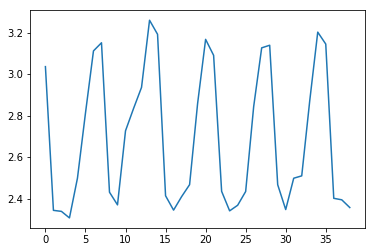

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.015153   
air_0164b9927d20bcc3_2017-04-23              1.159538   
air_0241aa3964b7f861_2017-04-23              2.201394   
air_0328696196e46f18_2017-04-23              2.177014   
air_034a3d5b40d5b1b1_2017-04-23              3.288455   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.501875  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.188459  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.037601  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.819930  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  25.801427

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')